图像: 44220_left.jpeg
  平均亮度 (Mean Brightness): 75.45
  对比度 (Contrast): 82.65
  拉普拉斯方差 (Laplacian Variance): 8.58
--------------------------------------------------


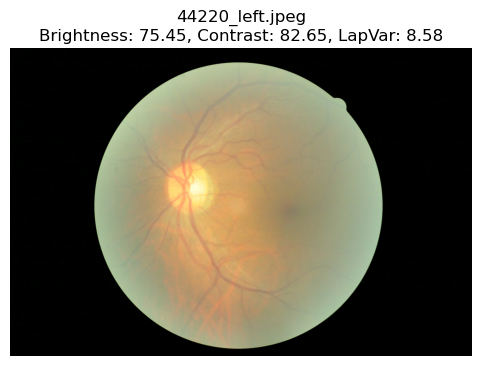

图像: 44306_left.jpeg
  平均亮度 (Mean Brightness): 40.37
  对比度 (Contrast): 22.77
  拉普拉斯方差 (Laplacian Variance): 10.43
--------------------------------------------------


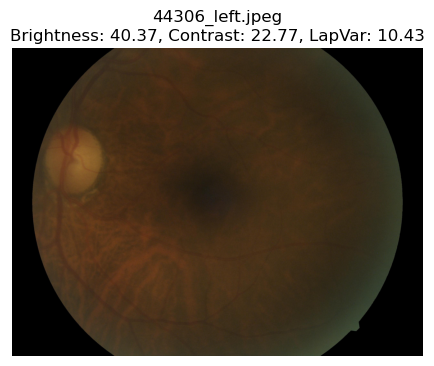

图像: 44278_left.jpeg
  平均亮度 (Mean Brightness): 82.16
  对比度 (Contrast): 53.19
  拉普拉斯方差 (Laplacian Variance): 8.10
--------------------------------------------------


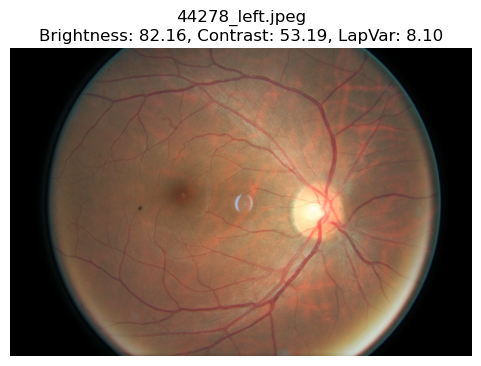

图像: 44331_right.jpeg
  平均亮度 (Mean Brightness): 85.48
  对比度 (Contrast): 46.57
  拉普拉斯方差 (Laplacian Variance): 58.39
--------------------------------------------------


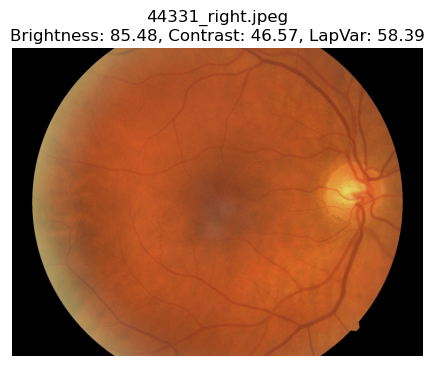

图像: 44240_left.jpeg
  平均亮度 (Mean Brightness): 50.01
  对比度 (Contrast): 37.26
  拉普拉斯方差 (Laplacian Variance): 15.16
--------------------------------------------------


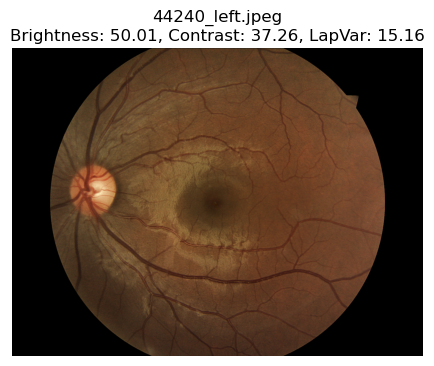

In [19]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

# 图像文件夹路径
image_folder = './diabetic-retinopathy-detection/train'

# 指定您认为清晰的图像文件名列表
image_names = [
    '44220_left.jpeg',
    '44306_left.jpeg',
    '44278_left.jpeg',
    '44331_right.jpeg',
    '44240_left.jpeg',
    # 添加更多图像文件名
]

# 用于存储结果的列表
results = []

for image_name in image_names:
    image_path = os.path.join(image_folder, image_name)
    
    # 检查图像文件是否存在
    if not os.path.exists(image_path):
        print(f"图像 {image_name} 不存在，跳过。")
        continue
    
    # 读取图像
    image = cv2.imread(image_path)
    if image is None:
        print(f"无法读取图像 {image_name}，跳过。")
        continue
    
    # 转换为灰度图
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # 计算拉普拉斯方差（模糊度）
    laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()
    
    # 计算平均亮度和对比度
    mean_brightness = np.mean(gray)
    contrast = np.std(gray)
    
    # 将结果添加到列表
    results.append({
        'image_name': image_name,
        'mean_brightness': mean_brightness,
        'contrast': contrast,
        'laplacian_var': laplacian_var
    })
    
    # 打印结果
    print(f"图像: {image_name}")
    print(f"  平均亮度 (Mean Brightness): {mean_brightness:.2f}")
    print(f"  对比度 (Contrast): {contrast:.2f}")
    print(f"  拉普拉斯方差 (Laplacian Variance): {laplacian_var:.2f}")
    print("-" * 50)
    
    # 显示图像
    plt.figure(figsize=(6, 4))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f"{image_name}\nBrightness: {mean_brightness:.2f}, Contrast: {contrast:.2f}, LapVar: {laplacian_var:.2f}")
    plt.axis('off')
    plt.show()

In [19]:
import os
import cv2
import pandas as pd
import numpy as np
from tqdm import tqdm

# 文件路径
image_folder = './diabetic-retinopathy-detection/train/'  # 图像存放文件夹
labels_file = './diabetic-retinopathy-detection/trainLabels.csv'  # 图像标签文件
output_folder = './Balanced_images4/'  # 平衡后的图像存放文件夹
output_csv = './balanced_labels4.csv'  # 平衡后的标签文件

# 目标每个类别的样本数量
TARGET_COUNT = 3500

# 图像大小
IMAGE_SIZE = (1024, 1024)

# 创建输出目录
os.makedirs(output_folder, exist_ok=True)

# 读取标签文件
labels_df = pd.read_csv(labels_file)

# 验证图像路径的完整性
def verify_image_path(row):
    base_path = os.path.join(image_folder, row['image'])  # 不带后缀的路径
    if os.path.exists(f"{base_path}.jpeg"):  # 检查是否存在 `.jpeg`
        return f"{base_path}.jpeg"
    elif os.path.exists(base_path):  # 检查不带后缀的路径
        return base_path
    else:
        print(f"Image not found for: {row['image']}")
        return None

# 验证并添加图像路径
labels_df['path'] = labels_df.apply(verify_image_path, axis=1)
labels_df = labels_df.dropna(subset=['path']).reset_index(drop=True)
print(f"Valid image paths: {len(labels_df)}")

# 定义亮度和对比度阈值
BRIGHTNESS_LOW = 50
BRIGHTNESS_HIGH = 100
CONTRAST_LOW = 40

# 准备保存已处理的标签
balanced_labels = []

print("Processing classes...")

# 定义用于存储每个等级符合要求的图像的字典
valid_images_per_level = {0: []}

# 处理 level 0, 1, 2
for level in [0]:
    level_df = labels_df[labels_df['level'] == level].copy()
    print(f"Processing level {level} images...")
    
    # 初始化未处理的图像列表
    unprocessed_indices = level_df.index.tolist()
    
    while len(valid_images_per_level[level]) < TARGET_COUNT and len(unprocessed_indices) > 0:
        # 计算还需要多少张图像
        remaining_needed = TARGET_COUNT - len(valid_images_per_level[level])
        
        # 每次随机抽取 min(remaining_needed * 2, len(unprocessed_indices)) 张图像进行处理
        # 乘以 2 是为了提高一次抽取的效率，可以根据需要调整
        sample_size = min(remaining_needed * 2, len(unprocessed_indices))
        sampled_indices = np.random.choice(unprocessed_indices, size=sample_size, replace=False)
        
        # 从未处理的列表中移除已抽取的索引
        for idx in sampled_indices:
            unprocessed_indices.remove(idx)
        
        sampled_df = level_df.loc[sampled_indices]
        
        # 处理抽取的图像
        for idx, row in sampled_df.iterrows():
            img_path = row['path']
            img = cv2.imread(img_path, cv2.IMREAD_REDUCED_COLOR_4)  # 使用缩小版图像，加快读取速度
            if img is not None:
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                mean_brightness = np.mean(gray)
                contrast = np.std(gray)

                if BRIGHTNESS_LOW <= mean_brightness <= BRIGHTNESS_HIGH and contrast >= CONTRAST_LOW:
                    # 符合要求，添加到有效图像列表
                    valid_images_per_level[level].append(row)
                    # 检查是否已达到目标数量
                    if len(valid_images_per_level[level]) >= TARGET_COUNT:
                        break  # 跳出循环
        print(f"Level {level}: Collected {len(valid_images_per_level[level])}/{TARGET_COUNT} images.")
        
        # 防止死循环，如果没有更多的未处理图像，跳出循环
        if len(unprocessed_indices) == 0:
            print(f"Level {level}: No more unprocessed images available.")
            break

    if len(valid_images_per_level[level]) < TARGET_COUNT:
        print(f"Warning: Level {level} only has {len(valid_images_per_level[level])} images meeting criteria, less than TARGET_COUNT.")

    # 保存符合条件的图像
    for row in tqdm(valid_images_per_level[level], desc=f"Saving level {level} images"):
        img_path = row['path']
        label = row['level']
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, IMAGE_SIZE)  # 调整图像大小
            image_name = os.path.basename(img_path)
            output_path = os.path.join(output_folder, image_name)
            cv2.imwrite(output_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
            balanced_labels.append({'image': image_name, 'level': label})

# 处理 level 3, 4
for level in [1, 2, 3, 4]:
    level_df = labels_df[labels_df['level'] == level]
    valid_rows = []

    print(f"Processing level {level} images...")
    for idx, row in tqdm(level_df.iterrows(), total=level_df.shape[0]):
        img_path = row['path']
        img = cv2.imread(img_path, cv2.IMREAD_REDUCED_COLOR_4)  # 使用缩小版图像，加快读取速度
        if img is not None:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            mean_brightness = np.mean(gray)
            contrast = np.std(gray)

            if BRIGHTNESS_LOW <= mean_brightness <= BRIGHTNESS_HIGH and contrast >= CONTRAST_LOW:
                valid_rows.append(row)
    print(f"Level {level}: Found {len(valid_rows)} images that meet brightness and contrast criteria.")

    # 保存符合条件的图像
    for row in tqdm(valid_rows, desc=f"Saving level {level} images"):
        img_path = row['path']
        label = row['level']
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, IMAGE_SIZE)  # 调整图像大小
            image_name = os.path.basename(img_path)
            output_path = os.path.join(output_folder, image_name)
            cv2.imwrite(output_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
            balanced_labels.append({'image': image_name, 'level': label})

# 保存对应的 CSV 文件
balanced_labels_df = pd.DataFrame(balanced_labels)
balanced_labels_df.to_csv(output_csv, index=False)
print(f"Balanced dataset saved to {output_folder}")
print(f"Balanced labels saved to {output_csv}")

Valid image paths: 35126
Processing classes...
Processing level 0 images...
Level 0: Collected 3297/3500 images.
Level 0: Collected 3485/3500 images.
Level 0: Collected 3499/3500 images.
Level 0: Collected 3499/3500 images.
Level 0: Collected 3500/3500 images.


Saving level 0 images: 100%|██████████| 3500/3500 [01:21<00:00, 42.90it/s]


Processing level 1 images...


100%|██████████| 2443/2443 [00:29<00:00, 84.01it/s]


Level 1: Found 1107 images that meet brightness and contrast criteria.


Saving level 1 images: 100%|██████████| 1107/1107 [00:25<00:00, 43.07it/s]


Processing level 2 images...


100%|██████████| 5292/5292 [01:07<00:00, 78.84it/s] 


Level 2: Found 2317 images that meet brightness and contrast criteria.


Saving level 2 images: 100%|██████████| 2317/2317 [00:57<00:00, 40.36it/s]


Processing level 3 images...


100%|██████████| 873/873 [00:11<00:00, 79.28it/s]


Level 3: Found 397 images that meet brightness and contrast criteria.


Saving level 3 images: 100%|██████████| 397/397 [00:09<00:00, 39.87it/s]


Processing level 4 images...


100%|██████████| 708/708 [00:09<00:00, 75.99it/s]


Level 4: Found 314 images that meet brightness and contrast criteria.


Saving level 4 images: 100%|██████████| 314/314 [00:07<00:00, 41.29it/s]


Balanced dataset saved to ./Balanced_images4/
Balanced labels saved to ./balanced_labels4.csv


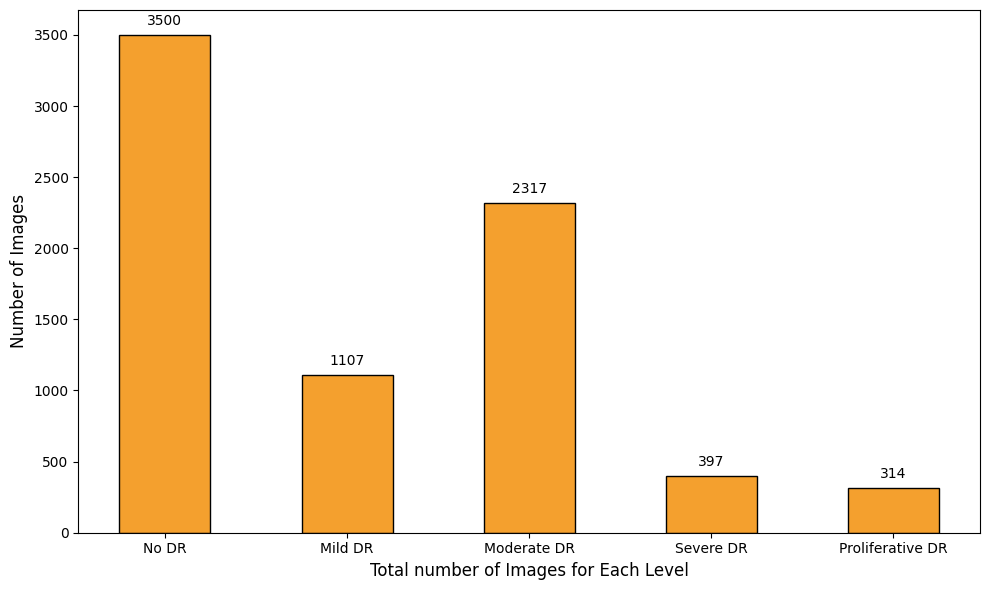

In [7]:
import matplotlib.pyplot as plt

# 数据
categories = ['No DR', 'Mild DR', 'Moderate DR', 'Severe DR', 'Proliferative DR']
values = [3500, 1107, 2317, 397, 314]

# 绘制柱状图，调整柱子的宽度
fig, ax = plt.subplots(figsize=(10, 6))
bars = plt.bar(categories, values, width=0.5, color='#f4a02e', edgecolor='black')  # 调整width参数

# 为每个柱子加上数值标签
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 50, f'{height}', 
            ha='center', va='bottom', fontsize=10)

# 添加标题和坐标轴标签
plt.xlabel('Total number of Images for Each Level', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)

# 显示图表
plt.tight_layout()
plt.show()


In [24]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
import random
from PIL import Image
import matplotlib.pyplot as plt

# 引入预训练模型相关的库
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image

# 引入 BorderlineSMOTE
from imblearn.over_sampling import BorderlineSMOTE

# 文件路径
image_folder = './Balanced_images4/'
labels_file = './balanced_labels4.csv'
output_csv = './balanced_labels_with_borderline_smote4.csv'

# 读取标签文件
labels_df = pd.read_csv(labels_file)

# 将标签转换为整数类型
labels_df['level'] = labels_df['level'].astype(int)

# 定义目标类别和目标数量
target_classes = [1, 2, 3, 4]  # 少数类
TARGET_COUNT = 3500  # 每个类别的目标数量

# 图像大小
IMAGE_SIZE = (1024, 1024)  # 修改为 

# 加载预训练的 VGG16 模型（不包含顶层），用于特征提取
feature_extractor = VGG16(weights='imagenet', include_top=False, pooling='avg', input_shape=(1024, 1024, 3))

# 提取所有图像的特征并构建特征矩阵和标签
def extract_features_and_labels(df):
    features = []
    labels = []
    image_paths = []
    for idx, row in tqdm(df.iterrows(), total=df.shape[0], desc='Extracting features'):
        img_path = os.path.join(image_folder, row['image'])
        try:
            img = image.load_img(img_path, target_size=IMAGE_SIZE)
            img_array = image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array = preprocess_input(img_array)
            # 提取特征
            feature = feature_extractor.predict(img_array)
            features.append(feature.flatten())
            labels.append(row['level'])
            image_paths.append(img_path)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
    return np.array(features), np.array(labels), image_paths

# 提取特征和标签
features, labels, image_paths = extract_features_and_labels(labels_df)

# 对少数类进行 Borderline-SMOTE 过采样
def apply_borderline_smote(features, labels, target_classes, target_count):
    # 将标签转换为整数类型
    labels = labels.astype(int)
    # 找出少数类样本的索引
    minority_indices = np.where(np.isin(labels, target_classes))[0]
    # 找出多数类样本的索引
    majority_indices = np.where(~np.isin(labels, target_classes))[0]
    # 构建少数类和多数类的特征和标签
    X_minority = features[minority_indices]
    y_minority = labels[minority_indices]
    X_majority = features[majority_indices]
    y_majority = labels[majority_indices]
    # 合并特征和标签
    X = np.vstack((X_minority, X_majority))
    y = np.hstack((y_minority, y_majority))
    # 创建 BorderlineSMOTE 对象
    smote = BorderlineSMOTE(sampling_strategy={cls: target_count for cls in target_classes}, k_neighbors=10, m_neighbors=15,kind="borderline-2", random_state=39)
    # 进行过采样
    X_resampled, y_resampled = smote.fit_resample(X, y)
    return X_resampled, y_resampled

# 应用 Borderline-SMOTE
print("Applying Borderline-SMOTE...")
X_resampled, y_resampled = apply_borderline_smote(features, labels, target_classes, TARGET_COUNT)

# 找出新合成的样本
new_samples_indices = range(len(features), len(X_resampled))
new_features = X_resampled[new_samples_indices]
new_labels = y_resampled[new_samples_indices]

# 为每个合成的特征向量找到最近的原始特征向量，用于生成合成图像
print("Generating synthetic images...")
nbrs = NearestNeighbors(n_neighbors=1).fit(features)
distances, indices = nbrs.kneighbors(new_features)

# 保存合成图像和更新标签
synthetic_images = []
synthetic_labels = []
new_rows = []

for i, idx in tqdm(enumerate(indices.flatten()), total=len(indices), desc='Saving synthetic images'):
    # 获取最近邻的原始图像
    original_img_path = image_paths[idx]
    img = image.load_img(original_img_path, target_size=IMAGE_SIZE)
    img_array = image.img_to_array(img)

    # 为了生成合成图像，可以对原始图像添加一些微小的扰动
    # 这里我们简单地添加高斯噪声（您可以根据需要改进）
    noise = np.random.normal(0, 5, img_array.shape)
    synthetic_img_array = img_array + noise
    synthetic_img_array = np.clip(synthetic_img_array, 0, 255)

    # 保存合成图像
    label = new_labels[i]
    img_name = f"synthetic_{label}_{random.randint(100000, 999999)}.jpeg"
    output_path = os.path.join(image_folder, img_name)
    synthetic_img = Image.fromarray(synthetic_img_array.astype('uint8'))
    synthetic_img.save(output_path)

    # 更新列表
    synthetic_images.append(img_name)
    synthetic_labels.append(label)
    new_rows.append({'image': img_name, 'level': label})

# 更新 DataFrame 并保存新的标签文件
new_data = pd.concat([labels_df, pd.DataFrame(new_rows)], ignore_index=True)
new_data.to_csv(output_csv, index=False)

print(f"Borderline-SMOTE completed. New data saved to {output_csv}")

Extracting features:   0%|          | 0/7635 [00:00<?, ?it/s]2024-11-30 21:06:14.607573: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 396ms/step


Extracting features:   0%|          | 1/7635 [00:00<54:47,  2.32it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   0%|          | 2/7635 [00:00<33:14,  3.83it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:   0%|          | 3/7635 [00:00<27:09,  4.68it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:   0%|          | 4/7635 [00:00<23:59,  5.30it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   0%|          | 5/7635 [00:01<22:02,  5.77it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:   0%|          | 6/7635 [00:01<20:59,  6.06it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   0%|          | 7/7635 [00:01<20:08,  6.31it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   0%|          | 8/7635 [00:01<19:19,  6.58it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   0%|          | 9/7635 [00:01<19:08,  6.64it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:   0%|          | 10/7635 [00:01<19:06,  6.65it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   0%|          | 11/7635 [00:01<18:48,  6.75it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   0%|          | 12/7635 [00:02<18:53,  6.73it/s]

1/1 [==============================] - 0s 38ms/step


Extracting features:   0%|          | 13/7635 [00:02<19:57,  6.37it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   0%|          | 14/7635 [00:02<19:18,  6.58it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   0%|          | 15/7635 [00:02<19:10,  6.62it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   0%|          | 16/7635 [00:02<19:16,  6.59it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:   0%|          | 17/7635 [00:02<19:35,  6.48it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   0%|          | 18/7635 [00:02<19:13,  6.60it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   0%|          | 19/7635 [00:03<19:02,  6.67it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:   0%|          | 20/7635 [00:03<19:21,  6.55it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:   0%|          | 21/7635 [00:03<19:28,  6.51it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   0%|          | 22/7635 [00:03<19:17,  6.58it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:   0%|          | 23/7635 [00:03<19:20,  6.56it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   0%|          | 24/7635 [00:03<19:07,  6.63it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   0%|          | 25/7635 [00:04<18:59,  6.68it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:   0%|          | 26/7635 [00:04<19:04,  6.65it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   0%|          | 27/7635 [00:04<19:01,  6.67it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:   0%|          | 28/7635 [00:04<19:02,  6.66it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:   0%|          | 29/7635 [00:04<19:15,  6.58it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:   0%|          | 30/7635 [00:04<19:09,  6.62it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:   0%|          | 31/7635 [00:04<19:25,  6.52it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   0%|          | 32/7635 [00:05<19:09,  6.61it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   0%|          | 33/7635 [00:05<18:54,  6.70it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   0%|          | 34/7635 [00:05<18:41,  6.78it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   0%|          | 35/7635 [00:05<18:35,  6.81it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:   0%|          | 36/7635 [00:05<18:45,  6.75it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:   0%|          | 37/7635 [00:05<19:13,  6.59it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:   0%|          | 38/7635 [00:05<19:18,  6.56it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   1%|          | 39/7635 [00:06<19:10,  6.60it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   1%|          | 40/7635 [00:06<18:54,  6.70it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   1%|          | 41/7635 [00:06<18:51,  6.71it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   1%|          | 42/7635 [00:06<18:38,  6.79it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:   1%|          | 43/7635 [00:06<19:00,  6.65it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   1%|          | 44/7635 [00:06<18:47,  6.74it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   1%|          | 45/7635 [00:07<18:41,  6.77it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   1%|          | 46/7635 [00:07<18:42,  6.76it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   1%|          | 47/7635 [00:07<18:32,  6.82it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   1%|          | 48/7635 [00:07<18:26,  6.86it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   1%|          | 49/7635 [00:07<18:36,  6.80it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   1%|          | 50/7635 [00:07<18:26,  6.86it/s]

1/1 [==============================] - 0s 45ms/step


Extracting features:   1%|          | 51/7635 [00:07<20:10,  6.27it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   1%|          | 52/7635 [00:08<19:37,  6.44it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:   1%|          | 53/7635 [00:08<19:26,  6.50it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   1%|          | 54/7635 [00:08<19:07,  6.61it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   1%|          | 55/7635 [00:08<19:05,  6.62it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   1%|          | 56/7635 [00:08<18:48,  6.71it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:   1%|          | 57/7635 [00:08<19:13,  6.57it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:   1%|          | 58/7635 [00:08<19:22,  6.52it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:   1%|          | 59/7635 [00:09<19:09,  6.59it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   1%|          | 60/7635 [00:09<19:05,  6.61it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:   1%|          | 61/7635 [00:09<19:27,  6.49it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:   1%|          | 62/7635 [00:09<19:28,  6.48it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:   1%|          | 63/7635 [00:09<19:51,  6.36it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   1%|          | 64/7635 [00:09<19:20,  6.53it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:   1%|          | 65/7635 [00:10<19:18,  6.54it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   1%|          | 66/7635 [00:10<18:58,  6.65it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   1%|          | 67/7635 [00:10<18:37,  6.77it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:   1%|          | 68/7635 [00:10<18:36,  6.78it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   1%|          | 69/7635 [00:10<18:22,  6.86it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:   1%|          | 70/7635 [00:10<18:18,  6.89it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   1%|          | 71/7635 [00:10<18:18,  6.89it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   1%|          | 72/7635 [00:11<18:09,  6.94it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   1%|          | 73/7635 [00:11<18:13,  6.91it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   1%|          | 74/7635 [00:11<18:07,  6.95it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   1%|          | 75/7635 [00:11<17:56,  7.02it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   1%|          | 76/7635 [00:11<17:53,  7.04it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   1%|          | 77/7635 [00:11<17:49,  7.07it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   1%|          | 78/7635 [00:11<17:47,  7.08it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   1%|          | 79/7635 [00:12<17:44,  7.10it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   1%|          | 80/7635 [00:12<17:43,  7.10it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   1%|          | 81/7635 [00:12<17:51,  7.05it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   1%|          | 82/7635 [00:12<17:47,  7.08it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   1%|          | 83/7635 [00:12<17:49,  7.06it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   1%|          | 84/7635 [00:12<17:45,  7.09it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   1%|          | 85/7635 [00:12<17:45,  7.08it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   1%|          | 86/7635 [00:13<17:45,  7.08it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   1%|          | 87/7635 [00:13<17:43,  7.10it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   1%|          | 88/7635 [00:13<17:48,  7.06it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:   1%|          | 89/7635 [00:13<18:07,  6.94it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   1%|          | 90/7635 [00:13<18:04,  6.96it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   1%|          | 91/7635 [00:13<18:14,  6.89it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   1%|          | 92/7635 [00:13<18:13,  6.90it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   1%|          | 93/7635 [00:14<18:06,  6.94it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   1%|          | 94/7635 [00:14<18:05,  6.95it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   1%|          | 95/7635 [00:14<17:59,  6.98it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   1%|▏         | 96/7635 [00:14<17:56,  7.00it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:   1%|▏         | 97/7635 [00:14<18:11,  6.90it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   1%|▏         | 98/7635 [00:14<18:10,  6.91it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   1%|▏         | 99/7635 [00:14<18:09,  6.91it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   1%|▏         | 100/7635 [00:15<18:08,  6.92it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   1%|▏         | 101/7635 [00:15<18:01,  6.96it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   1%|▏         | 102/7635 [00:15<17:54,  7.01it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   1%|▏         | 103/7635 [00:15<17:54,  7.01it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   1%|▏         | 104/7635 [00:15<17:46,  7.06it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   1%|▏         | 105/7635 [00:15<17:57,  6.99it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   1%|▏         | 106/7635 [00:15<17:53,  7.01it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   1%|▏         | 107/7635 [00:16<17:44,  7.07it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   1%|▏         | 108/7635 [00:16<17:43,  7.08it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   1%|▏         | 109/7635 [00:16<17:47,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   1%|▏         | 110/7635 [00:16<19:10,  6.54it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   1%|▏         | 111/7635 [00:16<18:44,  6.69it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   1%|▏         | 112/7635 [00:16<18:19,  6.84it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   1%|▏         | 113/7635 [00:16<18:15,  6.86it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   1%|▏         | 114/7635 [00:17<18:03,  6.94it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:   2%|▏         | 115/7635 [00:17<17:56,  6.98it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   2%|▏         | 116/7635 [00:17<17:50,  7.03it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   2%|▏         | 117/7635 [00:17<17:44,  7.07it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   2%|▏         | 118/7635 [00:17<17:41,  7.08it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   2%|▏         | 119/7635 [00:17<18:07,  6.91it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   2%|▏         | 120/7635 [00:17<18:27,  6.79it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   2%|▏         | 121/7635 [00:18<18:47,  6.66it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   2%|▏         | 122/7635 [00:18<18:32,  6.75it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   2%|▏         | 123/7635 [00:18<18:28,  6.78it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   2%|▏         | 124/7635 [00:18<18:17,  6.84it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   2%|▏         | 125/7635 [00:18<18:06,  6.91it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   2%|▏         | 126/7635 [00:18<18:03,  6.93it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   2%|▏         | 127/7635 [00:18<17:51,  7.01it/s]

1/1 [==============================] - 0s 9ms/step


Extracting features:   2%|▏         | 128/7635 [00:19<17:42,  7.07it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   2%|▏         | 129/7635 [00:19<17:47,  7.03it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   2%|▏         | 130/7635 [00:19<17:41,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   2%|▏         | 131/7635 [00:19<19:22,  6.46it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   2%|▏         | 132/7635 [00:19<18:50,  6.64it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:   2%|▏         | 133/7635 [00:19<19:17,  6.48it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   2%|▏         | 134/7635 [00:20<19:02,  6.57it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   2%|▏         | 135/7635 [00:20<19:05,  6.54it/s]

1/1 [==============================] - 0s 9ms/step


Extracting features:   2%|▏         | 136/7635 [00:20<18:40,  6.69it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   2%|▏         | 137/7635 [00:20<18:30,  6.75it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:   2%|▏         | 138/7635 [00:20<18:27,  6.77it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:   2%|▏         | 139/7635 [00:20<18:47,  6.65it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:   2%|▏         | 140/7635 [00:20<18:52,  6.62it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   2%|▏         | 141/7635 [00:21<18:51,  6.63it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   2%|▏         | 142/7635 [00:21<18:37,  6.71it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   2%|▏         | 143/7635 [00:21<18:42,  6.68it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   2%|▏         | 144/7635 [00:21<19:10,  6.51it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   2%|▏         | 145/7635 [00:21<19:12,  6.50it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:   2%|▏         | 146/7635 [00:21<20:04,  6.22it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:   2%|▏         | 147/7635 [00:22<20:19,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   2%|▏         | 148/7635 [00:22<20:35,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   2%|▏         | 149/7635 [00:22<20:25,  6.11it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:   2%|▏         | 150/7635 [00:22<20:58,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:   2%|▏         | 151/7635 [00:22<20:56,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   2%|▏         | 152/7635 [00:22<20:33,  6.07it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:   2%|▏         | 153/7635 [00:23<20:54,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:   2%|▏         | 154/7635 [00:23<22:33,  5.53it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:   2%|▏         | 155/7635 [00:23<22:36,  5.51it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:   2%|▏         | 156/7635 [00:23<23:22,  5.33it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:   2%|▏         | 157/7635 [00:23<23:16,  5.35it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:   2%|▏         | 158/7635 [00:24<23:24,  5.32it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:   2%|▏         | 159/7635 [00:24<22:18,  5.58it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   2%|▏         | 160/7635 [00:24<21:05,  5.91it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:   2%|▏         | 161/7635 [00:24<20:20,  6.12it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   2%|▏         | 162/7635 [00:24<19:37,  6.35it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   2%|▏         | 163/7635 [00:24<19:13,  6.48it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   2%|▏         | 164/7635 [00:24<18:52,  6.59it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:   2%|▏         | 165/7635 [00:25<18:47,  6.63it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   2%|▏         | 166/7635 [00:25<18:57,  6.56it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:   2%|▏         | 167/7635 [00:25<19:23,  6.42it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   2%|▏         | 168/7635 [00:25<19:05,  6.52it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:   2%|▏         | 169/7635 [00:25<19:57,  6.24it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   2%|▏         | 170/7635 [00:25<19:27,  6.40it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:   2%|▏         | 171/7635 [00:25<19:03,  6.52it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   2%|▏         | 172/7635 [00:26<18:48,  6.61it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   2%|▏         | 173/7635 [00:26<18:31,  6.71it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   2%|▏         | 174/7635 [00:26<18:19,  6.79it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   2%|▏         | 175/7635 [00:26<18:07,  6.86it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   2%|▏         | 176/7635 [00:26<18:00,  6.91it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   2%|▏         | 177/7635 [00:26<18:07,  6.85it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   2%|▏         | 178/7635 [00:27<18:07,  6.86it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   2%|▏         | 179/7635 [00:27<18:10,  6.84it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   2%|▏         | 180/7635 [00:27<18:03,  6.88it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   2%|▏         | 181/7635 [00:27<18:52,  6.58it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   2%|▏         | 182/7635 [00:27<18:47,  6.61it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   2%|▏         | 183/7635 [00:27<18:31,  6.70it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   2%|▏         | 184/7635 [00:27<18:14,  6.81it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   2%|▏         | 185/7635 [00:28<18:13,  6.81it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   2%|▏         | 186/7635 [00:28<18:07,  6.85it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   2%|▏         | 187/7635 [00:28<18:05,  6.86it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   2%|▏         | 188/7635 [00:28<18:07,  6.85it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   2%|▏         | 189/7635 [00:28<17:59,  6.89it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   2%|▏         | 190/7635 [00:28<17:58,  6.91it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   3%|▎         | 191/7635 [00:28<18:01,  6.88it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   3%|▎         | 192/7635 [00:29<17:53,  6.93it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:   3%|▎         | 193/7635 [00:29<18:26,  6.73it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   3%|▎         | 194/7635 [00:29<18:08,  6.83it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   3%|▎         | 195/7635 [00:29<18:08,  6.83it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   3%|▎         | 196/7635 [00:29<18:08,  6.83it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   3%|▎         | 197/7635 [00:29<18:10,  6.82it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   3%|▎         | 198/7635 [00:29<17:58,  6.90it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   3%|▎         | 199/7635 [00:30<18:00,  6.88it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   3%|▎         | 200/7635 [00:30<17:49,  6.95it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   3%|▎         | 201/7635 [00:30<18:02,  6.87it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   3%|▎         | 202/7635 [00:30<18:07,  6.83it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   3%|▎         | 203/7635 [00:30<17:54,  6.91it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   3%|▎         | 204/7635 [00:30<17:54,  6.91it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   3%|▎         | 205/7635 [00:30<17:36,  7.03it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   3%|▎         | 206/7635 [00:31<17:46,  6.97it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   3%|▎         | 207/7635 [00:31<17:53,  6.92it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   3%|▎         | 208/7635 [00:31<17:39,  7.01it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   3%|▎         | 209/7635 [00:31<17:40,  7.00it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   3%|▎         | 210/7635 [00:31<17:31,  7.06it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   3%|▎         | 211/7635 [00:31<17:30,  7.06it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   3%|▎         | 212/7635 [00:31<17:30,  7.07it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   3%|▎         | 213/7635 [00:32<17:31,  7.06it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:   3%|▎         | 214/7635 [00:32<17:53,  6.91it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   3%|▎         | 215/7635 [00:32<17:41,  6.99it/s]

1/1 [==============================] - 0s 9ms/step


Extracting features:   3%|▎         | 216/7635 [00:32<17:40,  7.00it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   3%|▎         | 217/7635 [00:32<17:55,  6.90it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   3%|▎         | 218/7635 [00:32<19:14,  6.43it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   3%|▎         | 219/7635 [00:32<18:41,  6.61it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   3%|▎         | 220/7635 [00:33<18:28,  6.69it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   3%|▎         | 221/7635 [00:33<18:23,  6.72it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   3%|▎         | 222/7635 [00:33<18:00,  6.86it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   3%|▎         | 223/7635 [00:33<17:44,  6.96it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   3%|▎         | 224/7635 [00:33<17:30,  7.06it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   3%|▎         | 225/7635 [00:33<17:31,  7.05it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   3%|▎         | 226/7635 [00:33<17:21,  7.12it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   3%|▎         | 227/7635 [00:34<17:14,  7.16it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   3%|▎         | 228/7635 [00:34<17:17,  7.14it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   3%|▎         | 229/7635 [00:34<17:34,  7.02it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   3%|▎         | 230/7635 [00:34<17:27,  7.07it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   3%|▎         | 231/7635 [00:34<17:22,  7.11it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   3%|▎         | 232/7635 [00:34<17:15,  7.15it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   3%|▎         | 233/7635 [00:34<17:58,  6.86it/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:   3%|▎         | 234/7635 [00:35<19:10,  6.43it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   3%|▎         | 235/7635 [00:35<18:28,  6.67it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   3%|▎         | 236/7635 [00:35<18:02,  6.84it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   3%|▎         | 237/7635 [00:35<17:45,  6.94it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   3%|▎         | 238/7635 [00:35<17:40,  6.98it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   3%|▎         | 239/7635 [00:35<17:35,  7.01it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   3%|▎         | 240/7635 [00:35<17:43,  6.95it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   3%|▎         | 241/7635 [00:36<17:42,  6.96it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   3%|▎         | 242/7635 [00:36<17:27,  7.06it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   3%|▎         | 243/7635 [00:36<17:23,  7.08it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   3%|▎         | 244/7635 [00:36<17:29,  7.04it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:   3%|▎         | 245/7635 [00:36<17:47,  6.93it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:   3%|▎         | 246/7635 [00:36<17:56,  6.87it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:   3%|▎         | 247/7635 [00:37<18:09,  6.78it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   3%|▎         | 248/7635 [00:37<18:12,  6.76it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   3%|▎         | 249/7635 [00:37<18:13,  6.75it/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   3%|▎         | 250/7635 [00:37<19:29,  6.31it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   3%|▎         | 251/7635 [00:37<18:48,  6.55it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   3%|▎         | 252/7635 [00:37<18:13,  6.75it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   3%|▎         | 253/7635 [00:37<17:50,  6.90it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   3%|▎         | 254/7635 [00:38<17:33,  7.01it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   3%|▎         | 255/7635 [00:38<17:24,  7.06it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   3%|▎         | 256/7635 [00:38<17:25,  7.06it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   3%|▎         | 257/7635 [00:38<17:24,  7.06it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   3%|▎         | 258/7635 [00:38<17:12,  7.15it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   3%|▎         | 259/7635 [00:38<17:07,  7.18it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   3%|▎         | 260/7635 [00:38<17:01,  7.22it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   3%|▎         | 261/7635 [00:39<16:59,  7.23it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   3%|▎         | 262/7635 [00:39<17:04,  7.19it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   3%|▎         | 263/7635 [00:39<17:15,  7.12it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   3%|▎         | 264/7635 [00:39<17:11,  7.15it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   3%|▎         | 265/7635 [00:39<17:13,  7.13it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   3%|▎         | 266/7635 [00:39<17:08,  7.17it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   3%|▎         | 267/7635 [00:39<17:01,  7.22it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   4%|▎         | 268/7635 [00:39<16:57,  7.24it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   4%|▎         | 269/7635 [00:40<16:55,  7.25it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   4%|▎         | 270/7635 [00:40<17:03,  7.20it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   4%|▎         | 271/7635 [00:40<16:59,  7.22it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   4%|▎         | 272/7635 [00:40<17:13,  7.13it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   4%|▎         | 273/7635 [00:40<17:24,  7.05it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   4%|▎         | 274/7635 [00:40<17:14,  7.11it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   4%|▎         | 275/7635 [00:40<17:09,  7.15it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   4%|▎         | 276/7635 [00:41<17:02,  7.20it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   4%|▎         | 277/7635 [00:41<17:05,  7.18it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   4%|▎         | 278/7635 [00:41<17:06,  7.16it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   4%|▎         | 279/7635 [00:41<17:21,  7.06it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   4%|▎         | 280/7635 [00:41<17:11,  7.13it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   4%|▎         | 281/7635 [00:41<17:14,  7.11it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   4%|▎         | 282/7635 [00:41<17:06,  7.16it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   4%|▎         | 283/7635 [00:42<17:01,  7.20it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   4%|▎         | 284/7635 [00:42<16:54,  7.25it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   4%|▎         | 285/7635 [00:42<16:52,  7.26it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   4%|▎         | 286/7635 [00:42<16:55,  7.24it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:   4%|▍         | 287/7635 [00:42<17:21,  7.05it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   4%|▍         | 288/7635 [00:42<17:18,  7.07it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   4%|▍         | 289/7635 [00:42<17:27,  7.01it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   4%|▍         | 290/7635 [00:43<17:24,  7.03it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   4%|▍         | 291/7635 [00:43<17:15,  7.09it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   4%|▍         | 292/7635 [00:43<17:06,  7.16it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   4%|▍         | 293/7635 [00:43<17:08,  7.14it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   4%|▍         | 294/7635 [00:43<17:05,  7.16it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   4%|▍         | 295/7635 [00:43<17:04,  7.17it/s]

1/1 [==============================] - 0s 9ms/step


Extracting features:   4%|▍         | 296/7635 [00:43<17:01,  7.18it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   4%|▍         | 297/7635 [00:44<17:09,  7.13it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   4%|▍         | 298/7635 [00:44<17:12,  7.11it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   4%|▍         | 299/7635 [00:44<17:27,  7.01it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:   4%|▍         | 300/7635 [00:44<19:15,  6.35it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   4%|▍         | 301/7635 [00:44<18:50,  6.49it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   4%|▍         | 302/7635 [00:44<18:33,  6.59it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   4%|▍         | 303/7635 [00:44<18:04,  6.76it/s]

1/1 [==============================] - 0s 9ms/step


Extracting features:   4%|▍         | 304/7635 [00:45<17:40,  6.91it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   4%|▍         | 305/7635 [00:45<17:41,  6.90it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   4%|▍         | 306/7635 [00:45<17:42,  6.90it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   4%|▍         | 307/7635 [00:45<17:33,  6.95it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   4%|▍         | 308/7635 [00:45<17:43,  6.89it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   4%|▍         | 309/7635 [00:45<17:27,  6.99it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   4%|▍         | 310/7635 [00:45<17:15,  7.07it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   4%|▍         | 311/7635 [00:46<17:09,  7.11it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   4%|▍         | 312/7635 [00:46<17:06,  7.13it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   4%|▍         | 313/7635 [00:46<17:19,  7.04it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   4%|▍         | 314/7635 [00:46<17:21,  7.03it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   4%|▍         | 315/7635 [00:46<17:13,  7.09it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   4%|▍         | 316/7635 [00:46<17:12,  7.09it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   4%|▍         | 317/7635 [00:46<17:29,  6.97it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   4%|▍         | 318/7635 [00:47<17:36,  6.93it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   4%|▍         | 319/7635 [00:47<17:20,  7.03it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   4%|▍         | 320/7635 [00:47<17:10,  7.10it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   4%|▍         | 321/7635 [00:47<17:18,  7.04it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   4%|▍         | 322/7635 [00:47<17:11,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:   4%|▍         | 323/7635 [00:47<18:38,  6.53it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   4%|▍         | 324/7635 [00:47<18:23,  6.62it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   4%|▍         | 325/7635 [00:48<17:57,  6.78it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   4%|▍         | 326/7635 [00:48<17:40,  6.89it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   4%|▍         | 327/7635 [00:48<17:26,  6.99it/s]

1/1 [==============================] - 0s 9ms/step


Extracting features:   4%|▍         | 328/7635 [00:48<17:19,  7.03it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   4%|▍         | 329/7635 [00:48<17:39,  6.90it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   4%|▍         | 330/7635 [00:48<17:25,  6.99it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   4%|▍         | 331/7635 [00:48<17:12,  7.07it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   4%|▍         | 332/7635 [00:49<17:03,  7.13it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   4%|▍         | 333/7635 [00:49<17:13,  7.06it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   4%|▍         | 334/7635 [00:49<17:10,  7.08it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   4%|▍         | 335/7635 [00:49<17:12,  7.07it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   4%|▍         | 336/7635 [00:49<17:15,  7.05it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   4%|▍         | 337/7635 [00:49<17:36,  6.91it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   4%|▍         | 338/7635 [00:49<17:27,  6.96it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   4%|▍         | 339/7635 [00:50<17:20,  7.01it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   4%|▍         | 340/7635 [00:50<17:22,  6.99it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   4%|▍         | 341/7635 [00:50<17:11,  7.07it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   4%|▍         | 342/7635 [00:50<17:05,  7.11it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   4%|▍         | 343/7635 [00:50<16:59,  7.15it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   5%|▍         | 344/7635 [00:50<17:09,  7.08it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   5%|▍         | 345/7635 [00:50<17:20,  7.00it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:   5%|▍         | 346/7635 [00:51<18:48,  6.46it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:   5%|▍         | 347/7635 [00:51<18:26,  6.59it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   5%|▍         | 348/7635 [00:51<17:57,  6.76it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   5%|▍         | 349/7635 [00:51<17:42,  6.86it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   5%|▍         | 350/7635 [00:51<17:28,  6.95it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   5%|▍         | 351/7635 [00:51<17:22,  6.98it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   5%|▍         | 352/7635 [00:51<17:07,  7.09it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   5%|▍         | 353/7635 [00:52<17:10,  7.07it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   5%|▍         | 354/7635 [00:52<17:01,  7.13it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   5%|▍         | 355/7635 [00:52<17:16,  7.02it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   5%|▍         | 356/7635 [00:52<17:12,  7.05it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   5%|▍         | 357/7635 [00:52<17:22,  6.98it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:   5%|▍         | 358/7635 [00:52<17:36,  6.89it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:   5%|▍         | 359/7635 [00:53<17:59,  6.74it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   5%|▍         | 360/7635 [00:53<18:15,  6.64it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:   5%|▍         | 361/7635 [00:53<18:26,  6.58it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   5%|▍         | 362/7635 [00:53<17:59,  6.74it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   5%|▍         | 363/7635 [00:53<17:46,  6.82it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   5%|▍         | 364/7635 [00:53<17:24,  6.96it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   5%|▍         | 365/7635 [00:53<17:14,  7.03it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   5%|▍         | 366/7635 [00:54<17:15,  7.02it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   5%|▍         | 367/7635 [00:54<17:20,  6.99it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   5%|▍         | 368/7635 [00:54<17:07,  7.07it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   5%|▍         | 369/7635 [00:54<17:19,  6.99it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   5%|▍         | 370/7635 [00:54<17:40,  6.85it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   5%|▍         | 371/7635 [00:54<17:33,  6.90it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   5%|▍         | 372/7635 [00:54<17:16,  7.01it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   5%|▍         | 373/7635 [00:55<17:18,  6.99it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   5%|▍         | 374/7635 [00:55<17:09,  7.05it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   5%|▍         | 375/7635 [00:55<17:14,  7.02it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   5%|▍         | 376/7635 [00:55<17:14,  7.02it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   5%|▍         | 377/7635 [00:55<17:32,  6.90it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   5%|▍         | 378/7635 [00:55<17:30,  6.91it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:   5%|▍         | 379/7635 [00:55<17:37,  6.86it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   5%|▍         | 380/7635 [00:56<17:28,  6.92it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:   5%|▍         | 381/7635 [00:56<17:45,  6.81it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   5%|▌         | 382/7635 [00:56<17:39,  6.84it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   5%|▌         | 383/7635 [00:56<17:23,  6.95it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   5%|▌         | 384/7635 [00:56<17:30,  6.90it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   5%|▌         | 385/7635 [00:56<17:27,  6.92it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:   5%|▌         | 386/7635 [00:56<17:44,  6.81it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   5%|▌         | 387/7635 [00:57<17:29,  6.90it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   5%|▌         | 388/7635 [00:57<17:28,  6.91it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   5%|▌         | 389/7635 [00:57<17:26,  6.93it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:   5%|▌         | 390/7635 [00:57<17:39,  6.84it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   5%|▌         | 391/7635 [00:57<17:31,  6.89it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   5%|▌         | 392/7635 [00:57<17:25,  6.93it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   5%|▌         | 393/7635 [00:57<17:54,  6.74it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   5%|▌         | 394/7635 [00:58<17:48,  6.78it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   5%|▌         | 395/7635 [00:58<17:31,  6.89it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   5%|▌         | 396/7635 [00:58<17:19,  6.96it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   5%|▌         | 397/7635 [00:58<17:13,  7.00it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   5%|▌         | 398/7635 [00:58<17:18,  6.97it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   5%|▌         | 399/7635 [00:58<17:11,  7.02it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   5%|▌         | 400/7635 [00:58<17:07,  7.04it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   5%|▌         | 401/7635 [00:59<17:27,  6.90it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:   5%|▌         | 402/7635 [00:59<17:34,  6.86it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:   5%|▌         | 403/7635 [00:59<17:56,  6.72it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   5%|▌         | 404/7635 [00:59<17:39,  6.82it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   5%|▌         | 405/7635 [00:59<17:38,  6.83it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   5%|▌         | 406/7635 [00:59<17:28,  6.90it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   5%|▌         | 407/7635 [00:59<17:18,  6.96it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:   5%|▌         | 408/7635 [01:00<18:13,  6.61it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:   5%|▌         | 409/7635 [01:00<18:44,  6.42it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   5%|▌         | 410/7635 [01:00<18:39,  6.45it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   5%|▌         | 411/7635 [01:00<18:44,  6.43it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:   5%|▌         | 412/7635 [01:00<19:17,  6.24it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:   5%|▌         | 413/7635 [01:01<22:39,  5.31it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:   5%|▌         | 414/7635 [01:01<22:04,  5.45it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:   5%|▌         | 415/7635 [01:01<21:40,  5.55it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:   5%|▌         | 416/7635 [01:01<22:06,  5.44it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:   5%|▌         | 417/7635 [01:01<22:09,  5.43it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   5%|▌         | 418/7635 [01:01<21:09,  5.69it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   5%|▌         | 419/7635 [01:02<20:32,  5.85it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   6%|▌         | 420/7635 [01:02<20:05,  5.98it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   6%|▌         | 421/7635 [01:02<20:03,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   6%|▌         | 422/7635 [01:02<19:35,  6.14it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   6%|▌         | 423/7635 [01:02<19:26,  6.18it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   6%|▌         | 424/7635 [01:02<19:02,  6.31it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   6%|▌         | 425/7635 [01:03<18:53,  6.36it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   6%|▌         | 426/7635 [01:03<18:49,  6.38it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   6%|▌         | 427/7635 [01:03<18:23,  6.53it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   6%|▌         | 428/7635 [01:03<18:08,  6.62it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:   6%|▌         | 429/7635 [01:03<18:18,  6.56it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   6%|▌         | 430/7635 [01:03<18:11,  6.60it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   6%|▌         | 431/7635 [01:03<18:35,  6.46it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   6%|▌         | 432/7635 [01:04<18:11,  6.60it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   6%|▌         | 433/7635 [01:04<17:58,  6.68it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   6%|▌         | 434/7635 [01:04<17:38,  6.80it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   6%|▌         | 435/7635 [01:04<17:28,  6.87it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:   6%|▌         | 436/7635 [01:04<17:52,  6.71it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   6%|▌         | 437/7635 [01:04<17:39,  6.79it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   6%|▌         | 438/7635 [01:04<17:31,  6.84it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   6%|▌         | 439/7635 [01:05<17:25,  6.88it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   6%|▌         | 440/7635 [01:05<17:16,  6.94it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   6%|▌         | 441/7635 [01:05<17:24,  6.89it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:   6%|▌         | 442/7635 [01:05<17:59,  6.66it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   6%|▌         | 443/7635 [01:05<18:09,  6.60it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   6%|▌         | 444/7635 [01:05<17:57,  6.67it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   6%|▌         | 445/7635 [01:05<17:41,  6.77it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   6%|▌         | 446/7635 [01:06<17:26,  6.87it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   6%|▌         | 447/7635 [01:06<17:22,  6.90it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   6%|▌         | 448/7635 [01:06<17:12,  6.96it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   6%|▌         | 449/7635 [01:06<17:15,  6.94it/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:   6%|▌         | 450/7635 [01:06<18:27,  6.49it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   6%|▌         | 451/7635 [01:06<18:05,  6.62it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   6%|▌         | 452/7635 [01:07<17:46,  6.73it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   6%|▌         | 453/7635 [01:07<17:29,  6.85it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   6%|▌         | 454/7635 [01:07<17:20,  6.90it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   6%|▌         | 455/7635 [01:07<17:08,  6.98it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   6%|▌         | 456/7635 [01:07<17:00,  7.03it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   6%|▌         | 457/7635 [01:07<17:06,  6.99it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   6%|▌         | 458/7635 [01:07<16:56,  7.06it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   6%|▌         | 459/7635 [01:07<16:53,  7.08it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   6%|▌         | 460/7635 [01:08<16:51,  7.10it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   6%|▌         | 461/7635 [01:08<16:49,  7.10it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   6%|▌         | 462/7635 [01:08<16:51,  7.09it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   6%|▌         | 463/7635 [01:08<16:56,  7.06it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   6%|▌         | 464/7635 [01:08<17:12,  6.95it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:   6%|▌         | 465/7635 [01:08<17:35,  6.79it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:   6%|▌         | 466/7635 [01:09<18:09,  6.58it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:   6%|▌         | 467/7635 [01:09<18:06,  6.60it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   6%|▌         | 468/7635 [01:09<17:49,  6.70it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   6%|▌         | 469/7635 [01:09<17:32,  6.81it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   6%|▌         | 470/7635 [01:09<17:24,  6.86it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   6%|▌         | 471/7635 [01:09<17:16,  6.91it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   6%|▌         | 472/7635 [01:09<17:08,  6.97it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   6%|▌         | 473/7635 [01:10<17:14,  6.92it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   6%|▌         | 474/7635 [01:10<17:08,  6.96it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   6%|▌         | 475/7635 [01:10<17:05,  6.98it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   6%|▌         | 476/7635 [01:10<17:06,  6.98it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   6%|▌         | 477/7635 [01:10<16:57,  7.04it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   6%|▋         | 478/7635 [01:10<16:52,  7.07it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   6%|▋         | 479/7635 [01:10<16:51,  7.08it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   6%|▋         | 480/7635 [01:11<16:46,  7.11it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   6%|▋         | 481/7635 [01:11<16:55,  7.05it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   6%|▋         | 482/7635 [01:11<16:51,  7.07it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   6%|▋         | 483/7635 [01:11<16:54,  7.05it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   6%|▋         | 484/7635 [01:11<16:52,  7.06it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   6%|▋         | 485/7635 [01:11<16:52,  7.06it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   6%|▋         | 486/7635 [01:11<16:48,  7.09it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   6%|▋         | 487/7635 [01:12<16:52,  7.06it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   6%|▋         | 488/7635 [01:12<17:01,  6.99it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   6%|▋         | 489/7635 [01:12<17:15,  6.90it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   6%|▋         | 490/7635 [01:12<17:17,  6.89it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   6%|▋         | 491/7635 [01:12<17:08,  6.95it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   6%|▋         | 492/7635 [01:12<17:04,  6.97it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   6%|▋         | 493/7635 [01:12<17:04,  6.97it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   6%|▋         | 494/7635 [01:13<17:03,  6.97it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   6%|▋         | 495/7635 [01:13<16:52,  7.05it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   6%|▋         | 496/7635 [01:13<16:47,  7.08it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   7%|▋         | 497/7635 [01:13<16:53,  7.04it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   7%|▋         | 498/7635 [01:13<16:48,  7.07it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   7%|▋         | 499/7635 [01:13<16:46,  7.09it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   7%|▋         | 500/7635 [01:13<16:43,  7.11it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   7%|▋         | 501/7635 [01:14<16:43,  7.11it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   7%|▋         | 502/7635 [01:14<16:40,  7.13it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   7%|▋         | 503/7635 [01:14<16:44,  7.10it/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:   7%|▋         | 504/7635 [01:14<18:06,  6.56it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   7%|▋         | 505/7635 [01:14<17:51,  6.65it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   7%|▋         | 506/7635 [01:14<17:28,  6.80it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   7%|▋         | 507/7635 [01:14<17:13,  6.90it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   7%|▋         | 508/7635 [01:15<17:00,  6.98it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   7%|▋         | 509/7635 [01:15<16:53,  7.03it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   7%|▋         | 510/7635 [01:15<16:51,  7.04it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   7%|▋         | 511/7635 [01:15<16:51,  7.04it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   7%|▋         | 512/7635 [01:15<16:49,  7.05it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   7%|▋         | 513/7635 [01:15<16:53,  7.03it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   7%|▋         | 514/7635 [01:15<16:52,  7.03it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   7%|▋         | 515/7635 [01:16<16:49,  7.05it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   7%|▋         | 516/7635 [01:16<16:48,  7.06it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   7%|▋         | 517/7635 [01:16<16:50,  7.05it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   7%|▋         | 518/7635 [01:16<16:49,  7.05it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   7%|▋         | 519/7635 [01:16<16:51,  7.03it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   7%|▋         | 520/7635 [01:16<16:52,  7.03it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   7%|▋         | 521/7635 [01:16<16:57,  6.99it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:   7%|▋         | 522/7635 [01:17<26:09,  4.53it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   7%|▋         | 523/7635 [01:17<23:24,  5.06it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   7%|▋         | 524/7635 [01:17<21:24,  5.54it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   7%|▋         | 525/7635 [01:17<20:01,  5.92it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   7%|▋         | 526/7635 [01:17<18:59,  6.24it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   7%|▋         | 527/7635 [01:17<18:16,  6.48it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   7%|▋         | 528/7635 [01:18<17:47,  6.66it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   7%|▋         | 529/7635 [01:18<17:30,  6.76it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   7%|▋         | 530/7635 [01:18<17:30,  6.77it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   7%|▋         | 531/7635 [01:18<17:13,  6.87it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   7%|▋         | 532/7635 [01:18<17:14,  6.86it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   7%|▋         | 533/7635 [01:18<17:12,  6.88it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   7%|▋         | 534/7635 [01:18<17:03,  6.94it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   7%|▋         | 535/7635 [01:19<16:58,  6.97it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   7%|▋         | 536/7635 [01:19<16:51,  7.02it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   7%|▋         | 537/7635 [01:19<16:46,  7.05it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   7%|▋         | 538/7635 [01:19<16:59,  6.96it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   7%|▋         | 539/7635 [01:19<16:51,  7.01it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   7%|▋         | 540/7635 [01:19<16:50,  7.02it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   7%|▋         | 541/7635 [01:19<16:46,  7.05it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   7%|▋         | 542/7635 [01:20<16:43,  7.07it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   7%|▋         | 543/7635 [01:20<16:40,  7.09it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   7%|▋         | 544/7635 [01:20<16:44,  7.06it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   7%|▋         | 545/7635 [01:20<16:53,  7.00it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   7%|▋         | 546/7635 [01:20<17:07,  6.90it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   7%|▋         | 547/7635 [01:20<16:59,  6.95it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   7%|▋         | 548/7635 [01:20<16:56,  6.97it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   7%|▋         | 549/7635 [01:21<16:49,  7.02it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   7%|▋         | 550/7635 [01:21<16:46,  7.04it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   7%|▋         | 551/7635 [01:21<16:47,  7.03it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   7%|▋         | 552/7635 [01:21<16:45,  7.04it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   7%|▋         | 553/7635 [01:21<16:43,  7.06it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   7%|▋         | 554/7635 [01:21<17:03,  6.92it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:   7%|▋         | 555/7635 [01:21<17:25,  6.77it/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:   7%|▋         | 556/7635 [01:22<18:40,  6.32it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   7%|▋         | 557/7635 [01:22<18:08,  6.50it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:   7%|▋         | 558/7635 [01:22<17:50,  6.61it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   7%|▋         | 559/7635 [01:22<17:32,  6.72it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   7%|▋         | 560/7635 [01:22<17:34,  6.71it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:   7%|▋         | 561/7635 [01:22<17:41,  6.66it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   7%|▋         | 562/7635 [01:23<17:37,  6.69it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   7%|▋         | 563/7635 [01:23<17:19,  6.80it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   7%|▋         | 564/7635 [01:23<17:31,  6.73it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:   7%|▋         | 565/7635 [01:23<17:42,  6.65it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:   7%|▋         | 566/7635 [01:23<17:55,  6.57it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   7%|▋         | 567/7635 [01:23<17:43,  6.64it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   7%|▋         | 568/7635 [01:23<17:38,  6.67it/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   7%|▋         | 569/7635 [01:24<19:09,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   7%|▋         | 570/7635 [01:24<18:54,  6.23it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   7%|▋         | 571/7635 [01:24<18:38,  6.32it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:   7%|▋         | 572/7635 [01:24<18:29,  6.37it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:   8%|▊         | 573/7635 [01:24<18:19,  6.42it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:   8%|▊         | 574/7635 [01:24<18:15,  6.45it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:   8%|▊         | 575/7635 [01:25<18:05,  6.51it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:   8%|▊         | 576/7635 [01:25<18:02,  6.52it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   8%|▊         | 577/7635 [01:25<17:37,  6.68it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   8%|▊         | 578/7635 [01:25<17:31,  6.71it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   8%|▊         | 579/7635 [01:25<17:12,  6.84it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   8%|▊         | 580/7635 [01:25<17:00,  6.91it/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:   8%|▊         | 581/7635 [01:25<18:03,  6.51it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   8%|▊         | 582/7635 [01:26<17:34,  6.69it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   8%|▊         | 583/7635 [01:26<17:13,  6.83it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   8%|▊         | 584/7635 [01:26<16:59,  6.92it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   8%|▊         | 585/7635 [01:26<17:15,  6.81it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:   8%|▊         | 586/7635 [01:26<17:33,  6.69it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:   8%|▊         | 587/7635 [01:26<17:57,  6.54it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   8%|▊         | 588/7635 [01:27<17:48,  6.60it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:   8%|▊         | 589/7635 [01:27<18:20,  6.40it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   8%|▊         | 590/7635 [01:27<17:54,  6.55it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   8%|▊         | 591/7635 [01:27<17:55,  6.55it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   8%|▊         | 592/7635 [01:27<17:51,  6.57it/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   8%|▊         | 593/7635 [01:27<19:10,  6.12it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   8%|▊         | 594/7635 [01:27<18:33,  6.32it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   8%|▊         | 595/7635 [01:28<17:56,  6.54it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   8%|▊         | 596/7635 [01:28<17:33,  6.68it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   8%|▊         | 597/7635 [01:28<17:20,  6.76it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   8%|▊         | 598/7635 [01:28<17:07,  6.85it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   8%|▊         | 599/7635 [01:28<16:58,  6.91it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   8%|▊         | 600/7635 [01:28<16:47,  6.98it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   8%|▊         | 601/7635 [01:28<16:44,  7.00it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   8%|▊         | 602/7635 [01:29<16:49,  6.96it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   8%|▊         | 603/7635 [01:29<16:47,  6.98it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   8%|▊         | 604/7635 [01:29<16:41,  7.02it/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:   8%|▊         | 605/7635 [01:29<17:59,  6.51it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   8%|▊         | 606/7635 [01:29<17:31,  6.69it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   8%|▊         | 607/7635 [01:29<17:12,  6.80it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   8%|▊         | 608/7635 [01:29<16:59,  6.90it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   8%|▊         | 609/7635 [01:30<16:48,  6.97it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   8%|▊         | 610/7635 [01:30<16:52,  6.94it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   8%|▊         | 611/7635 [01:30<16:43,  7.00it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   8%|▊         | 612/7635 [01:30<16:42,  7.01it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   8%|▊         | 613/7635 [01:30<16:37,  7.04it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   8%|▊         | 614/7635 [01:30<16:34,  7.06it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   8%|▊         | 615/7635 [01:30<16:35,  7.05it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   8%|▊         | 616/7635 [01:31<16:40,  7.01it/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:   8%|▊         | 617/7635 [01:31<18:19,  6.38it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   8%|▊         | 618/7635 [01:31<17:59,  6.50it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   8%|▊         | 619/7635 [01:31<17:39,  6.62it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   8%|▊         | 620/7635 [01:31<17:22,  6.73it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   8%|▊         | 621/7635 [01:31<17:03,  6.85it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   8%|▊         | 622/7635 [01:32<16:54,  6.91it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   8%|▊         | 623/7635 [01:32<16:43,  6.98it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   8%|▊         | 624/7635 [01:32<16:43,  6.98it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   8%|▊         | 625/7635 [01:32<16:39,  7.01it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   8%|▊         | 626/7635 [01:32<16:41,  7.00it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   8%|▊         | 627/7635 [01:32<16:36,  7.04it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   8%|▊         | 628/7635 [01:32<16:32,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   8%|▊         | 629/7635 [01:33<17:51,  6.54it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:   8%|▊         | 630/7635 [01:33<18:03,  6.47it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   8%|▊         | 631/7635 [01:33<17:49,  6.55it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   8%|▊         | 632/7635 [01:33<17:30,  6.67it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   8%|▊         | 633/7635 [01:33<17:39,  6.61it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   8%|▊         | 634/7635 [01:33<17:36,  6.63it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   8%|▊         | 635/7635 [01:33<17:29,  6.67it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   8%|▊         | 636/7635 [01:34<17:16,  6.75it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   8%|▊         | 637/7635 [01:34<17:04,  6.83it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   8%|▊         | 638/7635 [01:34<17:34,  6.64it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   8%|▊         | 639/7635 [01:34<17:25,  6.69it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   8%|▊         | 640/7635 [01:34<17:17,  6.74it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   8%|▊         | 641/7635 [01:34<17:03,  6.84it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   8%|▊         | 642/7635 [01:34<17:06,  6.81it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   8%|▊         | 643/7635 [01:35<16:53,  6.90it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   8%|▊         | 644/7635 [01:35<16:50,  6.92it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   8%|▊         | 645/7635 [01:35<16:56,  6.88it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:   8%|▊         | 646/7635 [01:35<17:11,  6.78it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   8%|▊         | 647/7635 [01:35<17:03,  6.83it/s]

1/1 [==============================] - 0s 9ms/step


Extracting features:   8%|▊         | 648/7635 [01:35<16:53,  6.89it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   9%|▊         | 649/7635 [01:35<16:43,  6.96it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   9%|▊         | 650/7635 [01:36<16:42,  6.97it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   9%|▊         | 651/7635 [01:36<16:41,  6.98it/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:   9%|▊         | 652/7635 [01:36<18:26,  6.31it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   9%|▊         | 653/7635 [01:36<17:53,  6.50it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   9%|▊         | 654/7635 [01:36<17:35,  6.62it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   9%|▊         | 655/7635 [01:36<17:19,  6.72it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   9%|▊         | 656/7635 [01:37<17:01,  6.83it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   9%|▊         | 657/7635 [01:37<17:00,  6.84it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   9%|▊         | 658/7635 [01:37<16:55,  6.87it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   9%|▊         | 659/7635 [01:37<17:22,  6.69it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   9%|▊         | 660/7635 [01:37<17:12,  6.76it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   9%|▊         | 661/7635 [01:37<17:03,  6.81it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   9%|▊         | 662/7635 [01:37<16:58,  6.85it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   9%|▊         | 663/7635 [01:38<18:29,  6.28it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   9%|▊         | 664/7635 [01:38<17:57,  6.47it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   9%|▊         | 665/7635 [01:38<17:28,  6.65it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   9%|▊         | 666/7635 [01:38<17:22,  6.69it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   9%|▊         | 667/7635 [01:38<17:12,  6.75it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   9%|▊         | 668/7635 [01:38<17:02,  6.81it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   9%|▉         | 669/7635 [01:38<17:04,  6.80it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   9%|▉         | 670/7635 [01:39<16:52,  6.88it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   9%|▉         | 671/7635 [01:39<16:42,  6.95it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   9%|▉         | 672/7635 [01:39<16:34,  7.00it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   9%|▉         | 673/7635 [01:39<16:24,  7.07it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   9%|▉         | 674/7635 [01:39<16:32,  7.02it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   9%|▉         | 675/7635 [01:39<16:33,  7.00it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   9%|▉         | 676/7635 [01:39<16:32,  7.01it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   9%|▉         | 677/7635 [01:40<16:41,  6.95it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   9%|▉         | 678/7635 [01:40<16:35,  6.99it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   9%|▉         | 679/7635 [01:40<16:38,  6.97it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   9%|▉         | 680/7635 [01:40<16:36,  6.98it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   9%|▉         | 681/7635 [01:40<16:44,  6.92it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:   9%|▉         | 682/7635 [01:40<17:10,  6.75it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:   9%|▉         | 683/7635 [01:41<17:16,  6.71it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:   9%|▉         | 684/7635 [01:41<17:23,  6.66it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   9%|▉         | 685/7635 [01:41<17:14,  6.72it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   9%|▉         | 686/7635 [01:41<17:01,  6.80it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   9%|▉         | 687/7635 [01:41<17:07,  6.76it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   9%|▉         | 688/7635 [01:41<16:54,  6.85it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   9%|▉         | 689/7635 [01:41<16:50,  6.87it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:   9%|▉         | 690/7635 [01:42<16:54,  6.84it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   9%|▉         | 691/7635 [01:42<16:44,  6.91it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   9%|▉         | 692/7635 [01:42<16:37,  6.96it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   9%|▉         | 693/7635 [01:42<16:34,  6.98it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   9%|▉         | 694/7635 [01:42<16:38,  6.95it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   9%|▉         | 695/7635 [01:42<16:32,  6.99it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   9%|▉         | 696/7635 [01:42<16:30,  7.01it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   9%|▉         | 697/7635 [01:43<16:31,  7.00it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   9%|▉         | 698/7635 [01:43<16:46,  6.89it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   9%|▉         | 699/7635 [01:43<16:40,  6.93it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   9%|▉         | 700/7635 [01:43<16:37,  6.95it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   9%|▉         | 701/7635 [01:43<16:37,  6.95it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   9%|▉         | 702/7635 [01:43<16:38,  6.94it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   9%|▉         | 703/7635 [01:43<16:33,  6.98it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   9%|▉         | 704/7635 [01:44<16:24,  7.04it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   9%|▉         | 705/7635 [01:44<16:22,  7.05it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   9%|▉         | 706/7635 [01:44<16:25,  7.03it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   9%|▉         | 707/7635 [01:44<16:28,  7.01it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   9%|▉         | 708/7635 [01:44<16:28,  7.01it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   9%|▉         | 709/7635 [01:44<16:32,  6.98it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   9%|▉         | 710/7635 [01:44<16:43,  6.90it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   9%|▉         | 711/7635 [01:45<16:35,  6.95it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   9%|▉         | 712/7635 [01:45<16:33,  6.97it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   9%|▉         | 713/7635 [01:45<16:30,  6.99it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   9%|▉         | 714/7635 [01:45<16:33,  6.97it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   9%|▉         | 715/7635 [01:45<16:30,  6.99it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:   9%|▉         | 716/7635 [01:45<16:26,  7.01it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   9%|▉         | 717/7635 [01:45<16:23,  7.04it/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:   9%|▉         | 718/7635 [01:46<17:36,  6.54it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   9%|▉         | 719/7635 [01:46<17:15,  6.68it/s]

1/1 [==============================] - 0s 9ms/step


Extracting features:   9%|▉         | 720/7635 [01:46<16:55,  6.81it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   9%|▉         | 721/7635 [01:46<16:42,  6.90it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   9%|▉         | 722/7635 [01:46<16:48,  6.86it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   9%|▉         | 723/7635 [01:46<16:41,  6.90it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   9%|▉         | 724/7635 [01:46<16:37,  6.93it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:   9%|▉         | 725/7635 [01:47<16:31,  6.97it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  10%|▉         | 726/7635 [01:47<16:32,  6.96it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:  10%|▉         | 727/7635 [01:47<16:38,  6.92it/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  10%|▉         | 728/7635 [01:47<17:49,  6.46it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  10%|▉         | 729/7635 [01:47<17:20,  6.63it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  10%|▉         | 730/7635 [01:47<17:14,  6.67it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  10%|▉         | 731/7635 [01:47<16:56,  6.79it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  10%|▉         | 732/7635 [01:48<16:44,  6.88it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  10%|▉         | 733/7635 [01:48<16:40,  6.90it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  10%|▉         | 734/7635 [01:48<16:37,  6.92it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  10%|▉         | 735/7635 [01:48<16:28,  6.98it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  10%|▉         | 736/7635 [01:48<16:41,  6.89it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  10%|▉         | 737/7635 [01:48<16:32,  6.95it/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  10%|▉         | 738/7635 [01:49<17:51,  6.44it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  10%|▉         | 739/7635 [01:49<17:28,  6.58it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  10%|▉         | 740/7635 [01:49<17:12,  6.68it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  10%|▉         | 741/7635 [01:49<17:04,  6.73it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  10%|▉         | 742/7635 [01:49<16:54,  6.79it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  10%|▉         | 743/7635 [01:49<16:48,  6.84it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:  10%|▉         | 744/7635 [01:49<16:36,  6.92it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  10%|▉         | 745/7635 [01:50<16:32,  6.94it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  10%|▉         | 746/7635 [01:50<16:35,  6.92it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:  10%|▉         | 747/7635 [01:50<16:31,  6.95it/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  10%|▉         | 748/7635 [01:50<17:51,  6.43it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  10%|▉         | 749/7635 [01:50<17:19,  6.62it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  10%|▉         | 750/7635 [01:50<16:55,  6.78it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  10%|▉         | 751/7635 [01:50<16:42,  6.87it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:  10%|▉         | 752/7635 [01:51<16:28,  6.96it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:  10%|▉         | 753/7635 [01:51<16:18,  7.03it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  10%|▉         | 754/7635 [01:51<16:21,  7.01it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  10%|▉         | 755/7635 [01:51<16:17,  7.04it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:  10%|▉         | 756/7635 [01:51<16:11,  7.08it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:  10%|▉         | 757/7635 [01:51<16:16,  7.04it/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  10%|▉         | 758/7635 [01:51<17:22,  6.60it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  10%|▉         | 759/7635 [01:52<17:00,  6.74it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:  10%|▉         | 760/7635 [01:52<16:44,  6.85it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:  10%|▉         | 761/7635 [01:52<16:28,  6.95it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  10%|▉         | 762/7635 [01:52<16:25,  6.97it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  10%|▉         | 763/7635 [01:52<16:21,  7.00it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:  10%|█         | 764/7635 [01:52<16:16,  7.04it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  10%|█         | 765/7635 [01:52<16:13,  7.05it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  10%|█         | 766/7635 [01:53<16:12,  7.06it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  10%|█         | 767/7635 [01:53<16:14,  7.05it/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  10%|█         | 768/7635 [01:53<17:48,  6.43it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  10%|█         | 769/7635 [01:53<17:25,  6.56it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  10%|█         | 770/7635 [01:53<17:11,  6.65it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  10%|█         | 771/7635 [01:53<16:56,  6.75it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  10%|█         | 772/7635 [01:53<16:47,  6.81it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:  10%|█         | 773/7635 [01:54<16:35,  6.89it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  10%|█         | 774/7635 [01:54<16:31,  6.92it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  10%|█         | 775/7635 [01:54<16:27,  6.95it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:  10%|█         | 776/7635 [01:54<16:19,  7.00it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:  10%|█         | 777/7635 [01:54<16:12,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  10%|█         | 778/7635 [01:54<17:39,  6.47it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  10%|█         | 779/7635 [01:54<17:17,  6.61it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  10%|█         | 780/7635 [01:55<16:59,  6.72it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  10%|█         | 781/7635 [01:55<16:47,  6.80it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  10%|█         | 782/7635 [01:55<16:38,  6.86it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  10%|█         | 783/7635 [01:55<16:27,  6.94it/s]

1/1 [==============================] - 0s 9ms/step


Extracting features:  10%|█         | 784/7635 [01:55<16:26,  6.95it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:  10%|█         | 785/7635 [01:55<16:18,  7.00it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  10%|█         | 786/7635 [01:55<16:18,  7.00it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  10%|█         | 787/7635 [01:56<16:24,  6.95it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  10%|█         | 788/7635 [01:56<17:18,  6.59it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  10%|█         | 789/7635 [01:56<17:02,  6.70it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  10%|█         | 790/7635 [01:56<17:04,  6.68it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  10%|█         | 791/7635 [01:56<17:11,  6.64it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  10%|█         | 792/7635 [01:56<17:09,  6.65it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  10%|█         | 793/7635 [01:57<17:10,  6.64it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  10%|█         | 794/7635 [01:57<17:21,  6.57it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  10%|█         | 795/7635 [01:57<17:20,  6.58it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  10%|█         | 796/7635 [01:57<17:01,  6.69it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  10%|█         | 797/7635 [01:57<16:53,  6.75it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  10%|█         | 798/7635 [01:57<16:38,  6.85it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  10%|█         | 799/7635 [01:57<16:37,  6.85it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:  10%|█         | 800/7635 [01:58<16:31,  6.89it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:  10%|█         | 801/7635 [01:58<16:18,  6.98it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  11%|█         | 802/7635 [01:58<16:20,  6.97it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:  11%|█         | 803/7635 [01:58<16:15,  7.01it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  11%|█         | 804/7635 [01:58<16:10,  7.04it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  11%|█         | 805/7635 [01:58<16:10,  7.04it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  11%|█         | 806/7635 [01:58<16:09,  7.04it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:  11%|█         | 807/7635 [01:59<16:15,  7.00it/s]

1/1 [==============================] - 0s 9ms/step


Extracting features:  11%|█         | 808/7635 [01:59<16:11,  7.02it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  11%|█         | 809/7635 [01:59<16:14,  7.00it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  11%|█         | 810/7635 [01:59<16:30,  6.89it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  11%|█         | 811/7635 [01:59<16:24,  6.93it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  11%|█         | 812/7635 [01:59<16:26,  6.91it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  11%|█         | 813/7635 [01:59<16:22,  6.94it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  11%|█         | 814/7635 [02:00<16:18,  6.97it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  11%|█         | 815/7635 [02:00<16:14,  7.00it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:  11%|█         | 816/7635 [02:00<16:15,  6.99it/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  11%|█         | 817/7635 [02:00<16:34,  6.85it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  11%|█         | 818/7635 [02:00<16:38,  6.83it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  11%|█         | 819/7635 [02:00<16:34,  6.85it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  11%|█         | 820/7635 [02:00<16:27,  6.90it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  11%|█         | 821/7635 [02:01<16:36,  6.84it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  11%|█         | 822/7635 [02:01<16:28,  6.89it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  11%|█         | 823/7635 [02:01<16:28,  6.89it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  11%|█         | 824/7635 [02:01<16:24,  6.92it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  11%|█         | 825/7635 [02:01<16:26,  6.90it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  11%|█         | 826/7635 [02:01<16:38,  6.82it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  11%|█         | 827/7635 [02:02<17:37,  6.44it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  11%|█         | 828/7635 [02:02<17:11,  6.60it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  11%|█         | 829/7635 [02:02<16:50,  6.74it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  11%|█         | 830/7635 [02:02<16:37,  6.82it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  11%|█         | 831/7635 [02:02<16:29,  6.88it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  11%|█         | 832/7635 [02:02<16:31,  6.86it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  11%|█         | 833/7635 [02:02<16:21,  6.93it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  11%|█         | 834/7635 [02:03<16:26,  6.89it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  11%|█         | 835/7635 [02:03<16:30,  6.86it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  11%|█         | 836/7635 [02:03<16:19,  6.94it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  11%|█         | 837/7635 [02:03<16:16,  6.96it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  11%|█         | 838/7635 [02:03<16:21,  6.93it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  11%|█         | 839/7635 [02:03<16:21,  6.93it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:  11%|█         | 840/7635 [02:03<16:17,  6.95it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  11%|█         | 841/7635 [02:04<16:10,  7.00it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  11%|█         | 842/7635 [02:04<16:17,  6.95it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  11%|█         | 843/7635 [02:04<16:12,  6.98it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  11%|█         | 844/7635 [02:04<16:11,  6.99it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  11%|█         | 845/7635 [02:04<16:09,  7.00it/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  11%|█         | 846/7635 [02:04<17:15,  6.56it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:  11%|█         | 847/7635 [02:04<16:56,  6.68it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  11%|█         | 848/7635 [02:05<16:44,  6.75it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  11%|█         | 849/7635 [02:05<16:34,  6.82it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  11%|█         | 850/7635 [02:05<16:31,  6.84it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  11%|█         | 851/7635 [02:05<16:26,  6.87it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  11%|█         | 852/7635 [02:05<16:20,  6.92it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  11%|█         | 853/7635 [02:05<16:17,  6.94it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  11%|█         | 854/7635 [02:05<16:13,  6.97it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  11%|█         | 855/7635 [02:06<16:08,  7.00it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  11%|█         | 856/7635 [02:06<16:08,  7.00it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  11%|█         | 857/7635 [02:06<16:09,  6.99it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  11%|█         | 858/7635 [02:06<16:18,  6.93it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  11%|█▏        | 859/7635 [02:06<16:12,  6.97it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:  11%|█▏        | 860/7635 [02:06<16:06,  7.01it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:  11%|█▏        | 861/7635 [02:06<16:09,  6.99it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  11%|█▏        | 862/7635 [02:07<16:06,  7.01it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  11%|█▏        | 863/7635 [02:07<16:05,  7.01it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:  11%|█▏        | 864/7635 [02:07<16:01,  7.04it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  11%|█▏        | 865/7635 [02:07<16:01,  7.04it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  11%|█▏        | 866/7635 [02:07<16:12,  6.96it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:  11%|█▏        | 867/7635 [02:07<16:10,  6.97it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  11%|█▏        | 868/7635 [02:07<16:08,  6.99it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  11%|█▏        | 869/7635 [02:08<16:06,  7.00it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  11%|█▏        | 870/7635 [02:08<16:05,  7.01it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  11%|█▏        | 871/7635 [02:08<16:05,  7.01it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:  11%|█▏        | 872/7635 [02:08<16:06,  7.00it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:  11%|█▏        | 873/7635 [02:08<16:05,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  11%|█▏        | 874/7635 [02:08<17:29,  6.44it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  11%|█▏        | 875/7635 [02:08<17:08,  6.58it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  11%|█▏        | 876/7635 [02:09<16:47,  6.71it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  11%|█▏        | 877/7635 [02:09<16:31,  6.82it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  11%|█▏        | 878/7635 [02:09<16:23,  6.87it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  12%|█▏        | 879/7635 [02:09<16:13,  6.94it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:  12%|█▏        | 880/7635 [02:09<16:05,  6.99it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  12%|█▏        | 881/7635 [02:09<16:02,  7.02it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  12%|█▏        | 882/7635 [02:09<16:13,  6.94it/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  12%|█▏        | 883/7635 [02:10<17:28,  6.44it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  12%|█▏        | 884/7635 [02:10<17:06,  6.58it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  12%|█▏        | 885/7635 [02:10<16:48,  6.69it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  12%|█▏        | 886/7635 [02:10<16:32,  6.80it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  12%|█▏        | 887/7635 [02:10<16:20,  6.88it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:  12%|█▏        | 888/7635 [02:10<16:13,  6.93it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  12%|█▏        | 889/7635 [02:10<16:06,  6.98it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  12%|█▏        | 890/7635 [02:11<16:09,  6.95it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  12%|█▏        | 891/7635 [02:11<16:04,  7.00it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  12%|█▏        | 892/7635 [02:11<16:02,  7.01it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  12%|█▏        | 893/7635 [02:11<16:03,  7.00it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  12%|█▏        | 894/7635 [02:11<16:12,  6.93it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  12%|█▏        | 895/7635 [02:11<16:18,  6.89it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:  12%|█▏        | 896/7635 [02:11<16:11,  6.94it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  12%|█▏        | 897/7635 [02:12<16:04,  6.99it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  12%|█▏        | 898/7635 [02:12<16:05,  6.98it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  12%|█▏        | 899/7635 [02:12<16:08,  6.95it/s]

1/1 [==============================] - 0s 43ms/step


Extracting features:  12%|█▏        | 900/7635 [02:12<17:26,  6.43it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  12%|█▏        | 901/7635 [02:12<17:12,  6.52it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  12%|█▏        | 902/7635 [02:12<17:10,  6.53it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  12%|█▏        | 903/7635 [02:13<17:12,  6.52it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:  12%|█▏        | 904/7635 [02:13<16:50,  6.66it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  12%|█▏        | 905/7635 [02:13<16:36,  6.76it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  12%|█▏        | 906/7635 [02:13<16:27,  6.81it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  12%|█▏        | 907/7635 [02:13<16:16,  6.89it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  12%|█▏        | 908/7635 [02:13<16:14,  6.90it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  12%|█▏        | 909/7635 [02:13<16:11,  6.92it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  12%|█▏        | 910/7635 [02:14<16:23,  6.84it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  12%|█▏        | 911/7635 [02:14<16:21,  6.85it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  12%|█▏        | 912/7635 [02:14<16:13,  6.91it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  12%|█▏        | 913/7635 [02:14<16:05,  6.96it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  12%|█▏        | 914/7635 [02:14<16:14,  6.90it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  12%|█▏        | 915/7635 [02:14<16:18,  6.87it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  12%|█▏        | 916/7635 [02:14<16:14,  6.89it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  12%|█▏        | 917/7635 [02:15<16:11,  6.92it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:  12%|█▏        | 918/7635 [02:15<16:05,  6.96it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  12%|█▏        | 919/7635 [02:15<16:09,  6.93it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  12%|█▏        | 920/7635 [02:15<16:10,  6.92it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  12%|█▏        | 921/7635 [02:15<16:08,  6.93it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  12%|█▏        | 922/7635 [02:15<16:08,  6.93it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  12%|█▏        | 923/7635 [02:15<16:12,  6.90it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  12%|█▏        | 924/7635 [02:16<16:14,  6.89it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  12%|█▏        | 925/7635 [02:16<16:09,  6.92it/s]

1/1 [==============================] - 0s 40ms/step


Extracting features:  12%|█▏        | 926/7635 [02:16<17:15,  6.48it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  12%|█▏        | 927/7635 [02:16<16:48,  6.65it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  12%|█▏        | 928/7635 [02:16<16:33,  6.75it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  12%|█▏        | 929/7635 [02:16<16:18,  6.85it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  12%|█▏        | 930/7635 [02:16<16:22,  6.83it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  12%|█▏        | 931/7635 [02:17<16:12,  6.89it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:  12%|█▏        | 932/7635 [02:17<16:04,  6.95it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  12%|█▏        | 933/7635 [02:17<16:08,  6.92it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  12%|█▏        | 934/7635 [02:17<16:09,  6.91it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  12%|█▏        | 935/7635 [02:17<16:13,  6.88it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  12%|█▏        | 936/7635 [02:17<16:11,  6.90it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  12%|█▏        | 937/7635 [02:17<16:10,  6.90it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  12%|█▏        | 938/7635 [02:18<16:15,  6.87it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  12%|█▏        | 939/7635 [02:18<16:09,  6.91it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  12%|█▏        | 940/7635 [02:18<16:06,  6.93it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  12%|█▏        | 941/7635 [02:18<15:57,  6.99it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  12%|█▏        | 942/7635 [02:18<15:51,  7.03it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:  12%|█▏        | 943/7635 [02:18<15:49,  7.04it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  12%|█▏        | 944/7635 [02:18<15:55,  7.00it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  12%|█▏        | 945/7635 [02:19<15:59,  6.97it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  12%|█▏        | 946/7635 [02:19<16:04,  6.93it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  12%|█▏        | 947/7635 [02:19<16:02,  6.95it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:  12%|█▏        | 948/7635 [02:19<15:56,  6.99it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  12%|█▏        | 949/7635 [02:19<15:57,  6.98it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  12%|█▏        | 950/7635 [02:19<15:54,  7.00it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  12%|█▏        | 951/7635 [02:19<15:50,  7.03it/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  12%|█▏        | 952/7635 [02:20<17:06,  6.51it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  12%|█▏        | 953/7635 [02:20<16:40,  6.68it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  12%|█▏        | 954/7635 [02:20<16:34,  6.72it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  13%|█▎        | 955/7635 [02:20<16:22,  6.80it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  13%|█▎        | 956/7635 [02:20<16:10,  6.88it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:  13%|█▎        | 957/7635 [02:20<16:01,  6.95it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  13%|█▎        | 958/7635 [02:21<15:53,  7.00it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  13%|█▎        | 959/7635 [02:21<15:53,  7.01it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  13%|█▎        | 960/7635 [02:21<15:56,  6.98it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  13%|█▎        | 961/7635 [02:21<16:30,  6.74it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  13%|█▎        | 962/7635 [02:21<17:02,  6.53it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  13%|█▎        | 963/7635 [02:21<17:01,  6.53it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  13%|█▎        | 964/7635 [02:21<16:55,  6.57it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  13%|█▎        | 965/7635 [02:22<16:47,  6.62it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  13%|█▎        | 966/7635 [02:22<17:01,  6.53it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  13%|█▎        | 967/7635 [02:22<17:07,  6.49it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  13%|█▎        | 968/7635 [02:22<17:05,  6.50it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  13%|█▎        | 969/7635 [02:22<17:09,  6.48it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  13%|█▎        | 970/7635 [02:22<17:02,  6.52it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  13%|█▎        | 971/7635 [02:23<16:47,  6.61it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  13%|█▎        | 972/7635 [02:23<16:34,  6.70it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  13%|█▎        | 973/7635 [02:23<16:29,  6.73it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  13%|█▎        | 974/7635 [02:23<16:23,  6.77it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  13%|█▎        | 975/7635 [02:23<16:22,  6.78it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  13%|█▎        | 976/7635 [02:23<16:27,  6.74it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  13%|█▎        | 977/7635 [02:23<16:48,  6.60it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  13%|█▎        | 978/7635 [02:24<16:54,  6.56it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  13%|█▎        | 979/7635 [02:24<16:47,  6.60it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  13%|█▎        | 980/7635 [02:24<16:57,  6.54it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  13%|█▎        | 981/7635 [02:24<17:01,  6.52it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  13%|█▎        | 982/7635 [02:24<16:47,  6.60it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  13%|█▎        | 983/7635 [02:24<16:51,  6.58it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  13%|█▎        | 984/7635 [02:24<16:40,  6.65it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  13%|█▎        | 985/7635 [02:25<17:50,  6.21it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  13%|█▎        | 986/7635 [02:25<17:26,  6.36it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  13%|█▎        | 987/7635 [02:25<17:06,  6.48it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  13%|█▎        | 988/7635 [02:25<16:48,  6.59it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  13%|█▎        | 989/7635 [02:25<16:34,  6.68it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  13%|█▎        | 990/7635 [02:25<16:24,  6.75it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  13%|█▎        | 991/7635 [02:26<16:15,  6.81it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:  13%|█▎        | 992/7635 [02:26<16:06,  6.87it/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  13%|█▎        | 993/7635 [02:26<17:19,  6.39it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  13%|█▎        | 994/7635 [02:26<17:01,  6.50it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  13%|█▎        | 995/7635 [02:26<16:46,  6.59it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  13%|█▎        | 996/7635 [02:26<16:33,  6.68it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  13%|█▎        | 997/7635 [02:26<16:22,  6.76it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  13%|█▎        | 998/7635 [02:27<16:18,  6.78it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  13%|█▎        | 999/7635 [02:27<16:12,  6.82it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  13%|█▎        | 1000/7635 [02:27<16:05,  6.87it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  13%|█▎        | 1001/7635 [02:27<16:05,  6.87it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  13%|█▎        | 1002/7635 [02:27<16:17,  6.78it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  13%|█▎        | 1003/7635 [02:27<16:19,  6.77it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  13%|█▎        | 1004/7635 [02:27<16:22,  6.75it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  13%|█▎        | 1005/7635 [02:28<16:16,  6.79it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  13%|█▎        | 1006/7635 [02:28<16:10,  6.83it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  13%|█▎        | 1007/7635 [02:28<16:03,  6.88it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:  13%|█▎        | 1008/7635 [02:28<15:57,  6.92it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  13%|█▎        | 1009/7635 [02:28<16:06,  6.85it/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  13%|█▎        | 1010/7635 [02:28<17:53,  6.17it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  13%|█▎        | 1011/7635 [02:29<17:42,  6.23it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  13%|█▎        | 1012/7635 [02:29<17:17,  6.38it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  13%|█▎        | 1013/7635 [02:29<16:58,  6.50it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  13%|█▎        | 1014/7635 [02:29<16:36,  6.64it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  13%|█▎        | 1015/7635 [02:29<16:22,  6.74it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:  13%|█▎        | 1016/7635 [02:29<16:12,  6.81it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  13%|█▎        | 1017/7635 [02:29<16:04,  6.86it/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  13%|█▎        | 1018/7635 [02:30<17:37,  6.26it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  13%|█▎        | 1019/7635 [02:30<17:24,  6.33it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  13%|█▎        | 1020/7635 [02:30<17:02,  6.47it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  13%|█▎        | 1021/7635 [02:30<16:47,  6.57it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  13%|█▎        | 1022/7635 [02:30<16:26,  6.70it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:  13%|█▎        | 1023/7635 [02:30<16:15,  6.78it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:  13%|█▎        | 1024/7635 [02:30<16:10,  6.81it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  13%|█▎        | 1025/7635 [02:31<16:20,  6.74it/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  13%|█▎        | 1026/7635 [02:31<17:22,  6.34it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  13%|█▎        | 1027/7635 [02:31<16:57,  6.50it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  13%|█▎        | 1028/7635 [02:31<16:35,  6.64it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  13%|█▎        | 1029/7635 [02:31<16:23,  6.72it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  13%|█▎        | 1030/7635 [02:31<16:12,  6.79it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  14%|█▎        | 1031/7635 [02:32<16:08,  6.82it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  14%|█▎        | 1032/7635 [02:32<16:01,  6.87it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  14%|█▎        | 1033/7635 [02:32<15:55,  6.91it/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  14%|█▎        | 1034/7635 [02:32<17:12,  6.40it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  14%|█▎        | 1035/7635 [02:32<16:51,  6.53it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  14%|█▎        | 1036/7635 [02:32<16:35,  6.63it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  14%|█▎        | 1037/7635 [02:32<16:34,  6.63it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  14%|█▎        | 1038/7635 [02:33<16:54,  6.50it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  14%|█▎        | 1039/7635 [02:33<16:52,  6.51it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  14%|█▎        | 1040/7635 [02:33<16:48,  6.54it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  14%|█▎        | 1041/7635 [02:33<16:41,  6.58it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  14%|█▎        | 1042/7635 [02:33<16:54,  6.50it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  14%|█▎        | 1043/7635 [02:33<16:47,  6.54it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  14%|█▎        | 1044/7635 [02:34<16:36,  6.62it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  14%|█▎        | 1045/7635 [02:34<16:32,  6.64it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  14%|█▎        | 1046/7635 [02:34<16:21,  6.71it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  14%|█▎        | 1047/7635 [02:34<16:13,  6.77it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  14%|█▎        | 1048/7635 [02:34<16:21,  6.71it/s]

1/1 [==============================] - 0s 40ms/step


Extracting features:  14%|█▎        | 1049/7635 [02:34<17:06,  6.41it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  14%|█▍        | 1050/7635 [02:34<16:51,  6.51it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  14%|█▍        | 1051/7635 [02:35<16:34,  6.62it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  14%|█▍        | 1052/7635 [02:35<16:23,  6.69it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:  14%|█▍        | 1053/7635 [02:35<16:10,  6.78it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  14%|█▍        | 1054/7635 [02:35<16:05,  6.82it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  14%|█▍        | 1055/7635 [02:35<16:05,  6.81it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  14%|█▍        | 1056/7635 [02:35<16:00,  6.85it/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  14%|█▍        | 1057/7635 [02:35<17:12,  6.37it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  14%|█▍        | 1058/7635 [02:36<17:00,  6.44it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  14%|█▍        | 1059/7635 [02:36<16:51,  6.50it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  14%|█▍        | 1060/7635 [02:36<16:59,  6.45it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  14%|█▍        | 1061/7635 [02:36<16:52,  6.49it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  14%|█▍        | 1062/7635 [02:36<16:40,  6.57it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  14%|█▍        | 1063/7635 [02:36<16:23,  6.68it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:  14%|█▍        | 1064/7635 [02:37<16:11,  6.76it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  14%|█▍        | 1065/7635 [02:37<16:07,  6.79it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  14%|█▍        | 1066/7635 [02:37<16:16,  6.73it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  14%|█▍        | 1067/7635 [02:37<16:31,  6.62it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  14%|█▍        | 1068/7635 [02:37<16:27,  6.65it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  14%|█▍        | 1069/7635 [02:37<16:48,  6.51it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  14%|█▍        | 1070/7635 [02:37<16:52,  6.48it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  14%|█▍        | 1071/7635 [02:38<16:44,  6.53it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  14%|█▍        | 1072/7635 [02:38<16:37,  6.58it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  14%|█▍        | 1073/7635 [02:38<16:30,  6.63it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  14%|█▍        | 1074/7635 [02:38<16:32,  6.61it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  14%|█▍        | 1075/7635 [02:38<16:26,  6.65it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  14%|█▍        | 1076/7635 [02:38<16:22,  6.68it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  14%|█▍        | 1077/7635 [02:38<16:21,  6.68it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  14%|█▍        | 1078/7635 [02:39<16:30,  6.62it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  14%|█▍        | 1079/7635 [02:39<16:37,  6.57it/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  14%|█▍        | 1080/7635 [02:39<18:09,  6.02it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  14%|█▍        | 1081/7635 [02:39<17:37,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  14%|█▍        | 1082/7635 [02:39<17:27,  6.25it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  14%|█▍        | 1083/7635 [02:39<17:22,  6.28it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  14%|█▍        | 1084/7635 [02:40<17:10,  6.36it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  14%|█▍        | 1085/7635 [02:40<16:54,  6.46it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  14%|█▍        | 1086/7635 [02:40<16:37,  6.57it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  14%|█▍        | 1087/7635 [02:40<16:40,  6.55it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  14%|█▍        | 1088/7635 [02:40<16:29,  6.61it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  14%|█▍        | 1089/7635 [02:40<16:30,  6.61it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  14%|█▍        | 1090/7635 [02:41<16:30,  6.61it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  14%|█▍        | 1091/7635 [02:41<16:29,  6.61it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  14%|█▍        | 1092/7635 [02:41<16:27,  6.63it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  14%|█▍        | 1093/7635 [02:41<16:22,  6.66it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  14%|█▍        | 1094/7635 [02:41<16:21,  6.66it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  14%|█▍        | 1095/7635 [02:41<16:28,  6.62it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  14%|█▍        | 1096/7635 [02:41<16:39,  6.54it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  14%|█▍        | 1097/7635 [02:42<16:29,  6.61it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  14%|█▍        | 1098/7635 [02:42<16:35,  6.57it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  14%|█▍        | 1099/7635 [02:42<16:34,  6.57it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  14%|█▍        | 1100/7635 [02:42<16:29,  6.60it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  14%|█▍        | 1101/7635 [02:42<16:25,  6.63it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  14%|█▍        | 1102/7635 [02:42<16:22,  6.65it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  14%|█▍        | 1103/7635 [02:42<16:10,  6.73it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  14%|█▍        | 1104/7635 [02:43<16:26,  6.62it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  14%|█▍        | 1105/7635 [02:43<16:43,  6.51it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  14%|█▍        | 1106/7635 [02:43<17:14,  6.31it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  14%|█▍        | 1107/7635 [02:43<17:15,  6.30it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  15%|█▍        | 1108/7635 [02:43<16:52,  6.45it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  15%|█▍        | 1109/7635 [02:43<16:41,  6.52it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  15%|█▍        | 1110/7635 [02:44<16:39,  6.53it/s]

1/1 [==============================] - 0s 40ms/step


Extracting features:  15%|█▍        | 1111/7635 [02:44<17:44,  6.13it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  15%|█▍        | 1112/7635 [02:44<17:10,  6.33it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  15%|█▍        | 1113/7635 [02:44<16:57,  6.41it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  15%|█▍        | 1114/7635 [02:44<17:10,  6.33it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  15%|█▍        | 1115/7635 [02:44<17:21,  6.26it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  15%|█▍        | 1116/7635 [02:45<17:32,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  15%|█▍        | 1117/7635 [02:45<17:24,  6.24it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  15%|█▍        | 1118/7635 [02:45<17:12,  6.31it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  15%|█▍        | 1119/7635 [02:45<17:02,  6.37it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  15%|█▍        | 1120/7635 [02:45<17:06,  6.35it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  15%|█▍        | 1121/7635 [02:45<17:00,  6.38it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  15%|█▍        | 1122/7635 [02:45<16:55,  6.42it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  15%|█▍        | 1123/7635 [02:46<16:42,  6.50it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  15%|█▍        | 1124/7635 [02:46<16:49,  6.45it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  15%|█▍        | 1125/7635 [02:46<17:11,  6.31it/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  15%|█▍        | 1126/7635 [02:46<18:11,  5.96it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  15%|█▍        | 1127/7635 [02:46<17:37,  6.15it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  15%|█▍        | 1128/7635 [02:46<17:10,  6.32it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  15%|█▍        | 1129/7635 [02:47<17:19,  6.26it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  15%|█▍        | 1130/7635 [02:47<17:21,  6.25it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  15%|█▍        | 1131/7635 [02:47<17:12,  6.30it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  15%|█▍        | 1132/7635 [02:47<16:54,  6.41it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  15%|█▍        | 1133/7635 [02:47<16:35,  6.53it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  15%|█▍        | 1134/7635 [02:47<16:17,  6.65it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  15%|█▍        | 1135/7635 [02:48<16:34,  6.54it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  15%|█▍        | 1136/7635 [02:48<16:19,  6.63it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  15%|█▍        | 1137/7635 [02:48<16:17,  6.65it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  15%|█▍        | 1138/7635 [02:48<16:42,  6.48it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  15%|█▍        | 1139/7635 [02:48<16:55,  6.40it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  15%|█▍        | 1140/7635 [02:48<17:00,  6.37it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  15%|█▍        | 1141/7635 [02:48<17:14,  6.28it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  15%|█▍        | 1142/7635 [02:49<16:59,  6.37it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  15%|█▍        | 1143/7635 [02:49<16:38,  6.50it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  15%|█▍        | 1144/7635 [02:49<16:21,  6.62it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  15%|█▍        | 1145/7635 [02:49<16:04,  6.73it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  15%|█▌        | 1146/7635 [02:49<16:01,  6.75it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  15%|█▌        | 1147/7635 [02:49<15:59,  6.76it/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  15%|█▌        | 1148/7635 [02:50<17:45,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  15%|█▌        | 1149/7635 [02:50<17:19,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  15%|█▌        | 1150/7635 [02:50<17:17,  6.25it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  15%|█▌        | 1151/7635 [02:50<17:22,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  15%|█▌        | 1152/7635 [02:50<17:33,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  15%|█▌        | 1153/7635 [02:50<17:22,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  15%|█▌        | 1154/7635 [02:50<17:22,  6.22it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  15%|█▌        | 1155/7635 [02:51<17:02,  6.34it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  15%|█▌        | 1156/7635 [02:51<17:13,  6.27it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  15%|█▌        | 1157/7635 [02:51<16:54,  6.38it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  15%|█▌        | 1158/7635 [02:51<16:43,  6.46it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  15%|█▌        | 1159/7635 [02:51<16:22,  6.59it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  15%|█▌        | 1160/7635 [02:51<16:31,  6.53it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  15%|█▌        | 1161/7635 [02:52<16:08,  6.68it/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  15%|█▌        | 1162/7635 [02:52<17:16,  6.25it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  15%|█▌        | 1163/7635 [02:52<16:41,  6.46it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  15%|█▌        | 1164/7635 [02:52<16:20,  6.60it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  15%|█▌        | 1165/7635 [02:52<16:26,  6.56it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  15%|█▌        | 1166/7635 [02:52<16:26,  6.56it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  15%|█▌        | 1167/7635 [02:52<16:15,  6.63it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  15%|█▌        | 1168/7635 [02:53<16:01,  6.72it/s]

1/1 [==============================] - 0s 39ms/step


Extracting features:  15%|█▌        | 1169/7635 [02:53<17:12,  6.26it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  15%|█▌        | 1170/7635 [02:53<17:07,  6.29it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  15%|█▌        | 1171/7635 [02:53<16:43,  6.44it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  15%|█▌        | 1172/7635 [02:53<16:31,  6.52it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  15%|█▌        | 1173/7635 [02:53<16:13,  6.64it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  15%|█▌        | 1174/7635 [02:54<16:25,  6.56it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  15%|█▌        | 1175/7635 [02:54<16:11,  6.65it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  15%|█▌        | 1176/7635 [02:54<16:00,  6.72it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  15%|█▌        | 1177/7635 [02:54<15:51,  6.78it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  15%|█▌        | 1178/7635 [02:54<15:57,  6.74it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  15%|█▌        | 1179/7635 [02:54<16:22,  6.57it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  15%|█▌        | 1180/7635 [02:54<16:14,  6.62it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  15%|█▌        | 1181/7635 [02:55<16:21,  6.58it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  15%|█▌        | 1182/7635 [02:55<16:43,  6.43it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  15%|█▌        | 1183/7635 [02:55<17:03,  6.31it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  16%|█▌        | 1184/7635 [02:55<18:24,  5.84it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  16%|█▌        | 1185/7635 [02:55<17:47,  6.04it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  16%|█▌        | 1186/7635 [02:55<17:15,  6.23it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  16%|█▌        | 1187/7635 [02:56<17:09,  6.27it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  16%|█▌        | 1188/7635 [02:56<16:59,  6.33it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  16%|█▌        | 1189/7635 [02:56<16:53,  6.36it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  16%|█▌        | 1190/7635 [02:56<16:31,  6.50it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  16%|█▌        | 1191/7635 [02:56<16:27,  6.53it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  16%|█▌        | 1192/7635 [02:56<16:09,  6.65it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  16%|█▌        | 1193/7635 [02:57<18:03,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  16%|█▌        | 1194/7635 [02:57<17:49,  6.02it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  16%|█▌        | 1195/7635 [02:57<17:58,  5.97it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  16%|█▌        | 1196/7635 [02:57<17:39,  6.08it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  16%|█▌        | 1197/7635 [02:57<17:02,  6.29it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  16%|█▌        | 1198/7635 [02:57<16:52,  6.36it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  16%|█▌        | 1199/7635 [02:58<16:40,  6.43it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  16%|█▌        | 1200/7635 [02:58<17:08,  6.25it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  16%|█▌        | 1201/7635 [02:58<17:08,  6.26it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  16%|█▌        | 1202/7635 [02:58<16:42,  6.42it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  16%|█▌        | 1203/7635 [02:58<16:14,  6.60it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  16%|█▌        | 1204/7635 [02:58<16:00,  6.69it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  16%|█▌        | 1205/7635 [02:58<17:12,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  16%|█▌        | 1206/7635 [02:59<16:33,  6.47it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  16%|█▌        | 1207/7635 [02:59<16:03,  6.67it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  16%|█▌        | 1208/7635 [02:59<15:47,  6.78it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  16%|█▌        | 1209/7635 [02:59<15:32,  6.89it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  16%|█▌        | 1210/7635 [02:59<15:27,  6.93it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  16%|█▌        | 1211/7635 [02:59<15:18,  6.99it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  16%|█▌        | 1212/7635 [02:59<15:27,  6.93it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  16%|█▌        | 1213/7635 [03:00<15:19,  6.98it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  16%|█▌        | 1214/7635 [03:00<15:17,  7.00it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  16%|█▌        | 1215/7635 [03:00<15:30,  6.90it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  16%|█▌        | 1216/7635 [03:00<15:36,  6.85it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  16%|█▌        | 1217/7635 [03:00<16:02,  6.67it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  16%|█▌        | 1218/7635 [03:00<16:24,  6.52it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  16%|█▌        | 1219/7635 [03:00<16:27,  6.50it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  16%|█▌        | 1220/7635 [03:01<16:04,  6.65it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  16%|█▌        | 1221/7635 [03:01<15:49,  6.75it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  16%|█▌        | 1222/7635 [03:01<15:48,  6.76it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  16%|█▌        | 1223/7635 [03:01<15:39,  6.83it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  16%|█▌        | 1224/7635 [03:01<16:52,  6.33it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  16%|█▌        | 1225/7635 [03:01<16:20,  6.54it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  16%|█▌        | 1226/7635 [03:02<16:02,  6.66it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:  16%|█▌        | 1227/7635 [03:02<15:46,  6.77it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  16%|█▌        | 1228/7635 [03:02<15:32,  6.87it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  16%|█▌        | 1229/7635 [03:02<15:24,  6.93it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  16%|█▌        | 1230/7635 [03:02<15:13,  7.01it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  16%|█▌        | 1231/7635 [03:02<15:07,  7.06it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  16%|█▌        | 1232/7635 [03:02<15:02,  7.09it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  16%|█▌        | 1233/7635 [03:03<14:57,  7.13it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  16%|█▌        | 1234/7635 [03:03<15:03,  7.08it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  16%|█▌        | 1235/7635 [03:03<15:23,  6.93it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  16%|█▌        | 1236/7635 [03:03<15:29,  6.88it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  16%|█▌        | 1237/7635 [03:03<15:28,  6.89it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  16%|█▌        | 1238/7635 [03:03<15:39,  6.81it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  16%|█▌        | 1239/7635 [03:03<16:07,  6.61it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  16%|█▌        | 1240/7635 [03:04<16:30,  6.46it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  16%|█▋        | 1241/7635 [03:04<19:36,  5.44it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  16%|█▋        | 1242/7635 [03:04<19:35,  5.44it/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  16%|█▋        | 1243/7635 [03:04<20:33,  5.18it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  16%|█▋        | 1244/7635 [03:04<20:17,  5.25it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  16%|█▋        | 1245/7635 [03:05<20:37,  5.16it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  16%|█▋        | 1246/7635 [03:05<19:59,  5.33it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  16%|█▋        | 1247/7635 [03:05<19:56,  5.34it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  16%|█▋        | 1248/7635 [03:05<19:25,  5.48it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  16%|█▋        | 1249/7635 [03:05<19:22,  5.49it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  16%|█▋        | 1250/7635 [03:05<18:43,  5.68it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  16%|█▋        | 1251/7635 [03:06<18:02,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  16%|█▋        | 1252/7635 [03:06<17:21,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  16%|█▋        | 1253/7635 [03:06<16:43,  6.36it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  16%|█▋        | 1254/7635 [03:06<16:22,  6.49it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  16%|█▋        | 1255/7635 [03:06<16:07,  6.59it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  16%|█▋        | 1256/7635 [03:06<15:58,  6.66it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  16%|█▋        | 1257/7635 [03:07<15:52,  6.70it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  16%|█▋        | 1258/7635 [03:07<15:47,  6.73it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  16%|█▋        | 1259/7635 [03:07<15:34,  6.82it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  17%|█▋        | 1260/7635 [03:07<15:31,  6.84it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  17%|█▋        | 1261/7635 [03:07<15:24,  6.89it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  17%|█▋        | 1262/7635 [03:07<15:25,  6.88it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:  17%|█▋        | 1263/7635 [03:07<15:19,  6.93it/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  17%|█▋        | 1264/7635 [03:08<17:08,  6.19it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  17%|█▋        | 1265/7635 [03:08<16:44,  6.34it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  17%|█▋        | 1266/7635 [03:08<16:33,  6.41it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  17%|█▋        | 1267/7635 [03:08<16:15,  6.53it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  17%|█▋        | 1268/7635 [03:08<16:03,  6.61it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  17%|█▋        | 1269/7635 [03:08<15:53,  6.68it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  17%|█▋        | 1270/7635 [03:08<15:45,  6.73it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  17%|█▋        | 1271/7635 [03:09<16:59,  6.24it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  17%|█▋        | 1272/7635 [03:09<16:28,  6.44it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  17%|█▋        | 1273/7635 [03:09<16:05,  6.59it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  17%|█▋        | 1274/7635 [03:09<16:00,  6.62it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  17%|█▋        | 1275/7635 [03:09<15:45,  6.72it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  17%|█▋        | 1276/7635 [03:09<15:41,  6.75it/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  17%|█▋        | 1277/7635 [03:10<16:17,  6.50it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  17%|█▋        | 1278/7635 [03:10<15:58,  6.63it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  17%|█▋        | 1279/7635 [03:10<15:39,  6.76it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:  17%|█▋        | 1280/7635 [03:10<15:34,  6.80it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  17%|█▋        | 1281/7635 [03:10<15:28,  6.84it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  17%|█▋        | 1282/7635 [03:10<15:30,  6.83it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  17%|█▋        | 1283/7635 [03:10<15:16,  6.93it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  17%|█▋        | 1284/7635 [03:11<15:07,  7.00it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  17%|█▋        | 1285/7635 [03:11<15:04,  7.02it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  17%|█▋        | 1286/7635 [03:11<15:00,  7.05it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  17%|█▋        | 1287/7635 [03:11<14:58,  7.07it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  17%|█▋        | 1288/7635 [03:11<14:59,  7.05it/s]

1/1 [==============================] - 0s 40ms/step


Extracting features:  17%|█▋        | 1289/7635 [03:11<16:18,  6.48it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  17%|█▋        | 1290/7635 [03:11<16:05,  6.57it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  17%|█▋        | 1291/7635 [03:12<15:44,  6.72it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  17%|█▋        | 1292/7635 [03:12<15:34,  6.79it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  17%|█▋        | 1293/7635 [03:12<15:37,  6.77it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  17%|█▋        | 1294/7635 [03:12<15:37,  6.76it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  17%|█▋        | 1295/7635 [03:12<15:35,  6.78it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  17%|█▋        | 1296/7635 [03:12<15:31,  6.81it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  17%|█▋        | 1297/7635 [03:12<15:22,  6.87it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  17%|█▋        | 1298/7635 [03:13<15:50,  6.67it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  17%|█▋        | 1299/7635 [03:13<15:51,  6.66it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  17%|█▋        | 1300/7635 [03:13<15:40,  6.73it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  17%|█▋        | 1301/7635 [03:13<15:44,  6.71it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  17%|█▋        | 1302/7635 [03:13<15:38,  6.75it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  17%|█▋        | 1303/7635 [03:13<15:32,  6.79it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  17%|█▋        | 1304/7635 [03:14<15:25,  6.84it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  17%|█▋        | 1305/7635 [03:14<15:16,  6.91it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  17%|█▋        | 1306/7635 [03:14<15:21,  6.86it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  17%|█▋        | 1307/7635 [03:14<15:13,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  17%|█▋        | 1308/7635 [03:14<17:51,  5.91it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  17%|█▋        | 1309/7635 [03:14<17:43,  5.95it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  17%|█▋        | 1310/7635 [03:15<17:38,  5.98it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  17%|█▋        | 1311/7635 [03:15<16:53,  6.24it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:  17%|█▋        | 1312/7635 [03:15<16:18,  6.46it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  17%|█▋        | 1313/7635 [03:15<15:50,  6.65it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  17%|█▋        | 1314/7635 [03:15<15:46,  6.68it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  17%|█▋        | 1315/7635 [03:15<15:30,  6.79it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  17%|█▋        | 1316/7635 [03:15<15:22,  6.85it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  17%|█▋        | 1317/7635 [03:16<15:30,  6.79it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  17%|█▋        | 1318/7635 [03:16<15:32,  6.78it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  17%|█▋        | 1319/7635 [03:16<15:33,  6.77it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:  17%|█▋        | 1320/7635 [03:16<15:26,  6.82it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  17%|█▋        | 1321/7635 [03:16<15:29,  6.80it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  17%|█▋        | 1322/7635 [03:16<15:44,  6.69it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  17%|█▋        | 1323/7635 [03:16<16:10,  6.51it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  17%|█▋        | 1324/7635 [03:17<16:06,  6.53it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  17%|█▋        | 1325/7635 [03:17<15:47,  6.66it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  17%|█▋        | 1326/7635 [03:17<15:36,  6.74it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  17%|█▋        | 1327/7635 [03:17<16:49,  6.25it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  17%|█▋        | 1328/7635 [03:17<16:17,  6.45it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  17%|█▋        | 1329/7635 [03:17<15:49,  6.64it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  17%|█▋        | 1330/7635 [03:17<15:49,  6.64it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  17%|█▋        | 1331/7635 [03:18<15:46,  6.66it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  17%|█▋        | 1332/7635 [03:18<15:48,  6.64it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  17%|█▋        | 1333/7635 [03:18<15:52,  6.62it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  17%|█▋        | 1334/7635 [03:18<15:45,  6.67it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  17%|█▋        | 1335/7635 [03:18<15:31,  6.76it/s]

1/1 [==============================] - 0s 45ms/step


Extracting features:  17%|█▋        | 1336/7635 [03:18<16:34,  6.34it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  18%|█▊        | 1337/7635 [03:19<16:14,  6.46it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  18%|█▊        | 1338/7635 [03:19<15:57,  6.57it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  18%|█▊        | 1339/7635 [03:19<15:45,  6.66it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  18%|█▊        | 1340/7635 [03:19<16:19,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  18%|█▊        | 1341/7635 [03:19<16:38,  6.30it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  18%|█▊        | 1342/7635 [03:19<16:48,  6.24it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  18%|█▊        | 1343/7635 [03:20<16:55,  6.20it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  18%|█▊        | 1344/7635 [03:20<16:25,  6.39it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  18%|█▊        | 1345/7635 [03:20<16:04,  6.52it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  18%|█▊        | 1346/7635 [03:20<15:51,  6.61it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  18%|█▊        | 1347/7635 [03:20<15:48,  6.63it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  18%|█▊        | 1348/7635 [03:20<15:31,  6.75it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  18%|█▊        | 1349/7635 [03:20<15:21,  6.82it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  18%|█▊        | 1350/7635 [03:21<15:11,  6.89it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  18%|█▊        | 1351/7635 [03:21<15:05,  6.94it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  18%|█▊        | 1352/7635 [03:21<15:02,  6.96it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  18%|█▊        | 1353/7635 [03:21<15:25,  6.79it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  18%|█▊        | 1354/7635 [03:21<15:18,  6.84it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  18%|█▊        | 1355/7635 [03:21<16:30,  6.34it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  18%|█▊        | 1356/7635 [03:21<15:58,  6.55it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  18%|█▊        | 1357/7635 [03:22<15:35,  6.71it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  18%|█▊        | 1358/7635 [03:22<15:25,  6.78it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  18%|█▊        | 1359/7635 [03:22<15:11,  6.88it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  18%|█▊        | 1360/7635 [03:22<15:16,  6.85it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  18%|█▊        | 1361/7635 [03:22<15:27,  6.77it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  18%|█▊        | 1362/7635 [03:22<15:43,  6.65it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  18%|█▊        | 1363/7635 [03:22<15:28,  6.75it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  18%|█▊        | 1364/7635 [03:23<15:18,  6.83it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  18%|█▊        | 1365/7635 [03:23<15:10,  6.88it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  18%|█▊        | 1366/7635 [03:23<15:11,  6.87it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  18%|█▊        | 1367/7635 [03:23<15:10,  6.89it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  18%|█▊        | 1368/7635 [03:23<15:07,  6.91it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  18%|█▊        | 1369/7635 [03:23<15:04,  6.93it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  18%|█▊        | 1370/7635 [03:23<15:29,  6.74it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  18%|█▊        | 1371/7635 [03:24<15:26,  6.76it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  18%|█▊        | 1372/7635 [03:24<15:30,  6.73it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  18%|█▊        | 1373/7635 [03:24<15:26,  6.76it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  18%|█▊        | 1374/7635 [03:24<15:19,  6.81it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  18%|█▊        | 1375/7635 [03:24<15:20,  6.80it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  18%|█▊        | 1376/7635 [03:24<15:23,  6.78it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  18%|█▊        | 1377/7635 [03:24<15:14,  6.84it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  18%|█▊        | 1378/7635 [03:25<15:17,  6.82it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  18%|█▊        | 1379/7635 [03:25<15:21,  6.79it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  18%|█▊        | 1380/7635 [03:25<15:18,  6.81it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  18%|█▊        | 1381/7635 [03:25<15:18,  6.81it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  18%|█▊        | 1382/7635 [03:25<15:23,  6.77it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  18%|█▊        | 1383/7635 [03:25<15:19,  6.80it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  18%|█▊        | 1384/7635 [03:26<15:29,  6.72it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  18%|█▊        | 1385/7635 [03:26<15:22,  6.78it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  18%|█▊        | 1386/7635 [03:26<15:15,  6.82it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  18%|█▊        | 1387/7635 [03:26<15:07,  6.88it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  18%|█▊        | 1388/7635 [03:26<15:16,  6.82it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  18%|█▊        | 1389/7635 [03:26<15:06,  6.89it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  18%|█▊        | 1390/7635 [03:26<15:02,  6.92it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  18%|█▊        | 1391/7635 [03:27<15:21,  6.78it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:  18%|█▊        | 1392/7635 [03:27<15:05,  6.90it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  18%|█▊        | 1393/7635 [03:27<15:05,  6.90it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  18%|█▊        | 1394/7635 [03:27<15:15,  6.81it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  18%|█▊        | 1395/7635 [03:27<15:02,  6.91it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  18%|█▊        | 1396/7635 [03:27<14:51,  7.00it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  18%|█▊        | 1397/7635 [03:27<14:47,  7.03it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  18%|█▊        | 1398/7635 [03:28<14:40,  7.08it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  18%|█▊        | 1399/7635 [03:28<14:41,  7.07it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  18%|█▊        | 1400/7635 [03:28<14:43,  7.06it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  18%|█▊        | 1401/7635 [03:28<14:36,  7.11it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  18%|█▊        | 1402/7635 [03:28<14:46,  7.03it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  18%|█▊        | 1403/7635 [03:28<14:50,  7.00it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  18%|█▊        | 1404/7635 [03:28<14:44,  7.04it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  18%|█▊        | 1405/7635 [03:29<14:49,  7.00it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  18%|█▊        | 1406/7635 [03:29<14:54,  6.96it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  18%|█▊        | 1407/7635 [03:29<14:43,  7.05it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:  18%|█▊        | 1408/7635 [03:29<14:37,  7.10it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  18%|█▊        | 1409/7635 [03:29<14:47,  7.01it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  18%|█▊        | 1410/7635 [03:29<14:54,  6.96it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  18%|█▊        | 1411/7635 [03:29<14:52,  6.98it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  18%|█▊        | 1412/7635 [03:30<14:50,  6.99it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:  19%|█▊        | 1413/7635 [03:30<14:47,  7.01it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  19%|█▊        | 1414/7635 [03:30<14:39,  7.07it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  19%|█▊        | 1415/7635 [03:30<14:38,  7.08it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  19%|█▊        | 1416/7635 [03:30<14:37,  7.09it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  19%|█▊        | 1417/7635 [03:30<14:39,  7.07it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  19%|█▊        | 1418/7635 [03:30<15:08,  6.84it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  19%|█▊        | 1419/7635 [03:31<15:02,  6.89it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  19%|█▊        | 1420/7635 [03:31<15:02,  6.89it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  19%|█▊        | 1421/7635 [03:31<15:12,  6.81it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  19%|█▊        | 1422/7635 [03:31<15:34,  6.65it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  19%|█▊        | 1423/7635 [03:31<15:59,  6.47it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  19%|█▊        | 1424/7635 [03:31<18:39,  5.55it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  19%|█▊        | 1425/7635 [03:32<18:23,  5.63it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  19%|█▊        | 1426/7635 [03:32<18:20,  5.64it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  19%|█▊        | 1427/7635 [03:32<20:47,  4.97it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  19%|█▊        | 1428/7635 [03:32<21:10,  4.88it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  19%|█▊        | 1429/7635 [03:32<20:28,  5.05it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  19%|█▊        | 1430/7635 [03:33<20:09,  5.13it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  19%|█▊        | 1431/7635 [03:33<19:21,  5.34it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  19%|█▉        | 1432/7635 [03:33<18:37,  5.55it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  19%|█▉        | 1433/7635 [03:33<17:52,  5.78it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  19%|█▉        | 1434/7635 [03:33<17:32,  5.89it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  19%|█▉        | 1435/7635 [03:33<16:53,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  19%|█▉        | 1436/7635 [03:34<16:24,  6.30it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  19%|█▉        | 1437/7635 [03:34<16:09,  6.39it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  19%|█▉        | 1438/7635 [03:34<15:57,  6.47it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  19%|█▉        | 1439/7635 [03:34<15:51,  6.51it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  19%|█▉        | 1440/7635 [03:34<16:01,  6.45it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  19%|█▉        | 1441/7635 [03:34<15:41,  6.58it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  19%|█▉        | 1442/7635 [03:34<15:39,  6.59it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  19%|█▉        | 1443/7635 [03:35<15:28,  6.67it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  19%|█▉        | 1444/7635 [03:35<15:39,  6.59it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  19%|█▉        | 1445/7635 [03:35<15:58,  6.45it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  19%|█▉        | 1446/7635 [03:35<15:59,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  19%|█▉        | 1447/7635 [03:35<16:28,  6.26it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  19%|█▉        | 1448/7635 [03:35<16:25,  6.28it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  19%|█▉        | 1449/7635 [03:36<16:37,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  19%|█▉        | 1450/7635 [03:36<16:33,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  19%|█▉        | 1451/7635 [03:36<16:22,  6.29it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  19%|█▉        | 1452/7635 [03:36<16:00,  6.44it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  19%|█▉        | 1453/7635 [03:36<15:50,  6.51it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  19%|█▉        | 1454/7635 [03:36<15:35,  6.61it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  19%|█▉        | 1455/7635 [03:36<15:20,  6.72it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  19%|█▉        | 1456/7635 [03:37<15:11,  6.78it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  19%|█▉        | 1457/7635 [03:37<15:16,  6.74it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  19%|█▉        | 1458/7635 [03:37<15:19,  6.72it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  19%|█▉        | 1459/7635 [03:37<15:16,  6.74it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  19%|█▉        | 1460/7635 [03:37<15:20,  6.71it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  19%|█▉        | 1461/7635 [03:37<15:16,  6.73it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  19%|█▉        | 1462/7635 [03:38<15:09,  6.79it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  19%|█▉        | 1463/7635 [03:38<15:00,  6.85it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  19%|█▉        | 1464/7635 [03:38<14:55,  6.89it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  19%|█▉        | 1465/7635 [03:38<14:49,  6.94it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  19%|█▉        | 1466/7635 [03:38<14:59,  6.85it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  19%|█▉        | 1467/7635 [03:38<14:59,  6.86it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  19%|█▉        | 1468/7635 [03:38<14:54,  6.90it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  19%|█▉        | 1469/7635 [03:39<15:10,  6.77it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  19%|█▉        | 1470/7635 [03:39<15:38,  6.57it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  19%|█▉        | 1471/7635 [03:39<16:15,  6.32it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  19%|█▉        | 1472/7635 [03:39<16:18,  6.30it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  19%|█▉        | 1473/7635 [03:39<16:29,  6.23it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  19%|█▉        | 1474/7635 [03:39<16:49,  6.11it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  19%|█▉        | 1475/7635 [03:40<27:10,  3.78it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  19%|█▉        | 1476/7635 [03:40<23:55,  4.29it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  19%|█▉        | 1477/7635 [03:40<21:58,  4.67it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  19%|█▉        | 1478/7635 [03:40<20:10,  5.09it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  19%|█▉        | 1479/7635 [03:40<19:05,  5.38it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  19%|█▉        | 1480/7635 [03:41<18:02,  5.69it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  19%|█▉        | 1481/7635 [03:41<17:38,  5.82it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  19%|█▉        | 1482/7635 [03:41<16:58,  6.04it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  19%|█▉        | 1483/7635 [03:41<16:46,  6.11it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  19%|█▉        | 1484/7635 [03:41<16:42,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  19%|█▉        | 1485/7635 [03:41<16:37,  6.16it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  19%|█▉        | 1486/7635 [03:42<16:30,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  19%|█▉        | 1487/7635 [03:42<16:22,  6.25it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  19%|█▉        | 1488/7635 [03:42<16:01,  6.40it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  20%|█▉        | 1489/7635 [03:42<15:40,  6.54it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  20%|█▉        | 1490/7635 [03:42<15:29,  6.61it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  20%|█▉        | 1491/7635 [03:42<15:28,  6.62it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  20%|█▉        | 1492/7635 [03:43<15:22,  6.66it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  20%|█▉        | 1493/7635 [03:43<15:18,  6.69it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  20%|█▉        | 1494/7635 [03:43<15:19,  6.68it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  20%|█▉        | 1495/7635 [03:43<15:13,  6.72it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  20%|█▉        | 1496/7635 [03:43<15:09,  6.75it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  20%|█▉        | 1497/7635 [03:43<15:10,  6.74it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  20%|█▉        | 1498/7635 [03:43<15:07,  6.77it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  20%|█▉        | 1499/7635 [03:44<16:01,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  20%|█▉        | 1500/7635 [03:44<15:53,  6.44it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  20%|█▉        | 1501/7635 [03:44<15:27,  6.61it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  20%|█▉        | 1502/7635 [03:44<15:12,  6.72it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  20%|█▉        | 1503/7635 [03:44<15:09,  6.74it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  20%|█▉        | 1504/7635 [03:44<16:07,  6.34it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  20%|█▉        | 1505/7635 [03:44<15:34,  6.56it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  20%|█▉        | 1506/7635 [03:45<15:13,  6.71it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  20%|█▉        | 1507/7635 [03:45<15:01,  6.80it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  20%|█▉        | 1508/7635 [03:45<14:52,  6.87it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  20%|█▉        | 1509/7635 [03:45<14:50,  6.88it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  20%|█▉        | 1510/7635 [03:45<14:39,  6.97it/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  20%|█▉        | 1511/7635 [03:45<15:50,  6.45it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  20%|█▉        | 1512/7635 [03:46<15:30,  6.58it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  20%|█▉        | 1513/7635 [03:46<15:27,  6.60it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  20%|█▉        | 1514/7635 [03:46<15:14,  6.69it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  20%|█▉        | 1515/7635 [03:46<15:19,  6.66it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  20%|█▉        | 1516/7635 [03:46<15:06,  6.75it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  20%|█▉        | 1517/7635 [03:46<14:54,  6.84it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  20%|█▉        | 1518/7635 [03:46<16:06,  6.33it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  20%|█▉        | 1519/7635 [03:47<15:38,  6.52it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  20%|█▉        | 1520/7635 [03:47<15:12,  6.70it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  20%|█▉        | 1521/7635 [03:47<14:57,  6.81it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  20%|█▉        | 1522/7635 [03:47<14:46,  6.89it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  20%|█▉        | 1523/7635 [03:47<14:44,  6.91it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  20%|█▉        | 1524/7635 [03:47<14:38,  6.96it/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  20%|█▉        | 1525/7635 [03:47<15:46,  6.46it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  20%|█▉        | 1526/7635 [03:48<15:22,  6.63it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  20%|██        | 1527/7635 [03:48<15:08,  6.72it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  20%|██        | 1528/7635 [03:48<14:54,  6.83it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  20%|██        | 1529/7635 [03:48<14:52,  6.84it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  20%|██        | 1530/7635 [03:48<14:57,  6.80it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  20%|██        | 1531/7635 [03:48<15:11,  6.70it/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  20%|██        | 1532/7635 [03:49<16:27,  6.18it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  20%|██        | 1533/7635 [03:49<16:12,  6.27it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  20%|██        | 1534/7635 [03:49<15:53,  6.40it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  20%|██        | 1535/7635 [03:49<15:26,  6.59it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  20%|██        | 1536/7635 [03:49<15:03,  6.75it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:  20%|██        | 1537/7635 [03:49<14:46,  6.88it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  20%|██        | 1538/7635 [03:49<14:34,  6.97it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  20%|██        | 1539/7635 [03:50<15:49,  6.42it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  20%|██        | 1540/7635 [03:50<15:20,  6.62it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  20%|██        | 1541/7635 [03:50<15:03,  6.74it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  20%|██        | 1542/7635 [03:50<14:58,  6.78it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  20%|██        | 1543/7635 [03:50<14:45,  6.88it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  20%|██        | 1544/7635 [03:50<14:34,  6.96it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  20%|██        | 1545/7635 [03:50<14:47,  6.86it/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  20%|██        | 1546/7635 [03:51<15:52,  6.39it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  20%|██        | 1547/7635 [03:51<15:25,  6.58it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  20%|██        | 1548/7635 [03:51<15:08,  6.70it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  20%|██        | 1549/7635 [03:51<14:52,  6.82it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  20%|██        | 1550/7635 [03:51<14:37,  6.94it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  20%|██        | 1551/7635 [03:51<14:29,  6.99it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  20%|██        | 1552/7635 [03:51<14:24,  7.04it/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  20%|██        | 1553/7635 [03:52<15:31,  6.53it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  20%|██        | 1554/7635 [03:52<15:08,  6.70it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  20%|██        | 1555/7635 [03:52<14:55,  6.79it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  20%|██        | 1556/7635 [03:52<14:43,  6.88it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  20%|██        | 1557/7635 [03:52<14:34,  6.95it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  20%|██        | 1558/7635 [03:52<14:24,  7.03it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  20%|██        | 1559/7635 [03:52<14:22,  7.05it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  20%|██        | 1560/7635 [03:53<15:43,  6.44it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:  20%|██        | 1561/7635 [03:53<15:13,  6.65it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  20%|██        | 1562/7635 [03:53<14:50,  6.82it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  20%|██        | 1563/7635 [03:53<14:45,  6.86it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  20%|██        | 1564/7635 [03:53<14:36,  6.93it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  20%|██        | 1565/7635 [03:53<14:37,  6.92it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  21%|██        | 1566/7635 [03:54<14:35,  6.93it/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  21%|██        | 1567/7635 [03:54<15:40,  6.45it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  21%|██        | 1568/7635 [03:54<15:13,  6.64it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  21%|██        | 1569/7635 [03:54<14:57,  6.76it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  21%|██        | 1570/7635 [03:54<14:43,  6.86it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  21%|██        | 1571/7635 [03:54<14:36,  6.92it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  21%|██        | 1572/7635 [03:54<14:27,  6.99it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  21%|██        | 1573/7635 [03:55<14:18,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  21%|██        | 1574/7635 [03:55<15:38,  6.46it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  21%|██        | 1575/7635 [03:55<15:42,  6.43it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  21%|██        | 1576/7635 [03:55<15:16,  6.61it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  21%|██        | 1577/7635 [03:55<15:27,  6.53it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  21%|██        | 1578/7635 [03:55<15:49,  6.38it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  21%|██        | 1579/7635 [03:55<15:30,  6.51it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  21%|██        | 1580/7635 [03:56<15:13,  6.63it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  21%|██        | 1581/7635 [03:56<16:31,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  21%|██        | 1582/7635 [03:56<15:48,  6.38it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  21%|██        | 1583/7635 [03:56<15:19,  6.58it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  21%|██        | 1584/7635 [03:56<14:59,  6.72it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  21%|██        | 1585/7635 [03:56<15:13,  6.63it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  21%|██        | 1586/7635 [03:57<15:39,  6.44it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  21%|██        | 1587/7635 [03:57<15:27,  6.52it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  21%|██        | 1588/7635 [03:57<16:18,  6.18it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  21%|██        | 1589/7635 [03:57<15:38,  6.44it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  21%|██        | 1590/7635 [03:57<15:22,  6.55it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  21%|██        | 1591/7635 [03:57<15:00,  6.72it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  21%|██        | 1592/7635 [03:57<14:44,  6.83it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  21%|██        | 1593/7635 [03:58<14:34,  6.91it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  21%|██        | 1594/7635 [03:58<14:21,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  21%|██        | 1595/7635 [03:58<15:40,  6.42it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  21%|██        | 1596/7635 [03:58<15:12,  6.62it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  21%|██        | 1597/7635 [03:58<14:55,  6.74it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  21%|██        | 1598/7635 [03:58<14:39,  6.86it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  21%|██        | 1599/7635 [03:58<14:31,  6.92it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  21%|██        | 1600/7635 [03:59<14:24,  6.98it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:  21%|██        | 1601/7635 [03:59<14:14,  7.06it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  21%|██        | 1602/7635 [03:59<15:31,  6.48it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  21%|██        | 1603/7635 [03:59<15:11,  6.62it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  21%|██        | 1604/7635 [03:59<14:50,  6.77it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  21%|██        | 1605/7635 [03:59<14:37,  6.87it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  21%|██        | 1606/7635 [04:00<14:26,  6.96it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  21%|██        | 1607/7635 [04:00<14:17,  7.03it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  21%|██        | 1608/7635 [04:00<14:16,  7.04it/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  21%|██        | 1609/7635 [04:00<15:24,  6.52it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  21%|██        | 1610/7635 [04:00<15:08,  6.63it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  21%|██        | 1611/7635 [04:00<14:56,  6.72it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  21%|██        | 1612/7635 [04:00<14:49,  6.77it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  21%|██        | 1613/7635 [04:01<14:35,  6.88it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  21%|██        | 1614/7635 [04:01<14:26,  6.95it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  21%|██        | 1615/7635 [04:01<14:20,  6.99it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  21%|██        | 1616/7635 [04:01<15:26,  6.50it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  21%|██        | 1617/7635 [04:01<15:04,  6.66it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  21%|██        | 1618/7635 [04:01<14:43,  6.81it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  21%|██        | 1619/7635 [04:01<14:54,  6.73it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  21%|██        | 1620/7635 [04:02<14:37,  6.86it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  21%|██        | 1621/7635 [04:02<14:25,  6.95it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  21%|██        | 1622/7635 [04:02<14:20,  6.99it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  21%|██▏       | 1623/7635 [04:02<15:31,  6.46it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  21%|██▏       | 1624/7635 [04:02<15:04,  6.65it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:  21%|██▏       | 1625/7635 [04:02<14:46,  6.78it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  21%|██▏       | 1626/7635 [04:02<14:40,  6.82it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  21%|██▏       | 1627/7635 [04:03<14:32,  6.88it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  21%|██▏       | 1628/7635 [04:03<14:35,  6.86it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  21%|██▏       | 1629/7635 [04:03<14:45,  6.78it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  21%|██▏       | 1630/7635 [04:03<15:48,  6.33it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  21%|██▏       | 1631/7635 [04:03<15:17,  6.54it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  21%|██▏       | 1632/7635 [04:03<15:09,  6.60it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  21%|██▏       | 1633/7635 [04:04<14:50,  6.74it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  21%|██▏       | 1634/7635 [04:04<14:30,  6.90it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  21%|██▏       | 1635/7635 [04:04<14:24,  6.94it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  21%|██▏       | 1636/7635 [04:04<14:21,  6.96it/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  21%|██▏       | 1637/7635 [04:04<16:14,  6.16it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  21%|██▏       | 1638/7635 [04:04<15:55,  6.28it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  21%|██▏       | 1639/7635 [04:04<15:35,  6.41it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  21%|██▏       | 1640/7635 [04:05<15:36,  6.40it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  21%|██▏       | 1641/7635 [04:05<15:19,  6.52it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  22%|██▏       | 1642/7635 [04:05<14:53,  6.71it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  22%|██▏       | 1643/7635 [04:05<14:45,  6.77it/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  22%|██▏       | 1644/7635 [04:05<15:49,  6.31it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  22%|██▏       | 1645/7635 [04:05<15:18,  6.52it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  22%|██▏       | 1646/7635 [04:06<14:55,  6.69it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  22%|██▏       | 1647/7635 [04:06<14:49,  6.74it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  22%|██▏       | 1648/7635 [04:06<14:40,  6.80it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:  22%|██▏       | 1649/7635 [04:06<14:44,  6.77it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  22%|██▏       | 1650/7635 [04:06<14:30,  6.88it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  22%|██▏       | 1651/7635 [04:06<15:43,  6.34it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  22%|██▏       | 1652/7635 [04:06<15:10,  6.57it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  22%|██▏       | 1653/7635 [04:07<14:53,  6.69it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  22%|██▏       | 1654/7635 [04:07<14:35,  6.83it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  22%|██▏       | 1655/7635 [04:07<14:24,  6.92it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  22%|██▏       | 1656/7635 [04:07<14:19,  6.95it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:  22%|██▏       | 1657/7635 [04:07<14:08,  7.04it/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  22%|██▏       | 1658/7635 [04:07<15:16,  6.52it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  22%|██▏       | 1659/7635 [04:07<14:59,  6.64it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  22%|██▏       | 1660/7635 [04:08<14:43,  6.76it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  22%|██▏       | 1661/7635 [04:08<14:33,  6.84it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  22%|██▏       | 1662/7635 [04:08<14:22,  6.92it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  22%|██▏       | 1663/7635 [04:08<14:15,  6.98it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  22%|██▏       | 1664/7635 [04:08<14:07,  7.05it/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  22%|██▏       | 1665/7635 [04:08<15:26,  6.44it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  22%|██▏       | 1666/7635 [04:08<15:07,  6.58it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  22%|██▏       | 1667/7635 [04:09<14:48,  6.72it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  22%|██▏       | 1668/7635 [04:09<14:32,  6.84it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  22%|██▏       | 1669/7635 [04:09<14:32,  6.83it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  22%|██▏       | 1670/7635 [04:09<14:24,  6.90it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  22%|██▏       | 1671/7635 [04:09<14:16,  6.96it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  22%|██▏       | 1672/7635 [04:09<15:27,  6.43it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:  22%|██▏       | 1673/7635 [04:10<14:57,  6.65it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  22%|██▏       | 1674/7635 [04:10<14:37,  6.79it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  22%|██▏       | 1675/7635 [04:10<14:30,  6.85it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  22%|██▏       | 1676/7635 [04:10<14:17,  6.95it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  22%|██▏       | 1677/7635 [04:10<14:15,  6.96it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  22%|██▏       | 1678/7635 [04:10<14:13,  6.98it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  22%|██▏       | 1679/7635 [04:10<15:27,  6.42it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  22%|██▏       | 1680/7635 [04:11<15:07,  6.56it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:  22%|██▏       | 1681/7635 [04:11<14:44,  6.73it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  22%|██▏       | 1682/7635 [04:11<14:24,  6.88it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  22%|██▏       | 1683/7635 [04:11<14:41,  6.75it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  22%|██▏       | 1684/7635 [04:11<14:40,  6.76it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  22%|██▏       | 1685/7635 [04:11<14:40,  6.75it/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  22%|██▏       | 1686/7635 [04:11<15:47,  6.28it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  22%|██▏       | 1687/7635 [04:12<15:13,  6.51it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  22%|██▏       | 1688/7635 [04:12<14:47,  6.70it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  22%|██▏       | 1689/7635 [04:12<14:40,  6.75it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  22%|██▏       | 1690/7635 [04:12<14:27,  6.86it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  22%|██▏       | 1691/7635 [04:12<14:19,  6.91it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  22%|██▏       | 1692/7635 [04:12<14:13,  6.96it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  22%|██▏       | 1693/7635 [04:12<15:19,  6.46it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  22%|██▏       | 1694/7635 [04:13<14:54,  6.64it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  22%|██▏       | 1695/7635 [04:13<14:40,  6.75it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  22%|██▏       | 1696/7635 [04:13<14:28,  6.84it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:  22%|██▏       | 1697/7635 [04:13<14:16,  6.93it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  22%|██▏       | 1698/7635 [04:13<14:08,  7.00it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  22%|██▏       | 1699/7635 [04:13<14:07,  7.00it/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  22%|██▏       | 1700/7635 [04:14<15:11,  6.51it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  22%|██▏       | 1701/7635 [04:14<14:51,  6.65it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  22%|██▏       | 1702/7635 [04:14<14:40,  6.74it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  22%|██▏       | 1703/7635 [04:14<14:44,  6.71it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  22%|██▏       | 1704/7635 [04:14<14:41,  6.73it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  22%|██▏       | 1705/7635 [04:14<14:32,  6.80it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  22%|██▏       | 1706/7635 [04:14<14:26,  6.84it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  22%|██▏       | 1707/7635 [04:15<15:44,  6.28it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  22%|██▏       | 1708/7635 [04:15<15:11,  6.50it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  22%|██▏       | 1709/7635 [04:15<14:50,  6.65it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  22%|██▏       | 1710/7635 [04:15<14:48,  6.67it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  22%|██▏       | 1711/7635 [04:15<14:48,  6.67it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  22%|██▏       | 1712/7635 [04:15<14:42,  6.71it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:  22%|██▏       | 1713/7635 [04:15<14:43,  6.71it/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  22%|██▏       | 1714/7635 [04:16<15:49,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  22%|██▏       | 1715/7635 [04:16<15:29,  6.37it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  22%|██▏       | 1716/7635 [04:16<15:34,  6.33it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  22%|██▏       | 1717/7635 [04:16<15:25,  6.39it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  23%|██▎       | 1718/7635 [04:16<16:28,  5.98it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  23%|██▎       | 1719/7635 [04:16<16:56,  5.82it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  23%|██▎       | 1720/7635 [04:17<17:21,  5.68it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  23%|██▎       | 1721/7635 [04:17<17:11,  5.73it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  23%|██▎       | 1722/7635 [04:17<17:15,  5.71it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  23%|██▎       | 1723/7635 [04:17<17:17,  5.70it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  23%|██▎       | 1724/7635 [04:17<16:55,  5.82it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  23%|██▎       | 1725/7635 [04:18<16:51,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  23%|██▎       | 1726/7635 [04:18<16:49,  5.85it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  23%|██▎       | 1727/7635 [04:18<17:02,  5.78it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  23%|██▎       | 1728/7635 [04:18<16:57,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  23%|██▎       | 1729/7635 [04:18<17:12,  5.72it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  23%|██▎       | 1730/7635 [04:18<16:35,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  23%|██▎       | 1731/7635 [04:19<16:30,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  23%|██▎       | 1732/7635 [04:19<16:35,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  23%|██▎       | 1733/7635 [04:19<16:03,  6.12it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  23%|██▎       | 1734/7635 [04:19<15:42,  6.26it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  23%|██▎       | 1735/7635 [04:19<15:21,  6.40it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  23%|██▎       | 1736/7635 [04:19<14:58,  6.57it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  23%|██▎       | 1737/7635 [04:19<14:52,  6.61it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  23%|██▎       | 1738/7635 [04:20<14:38,  6.71it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  23%|██▎       | 1739/7635 [04:20<14:38,  6.71it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  23%|██▎       | 1740/7635 [04:20<14:34,  6.74it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  23%|██▎       | 1741/7635 [04:20<14:24,  6.82it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  23%|██▎       | 1742/7635 [04:20<14:45,  6.66it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  23%|██▎       | 1743/7635 [04:20<15:34,  6.31it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  23%|██▎       | 1744/7635 [04:21<15:44,  6.24it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  23%|██▎       | 1745/7635 [04:21<15:49,  6.20it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  23%|██▎       | 1746/7635 [04:21<15:27,  6.35it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  23%|██▎       | 1747/7635 [04:21<15:19,  6.41it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:  23%|██▎       | 1748/7635 [04:21<15:50,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  23%|██▎       | 1749/7635 [04:21<15:50,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  23%|██▎       | 1750/7635 [04:21<15:28,  6.34it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  23%|██▎       | 1751/7635 [04:22<15:03,  6.51it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  23%|██▎       | 1752/7635 [04:22<14:43,  6.66it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  23%|██▎       | 1753/7635 [04:22<14:31,  6.75it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  23%|██▎       | 1754/7635 [04:22<14:23,  6.81it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  23%|██▎       | 1755/7635 [04:22<14:51,  6.59it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  23%|██▎       | 1756/7635 [04:22<14:50,  6.60it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  23%|██▎       | 1757/7635 [04:23<14:38,  6.69it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  23%|██▎       | 1758/7635 [04:23<14:36,  6.71it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  23%|██▎       | 1759/7635 [04:23<14:29,  6.76it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  23%|██▎       | 1760/7635 [04:23<14:53,  6.58it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  23%|██▎       | 1761/7635 [04:23<14:42,  6.66it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  23%|██▎       | 1762/7635 [04:23<14:42,  6.65it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  23%|██▎       | 1763/7635 [04:23<14:52,  6.58it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  23%|██▎       | 1764/7635 [04:24<14:50,  6.60it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  23%|██▎       | 1765/7635 [04:24<14:37,  6.69it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  23%|██▎       | 1766/7635 [04:24<14:36,  6.70it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  23%|██▎       | 1767/7635 [04:24<14:26,  6.77it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  23%|██▎       | 1768/7635 [04:24<14:24,  6.78it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  23%|██▎       | 1769/7635 [04:24<14:36,  6.69it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  23%|██▎       | 1770/7635 [04:24<15:01,  6.51it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  23%|██▎       | 1771/7635 [04:25<15:10,  6.44it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  23%|██▎       | 1772/7635 [04:25<15:08,  6.45it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  23%|██▎       | 1773/7635 [04:25<15:06,  6.47it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  23%|██▎       | 1774/7635 [04:25<14:55,  6.54it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  23%|██▎       | 1775/7635 [04:25<14:45,  6.62it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  23%|██▎       | 1776/7635 [04:25<14:48,  6.60it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:  23%|██▎       | 1777/7635 [04:26<14:34,  6.70it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  23%|██▎       | 1778/7635 [04:26<14:32,  6.71it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  23%|██▎       | 1779/7635 [04:26<14:31,  6.72it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  23%|██▎       | 1780/7635 [04:26<14:29,  6.73it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  23%|██▎       | 1781/7635 [04:26<14:25,  6.76it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  23%|██▎       | 1782/7635 [04:26<14:25,  6.77it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  23%|██▎       | 1783/7635 [04:26<14:20,  6.80it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  23%|██▎       | 1784/7635 [04:27<14:13,  6.85it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  23%|██▎       | 1785/7635 [04:27<14:10,  6.88it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  23%|██▎       | 1786/7635 [04:27<14:01,  6.95it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  23%|██▎       | 1787/7635 [04:27<14:06,  6.91it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  23%|██▎       | 1788/7635 [04:27<14:07,  6.90it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  23%|██▎       | 1789/7635 [04:27<14:07,  6.90it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  23%|██▎       | 1790/7635 [04:27<14:09,  6.88it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  23%|██▎       | 1791/7635 [04:28<14:19,  6.80it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  23%|██▎       | 1792/7635 [04:28<14:26,  6.75it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  23%|██▎       | 1793/7635 [04:28<14:20,  6.79it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  23%|██▎       | 1794/7635 [04:28<14:19,  6.80it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  24%|██▎       | 1795/7635 [04:28<14:32,  6.69it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  24%|██▎       | 1796/7635 [04:28<14:31,  6.70it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  24%|██▎       | 1797/7635 [04:28<14:27,  6.73it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  24%|██▎       | 1798/7635 [04:29<14:23,  6.76it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  24%|██▎       | 1799/7635 [04:29<14:18,  6.80it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  24%|██▎       | 1800/7635 [04:29<14:29,  6.71it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  24%|██▎       | 1801/7635 [04:29<14:27,  6.72it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  24%|██▎       | 1802/7635 [04:29<14:24,  6.75it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  24%|██▎       | 1803/7635 [04:29<14:25,  6.74it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  24%|██▎       | 1804/7635 [04:30<14:19,  6.79it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  24%|██▎       | 1805/7635 [04:30<14:22,  6.76it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  24%|██▎       | 1806/7635 [04:30<14:21,  6.76it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  24%|██▎       | 1807/7635 [04:30<14:23,  6.75it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  24%|██▎       | 1808/7635 [04:30<14:19,  6.78it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  24%|██▎       | 1809/7635 [04:30<14:19,  6.78it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  24%|██▎       | 1810/7635 [04:30<14:16,  6.80it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  24%|██▎       | 1811/7635 [04:31<14:24,  6.73it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  24%|██▎       | 1812/7635 [04:31<14:26,  6.72it/s]

1/1 [==============================] - 0s 45ms/step


Extracting features:  24%|██▎       | 1813/7635 [04:31<15:29,  6.26it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  24%|██▍       | 1814/7635 [04:31<15:06,  6.42it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  24%|██▍       | 1815/7635 [04:31<14:52,  6.52it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  24%|██▍       | 1816/7635 [04:31<14:46,  6.56it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  24%|██▍       | 1817/7635 [04:31<14:37,  6.63it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  24%|██▍       | 1818/7635 [04:32<14:28,  6.70it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  24%|██▍       | 1819/7635 [04:32<14:20,  6.76it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  24%|██▍       | 1820/7635 [04:32<14:17,  6.78it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  24%|██▍       | 1821/7635 [04:32<14:15,  6.79it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  24%|██▍       | 1822/7635 [04:32<14:20,  6.76it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  24%|██▍       | 1823/7635 [04:32<14:18,  6.77it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  24%|██▍       | 1824/7635 [04:32<14:15,  6.79it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  24%|██▍       | 1825/7635 [04:33<14:10,  6.83it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  24%|██▍       | 1826/7635 [04:33<14:07,  6.86it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  24%|██▍       | 1827/7635 [04:33<14:17,  6.77it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  24%|██▍       | 1828/7635 [04:33<14:17,  6.77it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  24%|██▍       | 1829/7635 [04:33<14:13,  6.80it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  24%|██▍       | 1830/7635 [04:33<14:15,  6.78it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  24%|██▍       | 1831/7635 [04:34<14:10,  6.82it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  24%|██▍       | 1832/7635 [04:34<14:11,  6.81it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  24%|██▍       | 1833/7635 [04:34<14:14,  6.79it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  24%|██▍       | 1834/7635 [04:34<14:13,  6.80it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  24%|██▍       | 1835/7635 [04:34<14:09,  6.82it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  24%|██▍       | 1836/7635 [04:34<14:11,  6.81it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  24%|██▍       | 1837/7635 [04:34<14:12,  6.80it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  24%|██▍       | 1838/7635 [04:35<14:10,  6.82it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  24%|██▍       | 1839/7635 [04:35<14:11,  6.81it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  24%|██▍       | 1840/7635 [04:35<14:12,  6.80it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  24%|██▍       | 1841/7635 [04:35<14:02,  6.88it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  24%|██▍       | 1842/7635 [04:35<14:04,  6.86it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  24%|██▍       | 1843/7635 [04:35<14:10,  6.81it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  24%|██▍       | 1844/7635 [04:35<14:17,  6.75it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  24%|██▍       | 1845/7635 [04:36<14:38,  6.59it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  24%|██▍       | 1846/7635 [04:36<14:40,  6.58it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  24%|██▍       | 1847/7635 [04:36<14:32,  6.63it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  24%|██▍       | 1848/7635 [04:36<14:43,  6.55it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  24%|██▍       | 1849/7635 [04:36<14:59,  6.43it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  24%|██▍       | 1850/7635 [04:36<15:09,  6.36it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  24%|██▍       | 1851/7635 [04:37<15:15,  6.32it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  24%|██▍       | 1852/7635 [04:37<15:03,  6.40it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  24%|██▍       | 1853/7635 [04:37<14:43,  6.55it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  24%|██▍       | 1854/7635 [04:37<14:46,  6.52it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  24%|██▍       | 1855/7635 [04:37<14:38,  6.58it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  24%|██▍       | 1856/7635 [04:37<14:34,  6.61it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  24%|██▍       | 1857/7635 [04:37<14:29,  6.64it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  24%|██▍       | 1858/7635 [04:38<14:26,  6.67it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  24%|██▍       | 1859/7635 [04:38<14:22,  6.70it/s]

1/1 [==============================] - 0s 41ms/step


Extracting features:  24%|██▍       | 1860/7635 [04:38<15:26,  6.24it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  24%|██▍       | 1861/7635 [04:38<15:04,  6.39it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  24%|██▍       | 1862/7635 [04:38<14:49,  6.49it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  24%|██▍       | 1863/7635 [04:38<14:36,  6.59it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  24%|██▍       | 1864/7635 [04:39<14:25,  6.67it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:  24%|██▍       | 1865/7635 [04:39<14:21,  6.70it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  24%|██▍       | 1866/7635 [04:39<14:16,  6.74it/s]

1/1 [==============================] - 0s 40ms/step


Extracting features:  24%|██▍       | 1867/7635 [04:39<15:28,  6.21it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  24%|██▍       | 1868/7635 [04:39<15:07,  6.35it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  24%|██▍       | 1869/7635 [04:39<14:50,  6.48it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  24%|██▍       | 1870/7635 [04:39<14:42,  6.53it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  25%|██▍       | 1871/7635 [04:40<14:32,  6.61it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  25%|██▍       | 1872/7635 [04:40<14:38,  6.56it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  25%|██▍       | 1873/7635 [04:40<14:38,  6.56it/s]

1/1 [==============================] - 0s 42ms/step


Extracting features:  25%|██▍       | 1874/7635 [04:40<15:09,  6.33it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  25%|██▍       | 1875/7635 [04:40<15:00,  6.40it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  25%|██▍       | 1876/7635 [04:40<14:44,  6.51it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  25%|██▍       | 1877/7635 [04:41<14:39,  6.55it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  25%|██▍       | 1878/7635 [04:41<15:09,  6.33it/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  25%|██▍       | 1879/7635 [04:41<16:04,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  25%|██▍       | 1880/7635 [04:41<15:22,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  25%|██▍       | 1881/7635 [04:41<14:57,  6.41it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  25%|██▍       | 1882/7635 [04:41<14:38,  6.55it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  25%|██▍       | 1883/7635 [04:41<14:50,  6.46it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  25%|██▍       | 1884/7635 [04:42<14:47,  6.48it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  25%|██▍       | 1885/7635 [04:42<14:45,  6.50it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  25%|██▍       | 1886/7635 [04:42<15:53,  6.03it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  25%|██▍       | 1887/7635 [04:42<15:24,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  25%|██▍       | 1888/7635 [04:42<15:00,  6.38it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  25%|██▍       | 1889/7635 [04:42<15:39,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  25%|██▍       | 1890/7635 [04:43<15:04,  6.36it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  25%|██▍       | 1891/7635 [04:43<14:42,  6.51it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  25%|██▍       | 1892/7635 [04:43<14:26,  6.63it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  25%|██▍       | 1893/7635 [04:43<15:00,  6.38it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  25%|██▍       | 1894/7635 [04:43<14:48,  6.46it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  25%|██▍       | 1895/7635 [04:43<14:33,  6.57it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  25%|██▍       | 1896/7635 [04:43<14:13,  6.73it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  25%|██▍       | 1897/7635 [04:44<13:56,  6.86it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  25%|██▍       | 1898/7635 [04:44<13:45,  6.95it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  25%|██▍       | 1899/7635 [04:44<13:41,  6.98it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  25%|██▍       | 1900/7635 [04:44<13:39,  7.00it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  25%|██▍       | 1901/7635 [04:44<13:44,  6.95it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  25%|██▍       | 1902/7635 [04:44<13:56,  6.86it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  25%|██▍       | 1903/7635 [04:44<13:49,  6.91it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  25%|██▍       | 1904/7635 [04:45<13:44,  6.95it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  25%|██▍       | 1905/7635 [04:45<13:51,  6.89it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  25%|██▍       | 1906/7635 [04:45<13:41,  6.98it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  25%|██▍       | 1907/7635 [04:45<13:45,  6.94it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  25%|██▍       | 1908/7635 [04:45<13:46,  6.93it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  25%|██▌       | 1909/7635 [04:45<13:42,  6.96it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  25%|██▌       | 1910/7635 [04:45<13:36,  7.01it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  25%|██▌       | 1911/7635 [04:46<13:45,  6.94it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  25%|██▌       | 1912/7635 [04:46<13:38,  6.99it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:  25%|██▌       | 1913/7635 [04:46<13:29,  7.07it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  25%|██▌       | 1914/7635 [04:46<13:31,  7.05it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  25%|██▌       | 1915/7635 [04:46<13:40,  6.97it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  25%|██▌       | 1916/7635 [04:46<13:42,  6.95it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  25%|██▌       | 1917/7635 [04:46<13:41,  6.96it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  25%|██▌       | 1918/7635 [04:47<13:35,  7.01it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  25%|██▌       | 1919/7635 [04:47<13:34,  7.02it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  25%|██▌       | 1920/7635 [04:47<13:31,  7.04it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  25%|██▌       | 1921/7635 [04:47<13:36,  7.00it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  25%|██▌       | 1922/7635 [04:47<13:48,  6.90it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  25%|██▌       | 1923/7635 [04:47<14:11,  6.71it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  25%|██▌       | 1924/7635 [04:48<14:02,  6.78it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  25%|██▌       | 1925/7635 [04:48<13:48,  6.89it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  25%|██▌       | 1926/7635 [04:48<13:41,  6.95it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  25%|██▌       | 1927/7635 [04:48<13:52,  6.86it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  25%|██▌       | 1928/7635 [04:48<13:54,  6.84it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  25%|██▌       | 1929/7635 [04:48<14:05,  6.75it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  25%|██▌       | 1930/7635 [04:48<14:07,  6.73it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  25%|██▌       | 1931/7635 [04:49<14:40,  6.48it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  25%|██▌       | 1932/7635 [04:49<15:12,  6.25it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  25%|██▌       | 1933/7635 [04:49<16:49,  5.65it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  25%|██▌       | 1934/7635 [04:49<17:59,  5.28it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  25%|██▌       | 1935/7635 [04:49<17:44,  5.36it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  25%|██▌       | 1936/7635 [04:50<18:00,  5.27it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  25%|██▌       | 1937/7635 [04:50<17:47,  5.34it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  25%|██▌       | 1938/7635 [04:50<17:21,  5.47it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  25%|██▌       | 1939/7635 [04:50<17:03,  5.56it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  25%|██▌       | 1940/7635 [04:50<16:27,  5.77it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  25%|██▌       | 1941/7635 [04:50<15:42,  6.04it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  25%|██▌       | 1942/7635 [04:51<15:15,  6.22it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  25%|██▌       | 1943/7635 [04:51<14:56,  6.35it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  25%|██▌       | 1944/7635 [04:51<14:46,  6.42it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  25%|██▌       | 1945/7635 [04:51<14:40,  6.46it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  25%|██▌       | 1946/7635 [04:51<14:46,  6.42it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  26%|██▌       | 1947/7635 [04:51<14:49,  6.40it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  26%|██▌       | 1948/7635 [04:51<14:30,  6.53it/s]

1/1 [==============================] - 0s 42ms/step


Extracting features:  26%|██▌       | 1949/7635 [04:52<15:44,  6.02it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  26%|██▌       | 1950/7635 [04:52<15:31,  6.10it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  26%|██▌       | 1951/7635 [04:52<15:10,  6.24it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  26%|██▌       | 1952/7635 [04:52<15:04,  6.28it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  26%|██▌       | 1953/7635 [04:52<15:04,  6.28it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  26%|██▌       | 1954/7635 [04:52<14:54,  6.35it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  26%|██▌       | 1955/7635 [04:53<14:45,  6.41it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  26%|██▌       | 1956/7635 [04:53<14:35,  6.49it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  26%|██▌       | 1957/7635 [04:53<14:26,  6.55it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  26%|██▌       | 1958/7635 [04:53<14:20,  6.60it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  26%|██▌       | 1959/7635 [04:53<14:45,  6.41it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  26%|██▌       | 1960/7635 [04:53<14:57,  6.32it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  26%|██▌       | 1961/7635 [04:54<14:58,  6.32it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  26%|██▌       | 1962/7635 [04:54<14:51,  6.37it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  26%|██▌       | 1963/7635 [04:54<14:43,  6.42it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  26%|██▌       | 1964/7635 [04:54<14:34,  6.48it/s]

1/1 [==============================] - 0s 46ms/step


Extracting features:  26%|██▌       | 1965/7635 [04:54<15:28,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  26%|██▌       | 1966/7635 [04:54<15:04,  6.27it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  26%|██▌       | 1967/7635 [04:54<14:49,  6.37it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  26%|██▌       | 1968/7635 [04:55<14:38,  6.45it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  26%|██▌       | 1969/7635 [04:55<14:34,  6.48it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  26%|██▌       | 1970/7635 [04:55<14:31,  6.50it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  26%|██▌       | 1971/7635 [04:55<14:39,  6.44it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  26%|██▌       | 1972/7635 [04:55<15:28,  6.10it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  26%|██▌       | 1973/7635 [04:55<15:02,  6.27it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  26%|██▌       | 1974/7635 [04:56<14:42,  6.42it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  26%|██▌       | 1975/7635 [04:56<14:30,  6.50it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  26%|██▌       | 1976/7635 [04:56<14:17,  6.60it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  26%|██▌       | 1977/7635 [04:56<14:37,  6.45it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  26%|██▌       | 1978/7635 [04:56<14:37,  6.44it/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  26%|██▌       | 1979/7635 [04:56<15:47,  5.97it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  26%|██▌       | 1980/7635 [04:57<15:23,  6.13it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  26%|██▌       | 1981/7635 [04:57<14:58,  6.29it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  26%|██▌       | 1982/7635 [04:57<15:04,  6.25it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  26%|██▌       | 1983/7635 [04:57<15:11,  6.20it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  26%|██▌       | 1984/7635 [04:57<15:13,  6.19it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  26%|██▌       | 1985/7635 [04:57<15:13,  6.18it/s]

1/1 [==============================] - 0s 43ms/step


Extracting features:  26%|██▌       | 1986/7635 [04:58<16:17,  5.78it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  26%|██▌       | 1987/7635 [04:58<15:40,  6.00it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  26%|██▌       | 1988/7635 [04:58<15:21,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  26%|██▌       | 1989/7635 [04:58<15:00,  6.27it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  26%|██▌       | 1990/7635 [04:58<14:40,  6.41it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  26%|██▌       | 1991/7635 [04:58<14:36,  6.44it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  26%|██▌       | 1992/7635 [04:58<14:25,  6.52it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  26%|██▌       | 1993/7635 [04:59<14:22,  6.54it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  26%|██▌       | 1994/7635 [04:59<14:16,  6.59it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  26%|██▌       | 1995/7635 [04:59<14:46,  6.36it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  26%|██▌       | 1996/7635 [04:59<14:54,  6.30it/s]

1/1 [==============================] - 0s 46ms/step


Extracting features:  26%|██▌       | 1997/7635 [04:59<15:43,  5.97it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  26%|██▌       | 1998/7635 [04:59<15:38,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  26%|██▌       | 1999/7635 [05:00<15:28,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  26%|██▌       | 2000/7635 [05:00<15:10,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  26%|██▌       | 2001/7635 [05:00<14:49,  6.34it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  26%|██▌       | 2002/7635 [05:00<14:57,  6.28it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  26%|██▌       | 2003/7635 [05:00<15:05,  6.22it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  26%|██▌       | 2004/7635 [05:00<15:10,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  26%|██▋       | 2005/7635 [05:01<15:42,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  26%|██▋       | 2006/7635 [05:01<16:00,  5.86it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  26%|██▋       | 2007/7635 [05:01<15:44,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  26%|██▋       | 2008/7635 [05:01<15:28,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  26%|██▋       | 2009/7635 [05:01<15:05,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  26%|██▋       | 2010/7635 [05:01<14:48,  6.33it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  26%|██▋       | 2011/7635 [05:01<14:51,  6.31it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  26%|██▋       | 2012/7635 [05:02<14:41,  6.38it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  26%|██▋       | 2013/7635 [05:02<14:22,  6.52it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  26%|██▋       | 2014/7635 [05:02<14:13,  6.59it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  26%|██▋       | 2015/7635 [05:02<14:04,  6.65it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  26%|██▋       | 2016/7635 [05:02<13:58,  6.70it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  26%|██▋       | 2017/7635 [05:02<13:56,  6.71it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  26%|██▋       | 2018/7635 [05:03<14:10,  6.61it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  26%|██▋       | 2019/7635 [05:03<14:16,  6.55it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  26%|██▋       | 2020/7635 [05:03<14:10,  6.60it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  26%|██▋       | 2021/7635 [05:03<14:03,  6.66it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  26%|██▋       | 2022/7635 [05:03<13:57,  6.70it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  26%|██▋       | 2023/7635 [05:03<13:53,  6.73it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  27%|██▋       | 2024/7635 [05:03<13:51,  6.75it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  27%|██▋       | 2025/7635 [05:04<13:50,  6.75it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  27%|██▋       | 2026/7635 [05:04<13:47,  6.78it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  27%|██▋       | 2027/7635 [05:04<13:57,  6.70it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  27%|██▋       | 2028/7635 [05:04<13:50,  6.75it/s]

1/1 [==============================] - 0s 42ms/step


Extracting features:  27%|██▋       | 2029/7635 [05:04<14:25,  6.47it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  27%|██▋       | 2030/7635 [05:04<14:10,  6.59it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  27%|██▋       | 2031/7635 [05:04<14:10,  6.59it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  27%|██▋       | 2032/7635 [05:05<13:59,  6.67it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  27%|██▋       | 2033/7635 [05:05<13:55,  6.70it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  27%|██▋       | 2034/7635 [05:05<14:48,  6.30it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  27%|██▋       | 2035/7635 [05:05<14:34,  6.41it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  27%|██▋       | 2036/7635 [05:05<14:13,  6.56it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  27%|██▋       | 2037/7635 [05:05<14:05,  6.62it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  27%|██▋       | 2038/7635 [05:06<13:55,  6.70it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  27%|██▋       | 2039/7635 [05:06<13:55,  6.70it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  27%|██▋       | 2040/7635 [05:06<13:47,  6.76it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  27%|██▋       | 2041/7635 [05:06<13:49,  6.74it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  27%|██▋       | 2042/7635 [05:06<13:44,  6.78it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  27%|██▋       | 2043/7635 [05:06<13:46,  6.77it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  27%|██▋       | 2044/7635 [05:06<13:41,  6.80it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  27%|██▋       | 2045/7635 [05:07<13:36,  6.85it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  27%|██▋       | 2046/7635 [05:07<13:40,  6.81it/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  27%|██▋       | 2047/7635 [05:07<13:56,  6.68it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  27%|██▋       | 2048/7635 [05:07<13:50,  6.73it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  27%|██▋       | 2049/7635 [05:07<13:56,  6.68it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  27%|██▋       | 2050/7635 [05:07<13:51,  6.72it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  27%|██▋       | 2051/7635 [05:07<14:00,  6.65it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  27%|██▋       | 2052/7635 [05:08<13:56,  6.68it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  27%|██▋       | 2053/7635 [05:08<13:56,  6.67it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  27%|██▋       | 2054/7635 [05:08<13:51,  6.71it/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  27%|██▋       | 2055/7635 [05:08<14:07,  6.58it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  27%|██▋       | 2056/7635 [05:08<14:21,  6.48it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  27%|██▋       | 2057/7635 [05:08<14:19,  6.49it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  27%|██▋       | 2058/7635 [05:09<14:21,  6.48it/s]

1/1 [==============================] - 0s 44ms/step


Extracting features:  27%|██▋       | 2059/7635 [05:09<15:13,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  27%|██▋       | 2060/7635 [05:09<14:50,  6.26it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  27%|██▋       | 2061/7635 [05:09<14:30,  6.41it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  27%|██▋       | 2062/7635 [05:09<14:17,  6.50it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  27%|██▋       | 2063/7635 [05:09<14:09,  6.56it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  27%|██▋       | 2064/7635 [05:09<13:57,  6.65it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  27%|██▋       | 2065/7635 [05:10<13:55,  6.67it/s]

1/1 [==============================] - 0s 45ms/step


Extracting features:  27%|██▋       | 2066/7635 [05:10<14:51,  6.25it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  27%|██▋       | 2067/7635 [05:10<14:50,  6.25it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  27%|██▋       | 2068/7635 [05:10<14:31,  6.39it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  27%|██▋       | 2069/7635 [05:10<14:15,  6.50it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  27%|██▋       | 2070/7635 [05:10<14:06,  6.58it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  27%|██▋       | 2071/7635 [05:11<13:59,  6.63it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  27%|██▋       | 2072/7635 [05:11<13:53,  6.67it/s]

1/1 [==============================] - 0s 38ms/step


Extracting features:  27%|██▋       | 2073/7635 [05:11<14:54,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  27%|██▋       | 2074/7635 [05:11<14:29,  6.40it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  27%|██▋       | 2075/7635 [05:11<14:14,  6.50it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  27%|██▋       | 2076/7635 [05:11<14:05,  6.58it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  27%|██▋       | 2077/7635 [05:11<13:54,  6.66it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  27%|██▋       | 2078/7635 [05:12<13:51,  6.68it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  27%|██▋       | 2079/7635 [05:12<13:49,  6.70it/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  27%|██▋       | 2080/7635 [05:12<14:59,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  27%|██▋       | 2081/7635 [05:12<14:28,  6.40it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  27%|██▋       | 2082/7635 [05:12<14:19,  6.46it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  27%|██▋       | 2083/7635 [05:12<14:37,  6.33it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  27%|██▋       | 2084/7635 [05:13<14:28,  6.39it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  27%|██▋       | 2085/7635 [05:13<14:17,  6.48it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  27%|██▋       | 2086/7635 [05:13<14:09,  6.53it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  27%|██▋       | 2087/7635 [05:13<14:02,  6.58it/s]

1/1 [==============================] - 0s 48ms/step


Extracting features:  27%|██▋       | 2088/7635 [05:13<15:15,  6.06it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  27%|██▋       | 2089/7635 [05:13<15:08,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  27%|██▋       | 2090/7635 [05:14<14:52,  6.22it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  27%|██▋       | 2091/7635 [05:14<14:35,  6.34it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  27%|██▋       | 2092/7635 [05:14<14:19,  6.45it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  27%|██▋       | 2093/7635 [05:14<14:17,  6.46it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  27%|██▋       | 2094/7635 [05:14<14:06,  6.55it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  27%|██▋       | 2095/7635 [05:14<13:58,  6.60it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  27%|██▋       | 2096/7635 [05:14<13:54,  6.64it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  27%|██▋       | 2097/7635 [05:15<13:50,  6.67it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  27%|██▋       | 2098/7635 [05:15<13:59,  6.60it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  27%|██▋       | 2099/7635 [05:15<14:26,  6.39it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  28%|██▊       | 2100/7635 [05:15<14:35,  6.32it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  28%|██▊       | 2101/7635 [05:15<14:41,  6.28it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  28%|██▊       | 2102/7635 [05:15<14:37,  6.30it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  28%|██▊       | 2103/7635 [05:16<14:33,  6.33it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  28%|██▊       | 2104/7635 [05:16<14:25,  6.39it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  28%|██▊       | 2105/7635 [05:16<14:18,  6.44it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  28%|██▊       | 2106/7635 [05:16<14:12,  6.49it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  28%|██▊       | 2107/7635 [05:16<14:24,  6.39it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  28%|██▊       | 2108/7635 [05:16<14:32,  6.34it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  28%|██▊       | 2109/7635 [05:16<14:34,  6.32it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  28%|██▊       | 2110/7635 [05:17<14:21,  6.41it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  28%|██▊       | 2111/7635 [05:17<14:11,  6.48it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  28%|██▊       | 2112/7635 [05:17<14:18,  6.43it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  28%|██▊       | 2113/7635 [05:17<14:10,  6.49it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  28%|██▊       | 2114/7635 [05:17<14:18,  6.43it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  28%|██▊       | 2115/7635 [05:17<14:26,  6.37it/s]

1/1 [==============================] - 0s 48ms/step


Extracting features:  28%|██▊       | 2116/7635 [05:18<15:46,  5.83it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  28%|██▊       | 2117/7635 [05:18<15:24,  5.97it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  28%|██▊       | 2118/7635 [05:18<14:57,  6.15it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  28%|██▊       | 2119/7635 [05:18<14:41,  6.26it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  28%|██▊       | 2120/7635 [05:18<14:48,  6.21it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  28%|██▊       | 2121/7635 [05:18<14:34,  6.30it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  28%|██▊       | 2122/7635 [05:19<14:28,  6.35it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  28%|██▊       | 2123/7635 [05:19<14:55,  6.16it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  28%|██▊       | 2124/7635 [05:19<14:34,  6.30it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  28%|██▊       | 2125/7635 [05:19<14:22,  6.39it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  28%|██▊       | 2126/7635 [05:19<14:05,  6.51it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  28%|██▊       | 2127/7635 [05:19<13:55,  6.59it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  28%|██▊       | 2128/7635 [05:19<13:46,  6.66it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  28%|██▊       | 2129/7635 [05:20<13:34,  6.76it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  28%|██▊       | 2130/7635 [05:20<13:43,  6.69it/s]

1/1 [==============================] - 0s 39ms/step


Extracting features:  28%|██▊       | 2131/7635 [05:20<15:04,  6.08it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  28%|██▊       | 2132/7635 [05:20<14:41,  6.24it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  28%|██▊       | 2133/7635 [05:20<14:19,  6.40it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  28%|██▊       | 2134/7635 [05:20<14:12,  6.45it/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  28%|██▊       | 2135/7635 [05:21<14:37,  6.27it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  28%|██▊       | 2136/7635 [05:21<14:27,  6.34it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  28%|██▊       | 2137/7635 [05:21<14:18,  6.40it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  28%|██▊       | 2138/7635 [05:21<14:13,  6.44it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  28%|██▊       | 2139/7635 [05:21<14:10,  6.46it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  28%|██▊       | 2140/7635 [05:21<14:04,  6.50it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  28%|██▊       | 2141/7635 [05:22<13:56,  6.57it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  28%|██▊       | 2142/7635 [05:22<13:58,  6.55it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  28%|██▊       | 2143/7635 [05:22<13:52,  6.60it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  28%|██▊       | 2144/7635 [05:22<13:54,  6.58it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  28%|██▊       | 2145/7635 [05:22<13:44,  6.66it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  28%|██▊       | 2146/7635 [05:22<13:41,  6.68it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  28%|██▊       | 2147/7635 [05:22<13:42,  6.67it/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  28%|██▊       | 2148/7635 [05:23<13:51,  6.60it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  28%|██▊       | 2149/7635 [05:23<13:42,  6.67it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  28%|██▊       | 2150/7635 [05:23<13:47,  6.63it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  28%|██▊       | 2151/7635 [05:23<13:44,  6.65it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  28%|██▊       | 2152/7635 [05:23<13:40,  6.68it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  28%|██▊       | 2153/7635 [05:23<13:33,  6.74it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  28%|██▊       | 2154/7635 [05:23<13:34,  6.73it/s]

1/1 [==============================] - 0s 41ms/step


Extracting features:  28%|██▊       | 2155/7635 [05:24<15:06,  6.05it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  28%|██▊       | 2156/7635 [05:24<14:48,  6.17it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  28%|██▊       | 2157/7635 [05:24<14:45,  6.19it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  28%|██▊       | 2158/7635 [05:24<14:51,  6.15it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  28%|██▊       | 2159/7635 [05:24<14:57,  6.10it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  28%|██▊       | 2160/7635 [05:24<14:54,  6.12it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  28%|██▊       | 2161/7635 [05:25<14:35,  6.25it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  28%|██▊       | 2162/7635 [05:25<14:26,  6.31it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  28%|██▊       | 2163/7635 [05:25<14:20,  6.36it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  28%|██▊       | 2164/7635 [05:25<14:17,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  28%|██▊       | 2165/7635 [05:25<14:09,  6.44it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  28%|██▊       | 2166/7635 [05:25<13:56,  6.54it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  28%|██▊       | 2167/7635 [05:26<13:59,  6.51it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  28%|██▊       | 2168/7635 [05:26<14:21,  6.35it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  28%|██▊       | 2169/7635 [05:26<14:11,  6.42it/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  28%|██▊       | 2170/7635 [05:26<14:40,  6.21it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  28%|██▊       | 2171/7635 [05:26<14:26,  6.31it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  28%|██▊       | 2172/7635 [05:26<14:08,  6.44it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  28%|██▊       | 2173/7635 [05:26<14:07,  6.44it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  28%|██▊       | 2174/7635 [05:27<13:54,  6.54it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  28%|██▊       | 2175/7635 [05:27<13:48,  6.59it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  29%|██▊       | 2176/7635 [05:27<14:01,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  29%|██▊       | 2177/7635 [05:27<14:01,  6.49it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  29%|██▊       | 2178/7635 [05:27<13:51,  6.56it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  29%|██▊       | 2179/7635 [05:27<13:51,  6.57it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  29%|██▊       | 2180/7635 [05:28<13:42,  6.63it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  29%|██▊       | 2181/7635 [05:28<13:38,  6.66it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  29%|██▊       | 2182/7635 [05:28<13:36,  6.68it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  29%|██▊       | 2183/7635 [05:28<13:32,  6.71it/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  29%|██▊       | 2184/7635 [05:28<13:49,  6.57it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  29%|██▊       | 2185/7635 [05:28<13:45,  6.60it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  29%|██▊       | 2186/7635 [05:28<13:40,  6.64it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  29%|██▊       | 2187/7635 [05:29<13:41,  6.63it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  29%|██▊       | 2188/7635 [05:29<13:35,  6.68it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  29%|██▊       | 2189/7635 [05:29<13:31,  6.71it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  29%|██▊       | 2190/7635 [05:29<13:26,  6.75it/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  29%|██▊       | 2191/7635 [05:29<13:44,  6.60it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  29%|██▊       | 2192/7635 [05:29<13:44,  6.60it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  29%|██▊       | 2193/7635 [05:29<13:33,  6.69it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  29%|██▊       | 2194/7635 [05:30<13:24,  6.76it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  29%|██▊       | 2195/7635 [05:30<13:27,  6.73it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  29%|██▉       | 2196/7635 [05:30<13:21,  6.79it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  29%|██▉       | 2197/7635 [05:30<13:15,  6.83it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  29%|██▉       | 2198/7635 [05:30<14:14,  6.37it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  29%|██▉       | 2199/7635 [05:30<13:57,  6.49it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  29%|██▉       | 2200/7635 [05:31<14:05,  6.43it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  29%|██▉       | 2201/7635 [05:31<14:11,  6.38it/s]

1/1 [==============================] - 0s 45ms/step


Extracting features:  29%|██▉       | 2202/7635 [05:31<15:03,  6.01it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  29%|██▉       | 2203/7635 [05:31<14:41,  6.17it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  29%|██▉       | 2204/7635 [05:31<14:18,  6.33it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  29%|██▉       | 2205/7635 [05:31<13:55,  6.50it/s]

1/1 [==============================] - 0s 49ms/step


Extracting features:  29%|██▉       | 2206/7635 [05:32<15:13,  5.94it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  29%|██▉       | 2207/7635 [05:32<15:09,  5.97it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  29%|██▉       | 2208/7635 [05:32<14:59,  6.03it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  29%|██▉       | 2209/7635 [05:32<14:43,  6.14it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  29%|██▉       | 2210/7635 [05:32<14:16,  6.34it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  29%|██▉       | 2211/7635 [05:32<14:16,  6.33it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  29%|██▉       | 2212/7635 [05:33<14:03,  6.43it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  29%|██▉       | 2213/7635 [05:33<14:08,  6.39it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  29%|██▉       | 2214/7635 [05:33<14:04,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  29%|██▉       | 2215/7635 [05:33<14:00,  6.45it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  29%|██▉       | 2216/7635 [05:33<13:51,  6.52it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  29%|██▉       | 2217/7635 [05:33<13:44,  6.58it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  29%|██▉       | 2218/7635 [05:33<13:33,  6.65it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  29%|██▉       | 2219/7635 [05:34<13:46,  6.55it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  29%|██▉       | 2220/7635 [05:34<13:45,  6.56it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  29%|██▉       | 2221/7635 [05:34<13:44,  6.57it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  29%|██▉       | 2222/7635 [05:34<13:36,  6.63it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  29%|██▉       | 2223/7635 [05:34<13:33,  6.65it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  29%|██▉       | 2224/7635 [05:34<13:29,  6.69it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  29%|██▉       | 2225/7635 [05:34<13:47,  6.54it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  29%|██▉       | 2226/7635 [05:35<14:13,  6.33it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  29%|██▉       | 2227/7635 [05:35<14:25,  6.25it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  29%|██▉       | 2228/7635 [05:35<14:26,  6.24it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  29%|██▉       | 2229/7635 [05:35<14:41,  6.13it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  29%|██▉       | 2230/7635 [05:35<15:46,  5.71it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  29%|██▉       | 2231/7635 [05:36<15:32,  5.79it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  29%|██▉       | 2232/7635 [05:36<15:06,  5.96it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  29%|██▉       | 2233/7635 [05:36<14:48,  6.08it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  29%|██▉       | 2234/7635 [05:36<14:25,  6.24it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  29%|██▉       | 2235/7635 [05:36<15:38,  5.76it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  29%|██▉       | 2236/7635 [05:36<15:02,  5.98it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  29%|██▉       | 2237/7635 [05:36<14:44,  6.10it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  29%|██▉       | 2238/7635 [05:37<14:30,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  29%|██▉       | 2239/7635 [05:37<14:13,  6.32it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  29%|██▉       | 2240/7635 [05:37<14:06,  6.37it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  29%|██▉       | 2241/7635 [05:37<14:04,  6.39it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  29%|██▉       | 2242/7635 [05:37<13:49,  6.50it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  29%|██▉       | 2243/7635 [05:37<13:40,  6.57it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  29%|██▉       | 2244/7635 [05:38<13:38,  6.58it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  29%|██▉       | 2245/7635 [05:38<13:37,  6.60it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  29%|██▉       | 2246/7635 [05:38<13:27,  6.68it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  29%|██▉       | 2247/7635 [05:38<13:14,  6.78it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  29%|██▉       | 2248/7635 [05:38<14:23,  6.24it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  29%|██▉       | 2249/7635 [05:38<13:57,  6.43it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  29%|██▉       | 2250/7635 [05:38<13:38,  6.58it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  29%|██▉       | 2251/7635 [05:39<13:41,  6.55it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  29%|██▉       | 2252/7635 [05:39<13:36,  6.60it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  30%|██▉       | 2253/7635 [05:39<13:33,  6.62it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  30%|██▉       | 2254/7635 [05:39<15:01,  5.97it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  30%|██▉       | 2255/7635 [05:39<14:39,  6.12it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  30%|██▉       | 2256/7635 [05:39<14:22,  6.24it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  30%|██▉       | 2257/7635 [05:40<13:58,  6.41it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  30%|██▉       | 2258/7635 [05:40<13:38,  6.57it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  30%|██▉       | 2259/7635 [05:40<13:33,  6.61it/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  30%|██▉       | 2260/7635 [05:40<14:51,  6.03it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  30%|██▉       | 2261/7635 [05:40<14:37,  6.12it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  30%|██▉       | 2262/7635 [05:40<14:22,  6.23it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  30%|██▉       | 2263/7635 [05:41<15:02,  5.95it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  30%|██▉       | 2264/7635 [05:41<14:57,  5.98it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  30%|██▉       | 2265/7635 [05:41<15:01,  5.96it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  30%|██▉       | 2266/7635 [05:41<15:25,  5.80it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  30%|██▉       | 2267/7635 [05:41<14:53,  6.01it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  30%|██▉       | 2268/7635 [05:41<14:26,  6.19it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  30%|██▉       | 2269/7635 [05:42<14:01,  6.38it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  30%|██▉       | 2270/7635 [05:42<13:49,  6.47it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  30%|██▉       | 2271/7635 [05:42<13:35,  6.58it/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  30%|██▉       | 2272/7635 [05:42<15:00,  5.95it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  30%|██▉       | 2273/7635 [05:42<14:36,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  30%|██▉       | 2274/7635 [05:42<14:08,  6.32it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  30%|██▉       | 2275/7635 [05:42<13:50,  6.45it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  30%|██▉       | 2276/7635 [05:43<13:33,  6.59it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  30%|██▉       | 2277/7635 [05:43<13:28,  6.62it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  30%|██▉       | 2278/7635 [05:43<14:45,  6.05it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  30%|██▉       | 2279/7635 [05:43<14:20,  6.22it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  30%|██▉       | 2280/7635 [05:43<13:56,  6.40it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  30%|██▉       | 2281/7635 [05:43<13:40,  6.52it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  30%|██▉       | 2282/7635 [05:44<13:24,  6.65it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  30%|██▉       | 2283/7635 [05:44<13:22,  6.67it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  30%|██▉       | 2284/7635 [05:44<14:34,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  30%|██▉       | 2285/7635 [05:44<14:01,  6.36it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  30%|██▉       | 2286/7635 [05:44<13:38,  6.53it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  30%|██▉       | 2287/7635 [05:44<13:31,  6.59it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  30%|██▉       | 2288/7635 [05:44<13:24,  6.65it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  30%|██▉       | 2289/7635 [05:45<13:18,  6.70it/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  30%|██▉       | 2290/7635 [05:45<14:28,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  30%|███       | 2291/7635 [05:45<14:14,  6.25it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  30%|███       | 2292/7635 [05:45<14:11,  6.27it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  30%|███       | 2293/7635 [05:45<14:05,  6.32it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  30%|███       | 2294/7635 [05:45<13:50,  6.43it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  30%|███       | 2295/7635 [05:46<13:32,  6.57it/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  30%|███       | 2296/7635 [05:46<15:02,  5.92it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  30%|███       | 2297/7635 [05:46<14:46,  6.02it/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  30%|███       | 2298/7635 [05:46<14:43,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  30%|███       | 2299/7635 [05:46<14:32,  6.12it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  30%|███       | 2300/7635 [05:46<14:08,  6.28it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  30%|███       | 2301/7635 [05:47<13:51,  6.41it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  30%|███       | 2302/7635 [05:47<15:16,  5.82it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  30%|███       | 2303/7635 [05:47<14:33,  6.10it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  30%|███       | 2304/7635 [05:47<14:19,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  30%|███       | 2305/7635 [05:47<13:55,  6.38it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  30%|███       | 2306/7635 [05:47<13:38,  6.51it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  30%|███       | 2307/7635 [05:48<13:32,  6.56it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  30%|███       | 2308/7635 [05:48<14:43,  6.03it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  30%|███       | 2309/7635 [05:48<14:15,  6.23it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  30%|███       | 2310/7635 [05:48<13:48,  6.43it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  30%|███       | 2311/7635 [05:48<13:29,  6.58it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  30%|███       | 2312/7635 [05:48<13:19,  6.66it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  30%|███       | 2313/7635 [05:48<13:12,  6.72it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  30%|███       | 2314/7635 [05:49<14:11,  6.25it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  30%|███       | 2315/7635 [05:49<13:52,  6.39it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  30%|███       | 2316/7635 [05:49<13:43,  6.46it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  30%|███       | 2317/7635 [05:49<13:46,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  30%|███       | 2318/7635 [05:49<13:42,  6.47it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  30%|███       | 2319/7635 [05:49<13:34,  6.53it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  30%|███       | 2320/7635 [05:50<14:36,  6.06it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  30%|███       | 2321/7635 [05:50<14:04,  6.29it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  30%|███       | 2322/7635 [05:50<13:45,  6.44it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  30%|███       | 2323/7635 [05:50<13:37,  6.50it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  30%|███       | 2324/7635 [05:50<13:26,  6.59it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  30%|███       | 2325/7635 [05:50<13:15,  6.68it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  30%|███       | 2326/7635 [05:51<14:19,  6.18it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  30%|███       | 2327/7635 [05:51<13:52,  6.38it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  30%|███       | 2328/7635 [05:51<13:39,  6.47it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  31%|███       | 2329/7635 [05:51<13:35,  6.51it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  31%|███       | 2330/7635 [05:51<13:28,  6.56it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  31%|███       | 2331/7635 [05:51<13:34,  6.52it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  31%|███       | 2332/7635 [05:51<14:48,  5.97it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  31%|███       | 2333/7635 [05:52<14:16,  6.19it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  31%|███       | 2334/7635 [05:52<13:49,  6.39it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  31%|███       | 2335/7635 [05:52<13:32,  6.52it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  31%|███       | 2336/7635 [05:52<13:57,  6.32it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  31%|███       | 2337/7635 [05:52<14:02,  6.29it/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  31%|███       | 2338/7635 [05:52<15:11,  5.81it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  31%|███       | 2339/7635 [05:53<14:41,  6.01it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  31%|███       | 2340/7635 [05:53<14:41,  6.01it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  31%|███       | 2341/7635 [05:53<14:51,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  31%|███       | 2342/7635 [05:53<17:59,  4.90it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  31%|███       | 2343/7635 [05:53<17:35,  5.01it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  31%|███       | 2344/7635 [05:54<17:21,  5.08it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  31%|███       | 2345/7635 [05:54<18:52,  4.67it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  31%|███       | 2346/7635 [05:54<18:47,  4.69it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  31%|███       | 2347/7635 [05:54<17:46,  4.96it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  31%|███       | 2348/7635 [05:54<16:57,  5.20it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  31%|███       | 2349/7635 [05:55<16:11,  5.44it/s]

1/1 [==============================] - 0s 42ms/step


Extracting features:  31%|███       | 2350/7635 [05:55<16:55,  5.21it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  31%|███       | 2351/7635 [05:55<15:54,  5.54it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  31%|███       | 2352/7635 [05:55<15:08,  5.81it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  31%|███       | 2353/7635 [05:55<14:38,  6.01it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  31%|███       | 2354/7635 [05:55<14:07,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  31%|███       | 2355/7635 [05:56<13:50,  6.36it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  31%|███       | 2356/7635 [05:56<13:39,  6.44it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  31%|███       | 2357/7635 [05:56<13:21,  6.59it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  31%|███       | 2358/7635 [05:56<13:16,  6.63it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  31%|███       | 2359/7635 [05:56<13:21,  6.59it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  31%|███       | 2360/7635 [05:56<13:23,  6.56it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  31%|███       | 2361/7635 [05:56<13:28,  6.52it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  31%|███       | 2362/7635 [05:57<13:32,  6.49it/s]

1/1 [==============================] - 0s 46ms/step


Extracting features:  31%|███       | 2363/7635 [05:57<14:22,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  31%|███       | 2364/7635 [05:57<14:01,  6.27it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  31%|███       | 2365/7635 [05:57<13:44,  6.39it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  31%|███       | 2366/7635 [05:57<13:39,  6.43it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  31%|███       | 2367/7635 [05:57<13:27,  6.52it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  31%|███       | 2368/7635 [05:58<13:15,  6.62it/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  31%|███       | 2369/7635 [05:58<13:38,  6.43it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  31%|███       | 2370/7635 [05:58<13:19,  6.59it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  31%|███       | 2371/7635 [05:58<13:18,  6.59it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  31%|███       | 2372/7635 [05:58<13:11,  6.65it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  31%|███       | 2373/7635 [05:58<13:05,  6.70it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  31%|███       | 2374/7635 [05:58<13:01,  6.73it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  31%|███       | 2375/7635 [05:59<13:01,  6.73it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  31%|███       | 2376/7635 [05:59<12:55,  6.78it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  31%|███       | 2377/7635 [05:59<12:49,  6.83it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  31%|███       | 2378/7635 [05:59<12:42,  6.90it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  31%|███       | 2379/7635 [05:59<12:56,  6.77it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  31%|███       | 2380/7635 [05:59<13:01,  6.72it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  31%|███       | 2381/7635 [05:59<12:56,  6.77it/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  31%|███       | 2382/7635 [06:00<13:37,  6.43it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  31%|███       | 2383/7635 [06:00<13:24,  6.53it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  31%|███       | 2384/7635 [06:00<13:13,  6.62it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  31%|███       | 2385/7635 [06:00<13:06,  6.67it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  31%|███▏      | 2386/7635 [06:00<13:01,  6.72it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  31%|███▏      | 2387/7635 [06:00<13:03,  6.70it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  31%|███▏      | 2388/7635 [06:01<14:49,  5.90it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  31%|███▏      | 2389/7635 [06:01<14:42,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  31%|███▏      | 2390/7635 [06:01<14:33,  6.01it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  31%|███▏      | 2391/7635 [06:01<14:18,  6.11it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  31%|███▏      | 2392/7635 [06:01<13:57,  6.26it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  31%|███▏      | 2393/7635 [06:01<13:35,  6.43it/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  31%|███▏      | 2394/7635 [06:02<13:58,  6.25it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  31%|███▏      | 2395/7635 [06:02<13:53,  6.29it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  31%|███▏      | 2396/7635 [06:02<13:35,  6.42it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  31%|███▏      | 2397/7635 [06:02<13:23,  6.52it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  31%|███▏      | 2398/7635 [06:02<13:15,  6.58it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  31%|███▏      | 2399/7635 [06:02<13:06,  6.66it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  31%|███▏      | 2400/7635 [06:02<13:07,  6.65it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  31%|███▏      | 2401/7635 [06:03<12:59,  6.72it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  31%|███▏      | 2402/7635 [06:03<13:13,  6.60it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  31%|███▏      | 2403/7635 [06:03<13:30,  6.45it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  31%|███▏      | 2404/7635 [06:03<13:31,  6.45it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  31%|███▏      | 2405/7635 [06:03<13:27,  6.48it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  32%|███▏      | 2406/7635 [06:03<13:20,  6.53it/s]

1/1 [==============================] - 0s 40ms/step


Extracting features:  32%|███▏      | 2407/7635 [06:04<13:42,  6.36it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  32%|███▏      | 2408/7635 [06:04<13:29,  6.46it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  32%|███▏      | 2409/7635 [06:04<13:27,  6.47it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  32%|███▏      | 2410/7635 [06:04<13:27,  6.47it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  32%|███▏      | 2411/7635 [06:04<13:29,  6.45it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  32%|███▏      | 2412/7635 [06:04<13:20,  6.53it/s]

1/1 [==============================] - 0s 44ms/step


Extracting features:  32%|███▏      | 2413/7635 [06:04<14:09,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  32%|███▏      | 2414/7635 [06:05<13:47,  6.31it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  32%|███▏      | 2415/7635 [06:05<13:31,  6.43it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  32%|███▏      | 2416/7635 [06:05<13:28,  6.45it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  32%|███▏      | 2417/7635 [06:05<13:23,  6.50it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  32%|███▏      | 2418/7635 [06:05<13:11,  6.59it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  32%|███▏      | 2419/7635 [06:05<14:17,  6.09it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  32%|███▏      | 2420/7635 [06:06<14:12,  6.12it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  32%|███▏      | 2421/7635 [06:06<14:05,  6.17it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  32%|███▏      | 2422/7635 [06:06<13:41,  6.34it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  32%|███▏      | 2423/7635 [06:06<13:28,  6.44it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  32%|███▏      | 2424/7635 [06:06<13:17,  6.54it/s]

1/1 [==============================] - 0s 48ms/step


Extracting features:  32%|███▏      | 2425/7635 [06:06<14:11,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  32%|███▏      | 2426/7635 [06:07<13:41,  6.34it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  32%|███▏      | 2427/7635 [06:07<13:29,  6.43it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  32%|███▏      | 2428/7635 [06:07<13:21,  6.50it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  32%|███▏      | 2429/7635 [06:07<13:31,  6.41it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  32%|███▏      | 2430/7635 [06:07<13:28,  6.44it/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  32%|███▏      | 2431/7635 [06:07<13:50,  6.27it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  32%|███▏      | 2432/7635 [06:07<13:44,  6.31it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  32%|███▏      | 2433/7635 [06:08<13:51,  6.25it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  32%|███▏      | 2434/7635 [06:08<13:50,  6.26it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  32%|███▏      | 2435/7635 [06:08<14:03,  6.17it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  32%|███▏      | 2436/7635 [06:08<14:20,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  32%|███▏      | 2437/7635 [06:08<14:23,  6.02it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  32%|███▏      | 2438/7635 [06:08<14:17,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  32%|███▏      | 2439/7635 [06:09<14:03,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  32%|███▏      | 2440/7635 [06:09<13:48,  6.27it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  32%|███▏      | 2441/7635 [06:09<13:50,  6.25it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  32%|███▏      | 2442/7635 [06:09<13:27,  6.43it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  32%|███▏      | 2443/7635 [06:10<21:51,  3.96it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  32%|███▏      | 2444/7635 [06:10<19:42,  4.39it/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  32%|███▏      | 2445/7635 [06:10<18:36,  4.65it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  32%|███▏      | 2446/7635 [06:10<16:51,  5.13it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  32%|███▏      | 2447/7635 [06:10<16:41,  5.18it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  32%|███▏      | 2448/7635 [06:10<15:36,  5.54it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  32%|███▏      | 2449/7635 [06:11<15:05,  5.72it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  32%|███▏      | 2450/7635 [06:11<14:20,  6.03it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  32%|███▏      | 2451/7635 [06:11<13:50,  6.24it/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  32%|███▏      | 2452/7635 [06:11<14:26,  5.98it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  32%|███▏      | 2453/7635 [06:11<13:49,  6.25it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  32%|███▏      | 2454/7635 [06:11<13:23,  6.45it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  32%|███▏      | 2455/7635 [06:11<13:09,  6.56it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  32%|███▏      | 2456/7635 [06:12<12:59,  6.64it/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  32%|███▏      | 2457/7635 [06:12<13:55,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  32%|███▏      | 2458/7635 [06:12<13:30,  6.39it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  32%|███▏      | 2459/7635 [06:12<13:29,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  32%|███▏      | 2460/7635 [06:12<13:29,  6.39it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  32%|███▏      | 2461/7635 [06:12<13:30,  6.38it/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  32%|███▏      | 2462/7635 [06:13<14:28,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  32%|███▏      | 2463/7635 [06:13<13:54,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  32%|███▏      | 2464/7635 [06:13<13:33,  6.36it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  32%|███▏      | 2465/7635 [06:13<13:16,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  32%|███▏      | 2466/7635 [06:13<13:13,  6.51it/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  32%|███▏      | 2467/7635 [06:13<14:03,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  32%|███▏      | 2468/7635 [06:14<13:39,  6.30it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  32%|███▏      | 2469/7635 [06:14<13:20,  6.46it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  32%|███▏      | 2470/7635 [06:14<12:59,  6.62it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  32%|███▏      | 2471/7635 [06:14<12:55,  6.66it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  32%|███▏      | 2472/7635 [06:14<13:54,  6.19it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  32%|███▏      | 2473/7635 [06:14<13:38,  6.31it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  32%|███▏      | 2474/7635 [06:14<13:17,  6.47it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  32%|███▏      | 2475/7635 [06:15<13:09,  6.54it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  32%|███▏      | 2476/7635 [06:15<13:00,  6.61it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  32%|███▏      | 2477/7635 [06:15<13:58,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  32%|███▏      | 2478/7635 [06:15<13:27,  6.38it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  32%|███▏      | 2479/7635 [06:15<13:11,  6.52it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  32%|███▏      | 2480/7635 [06:15<13:03,  6.58it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  32%|███▏      | 2481/7635 [06:16<12:49,  6.70it/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  33%|███▎      | 2482/7635 [06:16<13:59,  6.14it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  33%|███▎      | 2483/7635 [06:16<13:48,  6.22it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  33%|███▎      | 2484/7635 [06:16<13:36,  6.31it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  33%|███▎      | 2485/7635 [06:16<13:35,  6.31it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  33%|███▎      | 2486/7635 [06:16<14:02,  6.11it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  33%|███▎      | 2487/7635 [06:17<15:43,  5.46it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  33%|███▎      | 2488/7635 [06:17<15:56,  5.38it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  33%|███▎      | 2489/7635 [06:17<15:47,  5.43it/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  33%|███▎      | 2490/7635 [06:17<15:47,  5.43it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  33%|███▎      | 2491/7635 [06:17<15:51,  5.41it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  33%|███▎      | 2492/7635 [06:17<15:26,  5.55it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  33%|███▎      | 2493/7635 [06:18<16:05,  5.32it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  33%|███▎      | 2494/7635 [06:18<15:31,  5.52it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  33%|███▎      | 2495/7635 [06:18<15:01,  5.70it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  33%|███▎      | 2496/7635 [06:18<14:33,  5.88it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  33%|███▎      | 2497/7635 [06:18<13:58,  6.13it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  33%|███▎      | 2498/7635 [06:18<13:35,  6.30it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  33%|███▎      | 2499/7635 [06:19<13:54,  6.15it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  33%|███▎      | 2500/7635 [06:19<13:45,  6.22it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  33%|███▎      | 2501/7635 [06:19<13:36,  6.29it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  33%|███▎      | 2502/7635 [06:19<13:18,  6.43it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  33%|███▎      | 2503/7635 [06:19<13:08,  6.50it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  33%|███▎      | 2504/7635 [06:19<13:01,  6.57it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  33%|███▎      | 2505/7635 [06:20<12:54,  6.62it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  33%|███▎      | 2506/7635 [06:20<12:48,  6.67it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  33%|███▎      | 2507/7635 [06:20<12:53,  6.63it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  33%|███▎      | 2508/7635 [06:20<12:47,  6.68it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  33%|███▎      | 2509/7635 [06:20<12:46,  6.68it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  33%|███▎      | 2510/7635 [06:20<12:51,  6.64it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  33%|███▎      | 2511/7635 [06:21<14:29,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  33%|███▎      | 2512/7635 [06:21<13:44,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  33%|███▎      | 2513/7635 [06:21<13:16,  6.43it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  33%|███▎      | 2514/7635 [06:21<13:11,  6.47it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  33%|███▎      | 2515/7635 [06:21<12:58,  6.58it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  33%|███▎      | 2516/7635 [06:21<14:05,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  33%|███▎      | 2517/7635 [06:21<13:31,  6.31it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  33%|███▎      | 2518/7635 [06:22<13:07,  6.49it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  33%|███▎      | 2519/7635 [06:22<12:51,  6.63it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  33%|███▎      | 2520/7635 [06:22<12:41,  6.71it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  33%|███▎      | 2521/7635 [06:22<13:45,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  33%|███▎      | 2522/7635 [06:22<13:20,  6.38it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  33%|███▎      | 2523/7635 [06:22<13:18,  6.40it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  33%|███▎      | 2524/7635 [06:23<13:06,  6.50it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  33%|███▎      | 2525/7635 [06:23<12:55,  6.59it/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  33%|███▎      | 2526/7635 [06:23<14:14,  5.98it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  33%|███▎      | 2527/7635 [06:23<13:56,  6.11it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  33%|███▎      | 2528/7635 [06:23<13:46,  6.18it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  33%|███▎      | 2529/7635 [06:23<13:32,  6.28it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  33%|███▎      | 2530/7635 [06:23<13:17,  6.40it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  33%|███▎      | 2531/7635 [06:24<14:15,  5.96it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  33%|███▎      | 2532/7635 [06:24<13:49,  6.15it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  33%|███▎      | 2533/7635 [06:24<13:22,  6.35it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  33%|███▎      | 2534/7635 [06:24<13:05,  6.49it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  33%|███▎      | 2535/7635 [06:24<12:52,  6.60it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  33%|███▎      | 2536/7635 [06:24<13:47,  6.16it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  33%|███▎      | 2537/7635 [06:25<13:24,  6.33it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  33%|███▎      | 2538/7635 [06:25<13:10,  6.44it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  33%|███▎      | 2539/7635 [06:25<12:59,  6.54it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  33%|███▎      | 2540/7635 [06:25<12:47,  6.64it/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  33%|███▎      | 2541/7635 [06:25<13:46,  6.17it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  33%|███▎      | 2542/7635 [06:25<13:47,  6.16it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  33%|███▎      | 2543/7635 [06:26<13:54,  6.10it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  33%|███▎      | 2544/7635 [06:26<13:47,  6.15it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  33%|███▎      | 2545/7635 [06:26<13:39,  6.21it/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  33%|███▎      | 2546/7635 [06:26<14:37,  5.80it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  33%|███▎      | 2547/7635 [06:26<14:09,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  33%|███▎      | 2548/7635 [06:26<13:37,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  33%|███▎      | 2549/7635 [06:27<13:21,  6.34it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  33%|███▎      | 2550/7635 [06:27<13:02,  6.50it/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  33%|███▎      | 2551/7635 [06:27<14:29,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  33%|███▎      | 2552/7635 [06:27<13:51,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  33%|███▎      | 2553/7635 [06:27<13:27,  6.29it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  33%|███▎      | 2554/7635 [06:27<13:06,  6.46it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  33%|███▎      | 2555/7635 [06:27<12:56,  6.54it/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  33%|███▎      | 2556/7635 [06:28<13:43,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  33%|███▎      | 2557/7635 [06:28<13:25,  6.30it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  34%|███▎      | 2558/7635 [06:28<12:57,  6.53it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  34%|███▎      | 2559/7635 [06:28<12:49,  6.60it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  34%|███▎      | 2560/7635 [06:28<12:59,  6.51it/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  34%|███▎      | 2561/7635 [06:28<14:09,  5.97it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  34%|███▎      | 2562/7635 [06:29<13:43,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  34%|███▎      | 2563/7635 [06:29<13:19,  6.34it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  34%|███▎      | 2564/7635 [06:29<12:59,  6.50it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  34%|███▎      | 2565/7635 [06:29<12:44,  6.63it/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  34%|███▎      | 2566/7635 [06:29<14:02,  6.02it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  34%|███▎      | 2567/7635 [06:29<13:28,  6.27it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  34%|███▎      | 2568/7635 [06:30<13:07,  6.43it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  34%|███▎      | 2569/7635 [06:30<13:03,  6.46it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  34%|███▎      | 2570/7635 [06:30<13:11,  6.40it/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  34%|███▎      | 2571/7635 [06:30<14:45,  5.72it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  34%|███▎      | 2572/7635 [06:30<14:10,  5.95it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  34%|███▎      | 2573/7635 [06:30<14:01,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  34%|███▎      | 2574/7635 [06:31<13:32,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  34%|███▎      | 2575/7635 [06:31<13:07,  6.43it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  34%|███▎      | 2576/7635 [06:31<13:52,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  34%|███▍      | 2577/7635 [06:31<13:21,  6.31it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  34%|███▍      | 2578/7635 [06:31<13:13,  6.37it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  34%|███▍      | 2579/7635 [06:31<12:55,  6.52it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  34%|███▍      | 2580/7635 [06:31<12:39,  6.65it/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  34%|███▍      | 2581/7635 [06:32<13:38,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  34%|███▍      | 2582/7635 [06:32<13:12,  6.38it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  34%|███▍      | 2583/7635 [06:32<12:53,  6.54it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  34%|███▍      | 2584/7635 [06:32<12:40,  6.65it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  34%|███▍      | 2585/7635 [06:32<12:41,  6.63it/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  34%|███▍      | 2586/7635 [06:32<13:59,  6.01it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  34%|███▍      | 2587/7635 [06:33<13:48,  6.09it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  34%|███▍      | 2588/7635 [06:33<13:33,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  34%|███▍      | 2589/7635 [06:33<13:16,  6.34it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  34%|███▍      | 2590/7635 [06:33<12:55,  6.50it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  34%|███▍      | 2591/7635 [06:33<13:56,  6.03it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  34%|███▍      | 2592/7635 [06:33<13:25,  6.26it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  34%|███▍      | 2593/7635 [06:34<13:03,  6.43it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  34%|███▍      | 2594/7635 [06:34<12:49,  6.55it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  34%|███▍      | 2595/7635 [06:34<12:45,  6.59it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  34%|███▍      | 2596/7635 [06:34<13:46,  6.10it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  34%|███▍      | 2597/7635 [06:34<13:21,  6.29it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  34%|███▍      | 2598/7635 [06:34<13:04,  6.42it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  34%|███▍      | 2599/7635 [06:34<12:53,  6.51it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  34%|███▍      | 2600/7635 [06:35<12:41,  6.61it/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  34%|███▍      | 2601/7635 [06:35<13:43,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  34%|███▍      | 2602/7635 [06:35<13:13,  6.35it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  34%|███▍      | 2603/7635 [06:35<12:57,  6.47it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  34%|███▍      | 2604/7635 [06:35<12:42,  6.60it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  34%|███▍      | 2605/7635 [06:35<12:36,  6.65it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  34%|███▍      | 2606/7635 [06:36<13:33,  6.19it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  34%|███▍      | 2607/7635 [06:36<13:06,  6.39it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  34%|███▍      | 2608/7635 [06:36<12:46,  6.56it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  34%|███▍      | 2609/7635 [06:36<12:40,  6.61it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  34%|███▍      | 2610/7635 [06:36<12:31,  6.69it/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  34%|███▍      | 2611/7635 [06:36<13:29,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  34%|███▍      | 2612/7635 [06:36<13:02,  6.42it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  34%|███▍      | 2613/7635 [06:37<12:49,  6.53it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  34%|███▍      | 2614/7635 [06:37<12:40,  6.60it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  34%|███▍      | 2615/7635 [06:37<12:34,  6.66it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  34%|███▍      | 2616/7635 [06:37<13:30,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  34%|███▍      | 2617/7635 [06:37<13:03,  6.41it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  34%|███▍      | 2618/7635 [06:37<12:49,  6.52it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  34%|███▍      | 2619/7635 [06:38<12:46,  6.55it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  34%|███▍      | 2620/7635 [06:38<12:34,  6.65it/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  34%|███▍      | 2621/7635 [06:38<13:27,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  34%|███▍      | 2622/7635 [06:38<13:01,  6.42it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  34%|███▍      | 2623/7635 [06:38<12:46,  6.54it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  34%|███▍      | 2624/7635 [06:38<12:33,  6.65it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  34%|███▍      | 2625/7635 [06:38<12:34,  6.64it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  34%|███▍      | 2626/7635 [06:39<13:31,  6.17it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  34%|███▍      | 2627/7635 [06:39<13:13,  6.31it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  34%|███▍      | 2628/7635 [06:39<12:50,  6.50it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  34%|███▍      | 2629/7635 [06:39<12:38,  6.60it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  34%|███▍      | 2630/7635 [06:39<12:38,  6.60it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  34%|███▍      | 2631/7635 [06:39<13:29,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  34%|███▍      | 2632/7635 [06:40<12:58,  6.42it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  34%|███▍      | 2633/7635 [06:40<12:40,  6.58it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  34%|███▍      | 2634/7635 [06:40<12:29,  6.67it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  35%|███▍      | 2635/7635 [06:40<12:25,  6.71it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  35%|███▍      | 2636/7635 [06:40<13:23,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  35%|███▍      | 2637/7635 [06:40<13:01,  6.40it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  35%|███▍      | 2638/7635 [06:40<12:42,  6.55it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  35%|███▍      | 2639/7635 [06:41<12:32,  6.64it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  35%|███▍      | 2640/7635 [06:41<12:22,  6.72it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  35%|███▍      | 2641/7635 [06:41<13:25,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  35%|███▍      | 2642/7635 [06:41<12:57,  6.42it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  35%|███▍      | 2643/7635 [06:41<12:56,  6.43it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  35%|███▍      | 2644/7635 [06:41<12:37,  6.59it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  35%|███▍      | 2645/7635 [06:42<12:25,  6.70it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  35%|███▍      | 2646/7635 [06:42<13:37,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  35%|███▍      | 2647/7635 [06:42<13:05,  6.35it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  35%|███▍      | 2648/7635 [06:42<12:45,  6.51it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  35%|███▍      | 2649/7635 [06:42<12:33,  6.62it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  35%|███▍      | 2650/7635 [06:42<12:34,  6.61it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  35%|███▍      | 2651/7635 [06:43<13:29,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  35%|███▍      | 2652/7635 [06:43<13:02,  6.37it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  35%|███▍      | 2653/7635 [06:43<12:41,  6.54it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  35%|███▍      | 2654/7635 [06:43<12:25,  6.68it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  35%|███▍      | 2655/7635 [06:43<12:18,  6.74it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  35%|███▍      | 2656/7635 [06:43<13:13,  6.28it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  35%|███▍      | 2657/7635 [06:43<12:47,  6.49it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  35%|███▍      | 2658/7635 [06:44<12:27,  6.65it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  35%|███▍      | 2659/7635 [06:44<12:22,  6.70it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  35%|███▍      | 2660/7635 [06:44<12:13,  6.78it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  35%|███▍      | 2661/7635 [06:44<13:12,  6.28it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  35%|███▍      | 2662/7635 [06:44<12:57,  6.40it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  35%|███▍      | 2663/7635 [06:44<12:49,  6.46it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  35%|███▍      | 2664/7635 [06:44<12:43,  6.51it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  35%|███▍      | 2665/7635 [06:45<12:38,  6.55it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  35%|███▍      | 2666/7635 [06:45<13:40,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  35%|███▍      | 2667/7635 [06:45<13:12,  6.27it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  35%|███▍      | 2668/7635 [06:45<12:46,  6.48it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  35%|███▍      | 2669/7635 [06:45<12:29,  6.63it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  35%|███▍      | 2670/7635 [06:45<12:14,  6.76it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  35%|███▍      | 2671/7635 [06:46<13:11,  6.27it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  35%|███▍      | 2672/7635 [06:46<12:47,  6.47it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  35%|███▌      | 2673/7635 [06:46<12:29,  6.62it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  35%|███▌      | 2674/7635 [06:46<12:16,  6.74it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  35%|███▌      | 2675/7635 [06:46<12:13,  6.76it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  35%|███▌      | 2676/7635 [06:46<13:06,  6.30it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  35%|███▌      | 2677/7635 [06:46<12:42,  6.51it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  35%|███▌      | 2678/7635 [06:47<12:25,  6.65it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  35%|███▌      | 2679/7635 [06:47<12:22,  6.67it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  35%|███▌      | 2680/7635 [06:47<12:40,  6.52it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  35%|███▌      | 2681/7635 [06:47<12:40,  6.51it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  35%|███▌      | 2682/7635 [06:47<12:44,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  35%|███▌      | 2683/7635 [06:47<13:25,  6.15it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  35%|███▌      | 2684/7635 [06:48<13:51,  5.95it/s]

1/1 [==============================] - 0s 43ms/step


Extracting features:  35%|███▌      | 2685/7635 [06:48<16:15,  5.08it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  35%|███▌      | 2686/7635 [06:48<16:00,  5.15it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  35%|███▌      | 2687/7635 [06:48<15:31,  5.31it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  35%|███▌      | 2688/7635 [06:48<15:43,  5.24it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  35%|███▌      | 2689/7635 [06:49<16:07,  5.11it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  35%|███▌      | 2690/7635 [06:49<15:42,  5.25it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  35%|███▌      | 2691/7635 [06:49<15:11,  5.42it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  35%|███▌      | 2692/7635 [06:49<14:40,  5.61it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  35%|███▌      | 2693/7635 [06:49<14:20,  5.75it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  35%|███▌      | 2694/7635 [06:49<14:05,  5.84it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  35%|███▌      | 2695/7635 [06:50<13:44,  5.99it/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  35%|███▌      | 2696/7635 [06:50<13:51,  5.94it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  35%|███▌      | 2697/7635 [06:50<13:31,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  35%|███▌      | 2698/7635 [06:50<13:20,  6.17it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  35%|███▌      | 2699/7635 [06:50<13:16,  6.20it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  35%|███▌      | 2700/7635 [06:50<13:10,  6.24it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  35%|███▌      | 2701/7635 [06:51<12:59,  6.33it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  35%|███▌      | 2702/7635 [06:51<12:44,  6.45it/s]

1/1 [==============================] - 0s 41ms/step


Extracting features:  35%|███▌      | 2703/7635 [06:51<13:13,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  35%|███▌      | 2704/7635 [06:51<12:53,  6.37it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  35%|███▌      | 2705/7635 [06:51<12:49,  6.40it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  35%|███▌      | 2706/7635 [06:51<12:35,  6.52it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  35%|███▌      | 2707/7635 [06:52<12:29,  6.57it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  35%|███▌      | 2708/7635 [06:52<12:21,  6.65it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  35%|███▌      | 2709/7635 [06:52<12:19,  6.66it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  35%|███▌      | 2710/7635 [06:52<12:09,  6.75it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  36%|███▌      | 2711/7635 [06:52<12:08,  6.76it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  36%|███▌      | 2712/7635 [06:52<12:04,  6.79it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  36%|███▌      | 2713/7635 [06:52<12:02,  6.81it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  36%|███▌      | 2714/7635 [06:53<11:59,  6.84it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  36%|███▌      | 2715/7635 [06:53<12:02,  6.81it/s]

1/1 [==============================] - 0s 44ms/step


Extracting features:  36%|███▌      | 2716/7635 [06:53<12:37,  6.49it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  36%|███▌      | 2717/7635 [06:53<12:32,  6.53it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  36%|███▌      | 2718/7635 [06:53<12:22,  6.62it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  36%|███▌      | 2719/7635 [06:53<12:16,  6.67it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  36%|███▌      | 2720/7635 [06:53<12:14,  6.69it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  36%|███▌      | 2721/7635 [06:54<12:12,  6.71it/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  36%|███▌      | 2722/7635 [06:54<12:24,  6.60it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  36%|███▌      | 2723/7635 [06:54<12:21,  6.62it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  36%|███▌      | 2724/7635 [06:54<12:13,  6.69it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  36%|███▌      | 2725/7635 [06:54<12:11,  6.72it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  36%|███▌      | 2726/7635 [06:54<12:11,  6.71it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  36%|███▌      | 2727/7635 [06:54<12:07,  6.75it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  36%|███▌      | 2728/7635 [06:55<12:01,  6.80it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  36%|███▌      | 2729/7635 [06:55<12:04,  6.78it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  36%|███▌      | 2730/7635 [06:55<11:56,  6.84it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  36%|███▌      | 2731/7635 [06:55<12:05,  6.76it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  36%|███▌      | 2732/7635 [06:55<12:01,  6.80it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  36%|███▌      | 2733/7635 [06:55<11:59,  6.81it/s]

1/1 [==============================] - 0s 42ms/step


Extracting features:  36%|███▌      | 2734/7635 [06:56<12:40,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  36%|███▌      | 2735/7635 [06:56<12:54,  6.33it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  36%|███▌      | 2736/7635 [06:56<12:53,  6.33it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  36%|███▌      | 2737/7635 [06:56<12:54,  6.33it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  36%|███▌      | 2738/7635 [06:56<12:50,  6.35it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  36%|███▌      | 2739/7635 [06:56<12:43,  6.41it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  36%|███▌      | 2740/7635 [06:56<12:38,  6.46it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  36%|███▌      | 2741/7635 [06:57<12:25,  6.57it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  36%|███▌      | 2742/7635 [06:57<12:18,  6.63it/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  36%|███▌      | 2743/7635 [06:57<13:02,  6.25it/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  36%|███▌      | 2744/7635 [06:57<14:05,  5.78it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  36%|███▌      | 2745/7635 [06:57<13:32,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  36%|███▌      | 2746/7635 [06:57<13:03,  6.24it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  36%|███▌      | 2747/7635 [06:58<12:53,  6.32it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  36%|███▌      | 2748/7635 [06:58<12:41,  6.42it/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  36%|███▌      | 2749/7635 [06:58<13:42,  5.94it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  36%|███▌      | 2750/7635 [06:58<13:18,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  36%|███▌      | 2751/7635 [06:58<13:01,  6.25it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  36%|███▌      | 2752/7635 [06:58<12:47,  6.36it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  36%|███▌      | 2753/7635 [06:59<12:38,  6.43it/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  36%|███▌      | 2754/7635 [06:59<14:58,  5.43it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  36%|███▌      | 2755/7635 [06:59<14:05,  5.77it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  36%|███▌      | 2756/7635 [06:59<13:25,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  36%|███▌      | 2757/7635 [06:59<13:07,  6.20it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  36%|███▌      | 2758/7635 [06:59<14:02,  5.79it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  36%|███▌      | 2759/7635 [07:00<13:25,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  36%|███▌      | 2760/7635 [07:00<12:52,  6.31it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  36%|███▌      | 2761/7635 [07:00<12:35,  6.45it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  36%|███▌      | 2762/7635 [07:00<12:23,  6.55it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  36%|███▌      | 2763/7635 [07:00<13:51,  5.86it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  36%|███▌      | 2764/7635 [07:00<13:28,  6.02it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  36%|███▌      | 2765/7635 [07:01<13:12,  6.14it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  36%|███▌      | 2766/7635 [07:01<12:55,  6.28it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  36%|███▌      | 2767/7635 [07:01<12:33,  6.46it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  36%|███▋      | 2768/7635 [07:01<12:20,  6.58it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  36%|███▋      | 2769/7635 [07:01<12:22,  6.56it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  36%|███▋      | 2770/7635 [07:01<12:11,  6.65it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  36%|███▋      | 2771/7635 [07:01<12:17,  6.60it/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  36%|███▋      | 2772/7635 [07:02<13:08,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  36%|███▋      | 2773/7635 [07:02<12:40,  6.39it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  36%|███▋      | 2774/7635 [07:02<12:22,  6.54it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  36%|███▋      | 2775/7635 [07:02<12:12,  6.64it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  36%|███▋      | 2776/7635 [07:02<12:01,  6.73it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  36%|███▋      | 2777/7635 [07:02<11:52,  6.82it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  36%|███▋      | 2778/7635 [07:03<12:19,  6.57it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  36%|███▋      | 2779/7635 [07:03<12:44,  6.35it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  36%|███▋      | 2780/7635 [07:03<12:48,  6.32it/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  36%|███▋      | 2781/7635 [07:03<13:42,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  36%|███▋      | 2782/7635 [07:03<13:09,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  36%|███▋      | 2783/7635 [07:03<12:43,  6.36it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  36%|███▋      | 2784/7635 [07:03<12:22,  6.54it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  36%|███▋      | 2785/7635 [07:04<12:05,  6.68it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  36%|███▋      | 2786/7635 [07:04<12:56,  6.24it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  37%|███▋      | 2787/7635 [07:04<12:41,  6.37it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  37%|███▋      | 2788/7635 [07:04<12:24,  6.51it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  37%|███▋      | 2789/7635 [07:04<12:12,  6.62it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  37%|███▋      | 2790/7635 [07:04<12:04,  6.69it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  37%|███▋      | 2791/7635 [07:05<13:02,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  37%|███▋      | 2792/7635 [07:05<12:32,  6.44it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  37%|███▋      | 2793/7635 [07:05<12:17,  6.56it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  37%|███▋      | 2794/7635 [07:05<12:08,  6.64it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  37%|███▋      | 2795/7635 [07:05<12:17,  6.56it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  37%|███▋      | 2796/7635 [07:05<13:39,  5.90it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  37%|███▋      | 2797/7635 [07:06<13:14,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  37%|███▋      | 2798/7635 [07:06<12:45,  6.32it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  37%|███▋      | 2799/7635 [07:06<12:30,  6.44it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  37%|███▋      | 2800/7635 [07:06<12:19,  6.54it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  37%|███▋      | 2801/7635 [07:06<13:29,  5.97it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  37%|███▋      | 2802/7635 [07:06<12:57,  6.22it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  37%|███▋      | 2803/7635 [07:06<12:41,  6.35it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  37%|███▋      | 2804/7635 [07:07<12:25,  6.48it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  37%|███▋      | 2805/7635 [07:07<12:11,  6.60it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  37%|███▋      | 2806/7635 [07:07<13:05,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  37%|███▋      | 2807/7635 [07:07<12:36,  6.39it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  37%|███▋      | 2808/7635 [07:07<12:21,  6.51it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  37%|███▋      | 2809/7635 [07:07<12:13,  6.58it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  37%|███▋      | 2810/7635 [07:08<12:13,  6.57it/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  37%|███▋      | 2811/7635 [07:08<13:19,  6.03it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  37%|███▋      | 2812/7635 [07:08<13:29,  5.96it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  37%|███▋      | 2813/7635 [07:08<13:12,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  37%|███▋      | 2814/7635 [07:08<12:45,  6.30it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  37%|███▋      | 2815/7635 [07:08<12:35,  6.38it/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  37%|███▋      | 2816/7635 [07:09<13:28,  5.96it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  37%|███▋      | 2817/7635 [07:09<12:56,  6.20it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  37%|███▋      | 2818/7635 [07:09<12:30,  6.42it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  37%|███▋      | 2819/7635 [07:09<12:16,  6.54it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  37%|███▋      | 2820/7635 [07:09<12:05,  6.63it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  37%|███▋      | 2821/7635 [07:09<13:03,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  37%|███▋      | 2822/7635 [07:09<12:36,  6.37it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  37%|███▋      | 2823/7635 [07:10<12:18,  6.51it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  37%|███▋      | 2824/7635 [07:10<12:15,  6.55it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  37%|███▋      | 2825/7635 [07:10<12:23,  6.47it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  37%|███▋      | 2826/7635 [07:10<12:29,  6.42it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  37%|███▋      | 2827/7635 [07:10<12:23,  6.47it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  37%|███▋      | 2828/7635 [07:10<12:16,  6.53it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  37%|███▋      | 2829/7635 [07:11<12:10,  6.58it/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  37%|███▋      | 2830/7635 [07:11<13:09,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  37%|███▋      | 2831/7635 [07:11<12:45,  6.28it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  37%|███▋      | 2832/7635 [07:11<12:26,  6.43it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  37%|███▋      | 2833/7635 [07:11<12:11,  6.56it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  37%|███▋      | 2834/7635 [07:11<12:02,  6.64it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  37%|███▋      | 2835/7635 [07:12<13:06,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  37%|███▋      | 2836/7635 [07:12<12:46,  6.26it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  37%|███▋      | 2837/7635 [07:12<12:32,  6.38it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  37%|███▋      | 2838/7635 [07:12<12:19,  6.49it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  37%|███▋      | 2839/7635 [07:12<12:09,  6.57it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  37%|███▋      | 2840/7635 [07:12<13:07,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  37%|███▋      | 2841/7635 [07:12<12:36,  6.34it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  37%|███▋      | 2842/7635 [07:13<12:12,  6.55it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  37%|███▋      | 2843/7635 [07:13<12:02,  6.63it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  37%|███▋      | 2844/7635 [07:13<12:01,  6.64it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  37%|███▋      | 2845/7635 [07:13<12:54,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  37%|███▋      | 2846/7635 [07:13<12:31,  6.37it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  37%|███▋      | 2847/7635 [07:13<12:24,  6.43it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  37%|███▋      | 2848/7635 [07:14<12:08,  6.57it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  37%|███▋      | 2849/7635 [07:14<12:03,  6.62it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  37%|███▋      | 2850/7635 [07:14<11:53,  6.70it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  37%|███▋      | 2851/7635 [07:14<11:57,  6.66it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  37%|███▋      | 2852/7635 [07:14<11:55,  6.69it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  37%|███▋      | 2853/7635 [07:14<12:10,  6.54it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  37%|███▋      | 2854/7635 [07:14<12:46,  6.24it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  37%|███▋      | 2855/7635 [07:15<15:28,  5.15it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  37%|███▋      | 2856/7635 [07:15<15:23,  5.17it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  37%|███▋      | 2857/7635 [07:15<15:09,  5.25it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  37%|███▋      | 2858/7635 [07:15<15:28,  5.15it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  37%|███▋      | 2859/7635 [07:15<15:16,  5.21it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  37%|███▋      | 2860/7635 [07:16<14:43,  5.40it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  37%|███▋      | 2861/7635 [07:16<13:58,  5.70it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  37%|███▋      | 2862/7635 [07:16<13:39,  5.82it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  37%|███▋      | 2863/7635 [07:16<13:34,  5.86it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  38%|███▊      | 2864/7635 [07:16<13:27,  5.91it/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  38%|███▊      | 2865/7635 [07:16<13:30,  5.89it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  38%|███▊      | 2866/7635 [07:17<13:34,  5.86it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  38%|███▊      | 2867/7635 [07:17<13:09,  6.04it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  38%|███▊      | 2868/7635 [07:17<12:47,  6.21it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  38%|███▊      | 2869/7635 [07:17<12:30,  6.35it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  38%|███▊      | 2870/7635 [07:17<12:17,  6.46it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  38%|███▊      | 2871/7635 [07:17<12:12,  6.51it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  38%|███▊      | 2872/7635 [07:18<12:05,  6.56it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  38%|███▊      | 2873/7635 [07:18<12:11,  6.51it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  38%|███▊      | 2874/7635 [07:18<12:04,  6.57it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  38%|███▊      | 2875/7635 [07:18<13:07,  6.04it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  38%|███▊      | 2876/7635 [07:18<12:41,  6.25it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  38%|███▊      | 2877/7635 [07:18<12:26,  6.37it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  38%|███▊      | 2878/7635 [07:19<12:13,  6.49it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  38%|███▊      | 2879/7635 [07:19<12:10,  6.51it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  38%|███▊      | 2880/7635 [07:19<12:08,  6.53it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  38%|███▊      | 2881/7635 [07:19<12:00,  6.60it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  38%|███▊      | 2882/7635 [07:19<11:48,  6.71it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  38%|███▊      | 2883/7635 [07:19<11:48,  6.70it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  38%|███▊      | 2884/7635 [07:19<11:49,  6.69it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  38%|███▊      | 2885/7635 [07:20<11:51,  6.68it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  38%|███▊      | 2886/7635 [07:20<11:50,  6.68it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  38%|███▊      | 2887/7635 [07:20<11:53,  6.66it/s]

1/1 [==============================] - 0s 46ms/step


Extracting features:  38%|███▊      | 2888/7635 [07:20<12:39,  6.25it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  38%|███▊      | 2889/7635 [07:20<12:25,  6.36it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  38%|███▊      | 2890/7635 [07:20<12:14,  6.46it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  38%|███▊      | 2891/7635 [07:20<12:14,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  38%|███▊      | 2892/7635 [07:21<12:09,  6.50it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  38%|███▊      | 2893/7635 [07:21<11:58,  6.60it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  38%|███▊      | 2894/7635 [07:21<11:52,  6.66it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  38%|███▊      | 2895/7635 [07:21<11:54,  6.63it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  38%|███▊      | 2896/7635 [07:21<11:53,  6.65it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  38%|███▊      | 2897/7635 [07:21<11:52,  6.65it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  38%|███▊      | 2898/7635 [07:22<12:04,  6.54it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  38%|███▊      | 2899/7635 [07:22<12:16,  6.43it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  38%|███▊      | 2900/7635 [07:22<12:13,  6.46it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  38%|███▊      | 2901/7635 [07:22<12:13,  6.45it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  38%|███▊      | 2902/7635 [07:22<13:07,  6.01it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  38%|███▊      | 2903/7635 [07:22<12:44,  6.19it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  38%|███▊      | 2904/7635 [07:23<12:25,  6.35it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  38%|███▊      | 2905/7635 [07:23<12:14,  6.44it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  38%|███▊      | 2906/7635 [07:23<12:09,  6.48it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  38%|███▊      | 2907/7635 [07:23<12:08,  6.49it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  38%|███▊      | 2908/7635 [07:23<12:07,  6.49it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  38%|███▊      | 2909/7635 [07:23<12:03,  6.53it/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  38%|███▊      | 2910/7635 [07:23<13:10,  5.98it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  38%|███▊      | 2911/7635 [07:24<14:37,  5.39it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  38%|███▊      | 2912/7635 [07:24<13:59,  5.63it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  38%|███▊      | 2913/7635 [07:24<13:36,  5.79it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  38%|███▊      | 2914/7635 [07:24<13:26,  5.85it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  38%|███▊      | 2915/7635 [07:24<13:15,  5.94it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  38%|███▊      | 2916/7635 [07:25<13:47,  5.71it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  38%|███▊      | 2917/7635 [07:25<13:03,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  38%|███▊      | 2918/7635 [07:25<12:43,  6.18it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  38%|███▊      | 2919/7635 [07:25<12:36,  6.23it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  38%|███▊      | 2920/7635 [07:25<12:35,  6.24it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  38%|███▊      | 2921/7635 [07:25<13:37,  5.77it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  38%|███▊      | 2922/7635 [07:26<13:11,  5.96it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  38%|███▊      | 2923/7635 [07:26<12:56,  6.07it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  38%|███▊      | 2924/7635 [07:26<12:41,  6.18it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  38%|███▊      | 2925/7635 [07:26<12:32,  6.26it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  38%|███▊      | 2926/7635 [07:26<12:20,  6.36it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  38%|███▊      | 2927/7635 [07:26<12:18,  6.37it/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  38%|███▊      | 2928/7635 [07:26<12:29,  6.28it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  38%|███▊      | 2929/7635 [07:27<12:15,  6.40it/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  38%|███▊      | 2930/7635 [07:27<13:17,  5.90it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  38%|███▊      | 2931/7635 [07:27<12:55,  6.06it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  38%|███▊      | 2932/7635 [07:27<12:38,  6.20it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  38%|███▊      | 2933/7635 [07:27<12:25,  6.30it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  38%|███▊      | 2934/7635 [07:27<12:12,  6.42it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  38%|███▊      | 2935/7635 [07:28<13:10,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  38%|███▊      | 2936/7635 [07:28<12:46,  6.13it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  38%|███▊      | 2937/7635 [07:28<12:31,  6.25it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  38%|███▊      | 2938/7635 [07:28<12:20,  6.35it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  38%|███▊      | 2939/7635 [07:28<12:16,  6.37it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  39%|███▊      | 2940/7635 [07:28<13:57,  5.61it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  39%|███▊      | 2941/7635 [07:29<13:44,  5.69it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  39%|███▊      | 2942/7635 [07:29<13:29,  5.80it/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  39%|███▊      | 2943/7635 [07:29<13:18,  5.88it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  39%|███▊      | 2944/7635 [07:29<13:04,  5.98it/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  39%|███▊      | 2945/7635 [07:29<14:29,  5.39it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  39%|███▊      | 2946/7635 [07:29<13:50,  5.64it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  39%|███▊      | 2947/7635 [07:30<13:21,  5.85it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  39%|███▊      | 2948/7635 [07:30<12:53,  6.06it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  39%|███▊      | 2949/7635 [07:30<12:51,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  39%|███▊      | 2950/7635 [07:30<12:27,  6.26it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  39%|███▊      | 2951/7635 [07:30<12:23,  6.30it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  39%|███▊      | 2952/7635 [07:30<12:27,  6.26it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  39%|███▊      | 2953/7635 [07:31<12:31,  6.23it/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  39%|███▊      | 2954/7635 [07:31<13:32,  5.76it/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  39%|███▊      | 2955/7635 [07:31<13:37,  5.72it/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  39%|███▊      | 2956/7635 [07:31<13:15,  5.88it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  39%|███▊      | 2957/7635 [07:31<12:43,  6.13it/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  39%|███▊      | 2958/7635 [07:31<13:35,  5.74it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  39%|███▉      | 2959/7635 [07:32<13:05,  5.95it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  39%|███▉      | 2960/7635 [07:32<12:45,  6.11it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  39%|███▉      | 2961/7635 [07:32<12:29,  6.23it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  39%|███▉      | 2962/7635 [07:32<13:45,  5.66it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  39%|███▉      | 2963/7635 [07:32<13:19,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  39%|███▉      | 2964/7635 [07:32<13:08,  5.93it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  39%|███▉      | 2965/7635 [07:33<13:08,  5.92it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  39%|███▉      | 2966/7635 [07:33<13:59,  5.56it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  39%|███▉      | 2967/7635 [07:33<13:12,  5.89it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  39%|███▉      | 2968/7635 [07:33<12:37,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  39%|███▉      | 2969/7635 [07:33<12:11,  6.38it/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  39%|███▉      | 2970/7635 [07:33<12:57,  6.00it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  39%|███▉      | 2971/7635 [07:34<12:42,  6.12it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  39%|███▉      | 2972/7635 [07:34<12:25,  6.26it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  39%|███▉      | 2973/7635 [07:34<12:12,  6.37it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  39%|███▉      | 2974/7635 [07:34<13:10,  5.90it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  39%|███▉      | 2975/7635 [07:34<12:51,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  39%|███▉      | 2976/7635 [07:34<12:25,  6.25it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  39%|███▉      | 2977/7635 [07:35<12:26,  6.24it/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  39%|███▉      | 2978/7635 [07:35<13:11,  5.88it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  39%|███▉      | 2979/7635 [07:35<13:00,  5.96it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  39%|███▉      | 2980/7635 [07:35<12:44,  6.09it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  39%|███▉      | 2981/7635 [07:35<12:30,  6.20it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  39%|███▉      | 2982/7635 [07:35<13:24,  5.78it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  39%|███▉      | 2983/7635 [07:36<13:01,  5.95it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  39%|███▉      | 2984/7635 [07:36<12:44,  6.08it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  39%|███▉      | 2985/7635 [07:36<12:36,  6.14it/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  39%|███▉      | 2986/7635 [07:36<13:38,  5.68it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  39%|███▉      | 2987/7635 [07:36<13:19,  5.81it/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  39%|███▉      | 2988/7635 [07:36<13:31,  5.73it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  39%|███▉      | 2989/7635 [07:37<12:59,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  39%|███▉      | 2990/7635 [07:37<13:40,  5.66it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  39%|███▉      | 2991/7635 [07:37<12:56,  5.98it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  39%|███▉      | 2992/7635 [07:37<12:46,  6.05it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  39%|███▉      | 2993/7635 [07:37<12:28,  6.20it/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  39%|███▉      | 2994/7635 [07:37<13:04,  5.92it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  39%|███▉      | 2995/7635 [07:38<12:39,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  39%|███▉      | 2996/7635 [07:38<12:22,  6.25it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  39%|███▉      | 2997/7635 [07:38<12:14,  6.31it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  39%|███▉      | 2998/7635 [07:38<11:58,  6.46it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  39%|███▉      | 2999/7635 [07:38<11:48,  6.54it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  39%|███▉      | 3000/7635 [07:38<11:50,  6.52it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  39%|███▉      | 3001/7635 [07:39<11:49,  6.53it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  39%|███▉      | 3002/7635 [07:39<11:38,  6.63it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  39%|███▉      | 3003/7635 [07:39<12:42,  6.08it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  39%|███▉      | 3004/7635 [07:39<12:30,  6.17it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  39%|███▉      | 3005/7635 [07:39<12:16,  6.29it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  39%|███▉      | 3006/7635 [07:39<12:12,  6.32it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  39%|███▉      | 3007/7635 [07:39<12:02,  6.41it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  39%|███▉      | 3008/7635 [07:40<11:46,  6.55it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  39%|███▉      | 3009/7635 [07:40<11:43,  6.57it/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  39%|███▉      | 3010/7635 [07:40<11:56,  6.46it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  39%|███▉      | 3011/7635 [07:40<11:56,  6.45it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  39%|███▉      | 3012/7635 [07:40<11:43,  6.57it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  39%|███▉      | 3013/7635 [07:40<11:39,  6.61it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  39%|███▉      | 3014/7635 [07:41<11:32,  6.67it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  39%|███▉      | 3015/7635 [07:41<11:29,  6.70it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  40%|███▉      | 3016/7635 [07:41<11:35,  6.64it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  40%|███▉      | 3017/7635 [07:41<11:31,  6.68it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  40%|███▉      | 3018/7635 [07:41<11:26,  6.73it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  40%|███▉      | 3019/7635 [07:41<11:28,  6.71it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  40%|███▉      | 3020/7635 [07:41<11:25,  6.73it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  40%|███▉      | 3021/7635 [07:42<11:24,  6.74it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  40%|███▉      | 3022/7635 [07:42<11:30,  6.68it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  40%|███▉      | 3023/7635 [07:42<11:31,  6.67it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  40%|███▉      | 3024/7635 [07:42<11:33,  6.65it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  40%|███▉      | 3025/7635 [07:42<11:33,  6.64it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  40%|███▉      | 3026/7635 [07:42<11:30,  6.68it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  40%|███▉      | 3027/7635 [07:42<11:35,  6.63it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  40%|███▉      | 3028/7635 [07:43<12:40,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  40%|███▉      | 3029/7635 [07:43<12:16,  6.25it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  40%|███▉      | 3030/7635 [07:43<11:56,  6.43it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  40%|███▉      | 3031/7635 [07:43<11:45,  6.53it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  40%|███▉      | 3032/7635 [07:43<13:32,  5.66it/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  40%|███▉      | 3033/7635 [07:44<13:28,  5.69it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  40%|███▉      | 3034/7635 [07:44<13:08,  5.83it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  40%|███▉      | 3035/7635 [07:44<12:49,  5.98it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  40%|███▉      | 3036/7635 [07:44<13:29,  5.68it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  40%|███▉      | 3037/7635 [07:44<12:53,  5.94it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  40%|███▉      | 3038/7635 [07:44<12:31,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  40%|███▉      | 3039/7635 [07:45<12:05,  6.34it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  40%|███▉      | 3040/7635 [07:45<13:08,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  40%|███▉      | 3041/7635 [07:45<12:35,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  40%|███▉      | 3042/7635 [07:45<12:22,  6.19it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  40%|███▉      | 3043/7635 [07:45<12:09,  6.30it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  40%|███▉      | 3044/7635 [07:45<13:00,  5.88it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  40%|███▉      | 3045/7635 [07:46<12:46,  5.99it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  40%|███▉      | 3046/7635 [07:46<12:33,  6.09it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  40%|███▉      | 3047/7635 [07:46<12:49,  5.96it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  40%|███▉      | 3048/7635 [07:46<13:39,  5.60it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  40%|███▉      | 3049/7635 [07:46<13:10,  5.80it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  40%|███▉      | 3050/7635 [07:46<12:50,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  40%|███▉      | 3051/7635 [07:47<12:29,  6.11it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  40%|███▉      | 3052/7635 [07:47<13:21,  5.72it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  40%|███▉      | 3053/7635 [07:47<12:41,  6.02it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  40%|████      | 3054/7635 [07:47<12:22,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  40%|████      | 3055/7635 [07:47<12:04,  6.32it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  40%|████      | 3056/7635 [07:47<12:45,  5.99it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  40%|████      | 3057/7635 [07:48<12:28,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  40%|████      | 3058/7635 [07:48<12:00,  6.35it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  40%|████      | 3059/7635 [07:48<11:51,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  40%|████      | 3060/7635 [07:48<12:36,  6.04it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  40%|████      | 3061/7635 [07:48<12:33,  6.07it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  40%|████      | 3062/7635 [07:48<12:19,  6.18it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  40%|████      | 3063/7635 [07:48<12:08,  6.28it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  40%|████      | 3064/7635 [07:49<13:10,  5.78it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  40%|████      | 3065/7635 [07:49<12:37,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  40%|████      | 3066/7635 [07:49<12:13,  6.23it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  40%|████      | 3067/7635 [07:49<12:05,  6.30it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  40%|████      | 3068/7635 [07:49<12:56,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  40%|████      | 3069/7635 [07:49<12:21,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  40%|████      | 3070/7635 [07:50<12:06,  6.28it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  40%|████      | 3071/7635 [07:50<11:49,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  40%|████      | 3072/7635 [07:50<12:42,  5.98it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  40%|████      | 3073/7635 [07:50<12:23,  6.14it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  40%|████      | 3074/7635 [07:50<12:12,  6.23it/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  40%|████      | 3075/7635 [07:50<12:23,  6.13it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  40%|████      | 3076/7635 [07:51<13:29,  5.63it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  40%|████      | 3077/7635 [07:51<12:49,  5.93it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  40%|████      | 3078/7635 [07:51<12:27,  6.10it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  40%|████      | 3079/7635 [07:51<12:03,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  40%|████      | 3080/7635 [07:51<13:22,  5.67it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  40%|████      | 3081/7635 [07:51<12:42,  5.97it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  40%|████      | 3082/7635 [07:52<12:15,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  40%|████      | 3083/7635 [07:52<12:04,  6.28it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  40%|████      | 3084/7635 [07:52<13:01,  5.83it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  40%|████      | 3085/7635 [07:52<12:26,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  40%|████      | 3086/7635 [07:52<12:06,  6.26it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  40%|████      | 3087/7635 [07:52<11:59,  6.32it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  40%|████      | 3088/7635 [07:53<12:54,  5.87it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  40%|████      | 3089/7635 [07:53<12:36,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  40%|████      | 3090/7635 [07:53<12:09,  6.23it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  40%|████      | 3091/7635 [07:53<11:56,  6.34it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  40%|████      | 3092/7635 [07:53<12:55,  5.86it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  41%|████      | 3093/7635 [07:53<12:27,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  41%|████      | 3094/7635 [07:54<12:02,  6.28it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  41%|████      | 3095/7635 [07:54<11:54,  6.35it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  41%|████      | 3096/7635 [07:54<12:43,  5.94it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  41%|████      | 3097/7635 [07:54<12:15,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  41%|████      | 3098/7635 [07:54<11:52,  6.36it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  41%|████      | 3099/7635 [07:54<11:49,  6.40it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  41%|████      | 3100/7635 [07:55<12:39,  5.97it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  41%|████      | 3101/7635 [07:55<12:16,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  41%|████      | 3102/7635 [07:55<11:57,  6.31it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  41%|████      | 3103/7635 [07:55<11:38,  6.48it/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  41%|████      | 3104/7635 [07:55<12:41,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  41%|████      | 3105/7635 [07:55<12:15,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  41%|████      | 3106/7635 [07:55<11:50,  6.37it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  41%|████      | 3107/7635 [07:56<11:35,  6.51it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  41%|████      | 3108/7635 [07:56<12:25,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  41%|████      | 3109/7635 [07:56<11:58,  6.30it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  41%|████      | 3110/7635 [07:56<11:49,  6.38it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  41%|████      | 3111/7635 [07:56<11:36,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  41%|████      | 3112/7635 [07:56<12:24,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  41%|████      | 3113/7635 [07:57<11:58,  6.29it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  41%|████      | 3114/7635 [07:57<11:39,  6.46it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  41%|████      | 3115/7635 [07:57<11:43,  6.43it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  41%|████      | 3116/7635 [07:57<12:36,  5.98it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  41%|████      | 3117/7635 [07:57<12:16,  6.13it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  41%|████      | 3118/7635 [07:57<12:04,  6.24it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  41%|████      | 3119/7635 [07:58<11:58,  6.28it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  41%|████      | 3120/7635 [07:58<12:47,  5.88it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  41%|████      | 3121/7635 [07:58<12:18,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  41%|████      | 3122/7635 [07:58<11:55,  6.31it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  41%|████      | 3123/7635 [07:58<11:49,  6.36it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  41%|████      | 3124/7635 [07:58<12:48,  5.87it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  41%|████      | 3125/7635 [07:59<12:26,  6.04it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  41%|████      | 3126/7635 [07:59<12:00,  6.25it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  41%|████      | 3127/7635 [07:59<11:44,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  41%|████      | 3128/7635 [07:59<12:29,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  41%|████      | 3129/7635 [07:59<12:02,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  41%|████      | 3130/7635 [07:59<11:45,  6.39it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  41%|████      | 3131/7635 [07:59<11:32,  6.51it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  41%|████      | 3132/7635 [08:00<12:30,  6.00it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  41%|████      | 3133/7635 [08:00<12:03,  6.22it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  41%|████      | 3134/7635 [08:00<11:46,  6.37it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  41%|████      | 3135/7635 [08:00<11:32,  6.50it/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  41%|████      | 3136/7635 [08:00<12:37,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  41%|████      | 3137/7635 [08:00<12:07,  6.18it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  41%|████      | 3138/7635 [08:01<11:43,  6.39it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  41%|████      | 3139/7635 [08:01<11:32,  6.49it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  41%|████      | 3140/7635 [08:01<12:35,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  41%|████      | 3141/7635 [08:01<12:06,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  41%|████      | 3142/7635 [08:01<11:45,  6.37it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  41%|████      | 3143/7635 [08:01<11:30,  6.51it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  41%|████      | 3144/7635 [08:02<12:20,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  41%|████      | 3145/7635 [08:02<11:53,  6.29it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  41%|████      | 3146/7635 [08:02<11:40,  6.41it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  41%|████      | 3147/7635 [08:02<11:30,  6.50it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  41%|████      | 3148/7635 [08:02<12:16,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  41%|████      | 3149/7635 [08:02<11:48,  6.33it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  41%|████▏     | 3150/7635 [08:03<11:30,  6.49it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  41%|████▏     | 3151/7635 [08:03<11:18,  6.61it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  41%|████▏     | 3152/7635 [08:03<12:07,  6.16it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  41%|████▏     | 3153/7635 [08:03<11:44,  6.36it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  41%|████▏     | 3154/7635 [08:03<11:31,  6.48it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  41%|████▏     | 3155/7635 [08:03<11:21,  6.57it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  41%|████▏     | 3156/7635 [08:03<11:10,  6.68it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  41%|████▏     | 3157/7635 [08:04<11:00,  6.78it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  41%|████▏     | 3158/7635 [08:04<10:57,  6.81it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  41%|████▏     | 3159/7635 [08:04<10:57,  6.81it/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  41%|████▏     | 3160/7635 [08:04<12:07,  6.15it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  41%|████▏     | 3161/7635 [08:04<11:56,  6.25it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  41%|████▏     | 3162/7635 [08:04<11:48,  6.31it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  41%|████▏     | 3163/7635 [08:05<11:50,  6.30it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  41%|████▏     | 3164/7635 [08:05<12:44,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  41%|████▏     | 3165/7635 [08:05<12:12,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  41%|████▏     | 3166/7635 [08:05<11:51,  6.28it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  41%|████▏     | 3167/7635 [08:05<11:35,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  41%|████▏     | 3168/7635 [08:05<12:21,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  42%|████▏     | 3169/7635 [08:06<11:53,  6.26it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  42%|████▏     | 3170/7635 [08:06<11:28,  6.49it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  42%|████▏     | 3171/7635 [08:06<11:24,  6.52it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  42%|████▏     | 3172/7635 [08:06<12:14,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  42%|████▏     | 3173/7635 [08:06<11:51,  6.27it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  42%|████▏     | 3174/7635 [08:06<11:38,  6.39it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  42%|████▏     | 3175/7635 [08:06<11:22,  6.53it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  42%|████▏     | 3176/7635 [08:07<12:07,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  42%|████▏     | 3177/7635 [08:07<11:43,  6.34it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  42%|████▏     | 3178/7635 [08:07<11:26,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  42%|████▏     | 3179/7635 [08:07<11:30,  6.45it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  42%|████▏     | 3180/7635 [08:07<11:18,  6.56it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  42%|████▏     | 3181/7635 [08:07<11:08,  6.66it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  42%|████▏     | 3182/7635 [08:08<11:02,  6.72it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  42%|████▏     | 3183/7635 [08:08<11:03,  6.71it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  42%|████▏     | 3184/7635 [08:08<11:57,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  42%|████▏     | 3185/7635 [08:08<11:43,  6.33it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  42%|████▏     | 3186/7635 [08:08<11:24,  6.50it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  42%|████▏     | 3187/7635 [08:08<11:18,  6.56it/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  42%|████▏     | 3188/7635 [08:09<12:23,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  42%|████▏     | 3189/7635 [08:09<11:53,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  42%|████▏     | 3190/7635 [08:09<11:29,  6.44it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  42%|████▏     | 3191/7635 [08:09<11:16,  6.57it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  42%|████▏     | 3192/7635 [08:09<11:12,  6.61it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  42%|████▏     | 3193/7635 [08:09<11:03,  6.69it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  42%|████▏     | 3194/7635 [08:09<10:56,  6.76it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  42%|████▏     | 3195/7635 [08:10<10:57,  6.76it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  42%|████▏     | 3196/7635 [08:10<11:51,  6.24it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  42%|████▏     | 3197/7635 [08:10<11:33,  6.40it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  42%|████▏     | 3198/7635 [08:10<11:26,  6.46it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  42%|████▏     | 3199/7635 [08:10<11:11,  6.61it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  42%|████▏     | 3200/7635 [08:10<12:00,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  42%|████▏     | 3201/7635 [08:10<11:35,  6.38it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  42%|████▏     | 3202/7635 [08:11<11:20,  6.52it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  42%|████▏     | 3203/7635 [08:11<11:09,  6.62it/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  42%|████▏     | 3204/7635 [08:11<12:10,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  42%|████▏     | 3205/7635 [08:11<11:43,  6.30it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  42%|████▏     | 3206/7635 [08:11<11:24,  6.47it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  42%|████▏     | 3207/7635 [08:11<11:12,  6.58it/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  42%|████▏     | 3208/7635 [08:12<12:12,  6.04it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  42%|████▏     | 3209/7635 [08:12<11:56,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  42%|████▏     | 3210/7635 [08:12<11:32,  6.39it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  42%|████▏     | 3211/7635 [08:12<11:21,  6.50it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  42%|████▏     | 3212/7635 [08:12<12:17,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  42%|████▏     | 3213/7635 [08:12<11:51,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  42%|████▏     | 3214/7635 [08:13<11:32,  6.38it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  42%|████▏     | 3215/7635 [08:13<11:21,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  42%|████▏     | 3216/7635 [08:13<12:11,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  42%|████▏     | 3217/7635 [08:13<11:43,  6.28it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  42%|████▏     | 3218/7635 [08:13<11:25,  6.44it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  42%|████▏     | 3219/7635 [08:13<11:17,  6.52it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  42%|████▏     | 3220/7635 [08:14<12:04,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  42%|████▏     | 3221/7635 [08:14<11:39,  6.31it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  42%|████▏     | 3222/7635 [08:14<11:21,  6.48it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  42%|████▏     | 3223/7635 [08:14<11:08,  6.60it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  42%|████▏     | 3224/7635 [08:14<10:57,  6.71it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  42%|████▏     | 3225/7635 [08:14<11:00,  6.67it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  42%|████▏     | 3226/7635 [08:14<11:08,  6.60it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  42%|████▏     | 3227/7635 [08:15<11:18,  6.50it/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  42%|████▏     | 3228/7635 [08:15<12:37,  5.82it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  42%|████▏     | 3229/7635 [08:15<12:14,  6.00it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  42%|████▏     | 3230/7635 [08:15<12:00,  6.12it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  42%|████▏     | 3231/7635 [08:15<11:55,  6.15it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  42%|████▏     | 3232/7635 [08:15<12:47,  5.74it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  42%|████▏     | 3233/7635 [08:16<12:20,  5.95it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  42%|████▏     | 3234/7635 [08:16<12:01,  6.10it/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  42%|████▏     | 3235/7635 [08:16<12:02,  6.09it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  42%|████▏     | 3236/7635 [08:16<12:59,  5.64it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  42%|████▏     | 3237/7635 [08:16<12:29,  5.86it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  42%|████▏     | 3238/7635 [08:16<12:02,  6.08it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  42%|████▏     | 3239/7635 [08:17<11:50,  6.19it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  42%|████▏     | 3240/7635 [08:17<12:42,  5.76it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  42%|████▏     | 3241/7635 [08:17<12:22,  5.92it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  42%|████▏     | 3242/7635 [08:17<12:00,  6.10it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  42%|████▏     | 3243/7635 [08:17<11:54,  6.14it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  42%|████▏     | 3244/7635 [08:17<13:06,  5.59it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  43%|████▎     | 3245/7635 [08:18<12:38,  5.79it/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  43%|████▎     | 3246/7635 [08:18<12:45,  5.73it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  43%|████▎     | 3247/7635 [08:18<12:50,  5.70it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  43%|████▎     | 3248/7635 [08:18<15:04,  4.85it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  43%|████▎     | 3249/7635 [08:18<14:15,  5.13it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  43%|████▎     | 3250/7635 [08:19<13:57,  5.23it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  43%|████▎     | 3251/7635 [08:19<13:48,  5.29it/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  43%|████▎     | 3252/7635 [08:19<15:11,  4.81it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  43%|████▎     | 3253/7635 [08:19<14:33,  5.02it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  43%|████▎     | 3254/7635 [08:19<14:06,  5.18it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  43%|████▎     | 3255/7635 [08:20<13:27,  5.42it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  43%|████▎     | 3256/7635 [08:20<13:52,  5.26it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  43%|████▎     | 3257/7635 [08:20<13:14,  5.51it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  43%|████▎     | 3258/7635 [08:20<12:56,  5.64it/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  43%|████▎     | 3259/7635 [08:20<12:50,  5.68it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  43%|████▎     | 3260/7635 [08:20<13:49,  5.28it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  43%|████▎     | 3261/7635 [08:21<13:13,  5.51it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  43%|████▎     | 3262/7635 [08:21<12:26,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  43%|████▎     | 3263/7635 [08:21<11:51,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  43%|████▎     | 3264/7635 [08:21<13:21,  5.45it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  43%|████▎     | 3265/7635 [08:21<12:45,  5.71it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  43%|████▎     | 3266/7635 [08:21<12:15,  5.94it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  43%|████▎     | 3267/7635 [08:22<13:02,  5.58it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  43%|████▎     | 3268/7635 [08:22<12:27,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  43%|████▎     | 3269/7635 [08:22<12:13,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  43%|████▎     | 3270/7635 [08:22<11:57,  6.08it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  43%|████▎     | 3271/7635 [08:22<12:48,  5.68it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  43%|████▎     | 3272/7635 [08:23<12:18,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  43%|████▎     | 3273/7635 [08:23<11:53,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  43%|████▎     | 3274/7635 [08:23<11:33,  6.29it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  43%|████▎     | 3275/7635 [08:23<12:27,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  43%|████▎     | 3276/7635 [08:23<11:50,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  43%|████▎     | 3277/7635 [08:23<11:26,  6.35it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  43%|████▎     | 3278/7635 [08:23<11:23,  6.37it/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  43%|████▎     | 3279/7635 [08:24<12:14,  5.93it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  43%|████▎     | 3280/7635 [08:24<11:55,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  43%|████▎     | 3281/7635 [08:24<11:32,  6.29it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  43%|████▎     | 3282/7635 [08:24<11:14,  6.45it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  43%|████▎     | 3283/7635 [08:24<11:11,  6.48it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  43%|████▎     | 3284/7635 [08:24<11:02,  6.57it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  43%|████▎     | 3285/7635 [08:25<10:53,  6.66it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  43%|████▎     | 3286/7635 [08:25<10:49,  6.70it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  43%|████▎     | 3287/7635 [08:25<11:41,  6.20it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  43%|████▎     | 3288/7635 [08:25<11:37,  6.23it/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  43%|████▎     | 3289/7635 [08:25<11:45,  6.16it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  43%|████▎     | 3290/7635 [08:25<11:51,  6.11it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  43%|████▎     | 3291/7635 [08:26<13:26,  5.39it/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  43%|████▎     | 3292/7635 [08:26<12:58,  5.58it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  43%|████▎     | 3293/7635 [08:26<12:28,  5.80it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  43%|████▎     | 3294/7635 [08:26<12:04,  5.99it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  43%|████▎     | 3295/7635 [08:26<12:58,  5.57it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  43%|████▎     | 3296/7635 [08:26<12:12,  5.92it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  43%|████▎     | 3297/7635 [08:27<11:54,  6.07it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  43%|████▎     | 3298/7635 [08:27<11:40,  6.19it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  43%|████▎     | 3299/7635 [08:27<13:15,  5.45it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  43%|████▎     | 3300/7635 [08:27<12:23,  5.83it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  43%|████▎     | 3301/7635 [08:27<11:52,  6.08it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  43%|████▎     | 3302/7635 [08:27<11:32,  6.25it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  43%|████▎     | 3303/7635 [08:28<12:08,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  43%|████▎     | 3304/7635 [08:28<11:36,  6.22it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  43%|████▎     | 3305/7635 [08:28<11:12,  6.44it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  43%|████▎     | 3306/7635 [08:28<10:56,  6.59it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  43%|████▎     | 3307/7635 [08:28<11:56,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  43%|████▎     | 3308/7635 [08:28<11:33,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  43%|████▎     | 3309/7635 [08:29<11:16,  6.39it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  43%|████▎     | 3310/7635 [08:29<11:01,  6.54it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  43%|████▎     | 3311/7635 [08:29<11:58,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  43%|████▎     | 3312/7635 [08:29<11:28,  6.28it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  43%|████▎     | 3313/7635 [08:29<11:10,  6.45it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  43%|████▎     | 3314/7635 [08:29<10:54,  6.60it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  43%|████▎     | 3315/7635 [08:30<12:06,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  43%|████▎     | 3316/7635 [08:30<11:36,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  43%|████▎     | 3317/7635 [08:30<11:15,  6.40it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  43%|████▎     | 3318/7635 [08:30<11:04,  6.50it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  43%|████▎     | 3319/7635 [08:30<10:52,  6.62it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  43%|████▎     | 3320/7635 [08:30<10:44,  6.69it/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  43%|████▎     | 3321/7635 [08:30<11:03,  6.51it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  44%|████▎     | 3322/7635 [08:31<11:07,  6.46it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  44%|████▎     | 3323/7635 [08:31<10:59,  6.54it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  44%|████▎     | 3324/7635 [08:31<10:47,  6.66it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  44%|████▎     | 3325/7635 [08:31<10:50,  6.63it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  44%|████▎     | 3326/7635 [08:31<11:09,  6.43it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  44%|████▎     | 3327/7635 [08:31<11:30,  6.24it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  44%|████▎     | 3328/7635 [08:32<11:24,  6.29it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  44%|████▎     | 3329/7635 [08:32<11:16,  6.37it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  44%|████▎     | 3330/7635 [08:32<11:13,  6.40it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  44%|████▎     | 3331/7635 [08:32<11:00,  6.52it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  44%|████▎     | 3332/7635 [08:32<10:46,  6.65it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  44%|████▎     | 3333/7635 [08:32<10:46,  6.65it/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  44%|████▎     | 3334/7635 [08:32<12:10,  5.89it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  44%|████▎     | 3335/7635 [08:33<12:00,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  44%|████▎     | 3336/7635 [08:33<11:44,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  44%|████▎     | 3337/7635 [08:33<11:37,  6.16it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  44%|████▎     | 3338/7635 [08:33<11:30,  6.22it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  44%|████▎     | 3339/7635 [08:33<11:24,  6.27it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  44%|████▎     | 3340/7635 [08:33<11:11,  6.39it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  44%|████▍     | 3341/7635 [08:34<11:01,  6.49it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  44%|████▍     | 3342/7635 [08:34<10:48,  6.62it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  44%|████▍     | 3343/7635 [08:34<10:39,  6.71it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  44%|████▍     | 3344/7635 [08:34<10:35,  6.75it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  44%|████▍     | 3345/7635 [08:34<10:34,  6.76it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  44%|████▍     | 3346/7635 [08:34<10:32,  6.78it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  44%|████▍     | 3347/7635 [08:34<10:41,  6.69it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  44%|████▍     | 3348/7635 [08:35<10:38,  6.72it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  44%|████▍     | 3349/7635 [08:35<10:33,  6.76it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  44%|████▍     | 3350/7635 [08:35<10:29,  6.81it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  44%|████▍     | 3351/7635 [08:35<10:35,  6.75it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  44%|████▍     | 3352/7635 [08:35<10:33,  6.76it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  44%|████▍     | 3353/7635 [08:35<10:39,  6.70it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  44%|████▍     | 3354/7635 [08:35<10:38,  6.70it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  44%|████▍     | 3355/7635 [08:36<10:38,  6.71it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  44%|████▍     | 3356/7635 [08:36<10:41,  6.67it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  44%|████▍     | 3357/7635 [08:36<10:49,  6.58it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  44%|████▍     | 3358/7635 [08:36<10:55,  6.52it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  44%|████▍     | 3359/7635 [08:36<10:58,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  44%|████▍     | 3360/7635 [08:36<10:56,  6.51it/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  44%|████▍     | 3361/7635 [08:37<11:02,  6.45it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  44%|████▍     | 3362/7635 [08:37<10:51,  6.56it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  44%|████▍     | 3363/7635 [08:37<10:55,  6.52it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  44%|████▍     | 3364/7635 [08:37<10:47,  6.60it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  44%|████▍     | 3365/7635 [08:37<10:43,  6.64it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  44%|████▍     | 3366/7635 [08:37<10:32,  6.74it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  44%|████▍     | 3367/7635 [08:37<10:34,  6.73it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  44%|████▍     | 3368/7635 [08:38<10:59,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  44%|████▍     | 3369/7635 [08:38<11:19,  6.28it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  44%|████▍     | 3370/7635 [08:38<11:12,  6.34it/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  44%|████▍     | 3371/7635 [08:38<11:16,  6.30it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  44%|████▍     | 3372/7635 [08:38<11:04,  6.42it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  44%|████▍     | 3373/7635 [08:38<12:04,  5.88it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  44%|████▍     | 3374/7635 [08:39<11:37,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  44%|████▍     | 3375/7635 [08:39<11:20,  6.26it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  44%|████▍     | 3376/7635 [08:39<11:13,  6.33it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  44%|████▍     | 3377/7635 [08:39<12:04,  5.88it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  44%|████▍     | 3378/7635 [08:39<11:34,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  44%|████▍     | 3379/7635 [08:39<11:15,  6.30it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  44%|████▍     | 3380/7635 [08:40<10:58,  6.47it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  44%|████▍     | 3381/7635 [08:40<11:44,  6.04it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  44%|████▍     | 3382/7635 [08:40<11:35,  6.11it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  44%|████▍     | 3383/7635 [08:40<11:16,  6.28it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  44%|████▍     | 3384/7635 [08:40<11:13,  6.32it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  44%|████▍     | 3385/7635 [08:40<11:04,  6.40it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  44%|████▍     | 3386/7635 [08:40<10:47,  6.56it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  44%|████▍     | 3387/7635 [08:41<10:49,  6.54it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  44%|████▍     | 3388/7635 [08:41<10:40,  6.63it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  44%|████▍     | 3389/7635 [08:41<10:33,  6.70it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  44%|████▍     | 3390/7635 [08:41<10:35,  6.68it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  44%|████▍     | 3391/7635 [08:41<10:31,  6.72it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  44%|████▍     | 3392/7635 [08:41<10:29,  6.74it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  44%|████▍     | 3393/7635 [08:42<10:26,  6.77it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  44%|████▍     | 3394/7635 [08:42<10:25,  6.78it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  44%|████▍     | 3395/7635 [08:42<10:27,  6.76it/s]

1/1 [==============================] - 0s 73ms/step


Extracting features:  44%|████▍     | 3396/7635 [08:42<17:12,  4.11it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  44%|████▍     | 3397/7635 [08:42<15:06,  4.68it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  45%|████▍     | 3398/7635 [08:43<13:39,  5.17it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  45%|████▍     | 3399/7635 [08:43<12:44,  5.54it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  45%|████▍     | 3400/7635 [08:43<12:01,  5.87it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  45%|████▍     | 3401/7635 [08:43<11:27,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  45%|████▍     | 3402/7635 [08:43<11:08,  6.33it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  45%|████▍     | 3403/7635 [08:43<10:55,  6.46it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  45%|████▍     | 3404/7635 [08:43<10:48,  6.52it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  45%|████▍     | 3405/7635 [08:44<10:41,  6.59it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  45%|████▍     | 3406/7635 [08:44<10:37,  6.63it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  45%|████▍     | 3407/7635 [08:44<10:35,  6.66it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  45%|████▍     | 3408/7635 [08:44<10:34,  6.66it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  45%|████▍     | 3409/7635 [08:44<10:31,  6.69it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  45%|████▍     | 3410/7635 [08:44<10:27,  6.74it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  45%|████▍     | 3411/7635 [08:45<10:22,  6.78it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  45%|████▍     | 3412/7635 [08:45<10:26,  6.74it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  45%|████▍     | 3413/7635 [08:45<10:27,  6.73it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  45%|████▍     | 3414/7635 [08:45<10:22,  6.78it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  45%|████▍     | 3415/7635 [08:45<10:22,  6.78it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  45%|████▍     | 3416/7635 [08:45<10:22,  6.78it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  45%|████▍     | 3417/7635 [08:45<10:29,  6.70it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  45%|████▍     | 3418/7635 [08:46<10:35,  6.64it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  45%|████▍     | 3419/7635 [08:46<10:30,  6.69it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  45%|████▍     | 3420/7635 [08:46<10:35,  6.63it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  45%|████▍     | 3421/7635 [08:46<10:27,  6.71it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  45%|████▍     | 3422/7635 [08:46<10:25,  6.74it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  45%|████▍     | 3423/7635 [08:46<10:19,  6.80it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  45%|████▍     | 3424/7635 [08:46<10:28,  6.70it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  45%|████▍     | 3425/7635 [08:47<10:24,  6.74it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  45%|████▍     | 3426/7635 [08:47<10:23,  6.75it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  45%|████▍     | 3427/7635 [08:47<10:29,  6.69it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  45%|████▍     | 3428/7635 [08:47<10:32,  6.65it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  45%|████▍     | 3429/7635 [08:47<10:29,  6.68it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  45%|████▍     | 3430/7635 [08:47<10:28,  6.69it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  45%|████▍     | 3431/7635 [08:47<10:30,  6.67it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  45%|████▍     | 3432/7635 [08:48<11:29,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  45%|████▍     | 3433/7635 [08:48<11:09,  6.27it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  45%|████▍     | 3434/7635 [08:48<10:52,  6.44it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  45%|████▍     | 3435/7635 [08:48<10:41,  6.54it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  45%|████▌     | 3436/7635 [08:48<11:45,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  45%|████▌     | 3437/7635 [08:48<11:23,  6.14it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  45%|████▌     | 3438/7635 [08:49<11:10,  6.25it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  45%|████▌     | 3439/7635 [08:49<10:53,  6.42it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  45%|████▌     | 3440/7635 [08:49<10:38,  6.57it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  45%|████▌     | 3441/7635 [08:49<10:29,  6.67it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  45%|████▌     | 3442/7635 [08:49<10:30,  6.65it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  45%|████▌     | 3443/7635 [08:49<10:25,  6.70it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  45%|████▌     | 3444/7635 [08:50<10:27,  6.68it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  45%|████▌     | 3445/7635 [08:50<10:31,  6.63it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  45%|████▌     | 3446/7635 [08:50<10:28,  6.67it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  45%|████▌     | 3447/7635 [08:50<10:36,  6.58it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  45%|████▌     | 3448/7635 [08:50<10:26,  6.68it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  45%|████▌     | 3449/7635 [08:50<10:20,  6.75it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  45%|████▌     | 3450/7635 [08:50<10:22,  6.73it/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  45%|████▌     | 3451/7635 [08:51<11:37,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  45%|████▌     | 3452/7635 [08:51<11:21,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  45%|████▌     | 3453/7635 [08:51<10:57,  6.36it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  45%|████▌     | 3454/7635 [08:51<10:42,  6.51it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  45%|████▌     | 3455/7635 [08:51<11:33,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  45%|████▌     | 3456/7635 [08:51<11:06,  6.27it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  45%|████▌     | 3457/7635 [08:52<10:49,  6.43it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  45%|████▌     | 3458/7635 [08:52<10:39,  6.53it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  45%|████▌     | 3459/7635 [08:52<10:36,  6.56it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  45%|████▌     | 3460/7635 [08:52<10:35,  6.57it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  45%|████▌     | 3461/7635 [08:52<10:39,  6.52it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  45%|████▌     | 3462/7635 [08:52<10:39,  6.53it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  45%|████▌     | 3463/7635 [08:52<10:40,  6.51it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  45%|████▌     | 3464/7635 [08:53<10:30,  6.61it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  45%|████▌     | 3465/7635 [08:53<10:33,  6.58it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  45%|████▌     | 3466/7635 [08:53<11:24,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  45%|████▌     | 3467/7635 [08:53<11:00,  6.31it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  45%|████▌     | 3468/7635 [08:53<10:52,  6.39it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  45%|████▌     | 3469/7635 [08:53<10:37,  6.53it/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  45%|████▌     | 3470/7635 [08:54<11:35,  5.98it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  45%|████▌     | 3471/7635 [08:54<11:23,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  45%|████▌     | 3472/7635 [08:54<11:01,  6.29it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  45%|████▌     | 3473/7635 [08:54<10:46,  6.44it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  46%|████▌     | 3474/7635 [08:54<10:29,  6.61it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  46%|████▌     | 3475/7635 [08:54<10:18,  6.73it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  46%|████▌     | 3476/7635 [08:54<10:21,  6.69it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  46%|████▌     | 3477/7635 [08:55<10:17,  6.73it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  46%|████▌     | 3478/7635 [08:55<10:11,  6.80it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  46%|████▌     | 3479/7635 [08:55<10:13,  6.77it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  46%|████▌     | 3480/7635 [08:55<10:28,  6.61it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  46%|████▌     | 3481/7635 [08:55<11:20,  6.10it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  46%|████▌     | 3482/7635 [08:55<11:07,  6.22it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  46%|████▌     | 3483/7635 [08:56<10:50,  6.38it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  46%|████▌     | 3484/7635 [08:56<10:46,  6.43it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  46%|████▌     | 3485/7635 [08:56<10:43,  6.45it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  46%|████▌     | 3486/7635 [08:56<10:34,  6.53it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  46%|████▌     | 3487/7635 [08:56<10:32,  6.56it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  46%|████▌     | 3488/7635 [08:56<11:28,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  46%|████▌     | 3489/7635 [08:57<11:04,  6.24it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  46%|████▌     | 3490/7635 [08:57<10:45,  6.42it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  46%|████▌     | 3491/7635 [08:57<10:37,  6.50it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  46%|████▌     | 3492/7635 [08:57<10:49,  6.38it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  46%|████▌     | 3493/7635 [08:57<10:44,  6.43it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  46%|████▌     | 3494/7635 [08:57<10:33,  6.54it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  46%|████▌     | 3495/7635 [08:57<11:35,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  46%|████▌     | 3496/7635 [08:58<11:14,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  46%|████▌     | 3497/7635 [08:58<10:57,  6.30it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  46%|████▌     | 3498/7635 [08:58<10:39,  6.47it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  46%|████▌     | 3499/7635 [08:58<10:34,  6.52it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  46%|████▌     | 3500/7635 [08:58<10:34,  6.52it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  46%|████▌     | 3501/7635 [08:58<10:27,  6.58it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  46%|████▌     | 3502/7635 [08:59<11:17,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  46%|████▌     | 3503/7635 [08:59<11:00,  6.26it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  46%|████▌     | 3504/7635 [08:59<10:49,  6.36it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  46%|████▌     | 3505/7635 [08:59<10:45,  6.40it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  46%|████▌     | 3506/7635 [08:59<10:31,  6.54it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  46%|████▌     | 3507/7635 [08:59<10:18,  6.67it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  46%|████▌     | 3508/7635 [08:59<10:23,  6.62it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  46%|████▌     | 3509/7635 [09:00<11:21,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  46%|████▌     | 3510/7635 [09:00<11:00,  6.25it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  46%|████▌     | 3511/7635 [09:00<10:43,  6.41it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  46%|████▌     | 3512/7635 [09:00<10:30,  6.54it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  46%|████▌     | 3513/7635 [09:00<10:19,  6.66it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  46%|████▌     | 3514/7635 [09:00<10:19,  6.66it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  46%|████▌     | 3515/7635 [09:01<10:12,  6.73it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  46%|████▌     | 3516/7635 [09:01<11:25,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  46%|████▌     | 3517/7635 [09:01<11:01,  6.23it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  46%|████▌     | 3518/7635 [09:01<10:52,  6.31it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  46%|████▌     | 3519/7635 [09:01<10:36,  6.46it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  46%|████▌     | 3520/7635 [09:01<10:21,  6.62it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  46%|████▌     | 3521/7635 [09:01<10:13,  6.71it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  46%|████▌     | 3522/7635 [09:02<10:11,  6.72it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  46%|████▌     | 3523/7635 [09:02<11:02,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  46%|████▌     | 3524/7635 [09:02<10:49,  6.33it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  46%|████▌     | 3525/7635 [09:02<10:40,  6.42it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  46%|████▌     | 3526/7635 [09:02<10:26,  6.56it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  46%|████▌     | 3527/7635 [09:02<10:15,  6.68it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  46%|████▌     | 3528/7635 [09:03<10:09,  6.74it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  46%|████▌     | 3529/7635 [09:03<10:07,  6.76it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  46%|████▌     | 3530/7635 [09:03<11:16,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  46%|████▌     | 3531/7635 [09:03<10:50,  6.31it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  46%|████▋     | 3532/7635 [09:03<10:40,  6.41it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  46%|████▋     | 3533/7635 [09:03<10:27,  6.54it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  46%|████▋     | 3534/7635 [09:04<10:17,  6.64it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  46%|████▋     | 3535/7635 [09:04<10:14,  6.67it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  46%|████▋     | 3536/7635 [09:04<10:12,  6.70it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  46%|████▋     | 3537/7635 [09:04<11:07,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  46%|████▋     | 3538/7635 [09:04<10:46,  6.34it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  46%|████▋     | 3539/7635 [09:04<10:28,  6.52it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  46%|████▋     | 3540/7635 [09:04<10:21,  6.59it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  46%|████▋     | 3541/7635 [09:05<10:13,  6.67it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  46%|████▋     | 3542/7635 [09:05<10:10,  6.71it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  46%|████▋     | 3543/7635 [09:05<10:10,  6.70it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  46%|████▋     | 3544/7635 [09:05<11:07,  6.12it/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  46%|████▋     | 3545/7635 [09:05<11:25,  5.97it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  46%|████▋     | 3546/7635 [09:05<11:15,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  46%|████▋     | 3547/7635 [09:06<10:59,  6.20it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  46%|████▋     | 3548/7635 [09:06<10:59,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  46%|████▋     | 3549/7635 [09:06<10:46,  6.32it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  46%|████▋     | 3550/7635 [09:06<10:36,  6.42it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  47%|████▋     | 3551/7635 [09:06<11:28,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  47%|████▋     | 3552/7635 [09:06<10:58,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  47%|████▋     | 3553/7635 [09:07<10:37,  6.41it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  47%|████▋     | 3554/7635 [09:07<10:25,  6.52it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  47%|████▋     | 3555/7635 [09:07<10:21,  6.56it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  47%|████▋     | 3556/7635 [09:07<10:20,  6.57it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  47%|████▋     | 3557/7635 [09:07<10:14,  6.64it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  47%|████▋     | 3558/7635 [09:07<11:22,  5.98it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  47%|████▋     | 3559/7635 [09:07<11:07,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  47%|████▋     | 3560/7635 [09:08<10:44,  6.32it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  47%|████▋     | 3561/7635 [09:08<10:32,  6.44it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  47%|████▋     | 3562/7635 [09:08<10:15,  6.61it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  47%|████▋     | 3563/7635 [09:08<10:07,  6.70it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  47%|████▋     | 3564/7635 [09:08<10:20,  6.56it/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  47%|████▋     | 3565/7635 [09:08<11:39,  5.82it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  47%|████▋     | 3566/7635 [09:09<11:14,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  47%|████▋     | 3567/7635 [09:09<10:49,  6.26it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  47%|████▋     | 3568/7635 [09:09<10:31,  6.44it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  47%|████▋     | 3569/7635 [09:09<10:17,  6.58it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  47%|████▋     | 3570/7635 [09:09<10:07,  6.69it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  47%|████▋     | 3571/7635 [09:09<09:59,  6.78it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  47%|████▋     | 3572/7635 [09:09<11:04,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  47%|████▋     | 3573/7635 [09:10<10:41,  6.33it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  47%|████▋     | 3574/7635 [09:10<10:24,  6.50it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  47%|████▋     | 3575/7635 [09:10<10:13,  6.62it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  47%|████▋     | 3576/7635 [09:10<10:03,  6.72it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  47%|████▋     | 3577/7635 [09:10<09:57,  6.79it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  47%|████▋     | 3578/7635 [09:10<09:56,  6.80it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  47%|████▋     | 3579/7635 [09:11<11:03,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  47%|████▋     | 3580/7635 [09:11<10:44,  6.29it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  47%|████▋     | 3581/7635 [09:11<10:29,  6.44it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  47%|████▋     | 3582/7635 [09:11<10:18,  6.56it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  47%|████▋     | 3583/7635 [09:11<10:08,  6.66it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  47%|████▋     | 3584/7635 [09:11<10:01,  6.74it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  47%|████▋     | 3585/7635 [09:11<09:57,  6.77it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  47%|████▋     | 3586/7635 [09:12<10:52,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  47%|████▋     | 3587/7635 [09:12<10:31,  6.41it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  47%|████▋     | 3588/7635 [09:12<10:21,  6.51it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  47%|████▋     | 3589/7635 [09:12<10:11,  6.62it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  47%|████▋     | 3590/7635 [09:12<10:02,  6.72it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  47%|████▋     | 3591/7635 [09:12<10:01,  6.72it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  47%|████▋     | 3592/7635 [09:13<09:59,  6.74it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  47%|████▋     | 3593/7635 [09:13<10:52,  6.19it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  47%|████▋     | 3594/7635 [09:13<10:31,  6.40it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  47%|████▋     | 3595/7635 [09:13<10:15,  6.56it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  47%|████▋     | 3596/7635 [09:13<10:11,  6.61it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  47%|████▋     | 3597/7635 [09:13<10:01,  6.71it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  47%|████▋     | 3598/7635 [09:13<09:55,  6.77it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  47%|████▋     | 3599/7635 [09:14<09:53,  6.80it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  47%|████▋     | 3600/7635 [09:14<10:54,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  47%|████▋     | 3601/7635 [09:14<10:37,  6.33it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  47%|████▋     | 3602/7635 [09:14<10:19,  6.51it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  47%|████▋     | 3603/7635 [09:14<10:10,  6.61it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  47%|████▋     | 3604/7635 [09:14<10:07,  6.64it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  47%|████▋     | 3605/7635 [09:15<10:01,  6.70it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  47%|████▋     | 3606/7635 [09:15<10:06,  6.64it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  47%|████▋     | 3607/7635 [09:15<10:58,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  47%|████▋     | 3608/7635 [09:15<10:37,  6.32it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  47%|████▋     | 3609/7635 [09:15<10:23,  6.45it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  47%|████▋     | 3610/7635 [09:15<10:11,  6.58it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  47%|████▋     | 3611/7635 [09:15<10:00,  6.70it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  47%|████▋     | 3612/7635 [09:16<09:59,  6.71it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  47%|████▋     | 3613/7635 [09:16<09:53,  6.78it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  47%|████▋     | 3614/7635 [09:16<10:45,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  47%|████▋     | 3615/7635 [09:16<10:26,  6.42it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  47%|████▋     | 3616/7635 [09:16<10:13,  6.55it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  47%|████▋     | 3617/7635 [09:16<10:06,  6.63it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  47%|████▋     | 3618/7635 [09:16<09:53,  6.76it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  47%|████▋     | 3619/7635 [09:17<09:48,  6.82it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  47%|████▋     | 3620/7635 [09:17<09:51,  6.78it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  47%|████▋     | 3621/7635 [09:17<10:44,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  47%|████▋     | 3622/7635 [09:17<10:31,  6.36it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  47%|████▋     | 3623/7635 [09:17<10:17,  6.50it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  47%|████▋     | 3624/7635 [09:17<10:07,  6.60it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  47%|████▋     | 3625/7635 [09:18<10:07,  6.60it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  47%|████▋     | 3626/7635 [09:18<09:59,  6.69it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  48%|████▊     | 3627/7635 [09:18<09:51,  6.77it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  48%|████▊     | 3628/7635 [09:18<10:49,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  48%|████▊     | 3629/7635 [09:18<10:32,  6.33it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  48%|████▊     | 3630/7635 [09:18<10:16,  6.49it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  48%|████▊     | 3631/7635 [09:18<10:08,  6.58it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  48%|████▊     | 3632/7635 [09:19<09:58,  6.68it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  48%|████▊     | 3633/7635 [09:19<10:01,  6.65it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  48%|████▊     | 3634/7635 [09:19<10:01,  6.65it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  48%|████▊     | 3635/7635 [09:19<10:48,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  48%|████▊     | 3636/7635 [09:19<10:31,  6.33it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  48%|████▊     | 3637/7635 [09:19<10:16,  6.49it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  48%|████▊     | 3638/7635 [09:20<10:08,  6.57it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  48%|████▊     | 3639/7635 [09:20<09:57,  6.68it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  48%|████▊     | 3640/7635 [09:20<10:01,  6.64it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  48%|████▊     | 3641/7635 [09:20<10:02,  6.63it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  48%|████▊     | 3642/7635 [09:20<11:06,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  48%|████▊     | 3643/7635 [09:20<10:35,  6.28it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  48%|████▊     | 3644/7635 [09:21<10:21,  6.42it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  48%|████▊     | 3645/7635 [09:21<10:11,  6.52it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  48%|████▊     | 3646/7635 [09:21<10:01,  6.64it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  48%|████▊     | 3647/7635 [09:21<09:53,  6.72it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  48%|████▊     | 3648/7635 [09:21<09:47,  6.78it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  48%|████▊     | 3649/7635 [09:21<10:42,  6.20it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  48%|████▊     | 3650/7635 [09:21<10:22,  6.40it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  48%|████▊     | 3651/7635 [09:22<10:06,  6.57it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  48%|████▊     | 3652/7635 [09:22<10:03,  6.59it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  48%|████▊     | 3653/7635 [09:22<09:53,  6.71it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  48%|████▊     | 3654/7635 [09:22<09:47,  6.78it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  48%|████▊     | 3655/7635 [09:22<09:47,  6.77it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  48%|████▊     | 3656/7635 [09:22<10:50,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  48%|████▊     | 3657/7635 [09:23<10:29,  6.32it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  48%|████▊     | 3658/7635 [09:23<10:10,  6.51it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  48%|████▊     | 3659/7635 [09:23<09:59,  6.63it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  48%|████▊     | 3660/7635 [09:23<09:57,  6.66it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  48%|████▊     | 3661/7635 [09:23<09:51,  6.72it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  48%|████▊     | 3662/7635 [09:23<09:44,  6.79it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  48%|████▊     | 3663/7635 [09:23<10:38,  6.22it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  48%|████▊     | 3664/7635 [09:24<10:18,  6.42it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  48%|████▊     | 3665/7635 [09:24<10:05,  6.56it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  48%|████▊     | 3666/7635 [09:24<09:53,  6.68it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  48%|████▊     | 3667/7635 [09:24<09:44,  6.79it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  48%|████▊     | 3668/7635 [09:24<09:51,  6.70it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  48%|████▊     | 3669/7635 [09:24<09:59,  6.62it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  48%|████▊     | 3670/7635 [09:25<10:59,  6.02it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  48%|████▊     | 3671/7635 [09:25<10:41,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  48%|████▊     | 3672/7635 [09:25<10:20,  6.39it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  48%|████▊     | 3673/7635 [09:25<10:06,  6.53it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:  48%|████▊     | 3674/7635 [09:25<09:50,  6.71it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  48%|████▊     | 3675/7635 [09:25<09:43,  6.79it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  48%|████▊     | 3676/7635 [09:25<09:48,  6.73it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  48%|████▊     | 3677/7635 [09:26<10:44,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  48%|████▊     | 3678/7635 [09:26<10:23,  6.35it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  48%|████▊     | 3679/7635 [09:26<10:05,  6.54it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  48%|████▊     | 3680/7635 [09:26<09:56,  6.63it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  48%|████▊     | 3681/7635 [09:26<09:51,  6.69it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  48%|████▊     | 3682/7635 [09:26<09:42,  6.78it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  48%|████▊     | 3683/7635 [09:26<09:38,  6.83it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  48%|████▊     | 3684/7635 [09:27<10:36,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  48%|████▊     | 3685/7635 [09:27<10:17,  6.40it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  48%|████▊     | 3686/7635 [09:27<10:04,  6.53it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  48%|████▊     | 3687/7635 [09:27<09:55,  6.63it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  48%|████▊     | 3688/7635 [09:27<09:46,  6.73it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  48%|████▊     | 3689/7635 [09:27<09:43,  6.77it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:  48%|████▊     | 3690/7635 [09:28<09:36,  6.84it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  48%|████▊     | 3691/7635 [09:28<10:31,  6.25it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  48%|████▊     | 3692/7635 [09:28<10:18,  6.38it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  48%|████▊     | 3693/7635 [09:28<10:02,  6.54it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  48%|████▊     | 3694/7635 [09:28<09:52,  6.66it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  48%|████▊     | 3695/7635 [09:28<09:43,  6.75it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  48%|████▊     | 3696/7635 [09:28<09:39,  6.80it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  48%|████▊     | 3697/7635 [09:29<09:36,  6.84it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  48%|████▊     | 3698/7635 [09:29<10:31,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  48%|████▊     | 3699/7635 [09:29<10:15,  6.40it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  48%|████▊     | 3700/7635 [09:29<10:02,  6.53it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  48%|████▊     | 3701/7635 [09:29<09:53,  6.63it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  48%|████▊     | 3702/7635 [09:29<09:44,  6.73it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  49%|████▊     | 3703/7635 [09:29<09:39,  6.79it/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  49%|████▊     | 3704/7635 [09:30<09:56,  6.59it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  49%|████▊     | 3705/7635 [09:30<10:43,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  49%|████▊     | 3706/7635 [09:30<10:19,  6.34it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  49%|████▊     | 3707/7635 [09:30<10:00,  6.54it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  49%|████▊     | 3708/7635 [09:30<09:54,  6.60it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  49%|████▊     | 3709/7635 [09:30<09:47,  6.68it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  49%|████▊     | 3710/7635 [09:31<09:42,  6.74it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  49%|████▊     | 3711/7635 [09:31<09:35,  6.82it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  49%|████▊     | 3712/7635 [09:31<10:30,  6.22it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  49%|████▊     | 3713/7635 [09:31<10:10,  6.42it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:  49%|████▊     | 3714/7635 [09:31<09:53,  6.61it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  49%|████▊     | 3715/7635 [09:31<09:43,  6.72it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  49%|████▊     | 3716/7635 [09:31<09:38,  6.77it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  49%|████▊     | 3717/7635 [09:32<09:33,  6.83it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  49%|████▊     | 3718/7635 [09:32<09:30,  6.87it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  49%|████▊     | 3719/7635 [09:32<10:28,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  49%|████▊     | 3720/7635 [09:32<10:08,  6.43it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  49%|████▊     | 3721/7635 [09:32<09:54,  6.58it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:  49%|████▊     | 3722/7635 [09:32<09:45,  6.69it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  49%|████▉     | 3723/7635 [09:33<09:35,  6.80it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  49%|████▉     | 3724/7635 [09:33<09:38,  6.76it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  49%|████▉     | 3725/7635 [09:33<09:34,  6.81it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  49%|████▉     | 3726/7635 [09:33<10:29,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  49%|████▉     | 3727/7635 [09:33<10:10,  6.40it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  49%|████▉     | 3728/7635 [09:33<09:54,  6.57it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  49%|████▉     | 3729/7635 [09:33<09:45,  6.67it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  49%|████▉     | 3730/7635 [09:34<09:37,  6.77it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  49%|████▉     | 3731/7635 [09:34<09:29,  6.85it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  49%|████▉     | 3732/7635 [09:34<09:30,  6.84it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  49%|████▉     | 3733/7635 [09:34<10:31,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  49%|████▉     | 3734/7635 [09:34<10:15,  6.33it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  49%|████▉     | 3735/7635 [09:34<10:01,  6.48it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  49%|████▉     | 3736/7635 [09:35<09:53,  6.57it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  49%|████▉     | 3737/7635 [09:35<09:46,  6.65it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  49%|████▉     | 3738/7635 [09:35<09:36,  6.76it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  49%|████▉     | 3739/7635 [09:35<09:28,  6.85it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  49%|████▉     | 3740/7635 [09:35<10:24,  6.24it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  49%|████▉     | 3741/7635 [09:35<10:06,  6.42it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  49%|████▉     | 3742/7635 [09:35<09:56,  6.52it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  49%|████▉     | 3743/7635 [09:36<09:45,  6.65it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  49%|████▉     | 3744/7635 [09:36<09:38,  6.73it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  49%|████▉     | 3745/7635 [09:36<09:39,  6.72it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  49%|████▉     | 3746/7635 [09:36<09:30,  6.81it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  49%|████▉     | 3747/7635 [09:36<10:30,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  49%|████▉     | 3748/7635 [09:36<10:16,  6.31it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  49%|████▉     | 3749/7635 [09:37<09:59,  6.48it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  49%|████▉     | 3750/7635 [09:37<09:49,  6.58it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  49%|████▉     | 3751/7635 [09:37<09:41,  6.68it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  49%|████▉     | 3752/7635 [09:37<09:34,  6.75it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  49%|████▉     | 3753/7635 [09:37<09:29,  6.82it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  49%|████▉     | 3754/7635 [09:37<10:21,  6.25it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  49%|████▉     | 3755/7635 [09:37<09:59,  6.47it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  49%|████▉     | 3756/7635 [09:38<10:14,  6.31it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  49%|████▉     | 3757/7635 [09:38<10:21,  6.24it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  49%|████▉     | 3758/7635 [09:38<10:18,  6.27it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  49%|████▉     | 3759/7635 [09:38<10:06,  6.39it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  49%|████▉     | 3760/7635 [09:38<10:02,  6.43it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  49%|████▉     | 3761/7635 [09:38<10:53,  5.93it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  49%|████▉     | 3762/7635 [09:39<10:26,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  49%|████▉     | 3763/7635 [09:39<10:05,  6.40it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  49%|████▉     | 3764/7635 [09:39<10:06,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  49%|████▉     | 3765/7635 [09:39<10:10,  6.34it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  49%|████▉     | 3766/7635 [09:39<10:00,  6.45it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  49%|████▉     | 3767/7635 [09:39<09:54,  6.51it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  49%|████▉     | 3768/7635 [09:40<10:44,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  49%|████▉     | 3769/7635 [09:40<10:17,  6.26it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  49%|████▉     | 3770/7635 [09:40<09:59,  6.45it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  49%|████▉     | 3771/7635 [09:40<09:50,  6.54it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  49%|████▉     | 3772/7635 [09:40<09:48,  6.56it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  49%|████▉     | 3773/7635 [09:40<09:47,  6.58it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  49%|████▉     | 3774/7635 [09:40<09:53,  6.51it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  49%|████▉     | 3775/7635 [09:41<10:46,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  49%|████▉     | 3776/7635 [09:41<10:18,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  49%|████▉     | 3777/7635 [09:41<10:10,  6.31it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  49%|████▉     | 3778/7635 [09:41<09:53,  6.49it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  49%|████▉     | 3779/7635 [09:41<09:41,  6.64it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  50%|████▉     | 3780/7635 [09:41<09:35,  6.70it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  50%|████▉     | 3781/7635 [09:41<09:29,  6.77it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  50%|████▉     | 3782/7635 [09:42<10:21,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  50%|████▉     | 3783/7635 [09:42<10:05,  6.37it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  50%|████▉     | 3784/7635 [09:42<09:50,  6.52it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  50%|████▉     | 3785/7635 [09:42<09:47,  6.56it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  50%|████▉     | 3786/7635 [09:42<09:40,  6.63it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  50%|████▉     | 3787/7635 [09:42<09:29,  6.76it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  50%|████▉     | 3788/7635 [09:43<09:29,  6.76it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  50%|████▉     | 3789/7635 [09:43<10:21,  6.19it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  50%|████▉     | 3790/7635 [09:43<10:11,  6.29it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  50%|████▉     | 3791/7635 [09:43<09:55,  6.46it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  50%|████▉     | 3792/7635 [09:43<09:43,  6.58it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  50%|████▉     | 3793/7635 [09:43<09:43,  6.58it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  50%|████▉     | 3794/7635 [09:43<09:36,  6.66it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  50%|████▉     | 3795/7635 [09:44<09:29,  6.74it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  50%|████▉     | 3796/7635 [09:44<10:32,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  50%|████▉     | 3797/7635 [09:44<10:14,  6.25it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  50%|████▉     | 3798/7635 [09:44<09:56,  6.43it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  50%|████▉     | 3799/7635 [09:44<09:46,  6.54it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  50%|████▉     | 3800/7635 [09:44<09:35,  6.66it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  50%|████▉     | 3801/7635 [09:45<09:31,  6.71it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  50%|████▉     | 3802/7635 [09:45<09:32,  6.70it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  50%|████▉     | 3803/7635 [09:45<10:19,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  50%|████▉     | 3804/7635 [09:45<10:02,  6.35it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  50%|████▉     | 3805/7635 [09:45<09:50,  6.48it/s]

1/1 [==============================] - 0s 44ms/step


Extracting features:  50%|████▉     | 3806/7635 [09:45<10:32,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  50%|████▉     | 3807/7635 [09:46<10:07,  6.30it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  50%|████▉     | 3808/7635 [09:46<09:51,  6.47it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  50%|████▉     | 3809/7635 [09:46<09:41,  6.58it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  50%|████▉     | 3810/7635 [09:46<09:33,  6.67it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  50%|████▉     | 3811/7635 [09:46<09:35,  6.65it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  50%|████▉     | 3812/7635 [09:46<09:32,  6.68it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  50%|████▉     | 3813/7635 [09:46<10:23,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  50%|████▉     | 3814/7635 [09:47<10:02,  6.35it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  50%|████▉     | 3815/7635 [09:47<09:54,  6.43it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  50%|████▉     | 3816/7635 [09:47<09:44,  6.54it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  50%|████▉     | 3817/7635 [09:47<09:33,  6.66it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  50%|█████     | 3818/7635 [09:47<09:26,  6.73it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  50%|█████     | 3819/7635 [09:47<09:21,  6.79it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  50%|█████     | 3820/7635 [09:48<10:23,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  50%|█████     | 3821/7635 [09:48<10:05,  6.29it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  50%|█████     | 3822/7635 [09:48<09:51,  6.45it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  50%|█████     | 3823/7635 [09:48<09:42,  6.54it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  50%|█████     | 3824/7635 [09:48<09:32,  6.66it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  50%|█████     | 3825/7635 [09:48<09:29,  6.69it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  50%|█████     | 3826/7635 [09:48<09:23,  6.76it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  50%|█████     | 3827/7635 [09:49<10:17,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  50%|█████     | 3828/7635 [09:49<10:06,  6.28it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  50%|█████     | 3829/7635 [09:49<09:52,  6.42it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  50%|█████     | 3830/7635 [09:49<09:52,  6.42it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  50%|█████     | 3831/7635 [09:49<09:51,  6.43it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  50%|█████     | 3832/7635 [09:49<09:42,  6.53it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  50%|█████     | 3833/7635 [09:50<09:31,  6.65it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  50%|█████     | 3834/7635 [09:50<10:21,  6.11it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  50%|█████     | 3835/7635 [09:50<09:58,  6.35it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  50%|█████     | 3836/7635 [09:50<09:55,  6.38it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  50%|█████     | 3837/7635 [09:50<09:42,  6.52it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  50%|█████     | 3838/7635 [09:50<09:29,  6.66it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  50%|█████     | 3839/7635 [09:50<09:23,  6.74it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  50%|█████     | 3840/7635 [09:51<09:20,  6.76it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  50%|█████     | 3841/7635 [09:51<10:23,  6.08it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:  50%|█████     | 3842/7635 [09:51<10:01,  6.30it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  50%|█████     | 3843/7635 [09:51<09:47,  6.45it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  50%|█████     | 3844/7635 [09:51<09:45,  6.48it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  50%|█████     | 3845/7635 [09:51<09:33,  6.61it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  50%|█████     | 3846/7635 [09:52<09:24,  6.72it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  50%|█████     | 3847/7635 [09:52<09:19,  6.78it/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  50%|█████     | 3848/7635 [09:52<10:40,  5.92it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  50%|█████     | 3849/7635 [09:52<10:16,  6.14it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  50%|█████     | 3850/7635 [09:52<10:16,  6.14it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  50%|█████     | 3851/7635 [09:52<09:55,  6.35it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  50%|█████     | 3852/7635 [09:53<09:48,  6.43it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  50%|█████     | 3853/7635 [09:53<09:40,  6.51it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  50%|█████     | 3854/7635 [09:53<09:34,  6.58it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  50%|█████     | 3855/7635 [09:53<10:30,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  51%|█████     | 3856/7635 [09:53<10:04,  6.25it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  51%|█████     | 3857/7635 [09:53<09:45,  6.45it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  51%|█████     | 3858/7635 [09:53<09:42,  6.48it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  51%|█████     | 3859/7635 [09:54<09:29,  6.63it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  51%|█████     | 3860/7635 [09:54<09:24,  6.69it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  51%|█████     | 3861/7635 [09:54<09:17,  6.77it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  51%|█████     | 3862/7635 [09:54<10:16,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  51%|█████     | 3863/7635 [09:54<09:55,  6.33it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  51%|█████     | 3864/7635 [09:54<09:46,  6.43it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  51%|█████     | 3865/7635 [09:55<09:37,  6.53it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  51%|█████     | 3866/7635 [09:55<09:33,  6.57it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  51%|█████     | 3867/7635 [09:55<09:24,  6.67it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  51%|█████     | 3868/7635 [09:55<09:21,  6.71it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  51%|█████     | 3869/7635 [09:55<10:12,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  51%|█████     | 3870/7635 [09:55<09:52,  6.36it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  51%|█████     | 3871/7635 [09:55<09:40,  6.48it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  51%|█████     | 3872/7635 [09:56<09:28,  6.62it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  51%|█████     | 3873/7635 [09:56<09:20,  6.72it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  51%|█████     | 3874/7635 [09:56<09:20,  6.71it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  51%|█████     | 3875/7635 [09:56<09:18,  6.74it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  51%|█████     | 3876/7635 [09:56<10:21,  6.05it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  51%|█████     | 3877/7635 [09:56<10:16,  6.09it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  51%|█████     | 3878/7635 [09:57<10:05,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  51%|█████     | 3879/7635 [09:57<09:50,  6.36it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  51%|█████     | 3880/7635 [09:57<09:37,  6.50it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  51%|█████     | 3881/7635 [09:57<09:28,  6.60it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  51%|█████     | 3882/7635 [09:57<09:22,  6.67it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  51%|█████     | 3883/7635 [09:57<10:14,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  51%|█████     | 3884/7635 [09:57<09:58,  6.27it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  51%|█████     | 3885/7635 [09:58<09:41,  6.45it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  51%|█████     | 3886/7635 [09:58<09:33,  6.53it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  51%|█████     | 3887/7635 [09:58<09:33,  6.53it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  51%|█████     | 3888/7635 [09:58<09:24,  6.64it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  51%|█████     | 3889/7635 [09:58<09:18,  6.71it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  51%|█████     | 3890/7635 [09:58<10:23,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  51%|█████     | 3891/7635 [09:59<09:56,  6.28it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  51%|█████     | 3892/7635 [09:59<09:43,  6.42it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  51%|█████     | 3893/7635 [09:59<09:31,  6.54it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  51%|█████     | 3894/7635 [09:59<09:20,  6.68it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  51%|█████     | 3895/7635 [09:59<09:13,  6.76it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  51%|█████     | 3896/7635 [09:59<09:12,  6.77it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  51%|█████     | 3897/7635 [10:00<10:16,  6.06it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  51%|█████     | 3898/7635 [10:00<09:53,  6.30it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  51%|█████     | 3899/7635 [10:00<09:39,  6.44it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  51%|█████     | 3900/7635 [10:00<09:31,  6.53it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  51%|█████     | 3901/7635 [10:00<09:18,  6.68it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  51%|█████     | 3902/7635 [10:00<09:15,  6.72it/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  51%|█████     | 3903/7635 [10:00<09:31,  6.52it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  51%|█████     | 3904/7635 [10:01<10:24,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  51%|█████     | 3905/7635 [10:01<10:02,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  51%|█████     | 3906/7635 [10:01<09:44,  6.38it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  51%|█████     | 3907/7635 [10:01<09:38,  6.44it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  51%|█████     | 3908/7635 [10:01<09:32,  6.51it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  51%|█████     | 3909/7635 [10:01<09:23,  6.61it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  51%|█████     | 3910/7635 [10:01<09:25,  6.59it/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  51%|█████     | 3911/7635 [10:02<10:18,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  51%|█████     | 3912/7635 [10:02<09:53,  6.27it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  51%|█████▏    | 3913/7635 [10:02<09:38,  6.44it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  51%|█████▏    | 3914/7635 [10:02<09:36,  6.45it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  51%|█████▏    | 3915/7635 [10:02<09:29,  6.53it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  51%|█████▏    | 3916/7635 [10:02<09:31,  6.51it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  51%|█████▏    | 3917/7635 [10:03<09:19,  6.65it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  51%|█████▏    | 3918/7635 [10:03<10:11,  6.08it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  51%|█████▏    | 3919/7635 [10:03<10:05,  6.14it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  51%|█████▏    | 3920/7635 [10:03<10:01,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  51%|█████▏    | 3921/7635 [10:03<09:51,  6.28it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  51%|█████▏    | 3922/7635 [10:03<09:34,  6.46it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  51%|█████▏    | 3923/7635 [10:04<09:29,  6.52it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  51%|█████▏    | 3924/7635 [10:04<09:20,  6.62it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  51%|█████▏    | 3925/7635 [10:04<10:22,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  51%|█████▏    | 3926/7635 [10:04<09:55,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  51%|█████▏    | 3927/7635 [10:04<09:38,  6.41it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  51%|█████▏    | 3928/7635 [10:04<09:23,  6.58it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  51%|█████▏    | 3929/7635 [10:04<09:13,  6.70it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  51%|█████▏    | 3930/7635 [10:05<09:09,  6.74it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  51%|█████▏    | 3931/7635 [10:05<09:04,  6.80it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  51%|█████▏    | 3932/7635 [10:05<10:04,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  52%|█████▏    | 3933/7635 [10:05<09:46,  6.32it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  52%|█████▏    | 3934/7635 [10:05<09:32,  6.47it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  52%|█████▏    | 3935/7635 [10:05<09:21,  6.59it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  52%|█████▏    | 3936/7635 [10:06<09:11,  6.71it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  52%|█████▏    | 3937/7635 [10:06<09:06,  6.76it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  52%|█████▏    | 3938/7635 [10:06<09:02,  6.82it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  52%|█████▏    | 3939/7635 [10:06<09:53,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  52%|█████▏    | 3940/7635 [10:06<09:39,  6.38it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  52%|█████▏    | 3941/7635 [10:06<09:30,  6.47it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  52%|█████▏    | 3942/7635 [10:06<09:19,  6.60it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  52%|█████▏    | 3943/7635 [10:07<09:09,  6.72it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  52%|█████▏    | 3944/7635 [10:07<09:07,  6.74it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  52%|█████▏    | 3945/7635 [10:07<09:07,  6.74it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  52%|█████▏    | 3946/7635 [10:07<10:09,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  52%|█████▏    | 3947/7635 [10:07<09:46,  6.29it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  52%|█████▏    | 3948/7635 [10:07<09:39,  6.36it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  52%|█████▏    | 3949/7635 [10:08<09:29,  6.48it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  52%|█████▏    | 3950/7635 [10:08<09:17,  6.61it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  52%|█████▏    | 3951/7635 [10:08<09:12,  6.67it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  52%|█████▏    | 3952/7635 [10:08<09:10,  6.69it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  52%|█████▏    | 3953/7635 [10:08<09:59,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  52%|█████▏    | 3954/7635 [10:08<09:43,  6.30it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  52%|█████▏    | 3955/7635 [10:08<09:28,  6.48it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  52%|█████▏    | 3956/7635 [10:09<09:19,  6.57it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  52%|█████▏    | 3957/7635 [10:09<09:13,  6.65it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  52%|█████▏    | 3958/7635 [10:09<09:12,  6.66it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  52%|█████▏    | 3959/7635 [10:09<09:05,  6.74it/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  52%|█████▏    | 3960/7635 [10:09<10:10,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  52%|█████▏    | 3961/7635 [10:09<09:45,  6.27it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  52%|█████▏    | 3962/7635 [10:10<09:30,  6.44it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  52%|█████▏    | 3963/7635 [10:10<09:23,  6.52it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  52%|█████▏    | 3964/7635 [10:10<09:24,  6.51it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  52%|█████▏    | 3965/7635 [10:10<09:16,  6.60it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  52%|█████▏    | 3966/7635 [10:10<09:10,  6.66it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  52%|█████▏    | 3967/7635 [10:10<09:58,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  52%|█████▏    | 3968/7635 [10:10<09:39,  6.33it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  52%|█████▏    | 3969/7635 [10:11<09:25,  6.49it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  52%|█████▏    | 3970/7635 [10:11<09:16,  6.58it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  52%|█████▏    | 3971/7635 [10:11<09:07,  6.70it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  52%|█████▏    | 3972/7635 [10:11<09:05,  6.72it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  52%|█████▏    | 3973/7635 [10:11<09:09,  6.67it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  52%|█████▏    | 3974/7635 [10:11<09:57,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  52%|█████▏    | 3975/7635 [10:12<09:39,  6.32it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  52%|█████▏    | 3976/7635 [10:12<09:26,  6.45it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  52%|█████▏    | 3977/7635 [10:12<09:17,  6.56it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  52%|█████▏    | 3978/7635 [10:12<09:08,  6.66it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  52%|█████▏    | 3979/7635 [10:12<09:04,  6.72it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  52%|█████▏    | 3980/7635 [10:12<09:13,  6.60it/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  52%|█████▏    | 3981/7635 [10:13<10:15,  5.94it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  52%|█████▏    | 3982/7635 [10:13<09:57,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  52%|█████▏    | 3983/7635 [10:13<09:37,  6.32it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  52%|█████▏    | 3984/7635 [10:13<09:28,  6.42it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  52%|█████▏    | 3985/7635 [10:13<09:17,  6.55it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  52%|█████▏    | 3986/7635 [10:13<09:10,  6.63it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  52%|█████▏    | 3987/7635 [10:13<09:05,  6.69it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  52%|█████▏    | 3988/7635 [10:14<10:36,  5.73it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  52%|█████▏    | 3989/7635 [10:14<10:27,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  52%|█████▏    | 3990/7635 [10:14<10:17,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  52%|█████▏    | 3991/7635 [10:14<10:06,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  52%|█████▏    | 3992/7635 [10:14<10:02,  6.05it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  52%|█████▏    | 3993/7635 [10:14<10:01,  6.05it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  52%|█████▏    | 3994/7635 [10:15<10:06,  6.00it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  52%|█████▏    | 3995/7635 [10:15<10:59,  5.52it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  52%|█████▏    | 3996/7635 [10:15<10:42,  5.67it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  52%|█████▏    | 3997/7635 [10:15<10:24,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  52%|█████▏    | 3998/7635 [10:15<10:11,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  52%|█████▏    | 3999/7635 [10:15<10:07,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  52%|█████▏    | 4000/7635 [10:16<10:07,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  52%|█████▏    | 4001/7635 [10:16<10:07,  5.98it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  52%|█████▏    | 4002/7635 [10:16<11:12,  5.40it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  52%|█████▏    | 4003/7635 [10:16<10:51,  5.57it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  52%|█████▏    | 4004/7635 [10:16<10:44,  5.64it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  52%|█████▏    | 4005/7635 [10:17<10:39,  5.67it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  52%|█████▏    | 4006/7635 [10:17<10:37,  5.69it/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  52%|█████▏    | 4007/7635 [10:17<10:54,  5.54it/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  52%|█████▏    | 4008/7635 [10:17<11:17,  5.35it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  53%|█████▎    | 4009/7635 [10:17<12:34,  4.81it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  53%|█████▎    | 4010/7635 [10:18<11:58,  5.04it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  53%|█████▎    | 4011/7635 [10:18<11:27,  5.27it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  53%|█████▎    | 4012/7635 [10:18<11:12,  5.39it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  53%|█████▎    | 4013/7635 [10:18<10:47,  5.59it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  53%|█████▎    | 4014/7635 [10:18<10:35,  5.69it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  53%|█████▎    | 4015/7635 [10:18<10:25,  5.79it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  53%|█████▎    | 4016/7635 [10:19<11:11,  5.39it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  53%|█████▎    | 4017/7635 [10:19<10:50,  5.56it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  53%|█████▎    | 4018/7635 [10:19<10:36,  5.69it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  53%|█████▎    | 4019/7635 [10:19<10:25,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  53%|█████▎    | 4020/7635 [10:19<10:20,  5.83it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  53%|█████▎    | 4021/7635 [10:19<10:25,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  53%|█████▎    | 4022/7635 [10:20<10:17,  5.85it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  53%|█████▎    | 4023/7635 [10:20<11:19,  5.31it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  53%|█████▎    | 4024/7635 [10:20<11:05,  5.42it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  53%|█████▎    | 4025/7635 [10:20<10:44,  5.60it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  53%|█████▎    | 4026/7635 [10:20<10:30,  5.72it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  53%|█████▎    | 4027/7635 [10:21<10:11,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  53%|█████▎    | 4028/7635 [10:21<10:06,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  53%|█████▎    | 4029/7635 [10:21<10:06,  5.94it/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  53%|█████▎    | 4030/7635 [10:21<11:17,  5.32it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  53%|█████▎    | 4031/7635 [10:21<11:03,  5.43it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  53%|█████▎    | 4032/7635 [10:21<10:42,  5.61it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  53%|█████▎    | 4033/7635 [10:22<10:25,  5.76it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  53%|█████▎    | 4034/7635 [10:22<10:10,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  53%|█████▎    | 4035/7635 [10:22<10:08,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  53%|█████▎    | 4036/7635 [10:22<10:13,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  53%|█████▎    | 4037/7635 [10:22<12:00,  5.00it/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  53%|█████▎    | 4038/7635 [10:23<11:47,  5.08it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  53%|█████▎    | 4039/7635 [10:23<11:23,  5.26it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  53%|█████▎    | 4040/7635 [10:23<10:57,  5.47it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  53%|█████▎    | 4041/7635 [10:23<10:42,  5.59it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  53%|█████▎    | 4042/7635 [10:23<10:21,  5.78it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  53%|█████▎    | 4043/7635 [10:23<10:14,  5.84it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  53%|█████▎    | 4044/7635 [10:24<11:10,  5.36it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  53%|█████▎    | 4045/7635 [10:24<10:59,  5.44it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  53%|█████▎    | 4046/7635 [10:24<10:43,  5.58it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  53%|█████▎    | 4047/7635 [10:24<10:22,  5.76it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  53%|█████▎    | 4048/7635 [10:24<10:09,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  53%|█████▎    | 4049/7635 [10:24<10:03,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  53%|█████▎    | 4050/7635 [10:25<09:59,  5.98it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  53%|█████▎    | 4051/7635 [10:25<10:58,  5.45it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  53%|█████▎    | 4052/7635 [10:25<10:59,  5.43it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  53%|█████▎    | 4053/7635 [10:25<10:41,  5.58it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  53%|█████▎    | 4054/7635 [10:25<10:28,  5.70it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  53%|█████▎    | 4055/7635 [10:26<10:22,  5.75it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  53%|█████▎    | 4056/7635 [10:26<10:18,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  53%|█████▎    | 4057/7635 [10:26<10:08,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  53%|█████▎    | 4058/7635 [10:26<11:18,  5.27it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  53%|█████▎    | 4059/7635 [10:26<10:55,  5.45it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  53%|█████▎    | 4060/7635 [10:26<10:35,  5.63it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  53%|█████▎    | 4061/7635 [10:27<10:18,  5.77it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  53%|█████▎    | 4062/7635 [10:27<10:06,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  53%|█████▎    | 4063/7635 [10:27<10:04,  5.91it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  53%|█████▎    | 4064/7635 [10:27<10:23,  5.73it/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  53%|█████▎    | 4065/7635 [10:27<11:54,  5.00it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  53%|█████▎    | 4066/7635 [10:28<11:27,  5.19it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  53%|█████▎    | 4067/7635 [10:28<10:59,  5.41it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  53%|█████▎    | 4068/7635 [10:28<10:39,  5.58it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  53%|█████▎    | 4069/7635 [10:28<10:19,  5.75it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  53%|█████▎    | 4070/7635 [10:28<10:17,  5.77it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  53%|█████▎    | 4071/7635 [10:28<10:18,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  53%|█████▎    | 4072/7635 [10:29<11:26,  5.19it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  53%|█████▎    | 4073/7635 [10:29<11:01,  5.38it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  53%|█████▎    | 4074/7635 [10:29<10:46,  5.51it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  53%|█████▎    | 4075/7635 [10:29<10:35,  5.60it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  53%|█████▎    | 4076/7635 [10:29<10:25,  5.69it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  53%|█████▎    | 4077/7635 [10:29<10:14,  5.79it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  53%|█████▎    | 4078/7635 [10:30<09:59,  5.94it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  53%|█████▎    | 4079/7635 [10:30<10:57,  5.41it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  53%|█████▎    | 4080/7635 [10:30<10:41,  5.54it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  53%|█████▎    | 4081/7635 [10:30<10:27,  5.66it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  53%|█████▎    | 4082/7635 [10:30<10:24,  5.69it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  53%|█████▎    | 4083/7635 [10:31<10:08,  5.84it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  53%|█████▎    | 4084/7635 [10:31<09:58,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  54%|█████▎    | 4085/7635 [10:31<09:47,  6.05it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  54%|█████▎    | 4086/7635 [10:31<10:39,  5.55it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  54%|█████▎    | 4087/7635 [10:31<10:16,  5.75it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  54%|█████▎    | 4088/7635 [10:31<10:04,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  54%|█████▎    | 4089/7635 [10:32<10:17,  5.74it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  54%|█████▎    | 4090/7635 [10:32<12:05,  4.89it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  54%|█████▎    | 4091/7635 [10:32<11:11,  5.28it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  54%|█████▎    | 4092/7635 [10:32<10:31,  5.61it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  54%|█████▎    | 4093/7635 [10:32<10:02,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  54%|█████▎    | 4094/7635 [10:32<09:41,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  54%|█████▎    | 4095/7635 [10:33<09:20,  6.32it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  54%|█████▎    | 4096/7635 [10:33<09:10,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  54%|█████▎    | 4097/7635 [10:33<09:59,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  54%|█████▎    | 4098/7635 [10:33<09:37,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  54%|█████▎    | 4099/7635 [10:33<09:18,  6.33it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  54%|█████▎    | 4100/7635 [10:33<09:09,  6.44it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  54%|█████▎    | 4101/7635 [10:34<08:56,  6.59it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  54%|█████▎    | 4102/7635 [10:34<08:48,  6.68it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  54%|█████▎    | 4103/7635 [10:34<08:49,  6.67it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  54%|█████▍    | 4104/7635 [10:34<09:36,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  54%|█████▍    | 4105/7635 [10:34<09:14,  6.37it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  54%|█████▍    | 4106/7635 [10:34<09:03,  6.49it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  54%|█████▍    | 4107/7635 [10:34<08:56,  6.58it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  54%|█████▍    | 4108/7635 [10:35<09:03,  6.49it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  54%|█████▍    | 4109/7635 [10:35<08:53,  6.61it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  54%|█████▍    | 4110/7635 [10:35<08:51,  6.63it/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  54%|█████▍    | 4111/7635 [10:35<09:39,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  54%|█████▍    | 4112/7635 [10:35<09:20,  6.28it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  54%|█████▍    | 4113/7635 [10:35<09:06,  6.44it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  54%|█████▍    | 4114/7635 [10:36<08:54,  6.58it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  54%|█████▍    | 4115/7635 [10:36<08:50,  6.63it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  54%|█████▍    | 4116/7635 [10:36<08:49,  6.64it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  54%|█████▍    | 4117/7635 [10:36<08:45,  6.69it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  54%|█████▍    | 4118/7635 [10:36<09:37,  6.09it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  54%|█████▍    | 4119/7635 [10:36<09:22,  6.25it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  54%|█████▍    | 4120/7635 [10:36<09:07,  6.42it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  54%|█████▍    | 4121/7635 [10:37<09:01,  6.49it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  54%|█████▍    | 4122/7635 [10:37<08:52,  6.59it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  54%|█████▍    | 4123/7635 [10:37<08:46,  6.68it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  54%|█████▍    | 4124/7635 [10:37<08:43,  6.71it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  54%|█████▍    | 4125/7635 [10:37<09:44,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  54%|█████▍    | 4126/7635 [10:37<09:22,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  54%|█████▍    | 4127/7635 [10:38<09:07,  6.40it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  54%|█████▍    | 4128/7635 [10:38<08:56,  6.54it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  54%|█████▍    | 4129/7635 [10:38<08:50,  6.60it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  54%|█████▍    | 4130/7635 [10:38<08:48,  6.63it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  54%|█████▍    | 4131/7635 [10:38<08:44,  6.68it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  54%|█████▍    | 4132/7635 [10:38<09:37,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  54%|█████▍    | 4133/7635 [10:39<09:16,  6.29it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  54%|█████▍    | 4134/7635 [10:39<09:03,  6.44it/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  54%|█████▍    | 4135/7635 [10:39<09:24,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  54%|█████▍    | 4136/7635 [10:39<09:09,  6.37it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  54%|█████▍    | 4137/7635 [10:39<09:19,  6.25it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  54%|█████▍    | 4138/7635 [10:39<09:17,  6.27it/s]

1/1 [==============================] - 0s 41ms/step


Extracting features:  54%|█████▍    | 4139/7635 [10:40<10:01,  5.81it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  54%|█████▍    | 4140/7635 [10:40<09:43,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  54%|█████▍    | 4141/7635 [10:40<09:18,  6.26it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  54%|█████▍    | 4142/7635 [10:40<09:00,  6.46it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  54%|█████▍    | 4143/7635 [10:40<08:51,  6.58it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  54%|█████▍    | 4144/7635 [10:40<08:54,  6.53it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  54%|█████▍    | 4145/7635 [10:40<08:54,  6.53it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  54%|█████▍    | 4146/7635 [10:41<08:58,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  54%|█████▍    | 4147/7635 [10:41<08:54,  6.53it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  54%|█████▍    | 4148/7635 [10:41<08:48,  6.60it/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  54%|█████▍    | 4149/7635 [10:41<09:39,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  54%|█████▍    | 4150/7635 [10:41<09:16,  6.26it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  54%|█████▍    | 4151/7635 [10:41<09:00,  6.45it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  54%|█████▍    | 4152/7635 [10:41<08:48,  6.59it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  54%|█████▍    | 4153/7635 [10:42<08:42,  6.67it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  54%|█████▍    | 4154/7635 [10:42<08:45,  6.63it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  54%|█████▍    | 4155/7635 [10:42<08:36,  6.73it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  54%|█████▍    | 4156/7635 [10:42<09:28,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  54%|█████▍    | 4157/7635 [10:42<09:13,  6.28it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  54%|█████▍    | 4158/7635 [10:42<08:59,  6.45it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  54%|█████▍    | 4159/7635 [10:43<08:49,  6.57it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  54%|█████▍    | 4160/7635 [10:43<08:46,  6.60it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  54%|█████▍    | 4161/7635 [10:43<08:42,  6.66it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  55%|█████▍    | 4162/7635 [10:43<08:34,  6.75it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  55%|█████▍    | 4163/7635 [10:43<09:25,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  55%|█████▍    | 4164/7635 [10:43<09:11,  6.29it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  55%|█████▍    | 4165/7635 [10:44<09:16,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  55%|█████▍    | 4166/7635 [10:44<09:06,  6.35it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  55%|█████▍    | 4167/7635 [10:44<09:03,  6.38it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  55%|█████▍    | 4168/7635 [10:44<09:13,  6.26it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  55%|█████▍    | 4169/7635 [10:44<09:12,  6.27it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  55%|█████▍    | 4170/7635 [10:44<10:20,  5.58it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  55%|█████▍    | 4171/7635 [10:45<09:49,  5.87it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  55%|█████▍    | 4172/7635 [10:45<09:31,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  55%|█████▍    | 4173/7635 [10:45<09:10,  6.29it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  55%|█████▍    | 4174/7635 [10:45<08:55,  6.46it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  55%|█████▍    | 4175/7635 [10:45<08:49,  6.54it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  55%|█████▍    | 4176/7635 [10:45<08:40,  6.64it/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  55%|█████▍    | 4177/7635 [10:45<09:39,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  55%|█████▍    | 4178/7635 [10:46<09:22,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  55%|█████▍    | 4179/7635 [10:46<09:17,  6.20it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  55%|█████▍    | 4180/7635 [10:46<09:11,  6.27it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  55%|█████▍    | 4181/7635 [10:46<08:55,  6.45it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  55%|█████▍    | 4182/7635 [10:46<08:44,  6.58it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  55%|█████▍    | 4183/7635 [10:46<08:47,  6.55it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  55%|█████▍    | 4184/7635 [10:47<09:30,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  55%|█████▍    | 4185/7635 [10:47<09:07,  6.30it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  55%|█████▍    | 4186/7635 [10:47<08:52,  6.48it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  55%|█████▍    | 4187/7635 [10:47<08:41,  6.61it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  55%|█████▍    | 4188/7635 [10:47<08:36,  6.67it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  55%|█████▍    | 4189/7635 [10:47<08:34,  6.69it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  55%|█████▍    | 4190/7635 [10:47<08:28,  6.78it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  55%|█████▍    | 4191/7635 [10:48<09:19,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  55%|█████▍    | 4192/7635 [10:48<09:02,  6.35it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  55%|█████▍    | 4193/7635 [10:48<08:46,  6.53it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  55%|█████▍    | 4194/7635 [10:48<08:38,  6.64it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  55%|█████▍    | 4195/7635 [10:48<08:33,  6.70it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  55%|█████▍    | 4196/7635 [10:48<08:35,  6.67it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  55%|█████▍    | 4197/7635 [10:49<08:30,  6.73it/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  55%|█████▍    | 4198/7635 [10:49<09:33,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  55%|█████▍    | 4199/7635 [10:49<09:13,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  55%|█████▌    | 4200/7635 [10:49<08:55,  6.42it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  55%|█████▌    | 4201/7635 [10:49<08:48,  6.49it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  55%|█████▌    | 4202/7635 [10:49<08:40,  6.60it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  55%|█████▌    | 4203/7635 [10:49<08:36,  6.64it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  55%|█████▌    | 4204/7635 [10:50<08:38,  6.61it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  55%|█████▌    | 4205/7635 [10:50<09:22,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  55%|█████▌    | 4206/7635 [10:50<09:03,  6.31it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  55%|█████▌    | 4207/7635 [10:50<08:48,  6.49it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  55%|█████▌    | 4208/7635 [10:50<08:49,  6.48it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  55%|█████▌    | 4209/7635 [10:50<08:43,  6.54it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  55%|█████▌    | 4210/7635 [10:51<08:36,  6.63it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  55%|█████▌    | 4211/7635 [10:51<08:29,  6.72it/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  55%|█████▌    | 4212/7635 [10:51<09:38,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  55%|█████▌    | 4213/7635 [10:51<09:14,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  55%|█████▌    | 4214/7635 [10:51<08:56,  6.38it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  55%|█████▌    | 4215/7635 [10:51<08:44,  6.52it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  55%|█████▌    | 4216/7635 [10:51<08:37,  6.61it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  55%|█████▌    | 4217/7635 [10:52<08:31,  6.68it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  55%|█████▌    | 4218/7635 [10:52<08:27,  6.74it/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  55%|█████▌    | 4219/7635 [10:52<09:59,  5.70it/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  55%|█████▌    | 4220/7635 [10:52<09:56,  5.73it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  55%|█████▌    | 4221/7635 [10:52<09:39,  5.89it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  55%|█████▌    | 4222/7635 [10:53<09:23,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  55%|█████▌    | 4223/7635 [10:53<09:07,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  55%|█████▌    | 4224/7635 [10:53<09:20,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  55%|█████▌    | 4225/7635 [10:53<09:05,  6.25it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  55%|█████▌    | 4226/7635 [10:53<09:41,  5.87it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  55%|█████▌    | 4227/7635 [10:53<10:15,  5.54it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  55%|█████▌    | 4228/7635 [10:54<09:47,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  55%|█████▌    | 4229/7635 [10:54<09:36,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  55%|█████▌    | 4230/7635 [10:54<09:15,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  55%|█████▌    | 4231/7635 [10:54<08:59,  6.31it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  55%|█████▌    | 4232/7635 [10:54<08:57,  6.34it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  55%|█████▌    | 4233/7635 [10:54<09:35,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  55%|█████▌    | 4234/7635 [10:54<09:11,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  55%|█████▌    | 4235/7635 [10:55<09:05,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  55%|█████▌    | 4236/7635 [10:55<08:55,  6.35it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  55%|█████▌    | 4237/7635 [10:55<08:43,  6.49it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  56%|█████▌    | 4238/7635 [10:55<08:37,  6.57it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  56%|█████▌    | 4239/7635 [10:55<08:32,  6.63it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  56%|█████▌    | 4240/7635 [10:55<09:20,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  56%|█████▌    | 4241/7635 [10:56<09:00,  6.28it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  56%|█████▌    | 4242/7635 [10:56<08:45,  6.45it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  56%|█████▌    | 4243/7635 [10:56<08:42,  6.49it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  56%|█████▌    | 4244/7635 [10:56<08:40,  6.52it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  56%|█████▌    | 4245/7635 [10:56<08:44,  6.46it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  56%|█████▌    | 4246/7635 [10:56<08:37,  6.54it/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  56%|█████▌    | 4247/7635 [10:57<09:25,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  56%|█████▌    | 4248/7635 [10:57<09:06,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  56%|█████▌    | 4249/7635 [10:57<08:49,  6.39it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  56%|█████▌    | 4250/7635 [10:57<08:39,  6.51it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  56%|█████▌    | 4251/7635 [10:57<08:58,  6.28it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  56%|█████▌    | 4252/7635 [10:57<09:09,  6.16it/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  56%|█████▌    | 4253/7635 [10:57<09:15,  6.09it/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  56%|█████▌    | 4254/7635 [10:58<10:23,  5.42it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  56%|█████▌    | 4255/7635 [10:58<09:46,  5.76it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  56%|█████▌    | 4256/7635 [10:58<09:17,  6.06it/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  56%|█████▌    | 4257/7635 [10:58<09:07,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  56%|█████▌    | 4258/7635 [10:58<08:56,  6.30it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  56%|█████▌    | 4259/7635 [10:58<08:42,  6.46it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  56%|█████▌    | 4260/7635 [10:59<08:45,  6.42it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  56%|█████▌    | 4261/7635 [10:59<08:50,  6.36it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  56%|█████▌    | 4262/7635 [10:59<08:40,  6.48it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  56%|█████▌    | 4263/7635 [10:59<08:33,  6.57it/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  56%|█████▌    | 4264/7635 [10:59<09:17,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  56%|█████▌    | 4265/7635 [10:59<08:55,  6.29it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  56%|█████▌    | 4266/7635 [11:00<08:40,  6.47it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  56%|█████▌    | 4267/7635 [11:00<08:38,  6.50it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  56%|█████▌    | 4268/7635 [11:00<08:31,  6.58it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  56%|█████▌    | 4269/7635 [11:00<08:26,  6.64it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  56%|█████▌    | 4270/7635 [11:00<08:28,  6.62it/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  56%|█████▌    | 4271/7635 [11:00<09:47,  5.73it/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  56%|█████▌    | 4272/7635 [11:01<09:34,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  56%|█████▌    | 4273/7635 [11:01<09:18,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  56%|█████▌    | 4274/7635 [11:01<09:03,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  56%|█████▌    | 4275/7635 [11:01<08:49,  6.35it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  56%|█████▌    | 4276/7635 [11:01<08:37,  6.50it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  56%|█████▌    | 4277/7635 [11:01<08:27,  6.62it/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  56%|█████▌    | 4278/7635 [11:02<09:38,  5.81it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  56%|█████▌    | 4279/7635 [11:02<09:12,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  56%|█████▌    | 4280/7635 [11:02<08:55,  6.27it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  56%|█████▌    | 4281/7635 [11:02<08:44,  6.39it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  56%|█████▌    | 4282/7635 [11:02<08:33,  6.53it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  56%|█████▌    | 4283/7635 [11:02<08:37,  6.48it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  56%|█████▌    | 4284/7635 [11:02<08:31,  6.56it/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  56%|█████▌    | 4285/7635 [11:03<09:20,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  56%|█████▌    | 4286/7635 [11:03<08:57,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  56%|█████▌    | 4287/7635 [11:03<08:40,  6.44it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  56%|█████▌    | 4288/7635 [11:03<08:31,  6.54it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  56%|█████▌    | 4289/7635 [11:03<08:25,  6.62it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  56%|█████▌    | 4290/7635 [11:03<08:21,  6.67it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  56%|█████▌    | 4291/7635 [11:03<08:17,  6.73it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  56%|█████▌    | 4292/7635 [11:04<09:06,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  56%|█████▌    | 4293/7635 [11:04<08:46,  6.35it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  56%|█████▌    | 4294/7635 [11:04<08:33,  6.50it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  56%|█████▋    | 4295/7635 [11:04<08:23,  6.64it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  56%|█████▋    | 4296/7635 [11:04<08:19,  6.69it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  56%|█████▋    | 4297/7635 [11:04<08:12,  6.78it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  56%|█████▋    | 4298/7635 [11:05<08:07,  6.84it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  56%|█████▋    | 4299/7635 [11:05<08:59,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  56%|█████▋    | 4300/7635 [11:05<08:45,  6.35it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  56%|█████▋    | 4301/7635 [11:05<08:34,  6.48it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  56%|█████▋    | 4302/7635 [11:05<08:24,  6.61it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  56%|█████▋    | 4303/7635 [11:05<08:19,  6.67it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  56%|█████▋    | 4304/7635 [11:05<08:14,  6.74it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  56%|█████▋    | 4305/7635 [11:06<08:08,  6.81it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  56%|█████▋    | 4306/7635 [11:06<09:11,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  56%|█████▋    | 4307/7635 [11:06<08:49,  6.28it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  56%|█████▋    | 4308/7635 [11:06<08:37,  6.43it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  56%|█████▋    | 4309/7635 [11:06<08:27,  6.55it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  56%|█████▋    | 4310/7635 [11:06<08:19,  6.66it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  56%|█████▋    | 4311/7635 [11:07<08:13,  6.73it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  56%|█████▋    | 4312/7635 [11:07<08:09,  6.78it/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  56%|█████▋    | 4313/7635 [11:07<09:08,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  57%|█████▋    | 4314/7635 [11:07<08:53,  6.22it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  57%|█████▋    | 4315/7635 [11:07<08:41,  6.37it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  57%|█████▋    | 4316/7635 [11:07<08:32,  6.47it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  57%|█████▋    | 4317/7635 [11:07<08:23,  6.59it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  57%|█████▋    | 4318/7635 [11:08<08:18,  6.65it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  57%|█████▋    | 4319/7635 [11:08<08:18,  6.66it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  57%|█████▋    | 4320/7635 [11:08<09:03,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  57%|█████▋    | 4321/7635 [11:08<08:44,  6.32it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  57%|█████▋    | 4322/7635 [11:08<08:41,  6.35it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  57%|█████▋    | 4323/7635 [11:08<08:29,  6.50it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  57%|█████▋    | 4324/7635 [11:09<08:21,  6.61it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  57%|█████▋    | 4325/7635 [11:09<08:13,  6.71it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  57%|█████▋    | 4326/7635 [11:09<08:07,  6.79it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  57%|█████▋    | 4327/7635 [11:09<08:55,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  57%|█████▋    | 4328/7635 [11:09<08:40,  6.35it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  57%|█████▋    | 4329/7635 [11:09<08:27,  6.51it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  57%|█████▋    | 4330/7635 [11:10<08:28,  6.50it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  57%|█████▋    | 4331/7635 [11:10<08:21,  6.59it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  57%|█████▋    | 4332/7635 [11:10<08:22,  6.58it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  57%|█████▋    | 4333/7635 [11:10<08:17,  6.64it/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  57%|█████▋    | 4334/7635 [11:10<09:00,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  57%|█████▋    | 4335/7635 [11:10<08:39,  6.35it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  57%|█████▋    | 4336/7635 [11:10<08:30,  6.46it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  57%|█████▋    | 4337/7635 [11:11<08:21,  6.58it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  57%|█████▋    | 4338/7635 [11:11<08:23,  6.55it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  57%|█████▋    | 4339/7635 [11:11<08:12,  6.69it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  57%|█████▋    | 4340/7635 [11:11<08:10,  6.72it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  57%|█████▋    | 4341/7635 [11:11<08:55,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  57%|█████▋    | 4342/7635 [11:11<08:39,  6.34it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  57%|█████▋    | 4343/7635 [11:12<08:24,  6.52it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  57%|█████▋    | 4344/7635 [11:12<08:17,  6.61it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  57%|█████▋    | 4345/7635 [11:12<08:21,  6.56it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  57%|█████▋    | 4346/7635 [11:12<08:17,  6.61it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  57%|█████▋    | 4347/7635 [11:12<08:08,  6.73it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  57%|█████▋    | 4348/7635 [11:12<08:55,  6.14it/s]

1/1 [==============================] - 0s 73ms/step


Extracting features:  57%|█████▋    | 4349/7635 [11:13<13:57,  3.92it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  57%|█████▋    | 4350/7635 [11:13<12:08,  4.51it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  57%|█████▋    | 4351/7635 [11:13<10:54,  5.02it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  57%|█████▋    | 4352/7635 [11:13<10:03,  5.44it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  57%|█████▋    | 4353/7635 [11:13<09:24,  5.82it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  57%|█████▋    | 4354/7635 [11:14<08:58,  6.09it/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  57%|█████▋    | 4355/7635 [11:14<09:36,  5.69it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  57%|█████▋    | 4356/7635 [11:14<09:04,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  57%|█████▋    | 4357/7635 [11:14<08:48,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  57%|█████▋    | 4358/7635 [11:14<08:34,  6.37it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  57%|█████▋    | 4359/7635 [11:14<08:26,  6.47it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  57%|█████▋    | 4360/7635 [11:14<08:17,  6.59it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  57%|█████▋    | 4361/7635 [11:15<08:13,  6.63it/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  57%|█████▋    | 4362/7635 [11:15<09:01,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  57%|█████▋    | 4363/7635 [11:15<08:42,  6.26it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  57%|█████▋    | 4364/7635 [11:15<08:24,  6.48it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  57%|█████▋    | 4365/7635 [11:15<08:26,  6.45it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  57%|█████▋    | 4366/7635 [11:15<08:22,  6.50it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  57%|█████▋    | 4367/7635 [11:16<08:13,  6.62it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  57%|█████▋    | 4368/7635 [11:16<08:08,  6.69it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  57%|█████▋    | 4369/7635 [11:16<09:00,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  57%|█████▋    | 4370/7635 [11:16<08:42,  6.25it/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  57%|█████▋    | 4371/7635 [11:16<08:44,  6.23it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  57%|█████▋    | 4372/7635 [11:16<08:36,  6.31it/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  57%|█████▋    | 4373/7635 [11:17<08:38,  6.29it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  57%|█████▋    | 4374/7635 [11:17<08:26,  6.43it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  57%|█████▋    | 4375/7635 [11:17<08:17,  6.55it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  57%|█████▋    | 4376/7635 [11:17<09:14,  5.88it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  57%|█████▋    | 4377/7635 [11:17<08:50,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  57%|█████▋    | 4378/7635 [11:17<08:34,  6.34it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  57%|█████▋    | 4379/7635 [11:17<08:20,  6.50it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  57%|█████▋    | 4380/7635 [11:18<08:14,  6.58it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  57%|█████▋    | 4381/7635 [11:18<08:11,  6.63it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  57%|█████▋    | 4382/7635 [11:18<08:05,  6.70it/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  57%|█████▋    | 4383/7635 [11:18<08:51,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  57%|█████▋    | 4384/7635 [11:18<08:32,  6.34it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  57%|█████▋    | 4385/7635 [11:18<08:19,  6.50it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  57%|█████▋    | 4386/7635 [11:19<08:14,  6.57it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  57%|█████▋    | 4387/7635 [11:19<08:13,  6.59it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  57%|█████▋    | 4388/7635 [11:19<08:03,  6.72it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  57%|█████▋    | 4389/7635 [11:19<08:06,  6.67it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  57%|█████▋    | 4390/7635 [11:19<08:09,  6.63it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  58%|█████▊    | 4391/7635 [11:19<08:00,  6.75it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  58%|█████▊    | 4392/7635 [11:19<07:55,  6.82it/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  58%|█████▊    | 4393/7635 [11:20<08:43,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  58%|█████▊    | 4394/7635 [11:20<08:25,  6.41it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  58%|█████▊    | 4395/7635 [11:20<08:13,  6.56it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  58%|█████▊    | 4396/7635 [11:20<08:08,  6.64it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  58%|█████▊    | 4397/7635 [11:20<08:06,  6.66it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  58%|█████▊    | 4398/7635 [11:20<08:01,  6.73it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  58%|█████▊    | 4399/7635 [11:20<07:58,  6.76it/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  58%|█████▊    | 4400/7635 [11:21<08:49,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  58%|█████▊    | 4401/7635 [11:21<08:30,  6.33it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  58%|█████▊    | 4402/7635 [11:21<08:19,  6.47it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  58%|█████▊    | 4403/7635 [11:21<08:08,  6.62it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  58%|█████▊    | 4404/7635 [11:21<08:00,  6.73it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  58%|█████▊    | 4405/7635 [11:21<07:57,  6.76it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  58%|█████▊    | 4406/7635 [11:22<07:55,  6.80it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  58%|█████▊    | 4407/7635 [11:22<08:42,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  58%|█████▊    | 4408/7635 [11:22<08:26,  6.37it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  58%|█████▊    | 4409/7635 [11:22<08:14,  6.52it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  58%|█████▊    | 4410/7635 [11:22<08:05,  6.64it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:  58%|█████▊    | 4411/7635 [11:22<07:59,  6.72it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  58%|█████▊    | 4412/7635 [11:22<07:53,  6.81it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  58%|█████▊    | 4413/7635 [11:23<07:55,  6.78it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  58%|█████▊    | 4414/7635 [11:23<08:47,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  58%|█████▊    | 4415/7635 [11:23<08:38,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  58%|█████▊    | 4416/7635 [11:23<08:28,  6.33it/s]

1/1 [==============================] - 0s 44ms/step


Extracting features:  58%|█████▊    | 4417/7635 [11:23<09:00,  5.95it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  58%|█████▊    | 4418/7635 [11:23<08:56,  6.00it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  58%|█████▊    | 4419/7635 [11:24<08:58,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  58%|█████▊    | 4420/7635 [11:24<09:29,  5.65it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  58%|█████▊    | 4421/7635 [11:24<09:48,  5.46it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  58%|█████▊    | 4422/7635 [11:24<09:54,  5.41it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  58%|█████▊    | 4423/7635 [11:24<09:45,  5.48it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  58%|█████▊    | 4424/7635 [11:25<10:03,  5.32it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  58%|█████▊    | 4425/7635 [11:25<09:26,  5.66it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  58%|█████▊    | 4426/7635 [11:25<09:00,  5.93it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  58%|█████▊    | 4427/7635 [11:25<08:37,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  58%|█████▊    | 4428/7635 [11:25<08:23,  6.36it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  58%|█████▊    | 4429/7635 [11:25<08:20,  6.40it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  58%|█████▊    | 4430/7635 [11:25<08:14,  6.48it/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  58%|█████▊    | 4431/7635 [11:26<09:03,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  58%|█████▊    | 4432/7635 [11:26<08:43,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  58%|█████▊    | 4433/7635 [11:26<08:23,  6.35it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  58%|█████▊    | 4434/7635 [11:26<08:14,  6.47it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  58%|█████▊    | 4435/7635 [11:26<08:05,  6.60it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  58%|█████▊    | 4436/7635 [11:26<07:56,  6.72it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  58%|█████▊    | 4437/7635 [11:27<07:52,  6.77it/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  58%|█████▊    | 4438/7635 [11:27<08:49,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  58%|█████▊    | 4439/7635 [11:27<08:30,  6.26it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  58%|█████▊    | 4440/7635 [11:27<08:14,  6.46it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  58%|█████▊    | 4441/7635 [11:27<08:06,  6.57it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  58%|█████▊    | 4442/7635 [11:27<08:01,  6.64it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  58%|█████▊    | 4443/7635 [11:28<07:53,  6.74it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  58%|█████▊    | 4444/7635 [11:28<07:48,  6.81it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  58%|█████▊    | 4445/7635 [11:28<08:43,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  58%|█████▊    | 4446/7635 [11:28<08:23,  6.33it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  58%|█████▊    | 4447/7635 [11:28<08:09,  6.51it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  58%|█████▊    | 4448/7635 [11:28<08:01,  6.61it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  58%|█████▊    | 4449/7635 [11:28<07:56,  6.69it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  58%|█████▊    | 4450/7635 [11:29<07:51,  6.76it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  58%|█████▊    | 4451/7635 [11:29<07:46,  6.82it/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  58%|█████▊    | 4452/7635 [11:29<08:31,  6.22it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  58%|█████▊    | 4453/7635 [11:29<08:17,  6.39it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  58%|█████▊    | 4454/7635 [11:29<08:07,  6.52it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  58%|█████▊    | 4455/7635 [11:29<08:00,  6.62it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  58%|█████▊    | 4456/7635 [11:29<07:53,  6.72it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  58%|█████▊    | 4457/7635 [11:30<07:49,  6.77it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  58%|█████▊    | 4458/7635 [11:30<07:44,  6.84it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  58%|█████▊    | 4459/7635 [11:30<08:35,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  58%|█████▊    | 4460/7635 [11:30<08:16,  6.39it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  58%|█████▊    | 4461/7635 [11:30<08:10,  6.48it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  58%|█████▊    | 4462/7635 [11:30<08:04,  6.55it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  58%|█████▊    | 4463/7635 [11:31<07:55,  6.67it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  58%|█████▊    | 4464/7635 [11:31<07:49,  6.75it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  58%|█████▊    | 4465/7635 [11:31<07:45,  6.81it/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  58%|█████▊    | 4466/7635 [11:31<08:32,  6.19it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  59%|█████▊    | 4467/7635 [11:31<08:14,  6.41it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  59%|█████▊    | 4468/7635 [11:31<08:00,  6.58it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  59%|█████▊    | 4469/7635 [11:31<08:00,  6.59it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  59%|█████▊    | 4470/7635 [11:32<07:54,  6.67it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  59%|█████▊    | 4471/7635 [11:32<07:47,  6.76it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  59%|█████▊    | 4472/7635 [11:32<07:45,  6.79it/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  59%|█████▊    | 4473/7635 [11:32<08:40,  6.07it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  59%|█████▊    | 4474/7635 [11:32<08:27,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  59%|█████▊    | 4475/7635 [11:32<08:16,  6.37it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  59%|█████▊    | 4476/7635 [11:33<08:10,  6.44it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  59%|█████▊    | 4477/7635 [11:33<08:04,  6.52it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  59%|█████▊    | 4478/7635 [11:33<07:55,  6.64it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  59%|█████▊    | 4479/7635 [11:33<07:48,  6.73it/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  59%|█████▊    | 4480/7635 [11:33<08:39,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  59%|█████▊    | 4481/7635 [11:33<08:20,  6.31it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  59%|█████▊    | 4482/7635 [11:34<08:04,  6.51it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  59%|█████▊    | 4483/7635 [11:34<07:57,  6.60it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  59%|█████▊    | 4484/7635 [11:34<07:56,  6.61it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  59%|█████▊    | 4485/7635 [11:34<08:00,  6.56it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  59%|█████▉    | 4486/7635 [11:34<07:58,  6.59it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  59%|█████▉    | 4487/7635 [11:34<08:06,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  59%|█████▉    | 4488/7635 [11:34<08:10,  6.42it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  59%|█████▉    | 4489/7635 [11:35<08:23,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  59%|█████▉    | 4490/7635 [11:35<09:15,  5.66it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  59%|█████▉    | 4491/7635 [11:35<09:20,  5.61it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  59%|█████▉    | 4492/7635 [11:35<09:17,  5.64it/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  59%|█████▉    | 4493/7635 [11:35<11:06,  4.71it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  59%|█████▉    | 4494/7635 [11:36<10:54,  4.80it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  59%|█████▉    | 4495/7635 [11:36<10:09,  5.15it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  59%|█████▉    | 4496/7635 [11:36<09:46,  5.36it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  59%|█████▉    | 4497/7635 [11:36<09:28,  5.52it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  59%|█████▉    | 4498/7635 [11:36<09:34,  5.46it/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  59%|█████▉    | 4499/7635 [11:37<09:38,  5.42it/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  59%|█████▉    | 4500/7635 [11:37<09:39,  5.41it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  59%|█████▉    | 4501/7635 [11:37<09:22,  5.57it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  59%|█████▉    | 4502/7635 [11:37<09:05,  5.74it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  59%|█████▉    | 4503/7635 [11:37<08:57,  5.82it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  59%|█████▉    | 4504/7635 [11:37<08:43,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  59%|█████▉    | 4505/7635 [11:38<08:26,  6.18it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  59%|█████▉    | 4506/7635 [11:38<08:34,  6.08it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  59%|█████▉    | 4507/7635 [11:38<08:29,  6.14it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  59%|█████▉    | 4508/7635 [11:38<08:23,  6.21it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  59%|█████▉    | 4509/7635 [11:38<08:24,  6.19it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  59%|█████▉    | 4510/7635 [11:38<08:25,  6.18it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  59%|█████▉    | 4511/7635 [11:38<08:22,  6.21it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  59%|█████▉    | 4512/7635 [11:39<08:16,  6.29it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  59%|█████▉    | 4513/7635 [11:39<08:16,  6.29it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  59%|█████▉    | 4514/7635 [11:39<08:15,  6.30it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  59%|█████▉    | 4515/7635 [11:39<08:08,  6.38it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  59%|█████▉    | 4516/7635 [11:39<08:08,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  59%|█████▉    | 4517/7635 [11:39<08:09,  6.37it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  59%|█████▉    | 4518/7635 [11:40<08:12,  6.33it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  59%|█████▉    | 4519/7635 [11:40<08:12,  6.32it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  59%|█████▉    | 4520/7635 [11:40<08:36,  6.03it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  59%|█████▉    | 4521/7635 [11:40<08:30,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  59%|█████▉    | 4522/7635 [11:40<08:20,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  59%|█████▉    | 4523/7635 [11:40<08:13,  6.31it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  59%|█████▉    | 4524/7635 [11:41<08:09,  6.36it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  59%|█████▉    | 4525/7635 [11:41<08:06,  6.39it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  59%|█████▉    | 4526/7635 [11:41<08:03,  6.43it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  59%|█████▉    | 4527/7635 [11:41<08:10,  6.34it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  59%|█████▉    | 4528/7635 [11:41<08:37,  6.01it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  59%|█████▉    | 4529/7635 [11:41<08:49,  5.86it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  59%|█████▉    | 4530/7635 [11:42<09:17,  5.57it/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  59%|█████▉    | 4531/7635 [11:42<09:31,  5.43it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  59%|█████▉    | 4532/7635 [11:42<09:31,  5.43it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  59%|█████▉    | 4533/7635 [11:42<09:14,  5.59it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  59%|█████▉    | 4534/7635 [11:42<08:52,  5.82it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  59%|█████▉    | 4535/7635 [11:42<08:44,  5.91it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  59%|█████▉    | 4536/7635 [11:43<08:27,  6.11it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  59%|█████▉    | 4537/7635 [11:43<08:16,  6.24it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  59%|█████▉    | 4538/7635 [11:43<08:16,  6.23it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  59%|█████▉    | 4539/7635 [11:43<08:18,  6.21it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  59%|█████▉    | 4540/7635 [11:43<08:17,  6.22it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  59%|█████▉    | 4541/7635 [11:43<08:15,  6.25it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  59%|█████▉    | 4542/7635 [11:44<08:09,  6.32it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  60%|█████▉    | 4543/7635 [11:44<08:06,  6.36it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  60%|█████▉    | 4544/7635 [11:44<08:13,  6.27it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  60%|█████▉    | 4545/7635 [11:44<08:23,  6.14it/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  60%|█████▉    | 4546/7635 [11:44<08:36,  5.98it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  60%|█████▉    | 4547/7635 [11:44<08:36,  5.98it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  60%|█████▉    | 4548/7635 [11:45<08:26,  6.09it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  60%|█████▉    | 4549/7635 [11:45<08:25,  6.11it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  60%|█████▉    | 4550/7635 [11:45<08:17,  6.21it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  60%|█████▉    | 4551/7635 [11:45<08:06,  6.34it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  60%|█████▉    | 4552/7635 [11:45<08:02,  6.39it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  60%|█████▉    | 4553/7635 [11:45<07:57,  6.45it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  60%|█████▉    | 4554/7635 [11:45<07:57,  6.45it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  60%|█████▉    | 4555/7635 [11:46<08:03,  6.38it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  60%|█████▉    | 4556/7635 [11:46<07:54,  6.49it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  60%|█████▉    | 4557/7635 [11:46<07:55,  6.47it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  60%|█████▉    | 4558/7635 [11:46<07:52,  6.51it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  60%|█████▉    | 4559/7635 [11:46<07:49,  6.55it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  60%|█████▉    | 4560/7635 [11:46<07:52,  6.51it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  60%|█████▉    | 4561/7635 [11:47<07:49,  6.54it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  60%|█████▉    | 4562/7635 [11:47<07:47,  6.58it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  60%|█████▉    | 4563/7635 [11:47<07:48,  6.56it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  60%|█████▉    | 4564/7635 [11:47<07:48,  6.56it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  60%|█████▉    | 4565/7635 [11:47<07:52,  6.50it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  60%|█████▉    | 4566/7635 [11:47<07:49,  6.54it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  60%|█████▉    | 4567/7635 [11:47<07:46,  6.58it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  60%|█████▉    | 4568/7635 [11:48<07:45,  6.59it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  60%|█████▉    | 4569/7635 [11:48<07:43,  6.62it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  60%|█████▉    | 4570/7635 [11:48<07:45,  6.58it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  60%|█████▉    | 4571/7635 [11:48<07:47,  6.55it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  60%|█████▉    | 4572/7635 [11:48<07:51,  6.50it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  60%|█████▉    | 4573/7635 [11:48<07:59,  6.38it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  60%|█████▉    | 4574/7635 [11:49<08:00,  6.36it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  60%|█████▉    | 4575/7635 [11:49<08:00,  6.37it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  60%|█████▉    | 4576/7635 [11:49<07:52,  6.47it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  60%|█████▉    | 4577/7635 [11:49<07:48,  6.53it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  60%|█████▉    | 4578/7635 [11:49<07:51,  6.48it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  60%|█████▉    | 4579/7635 [11:49<07:49,  6.51it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  60%|█████▉    | 4580/7635 [11:49<07:47,  6.54it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  60%|██████    | 4581/7635 [11:50<07:50,  6.50it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  60%|██████    | 4582/7635 [11:50<07:52,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  60%|██████    | 4583/7635 [11:50<07:55,  6.42it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  60%|██████    | 4584/7635 [11:50<07:59,  6.37it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  60%|██████    | 4585/7635 [11:50<08:06,  6.27it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  60%|██████    | 4586/7635 [11:50<07:58,  6.37it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  60%|██████    | 4587/7635 [11:51<08:01,  6.33it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  60%|██████    | 4588/7635 [11:51<08:06,  6.26it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  60%|██████    | 4589/7635 [11:51<08:07,  6.25it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  60%|██████    | 4590/7635 [11:51<08:05,  6.28it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  60%|██████    | 4591/7635 [11:51<08:00,  6.33it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  60%|██████    | 4592/7635 [11:51<07:50,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  60%|██████    | 4593/7635 [11:52<07:54,  6.42it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  60%|██████    | 4594/7635 [11:52<07:53,  6.43it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  60%|██████    | 4595/7635 [11:52<07:52,  6.43it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  60%|██████    | 4596/7635 [11:52<07:43,  6.55it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  60%|██████    | 4597/7635 [11:52<07:42,  6.57it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  60%|██████    | 4598/7635 [11:52<07:38,  6.62it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  60%|██████    | 4599/7635 [11:52<07:36,  6.65it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  60%|██████    | 4600/7635 [11:53<07:38,  6.63it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  60%|██████    | 4601/7635 [11:53<07:35,  6.66it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  60%|██████    | 4602/7635 [11:53<07:36,  6.65it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  60%|██████    | 4603/7635 [11:53<07:40,  6.59it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  60%|██████    | 4604/7635 [11:53<07:37,  6.62it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  60%|██████    | 4605/7635 [11:53<07:42,  6.55it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  60%|██████    | 4606/7635 [11:53<07:41,  6.56it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  60%|██████    | 4607/7635 [11:54<07:42,  6.54it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  60%|██████    | 4608/7635 [11:54<07:45,  6.50it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  60%|██████    | 4609/7635 [11:54<07:43,  6.53it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  60%|██████    | 4610/7635 [11:54<07:45,  6.50it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  60%|██████    | 4611/7635 [11:54<07:44,  6.50it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  60%|██████    | 4612/7635 [11:54<07:41,  6.55it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  60%|██████    | 4613/7635 [11:55<07:43,  6.52it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  60%|██████    | 4614/7635 [11:55<07:43,  6.51it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  60%|██████    | 4615/7635 [11:55<07:41,  6.54it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  60%|██████    | 4616/7635 [11:55<07:42,  6.52it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  60%|██████    | 4617/7635 [11:55<07:39,  6.56it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  60%|██████    | 4618/7635 [11:55<07:40,  6.55it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  60%|██████    | 4619/7635 [11:55<07:39,  6.56it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  61%|██████    | 4620/7635 [11:56<07:46,  6.46it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  61%|██████    | 4621/7635 [11:56<07:46,  6.46it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  61%|██████    | 4622/7635 [11:56<07:41,  6.53it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  61%|██████    | 4623/7635 [11:56<07:43,  6.50it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  61%|██████    | 4624/7635 [11:56<07:45,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  61%|██████    | 4625/7635 [11:56<07:50,  6.40it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  61%|██████    | 4626/7635 [11:57<07:40,  6.54it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  61%|██████    | 4627/7635 [11:57<07:39,  6.54it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  61%|██████    | 4628/7635 [11:57<07:36,  6.59it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  61%|██████    | 4629/7635 [11:57<07:41,  6.51it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  61%|██████    | 4630/7635 [11:57<07:41,  6.51it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  61%|██████    | 4631/7635 [11:57<07:40,  6.52it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  61%|██████    | 4632/7635 [11:57<07:37,  6.56it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  61%|██████    | 4633/7635 [11:58<07:39,  6.54it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  61%|██████    | 4634/7635 [11:58<07:35,  6.59it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  61%|██████    | 4635/7635 [11:58<07:37,  6.56it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  61%|██████    | 4636/7635 [11:58<07:40,  6.51it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  61%|██████    | 4637/7635 [11:58<07:41,  6.50it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  61%|██████    | 4638/7635 [11:58<07:41,  6.49it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  61%|██████    | 4639/7635 [11:59<07:36,  6.56it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  61%|██████    | 4640/7635 [11:59<07:42,  6.48it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  61%|██████    | 4641/7635 [11:59<07:39,  6.51it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  61%|██████    | 4642/7635 [11:59<07:37,  6.55it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  61%|██████    | 4643/7635 [11:59<07:30,  6.64it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  61%|██████    | 4644/7635 [11:59<07:30,  6.64it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  61%|██████    | 4645/7635 [11:59<07:35,  6.56it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  61%|██████    | 4646/7635 [12:00<07:36,  6.54it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  61%|██████    | 4647/7635 [12:00<07:39,  6.50it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  61%|██████    | 4648/7635 [12:00<07:34,  6.57it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  61%|██████    | 4649/7635 [12:00<07:32,  6.59it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  61%|██████    | 4650/7635 [12:00<07:33,  6.59it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  61%|██████    | 4651/7635 [12:00<07:32,  6.59it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  61%|██████    | 4652/7635 [12:01<07:40,  6.47it/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  61%|██████    | 4653/7635 [12:01<08:11,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  61%|██████    | 4654/7635 [12:01<08:05,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  61%|██████    | 4655/7635 [12:01<07:59,  6.21it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  61%|██████    | 4656/7635 [12:01<08:00,  6.20it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  61%|██████    | 4657/7635 [12:01<07:59,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  61%|██████    | 4658/7635 [12:02<08:01,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  61%|██████    | 4659/7635 [12:02<07:59,  6.21it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  61%|██████    | 4660/7635 [12:02<07:58,  6.21it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  61%|██████    | 4661/7635 [12:02<07:55,  6.26it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  61%|██████    | 4662/7635 [12:02<07:50,  6.32it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  61%|██████    | 4663/7635 [12:02<07:51,  6.31it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  61%|██████    | 4664/7635 [12:02<07:47,  6.36it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  61%|██████    | 4665/7635 [12:03<07:52,  6.29it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  61%|██████    | 4666/7635 [12:03<07:55,  6.24it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  61%|██████    | 4667/7635 [12:03<08:09,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  61%|██████    | 4668/7635 [12:03<08:02,  6.14it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  61%|██████    | 4669/7635 [12:03<07:56,  6.22it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  61%|██████    | 4670/7635 [12:03<07:56,  6.22it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  61%|██████    | 4671/7635 [12:04<08:01,  6.16it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  61%|██████    | 4672/7635 [12:04<07:55,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  61%|██████    | 4673/7635 [12:04<07:55,  6.23it/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  61%|██████    | 4674/7635 [12:04<08:16,  5.96it/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  61%|██████    | 4675/7635 [12:04<08:15,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  61%|██████    | 4676/7635 [12:04<08:17,  5.95it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  61%|██████▏   | 4677/7635 [12:05<08:34,  5.75it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  61%|██████▏   | 4678/7635 [12:05<08:41,  5.67it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  61%|██████▏   | 4679/7635 [12:05<08:47,  5.60it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  61%|██████▏   | 4680/7635 [12:05<08:43,  5.64it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  61%|██████▏   | 4681/7635 [12:05<08:45,  5.63it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  61%|██████▏   | 4682/7635 [12:06<08:31,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  61%|██████▏   | 4683/7635 [12:06<08:11,  6.00it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  61%|██████▏   | 4684/7635 [12:06<08:00,  6.14it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  61%|██████▏   | 4685/7635 [12:06<07:52,  6.24it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  61%|██████▏   | 4686/7635 [12:06<07:46,  6.32it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  61%|██████▏   | 4687/7635 [12:06<07:41,  6.38it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  61%|██████▏   | 4688/7635 [12:06<07:40,  6.40it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  61%|██████▏   | 4689/7635 [12:07<07:38,  6.42it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  61%|██████▏   | 4690/7635 [12:07<07:38,  6.43it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  61%|██████▏   | 4691/7635 [12:07<07:35,  6.46it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  61%|██████▏   | 4692/7635 [12:07<07:30,  6.54it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  61%|██████▏   | 4693/7635 [12:07<07:34,  6.47it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  61%|██████▏   | 4694/7635 [12:07<07:43,  6.34it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  61%|██████▏   | 4695/7635 [12:08<07:38,  6.41it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  62%|██████▏   | 4696/7635 [12:08<07:34,  6.47it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  62%|██████▏   | 4697/7635 [12:08<07:31,  6.51it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  62%|██████▏   | 4698/7635 [12:08<07:26,  6.57it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  62%|██████▏   | 4699/7635 [12:08<07:30,  6.52it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  62%|██████▏   | 4700/7635 [12:08<07:32,  6.49it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  62%|██████▏   | 4701/7635 [12:08<07:28,  6.54it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  62%|██████▏   | 4702/7635 [12:09<07:26,  6.57it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  62%|██████▏   | 4703/7635 [12:09<07:25,  6.58it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  62%|██████▏   | 4704/7635 [12:09<07:21,  6.64it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  62%|██████▏   | 4705/7635 [12:09<07:21,  6.64it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  62%|██████▏   | 4706/7635 [12:09<07:17,  6.69it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  62%|██████▏   | 4707/7635 [12:09<07:16,  6.71it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  62%|██████▏   | 4708/7635 [12:09<07:14,  6.73it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  62%|██████▏   | 4709/7635 [12:10<07:18,  6.68it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  62%|██████▏   | 4710/7635 [12:10<07:17,  6.68it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  62%|██████▏   | 4711/7635 [12:10<07:23,  6.60it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  62%|██████▏   | 4712/7635 [12:10<07:19,  6.65it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  62%|██████▏   | 4713/7635 [12:10<07:21,  6.62it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  62%|██████▏   | 4714/7635 [12:10<07:26,  6.54it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  62%|██████▏   | 4715/7635 [12:11<07:24,  6.57it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  62%|██████▏   | 4716/7635 [12:11<07:20,  6.63it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  62%|██████▏   | 4717/7635 [12:11<07:18,  6.65it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  62%|██████▏   | 4718/7635 [12:11<07:16,  6.68it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  62%|██████▏   | 4719/7635 [12:11<07:17,  6.67it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  62%|██████▏   | 4720/7635 [12:11<07:20,  6.62it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  62%|██████▏   | 4721/7635 [12:11<07:16,  6.67it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  62%|██████▏   | 4722/7635 [12:12<07:18,  6.65it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  62%|██████▏   | 4723/7635 [12:12<07:17,  6.65it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  62%|██████▏   | 4724/7635 [12:12<07:14,  6.70it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  62%|██████▏   | 4725/7635 [12:12<07:23,  6.56it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  62%|██████▏   | 4726/7635 [12:12<07:36,  6.37it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  62%|██████▏   | 4727/7635 [12:12<07:45,  6.24it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  62%|██████▏   | 4728/7635 [12:13<08:08,  5.95it/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  62%|██████▏   | 4729/7635 [12:13<08:16,  5.85it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  62%|██████▏   | 4730/7635 [12:13<08:12,  5.90it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  62%|██████▏   | 4731/7635 [12:13<08:15,  5.86it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  62%|██████▏   | 4732/7635 [12:13<08:00,  6.04it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  62%|██████▏   | 4733/7635 [12:13<08:00,  6.04it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  62%|██████▏   | 4734/7635 [12:14<07:49,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  62%|██████▏   | 4735/7635 [12:14<07:46,  6.21it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  62%|██████▏   | 4736/7635 [12:14<07:38,  6.32it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  62%|██████▏   | 4737/7635 [12:14<07:29,  6.44it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  62%|██████▏   | 4738/7635 [12:14<07:24,  6.51it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  62%|██████▏   | 4739/7635 [12:14<07:27,  6.47it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  62%|██████▏   | 4740/7635 [12:14<07:33,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  62%|██████▏   | 4741/7635 [12:15<07:38,  6.32it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  62%|██████▏   | 4742/7635 [12:15<07:31,  6.41it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  62%|██████▏   | 4743/7635 [12:15<07:22,  6.53it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  62%|██████▏   | 4744/7635 [12:15<07:14,  6.65it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  62%|██████▏   | 4745/7635 [12:15<07:11,  6.69it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  62%|██████▏   | 4746/7635 [12:15<07:10,  6.71it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  62%|██████▏   | 4747/7635 [12:16<07:11,  6.69it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  62%|██████▏   | 4748/7635 [12:16<07:11,  6.69it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  62%|██████▏   | 4749/7635 [12:16<07:10,  6.71it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  62%|██████▏   | 4750/7635 [12:16<07:06,  6.76it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  62%|██████▏   | 4751/7635 [12:16<07:03,  6.81it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  62%|██████▏   | 4752/7635 [12:16<07:07,  6.75it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  62%|██████▏   | 4753/7635 [12:16<07:03,  6.80it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  62%|██████▏   | 4754/7635 [12:17<07:07,  6.73it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  62%|██████▏   | 4755/7635 [12:17<07:10,  6.69it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  62%|██████▏   | 4756/7635 [12:17<07:15,  6.61it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  62%|██████▏   | 4757/7635 [12:17<07:16,  6.59it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  62%|██████▏   | 4758/7635 [12:17<07:25,  6.46it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  62%|██████▏   | 4759/7635 [12:17<07:31,  6.36it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  62%|██████▏   | 4760/7635 [12:18<07:28,  6.42it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  62%|██████▏   | 4761/7635 [12:18<07:25,  6.45it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  62%|██████▏   | 4762/7635 [12:18<07:23,  6.48it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  62%|██████▏   | 4763/7635 [12:18<07:21,  6.51it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  62%|██████▏   | 4764/7635 [12:18<07:28,  6.41it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  62%|██████▏   | 4765/7635 [12:18<07:28,  6.41it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  62%|██████▏   | 4766/7635 [12:18<07:27,  6.42it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  62%|██████▏   | 4767/7635 [12:19<07:23,  6.47it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  62%|██████▏   | 4768/7635 [12:19<07:22,  6.48it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  62%|██████▏   | 4769/7635 [12:19<07:20,  6.50it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  62%|██████▏   | 4770/7635 [12:19<07:28,  6.39it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  62%|██████▏   | 4771/7635 [12:19<07:57,  6.00it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  63%|██████▎   | 4772/7635 [12:19<07:54,  6.04it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  63%|██████▎   | 4773/7635 [12:20<07:47,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  63%|██████▎   | 4774/7635 [12:20<07:33,  6.31it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  63%|██████▎   | 4775/7635 [12:20<07:26,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  63%|██████▎   | 4776/7635 [12:20<07:28,  6.38it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  63%|██████▎   | 4777/7635 [12:20<08:05,  5.88it/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  63%|██████▎   | 4778/7635 [12:20<08:10,  5.83it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  63%|██████▎   | 4779/7635 [12:21<07:55,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  63%|██████▎   | 4780/7635 [12:21<07:39,  6.22it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  63%|██████▎   | 4781/7635 [12:21<07:29,  6.35it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  63%|██████▎   | 4782/7635 [12:21<07:20,  6.47it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  63%|██████▎   | 4783/7635 [12:21<07:19,  6.49it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  63%|██████▎   | 4784/7635 [12:21<07:11,  6.61it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  63%|██████▎   | 4785/7635 [12:21<07:04,  6.71it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  63%|██████▎   | 4786/7635 [12:22<07:03,  6.73it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  63%|██████▎   | 4787/7635 [12:22<07:02,  6.74it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  63%|██████▎   | 4788/7635 [12:22<07:02,  6.74it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  63%|██████▎   | 4789/7635 [12:22<07:02,  6.74it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  63%|██████▎   | 4790/7635 [12:22<07:02,  6.73it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  63%|██████▎   | 4791/7635 [12:22<07:02,  6.73it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  63%|██████▎   | 4792/7635 [12:22<07:08,  6.63it/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  63%|██████▎   | 4793/7635 [12:23<07:33,  6.27it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  63%|██████▎   | 4794/7635 [12:23<07:25,  6.37it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  63%|██████▎   | 4795/7635 [12:23<07:18,  6.47it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  63%|██████▎   | 4796/7635 [12:23<07:09,  6.60it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  63%|██████▎   | 4797/7635 [12:23<07:07,  6.63it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  63%|██████▎   | 4798/7635 [12:23<07:04,  6.68it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  63%|██████▎   | 4799/7635 [12:24<07:14,  6.52it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  63%|██████▎   | 4800/7635 [12:24<07:19,  6.45it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  63%|██████▎   | 4801/7635 [12:24<07:16,  6.49it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  63%|██████▎   | 4802/7635 [12:24<07:17,  6.48it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  63%|██████▎   | 4803/7635 [12:24<07:20,  6.43it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  63%|██████▎   | 4804/7635 [12:24<07:13,  6.53it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  63%|██████▎   | 4805/7635 [12:25<07:15,  6.50it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  63%|██████▎   | 4806/7635 [12:25<07:11,  6.56it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  63%|██████▎   | 4807/7635 [12:25<07:20,  6.43it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  63%|██████▎   | 4808/7635 [12:25<07:14,  6.51it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  63%|██████▎   | 4809/7635 [12:25<07:13,  6.52it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  63%|██████▎   | 4810/7635 [12:25<07:20,  6.41it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  63%|██████▎   | 4811/7635 [12:25<07:19,  6.43it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  63%|██████▎   | 4812/7635 [12:26<07:13,  6.52it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  63%|██████▎   | 4813/7635 [12:26<07:17,  6.45it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  63%|██████▎   | 4814/7635 [12:26<07:16,  6.46it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  63%|██████▎   | 4815/7635 [12:26<07:11,  6.53it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  63%|██████▎   | 4816/7635 [12:26<07:11,  6.53it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  63%|██████▎   | 4817/7635 [12:26<07:04,  6.64it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  63%|██████▎   | 4818/7635 [12:26<07:01,  6.69it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  63%|██████▎   | 4819/7635 [12:27<06:56,  6.76it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  63%|██████▎   | 4820/7635 [12:27<06:52,  6.83it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  63%|██████▎   | 4821/7635 [12:27<06:53,  6.80it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  63%|██████▎   | 4822/7635 [12:27<06:57,  6.74it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  63%|██████▎   | 4823/7635 [12:27<06:56,  6.75it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  63%|██████▎   | 4824/7635 [12:27<06:55,  6.77it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  63%|██████▎   | 4825/7635 [12:28<06:55,  6.76it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  63%|██████▎   | 4826/7635 [12:28<06:52,  6.81it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  63%|██████▎   | 4827/7635 [12:28<06:55,  6.76it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  63%|██████▎   | 4828/7635 [12:28<06:53,  6.79it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  63%|██████▎   | 4829/7635 [12:28<06:52,  6.80it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  63%|██████▎   | 4830/7635 [12:28<06:54,  6.76it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  63%|██████▎   | 4831/7635 [12:28<06:54,  6.76it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  63%|██████▎   | 4832/7635 [12:29<06:54,  6.76it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  63%|██████▎   | 4833/7635 [12:29<06:51,  6.81it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  63%|██████▎   | 4834/7635 [12:29<06:49,  6.84it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  63%|██████▎   | 4835/7635 [12:29<06:47,  6.86it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  63%|██████▎   | 4836/7635 [12:29<06:45,  6.89it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  63%|██████▎   | 4837/7635 [12:29<06:46,  6.88it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  63%|██████▎   | 4838/7635 [12:29<06:49,  6.83it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  63%|██████▎   | 4839/7635 [12:30<06:55,  6.73it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  63%|██████▎   | 4840/7635 [12:30<06:52,  6.77it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  63%|██████▎   | 4841/7635 [12:30<06:48,  6.84it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  63%|██████▎   | 4842/7635 [12:30<06:49,  6.81it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  63%|██████▎   | 4843/7635 [12:30<06:57,  6.69it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  63%|██████▎   | 4844/7635 [12:30<07:09,  6.51it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  63%|██████▎   | 4845/7635 [12:31<07:21,  6.32it/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  63%|██████▎   | 4846/7635 [12:31<07:41,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  63%|██████▎   | 4847/7635 [12:31<07:34,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  63%|██████▎   | 4848/7635 [12:31<07:31,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  64%|██████▎   | 4849/7635 [12:31<07:30,  6.19it/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  64%|██████▎   | 4850/7635 [12:31<08:24,  5.52it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  64%|██████▎   | 4851/7635 [12:32<08:06,  5.72it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  64%|██████▎   | 4852/7635 [12:32<07:54,  5.86it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  64%|██████▎   | 4853/7635 [12:32<07:37,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  64%|██████▎   | 4854/7635 [12:32<07:22,  6.29it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  64%|██████▎   | 4855/7635 [12:32<07:29,  6.19it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  64%|██████▎   | 4856/7635 [12:32<07:27,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  64%|██████▎   | 4857/7635 [12:32<07:24,  6.25it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  64%|██████▎   | 4858/7635 [12:33<07:23,  6.27it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  64%|██████▎   | 4859/7635 [12:33<07:33,  6.12it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  64%|██████▎   | 4860/7635 [12:33<07:40,  6.02it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  64%|██████▎   | 4861/7635 [12:33<07:26,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  64%|██████▎   | 4862/7635 [12:33<07:15,  6.36it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  64%|██████▎   | 4863/7635 [12:33<07:17,  6.33it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  64%|██████▎   | 4864/7635 [12:34<07:20,  6.29it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  64%|██████▎   | 4865/7635 [12:34<07:15,  6.35it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  64%|██████▎   | 4866/7635 [12:34<07:13,  6.39it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  64%|██████▎   | 4867/7635 [12:34<07:04,  6.53it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  64%|██████▍   | 4868/7635 [12:34<06:57,  6.62it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  64%|██████▍   | 4869/7635 [12:34<06:55,  6.66it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  64%|██████▍   | 4870/7635 [12:35<07:02,  6.55it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  64%|██████▍   | 4871/7635 [12:35<07:04,  6.51it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  64%|██████▍   | 4872/7635 [12:35<06:59,  6.59it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  64%|██████▍   | 4873/7635 [12:35<06:57,  6.61it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  64%|██████▍   | 4874/7635 [12:35<06:53,  6.68it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  64%|██████▍   | 4875/7635 [12:35<06:50,  6.72it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  64%|██████▍   | 4876/7635 [12:35<06:51,  6.71it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  64%|██████▍   | 4877/7635 [12:36<07:03,  6.51it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  64%|██████▍   | 4878/7635 [12:36<06:56,  6.61it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  64%|██████▍   | 4879/7635 [12:36<06:53,  6.67it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  64%|██████▍   | 4880/7635 [12:36<06:57,  6.59it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  64%|██████▍   | 4881/7635 [12:36<07:05,  6.47it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  64%|██████▍   | 4882/7635 [12:36<07:47,  5.89it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  64%|██████▍   | 4883/7635 [12:37<07:31,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  64%|██████▍   | 4884/7635 [12:37<07:26,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  64%|██████▍   | 4885/7635 [12:37<07:21,  6.22it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  64%|██████▍   | 4886/7635 [12:37<07:21,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  64%|██████▍   | 4887/7635 [12:37<07:28,  6.12it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  64%|██████▍   | 4888/7635 [12:37<07:21,  6.23it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  64%|██████▍   | 4889/7635 [12:38<07:22,  6.21it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  64%|██████▍   | 4890/7635 [12:38<07:22,  6.21it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  64%|██████▍   | 4891/7635 [12:38<07:28,  6.11it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  64%|██████▍   | 4892/7635 [12:38<07:22,  6.20it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  64%|██████▍   | 4893/7635 [12:38<07:18,  6.26it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  64%|██████▍   | 4894/7635 [12:38<07:17,  6.26it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  64%|██████▍   | 4895/7635 [12:38<07:28,  6.11it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  64%|██████▍   | 4896/7635 [12:39<07:20,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  64%|██████▍   | 4897/7635 [12:39<07:13,  6.32it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  64%|██████▍   | 4898/7635 [12:39<07:15,  6.29it/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  64%|██████▍   | 4899/7635 [12:39<07:37,  5.98it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  64%|██████▍   | 4900/7635 [12:39<07:28,  6.09it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  64%|██████▍   | 4901/7635 [12:39<07:27,  6.10it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  64%|██████▍   | 4902/7635 [12:40<07:30,  6.07it/s]

1/1 [==============================] - 0s 44ms/step


Extracting features:  64%|██████▍   | 4903/7635 [12:40<07:38,  5.96it/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  64%|██████▍   | 4904/7635 [12:40<08:15,  5.51it/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  64%|██████▍   | 4905/7635 [12:40<08:17,  5.48it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  64%|██████▍   | 4906/7635 [12:40<08:03,  5.64it/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  64%|██████▍   | 4907/7635 [12:41<08:02,  5.65it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  64%|██████▍   | 4908/7635 [12:41<08:10,  5.56it/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  64%|██████▍   | 4909/7635 [12:41<08:38,  5.26it/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  64%|██████▍   | 4910/7635 [12:41<09:01,  5.04it/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  64%|██████▍   | 4911/7635 [12:41<08:59,  5.05it/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  64%|██████▍   | 4912/7635 [12:42<09:01,  5.03it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  64%|██████▍   | 4913/7635 [12:42<09:13,  4.92it/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  64%|██████▍   | 4914/7635 [12:42<08:58,  5.05it/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  64%|██████▍   | 4915/7635 [12:42<08:52,  5.11it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  64%|██████▍   | 4916/7635 [12:42<08:40,  5.23it/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  64%|██████▍   | 4917/7635 [12:43<09:22,  4.83it/s]

1/1 [==============================] - 0s 56ms/step


Extracting features:  64%|██████▍   | 4918/7635 [12:43<09:35,  4.72it/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  64%|██████▍   | 4919/7635 [12:43<09:27,  4.79it/s]

1/1 [==============================] - 0s 73ms/step


Extracting features:  64%|██████▍   | 4920/7635 [12:43<09:39,  4.69it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  64%|██████▍   | 4921/7635 [12:43<09:02,  5.00it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  64%|██████▍   | 4922/7635 [12:44<08:33,  5.29it/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  64%|██████▍   | 4923/7635 [12:44<08:21,  5.40it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  64%|██████▍   | 4924/7635 [12:44<08:01,  5.63it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  65%|██████▍   | 4925/7635 [12:44<07:48,  5.79it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  65%|██████▍   | 4926/7635 [12:44<07:30,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  65%|██████▍   | 4927/7635 [12:44<07:14,  6.24it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  65%|██████▍   | 4928/7635 [12:45<07:10,  6.28it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  65%|██████▍   | 4929/7635 [12:45<07:19,  6.15it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  65%|██████▍   | 4930/7635 [12:45<07:18,  6.17it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  65%|██████▍   | 4931/7635 [12:45<07:29,  6.02it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  65%|██████▍   | 4932/7635 [12:45<07:45,  5.81it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  65%|██████▍   | 4933/7635 [12:45<08:06,  5.55it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  65%|██████▍   | 4934/7635 [12:46<07:47,  5.77it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  65%|██████▍   | 4935/7635 [12:46<07:33,  5.95it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  65%|██████▍   | 4936/7635 [12:46<07:22,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  65%|██████▍   | 4937/7635 [12:46<07:26,  6.04it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  65%|██████▍   | 4938/7635 [12:46<07:18,  6.14it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  65%|██████▍   | 4939/7635 [12:46<07:11,  6.25it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  65%|██████▍   | 4940/7635 [12:46<07:06,  6.32it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  65%|██████▍   | 4941/7635 [12:47<07:08,  6.29it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  65%|██████▍   | 4942/7635 [12:47<07:09,  6.27it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  65%|██████▍   | 4943/7635 [12:47<07:06,  6.31it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  65%|██████▍   | 4944/7635 [12:47<06:56,  6.47it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  65%|██████▍   | 4945/7635 [12:47<06:48,  6.58it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  65%|██████▍   | 4946/7635 [12:47<06:43,  6.66it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  65%|██████▍   | 4947/7635 [12:48<06:55,  6.47it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  65%|██████▍   | 4948/7635 [12:48<06:49,  6.57it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  65%|██████▍   | 4949/7635 [12:48<06:54,  6.47it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  65%|██████▍   | 4950/7635 [12:48<06:59,  6.39it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  65%|██████▍   | 4951/7635 [12:48<06:59,  6.40it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  65%|██████▍   | 4952/7635 [12:48<06:57,  6.42it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  65%|██████▍   | 4953/7635 [12:49<07:00,  6.37it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  65%|██████▍   | 4954/7635 [12:49<07:05,  6.30it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  65%|██████▍   | 4955/7635 [12:49<07:04,  6.31it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  65%|██████▍   | 4956/7635 [12:49<07:03,  6.33it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  65%|██████▍   | 4957/7635 [12:49<07:03,  6.32it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  65%|██████▍   | 4958/7635 [12:49<07:02,  6.33it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  65%|██████▍   | 4959/7635 [12:49<06:58,  6.40it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  65%|██████▍   | 4960/7635 [12:50<06:56,  6.42it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  65%|██████▍   | 4961/7635 [12:50<06:59,  6.38it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  65%|██████▍   | 4962/7635 [12:50<07:16,  6.12it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  65%|██████▌   | 4963/7635 [12:50<07:19,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  65%|██████▌   | 4964/7635 [12:50<07:18,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  65%|██████▌   | 4965/7635 [12:50<07:14,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  65%|██████▌   | 4966/7635 [12:51<07:07,  6.25it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  65%|██████▌   | 4967/7635 [12:51<07:06,  6.25it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  65%|██████▌   | 4968/7635 [12:51<06:59,  6.35it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  65%|██████▌   | 4969/7635 [12:51<06:54,  6.44it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  65%|██████▌   | 4970/7635 [12:51<06:51,  6.47it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  65%|██████▌   | 4971/7635 [12:51<06:56,  6.40it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  65%|██████▌   | 4972/7635 [12:52<07:55,  5.61it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  65%|██████▌   | 4973/7635 [12:52<07:49,  5.67it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  65%|██████▌   | 4974/7635 [12:52<07:27,  5.94it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  65%|██████▌   | 4975/7635 [12:52<07:14,  6.12it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  65%|██████▌   | 4976/7635 [12:52<07:12,  6.15it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  65%|██████▌   | 4977/7635 [12:52<07:34,  5.85it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  65%|██████▌   | 4978/7635 [12:53<07:31,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  65%|██████▌   | 4979/7635 [12:53<07:28,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  65%|██████▌   | 4980/7635 [12:53<07:26,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  65%|██████▌   | 4981/7635 [12:53<07:29,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  65%|██████▌   | 4982/7635 [12:53<08:07,  5.45it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  65%|██████▌   | 4983/7635 [12:53<08:00,  5.52it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  65%|██████▌   | 4984/7635 [12:54<07:45,  5.69it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  65%|██████▌   | 4985/7635 [12:54<07:42,  5.73it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  65%|██████▌   | 4986/7635 [12:54<07:49,  5.65it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  65%|██████▌   | 4987/7635 [12:54<07:41,  5.74it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  65%|██████▌   | 4988/7635 [12:54<07:27,  5.91it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  65%|██████▌   | 4989/7635 [12:54<07:15,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  65%|██████▌   | 4990/7635 [12:55<06:58,  6.32it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  65%|██████▌   | 4991/7635 [12:55<06:47,  6.50it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  65%|██████▌   | 4992/7635 [12:55<06:42,  6.56it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  65%|██████▌   | 4993/7635 [12:55<06:36,  6.66it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  65%|██████▌   | 4994/7635 [12:55<06:34,  6.70it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  65%|██████▌   | 4995/7635 [12:55<06:31,  6.74it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  65%|██████▌   | 4996/7635 [12:56<06:28,  6.79it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  65%|██████▌   | 4997/7635 [12:56<06:29,  6.77it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  65%|██████▌   | 4998/7635 [12:56<06:27,  6.80it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  65%|██████▌   | 4999/7635 [12:56<06:27,  6.80it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  65%|██████▌   | 5000/7635 [12:56<06:30,  6.75it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  66%|██████▌   | 5001/7635 [12:56<06:29,  6.75it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  66%|██████▌   | 5002/7635 [12:56<06:29,  6.77it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  66%|██████▌   | 5003/7635 [12:57<06:29,  6.77it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  66%|██████▌   | 5004/7635 [12:57<06:36,  6.64it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  66%|██████▌   | 5005/7635 [12:57<06:33,  6.69it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  66%|██████▌   | 5006/7635 [12:57<06:32,  6.70it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  66%|██████▌   | 5007/7635 [12:57<06:32,  6.70it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  66%|██████▌   | 5008/7635 [12:57<06:29,  6.75it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  66%|██████▌   | 5009/7635 [12:57<06:29,  6.74it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  66%|██████▌   | 5010/7635 [12:58<06:27,  6.77it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  66%|██████▌   | 5011/7635 [12:58<06:24,  6.82it/s]

1/1 [==============================] - 0s 56ms/step


Extracting features:  66%|██████▌   | 5012/7635 [12:58<07:03,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  66%|██████▌   | 5013/7635 [12:58<06:54,  6.33it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  66%|██████▌   | 5014/7635 [12:58<06:46,  6.44it/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  66%|██████▌   | 5015/7635 [12:58<07:25,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  66%|██████▌   | 5016/7635 [12:59<07:05,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  66%|██████▌   | 5017/7635 [12:59<06:52,  6.34it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  66%|██████▌   | 5018/7635 [12:59<06:53,  6.33it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  66%|██████▌   | 5019/7635 [12:59<06:42,  6.50it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  66%|██████▌   | 5020/7635 [12:59<06:32,  6.65it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  66%|██████▌   | 5021/7635 [12:59<06:34,  6.63it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  66%|██████▌   | 5022/7635 [12:59<06:28,  6.72it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  66%|██████▌   | 5023/7635 [13:00<06:26,  6.75it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  66%|██████▌   | 5024/7635 [13:00<06:24,  6.79it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  66%|██████▌   | 5025/7635 [13:00<06:21,  6.84it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  66%|██████▌   | 5026/7635 [13:00<06:20,  6.85it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  66%|██████▌   | 5027/7635 [13:00<06:21,  6.84it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  66%|██████▌   | 5028/7635 [13:00<06:23,  6.80it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  66%|██████▌   | 5029/7635 [13:00<06:24,  6.77it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  66%|██████▌   | 5030/7635 [13:01<06:25,  6.76it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  66%|██████▌   | 5031/7635 [13:01<06:21,  6.83it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  66%|██████▌   | 5032/7635 [13:01<06:20,  6.84it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  66%|██████▌   | 5033/7635 [13:01<06:21,  6.81it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  66%|██████▌   | 5034/7635 [13:01<06:21,  6.83it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  66%|██████▌   | 5035/7635 [13:01<06:18,  6.87it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  66%|██████▌   | 5036/7635 [13:02<06:23,  6.77it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  66%|██████▌   | 5037/7635 [13:02<06:23,  6.78it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  66%|██████▌   | 5038/7635 [13:02<06:22,  6.80it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  66%|██████▌   | 5039/7635 [13:02<06:22,  6.79it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  66%|██████▌   | 5040/7635 [13:02<06:19,  6.84it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  66%|██████▌   | 5041/7635 [13:02<06:19,  6.83it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  66%|██████▌   | 5042/7635 [13:02<06:18,  6.86it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  66%|██████▌   | 5043/7635 [13:03<06:22,  6.77it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  66%|██████▌   | 5044/7635 [13:03<06:26,  6.71it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  66%|██████▌   | 5045/7635 [13:03<06:27,  6.69it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  66%|██████▌   | 5046/7635 [13:03<06:21,  6.78it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  66%|██████▌   | 5047/7635 [13:03<06:19,  6.82it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  66%|██████▌   | 5048/7635 [13:03<06:20,  6.79it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  66%|██████▌   | 5049/7635 [13:03<06:17,  6.85it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  66%|██████▌   | 5050/7635 [13:04<06:16,  6.86it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  66%|██████▌   | 5051/7635 [13:04<06:19,  6.82it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  66%|██████▌   | 5052/7635 [13:04<06:14,  6.89it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  66%|██████▌   | 5053/7635 [13:04<06:15,  6.87it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  66%|██████▌   | 5054/7635 [13:04<06:16,  6.86it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  66%|██████▌   | 5055/7635 [13:04<06:13,  6.91it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  66%|██████▌   | 5056/7635 [13:04<06:49,  6.29it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  66%|██████▌   | 5057/7635 [13:05<06:39,  6.46it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  66%|██████▌   | 5058/7635 [13:05<06:29,  6.62it/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  66%|██████▋   | 5059/7635 [13:05<07:08,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  66%|██████▋   | 5060/7635 [13:05<06:50,  6.27it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  66%|██████▋   | 5061/7635 [13:05<06:42,  6.39it/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  66%|██████▋   | 5062/7635 [13:05<07:16,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  66%|██████▋   | 5063/7635 [13:06<06:58,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  66%|██████▋   | 5064/7635 [13:06<06:48,  6.29it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  66%|██████▋   | 5065/7635 [13:06<06:49,  6.28it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  66%|██████▋   | 5066/7635 [13:06<06:38,  6.45it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  66%|██████▋   | 5067/7635 [13:06<06:31,  6.57it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  66%|██████▋   | 5068/7635 [13:06<06:30,  6.57it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  66%|██████▋   | 5069/7635 [13:07<06:35,  6.48it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  66%|██████▋   | 5070/7635 [13:07<06:44,  6.34it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  66%|██████▋   | 5071/7635 [13:07<06:39,  6.42it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  66%|██████▋   | 5072/7635 [13:07<06:29,  6.58it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  66%|██████▋   | 5073/7635 [13:07<06:26,  6.63it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  66%|██████▋   | 5074/7635 [13:07<06:26,  6.63it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  66%|██████▋   | 5075/7635 [13:07<06:20,  6.73it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  66%|██████▋   | 5076/7635 [13:08<06:15,  6.82it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  66%|██████▋   | 5077/7635 [13:08<06:20,  6.73it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  67%|██████▋   | 5078/7635 [13:08<06:16,  6.79it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  67%|██████▋   | 5079/7635 [13:08<06:15,  6.81it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  67%|██████▋   | 5080/7635 [13:08<06:24,  6.65it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  67%|██████▋   | 5081/7635 [13:08<06:27,  6.60it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  67%|██████▋   | 5082/7635 [13:08<06:30,  6.54it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  67%|██████▋   | 5083/7635 [13:09<06:26,  6.60it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  67%|██████▋   | 5084/7635 [13:09<06:19,  6.73it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  67%|██████▋   | 5085/7635 [13:09<06:18,  6.74it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  67%|██████▋   | 5086/7635 [13:09<06:16,  6.76it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  67%|██████▋   | 5087/7635 [13:09<06:16,  6.78it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  67%|██████▋   | 5088/7635 [13:09<06:16,  6.76it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  67%|██████▋   | 5089/7635 [13:10<06:15,  6.78it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  67%|██████▋   | 5090/7635 [13:10<06:13,  6.81it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  67%|██████▋   | 5091/7635 [13:10<06:12,  6.82it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  67%|██████▋   | 5092/7635 [13:10<06:12,  6.82it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  67%|██████▋   | 5093/7635 [13:10<06:13,  6.80it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  67%|██████▋   | 5094/7635 [13:10<06:10,  6.85it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  67%|██████▋   | 5095/7635 [13:10<06:11,  6.84it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  67%|██████▋   | 5096/7635 [13:11<06:09,  6.87it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  67%|██████▋   | 5097/7635 [13:11<06:12,  6.82it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  67%|██████▋   | 5098/7635 [13:11<06:10,  6.84it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  67%|██████▋   | 5099/7635 [13:11<06:08,  6.88it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  67%|██████▋   | 5100/7635 [13:11<06:06,  6.91it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  67%|██████▋   | 5101/7635 [13:11<06:15,  6.74it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  67%|██████▋   | 5102/7635 [13:11<06:12,  6.79it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  67%|██████▋   | 5103/7635 [13:12<06:13,  6.79it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  67%|██████▋   | 5104/7635 [13:12<06:13,  6.78it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  67%|██████▋   | 5105/7635 [13:12<06:11,  6.80it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  67%|██████▋   | 5106/7635 [13:12<06:09,  6.85it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  67%|██████▋   | 5107/7635 [13:12<06:09,  6.84it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  67%|██████▋   | 5108/7635 [13:12<06:06,  6.89it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  67%|██████▋   | 5109/7635 [13:12<06:09,  6.84it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  67%|██████▋   | 5110/7635 [13:13<06:12,  6.77it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  67%|██████▋   | 5111/7635 [13:13<06:10,  6.81it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  67%|██████▋   | 5112/7635 [13:13<06:08,  6.85it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  67%|██████▋   | 5113/7635 [13:13<06:08,  6.84it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  67%|██████▋   | 5114/7635 [13:13<06:09,  6.83it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  67%|██████▋   | 5115/7635 [13:13<06:08,  6.84it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  67%|██████▋   | 5116/7635 [13:13<06:10,  6.80it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  67%|██████▋   | 5117/7635 [13:14<06:09,  6.81it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  67%|██████▋   | 5118/7635 [13:14<06:10,  6.79it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  67%|██████▋   | 5119/7635 [13:14<06:08,  6.82it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  67%|██████▋   | 5120/7635 [13:14<06:06,  6.87it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  67%|██████▋   | 5121/7635 [13:14<06:05,  6.88it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  67%|██████▋   | 5122/7635 [13:14<06:07,  6.84it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  67%|██████▋   | 5123/7635 [13:14<06:04,  6.88it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  67%|██████▋   | 5124/7635 [13:15<06:04,  6.88it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  67%|██████▋   | 5125/7635 [13:15<06:08,  6.80it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  67%|██████▋   | 5126/7635 [13:15<06:07,  6.84it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  67%|██████▋   | 5127/7635 [13:15<06:07,  6.82it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  67%|██████▋   | 5128/7635 [13:15<06:10,  6.77it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  67%|██████▋   | 5129/7635 [13:15<06:07,  6.81it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  67%|██████▋   | 5130/7635 [13:16<06:07,  6.81it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  67%|██████▋   | 5131/7635 [13:16<06:07,  6.82it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  67%|██████▋   | 5132/7635 [13:16<06:05,  6.85it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  67%|██████▋   | 5133/7635 [13:16<06:07,  6.81it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  67%|██████▋   | 5134/7635 [13:16<06:04,  6.86it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  67%|██████▋   | 5135/7635 [13:16<06:03,  6.88it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  67%|██████▋   | 5136/7635 [13:16<06:05,  6.84it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  67%|██████▋   | 5137/7635 [13:17<06:06,  6.82it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  67%|██████▋   | 5138/7635 [13:17<06:04,  6.85it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  67%|██████▋   | 5139/7635 [13:17<06:04,  6.85it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  67%|██████▋   | 5140/7635 [13:17<06:04,  6.84it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  67%|██████▋   | 5141/7635 [13:17<06:09,  6.76it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  67%|██████▋   | 5142/7635 [13:17<06:09,  6.75it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  67%|██████▋   | 5143/7635 [13:17<06:07,  6.78it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  67%|██████▋   | 5144/7635 [13:18<06:06,  6.80it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  67%|██████▋   | 5145/7635 [13:18<06:05,  6.80it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  67%|██████▋   | 5146/7635 [13:18<06:06,  6.79it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  67%|██████▋   | 5147/7635 [13:18<06:02,  6.87it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  67%|██████▋   | 5148/7635 [13:18<06:01,  6.88it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  67%|██████▋   | 5149/7635 [13:18<06:05,  6.80it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  67%|██████▋   | 5150/7635 [13:18<06:03,  6.83it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  67%|██████▋   | 5151/7635 [13:19<06:03,  6.84it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  67%|██████▋   | 5152/7635 [13:19<06:04,  6.81it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  67%|██████▋   | 5153/7635 [13:19<06:01,  6.86it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  68%|██████▊   | 5154/7635 [13:19<06:01,  6.86it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  68%|██████▊   | 5155/7635 [13:19<06:07,  6.75it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  68%|██████▊   | 5156/7635 [13:19<06:02,  6.84it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  68%|██████▊   | 5157/7635 [13:19<06:04,  6.79it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  68%|██████▊   | 5158/7635 [13:20<06:03,  6.81it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  68%|██████▊   | 5159/7635 [13:20<06:02,  6.83it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  68%|██████▊   | 5160/7635 [13:20<06:04,  6.79it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  68%|██████▊   | 5161/7635 [13:20<06:04,  6.79it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  68%|██████▊   | 5162/7635 [13:20<06:01,  6.83it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  68%|██████▊   | 5163/7635 [13:20<06:03,  6.81it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  68%|██████▊   | 5164/7635 [13:20<06:02,  6.83it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  68%|██████▊   | 5165/7635 [13:21<06:02,  6.82it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  68%|██████▊   | 5166/7635 [13:21<06:01,  6.84it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  68%|██████▊   | 5167/7635 [13:21<06:01,  6.82it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  68%|██████▊   | 5168/7635 [13:21<06:04,  6.77it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  68%|██████▊   | 5169/7635 [13:21<06:01,  6.82it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  68%|██████▊   | 5170/7635 [13:21<06:03,  6.78it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  68%|██████▊   | 5171/7635 [13:22<05:59,  6.85it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  68%|██████▊   | 5172/7635 [13:22<05:57,  6.89it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  68%|██████▊   | 5173/7635 [13:22<06:03,  6.77it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  68%|██████▊   | 5174/7635 [13:22<05:59,  6.84it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  68%|██████▊   | 5175/7635 [13:22<05:58,  6.85it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  68%|██████▊   | 5176/7635 [13:22<05:58,  6.86it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  68%|██████▊   | 5177/7635 [13:22<05:57,  6.89it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  68%|██████▊   | 5178/7635 [13:23<05:58,  6.86it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  68%|██████▊   | 5179/7635 [13:23<05:57,  6.88it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  68%|██████▊   | 5180/7635 [13:23<05:53,  6.94it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  68%|██████▊   | 5181/7635 [13:23<05:56,  6.88it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  68%|██████▊   | 5182/7635 [13:23<05:59,  6.83it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  68%|██████▊   | 5183/7635 [13:23<05:56,  6.88it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  68%|██████▊   | 5184/7635 [13:23<05:54,  6.91it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  68%|██████▊   | 5185/7635 [13:24<05:59,  6.81it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  68%|██████▊   | 5186/7635 [13:24<05:56,  6.87it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  68%|██████▊   | 5187/7635 [13:24<05:59,  6.80it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  68%|██████▊   | 5188/7635 [13:24<05:58,  6.83it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  68%|██████▊   | 5189/7635 [13:24<06:03,  6.72it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  68%|██████▊   | 5190/7635 [13:24<06:12,  6.56it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  68%|██████▊   | 5191/7635 [13:24<06:14,  6.52it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  68%|██████▊   | 5192/7635 [13:25<06:12,  6.55it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  68%|██████▊   | 5193/7635 [13:25<06:07,  6.65it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  68%|██████▊   | 5194/7635 [13:25<06:06,  6.66it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  68%|██████▊   | 5195/7635 [13:25<06:04,  6.70it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  68%|██████▊   | 5196/7635 [13:25<06:01,  6.75it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  68%|██████▊   | 5197/7635 [13:25<06:08,  6.62it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  68%|██████▊   | 5198/7635 [13:26<06:10,  6.58it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  68%|██████▊   | 5199/7635 [13:26<06:09,  6.59it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  68%|██████▊   | 5200/7635 [13:26<06:09,  6.58it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  68%|██████▊   | 5201/7635 [13:26<06:07,  6.62it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  68%|██████▊   | 5202/7635 [13:26<06:07,  6.61it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  68%|██████▊   | 5203/7635 [13:26<06:06,  6.64it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  68%|██████▊   | 5204/7635 [13:26<06:04,  6.67it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  68%|██████▊   | 5205/7635 [13:27<06:08,  6.60it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  68%|██████▊   | 5206/7635 [13:27<06:05,  6.64it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  68%|██████▊   | 5207/7635 [13:27<06:02,  6.69it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  68%|██████▊   | 5208/7635 [13:27<06:01,  6.71it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  68%|██████▊   | 5209/7635 [13:27<06:03,  6.68it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  68%|██████▊   | 5210/7635 [13:27<06:02,  6.70it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  68%|██████▊   | 5211/7635 [13:27<05:59,  6.73it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  68%|██████▊   | 5212/7635 [13:28<06:01,  6.70it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  68%|██████▊   | 5213/7635 [13:28<06:04,  6.65it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  68%|██████▊   | 5214/7635 [13:28<06:05,  6.62it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  68%|██████▊   | 5215/7635 [13:28<06:03,  6.66it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  68%|██████▊   | 5216/7635 [13:28<06:01,  6.69it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  68%|██████▊   | 5217/7635 [13:28<06:02,  6.67it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  68%|██████▊   | 5218/7635 [13:29<06:03,  6.66it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  68%|██████▊   | 5219/7635 [13:29<05:59,  6.73it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  68%|██████▊   | 5220/7635 [13:29<06:02,  6.65it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  68%|██████▊   | 5221/7635 [13:29<06:07,  6.57it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  68%|██████▊   | 5222/7635 [13:29<06:08,  6.54it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  68%|██████▊   | 5223/7635 [13:29<06:07,  6.56it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  68%|██████▊   | 5224/7635 [13:29<06:06,  6.58it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  68%|██████▊   | 5225/7635 [13:30<06:07,  6.57it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  68%|██████▊   | 5226/7635 [13:30<06:04,  6.61it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  68%|██████▊   | 5227/7635 [13:30<06:05,  6.59it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  68%|██████▊   | 5228/7635 [13:30<06:03,  6.63it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  68%|██████▊   | 5229/7635 [13:30<06:05,  6.58it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  69%|██████▊   | 5230/7635 [13:30<06:11,  6.48it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  69%|██████▊   | 5231/7635 [13:31<06:07,  6.55it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  69%|██████▊   | 5232/7635 [13:31<06:08,  6.52it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  69%|██████▊   | 5233/7635 [13:31<06:05,  6.58it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  69%|██████▊   | 5234/7635 [13:31<06:06,  6.55it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  69%|██████▊   | 5235/7635 [13:31<06:06,  6.55it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  69%|██████▊   | 5236/7635 [13:31<06:07,  6.53it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  69%|██████▊   | 5237/7635 [13:31<06:08,  6.50it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  69%|██████▊   | 5238/7635 [13:32<06:07,  6.52it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  69%|██████▊   | 5239/7635 [13:32<06:09,  6.49it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  69%|██████▊   | 5240/7635 [13:32<06:06,  6.54it/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  69%|██████▊   | 5241/7635 [13:32<06:49,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  69%|██████▊   | 5242/7635 [13:32<06:35,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  69%|██████▊   | 5243/7635 [13:32<06:23,  6.24it/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  69%|██████▊   | 5244/7635 [13:33<06:57,  5.73it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  69%|██████▊   | 5245/7635 [13:33<06:46,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  69%|██████▊   | 5246/7635 [13:33<06:37,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  69%|██████▊   | 5247/7635 [13:33<06:31,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  69%|██████▊   | 5248/7635 [13:33<06:22,  6.23it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  69%|██████▊   | 5249/7635 [13:33<06:24,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  69%|██████▉   | 5250/7635 [13:34<06:20,  6.27it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  69%|██████▉   | 5251/7635 [13:34<06:13,  6.38it/s]

1/1 [==============================] - 0s 42ms/step


Extracting features:  69%|██████▉   | 5252/7635 [13:34<06:25,  6.18it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  69%|██████▉   | 5253/7635 [13:34<06:21,  6.24it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  69%|██████▉   | 5254/7635 [13:34<06:18,  6.30it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  69%|██████▉   | 5255/7635 [13:34<06:13,  6.38it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  69%|██████▉   | 5256/7635 [13:34<06:12,  6.39it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  69%|██████▉   | 5257/7635 [13:35<06:10,  6.41it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  69%|██████▉   | 5258/7635 [13:35<06:07,  6.47it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  69%|██████▉   | 5259/7635 [13:35<06:08,  6.45it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  69%|██████▉   | 5260/7635 [13:35<06:03,  6.53it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  69%|██████▉   | 5261/7635 [13:35<06:07,  6.47it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  69%|██████▉   | 5262/7635 [13:35<06:11,  6.39it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  69%|██████▉   | 5263/7635 [13:36<06:07,  6.45it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  69%|██████▉   | 5264/7635 [13:36<06:50,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  69%|██████▉   | 5265/7635 [13:36<06:37,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  69%|██████▉   | 5266/7635 [13:36<06:27,  6.11it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  69%|██████▉   | 5267/7635 [13:36<06:30,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  69%|██████▉   | 5268/7635 [13:36<06:25,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  69%|██████▉   | 5269/7635 [13:37<06:27,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  69%|██████▉   | 5270/7635 [13:37<06:21,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  69%|██████▉   | 5271/7635 [13:37<06:15,  6.29it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  69%|██████▉   | 5272/7635 [13:37<06:18,  6.24it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  69%|██████▉   | 5273/7635 [13:37<06:20,  6.22it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  69%|██████▉   | 5274/7635 [13:37<06:14,  6.30it/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  69%|██████▉   | 5275/7635 [13:38<06:55,  5.68it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  69%|██████▉   | 5276/7635 [13:38<06:44,  5.83it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  69%|██████▉   | 5277/7635 [13:38<06:33,  5.99it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  69%|██████▉   | 5278/7635 [13:38<06:52,  5.72it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  69%|██████▉   | 5279/7635 [13:38<06:34,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  69%|██████▉   | 5280/7635 [13:38<06:26,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  69%|██████▉   | 5281/7635 [13:39<06:18,  6.22it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  69%|██████▉   | 5282/7635 [13:39<06:17,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  69%|██████▉   | 5283/7635 [13:39<06:15,  6.26it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  69%|██████▉   | 5284/7635 [13:39<06:13,  6.30it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  69%|██████▉   | 5285/7635 [13:39<06:10,  6.34it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  69%|██████▉   | 5286/7635 [13:39<06:48,  5.75it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  69%|██████▉   | 5287/7635 [13:40<06:34,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  69%|██████▉   | 5288/7635 [13:40<06:28,  6.05it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  69%|██████▉   | 5289/7635 [13:40<06:51,  5.70it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  69%|██████▉   | 5290/7635 [13:40<06:46,  5.77it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  69%|██████▉   | 5291/7635 [13:40<06:43,  5.81it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  69%|██████▉   | 5292/7635 [13:40<06:41,  5.84it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  69%|██████▉   | 5293/7635 [13:41<06:41,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  69%|██████▉   | 5294/7635 [13:41<06:38,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  69%|██████▉   | 5295/7635 [13:41<06:32,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  69%|██████▉   | 5296/7635 [13:41<06:28,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  69%|██████▉   | 5297/7635 [13:41<06:25,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  69%|██████▉   | 5298/7635 [13:41<06:28,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  69%|██████▉   | 5299/7635 [13:42<06:29,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  69%|██████▉   | 5300/7635 [13:42<06:32,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  69%|██████▉   | 5301/7635 [13:42<06:34,  5.92it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  69%|██████▉   | 5302/7635 [13:42<06:35,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  69%|██████▉   | 5303/7635 [13:42<06:30,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  69%|██████▉   | 5304/7635 [13:42<06:26,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  69%|██████▉   | 5305/7635 [13:43<06:26,  6.02it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  69%|██████▉   | 5306/7635 [13:43<06:29,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  70%|██████▉   | 5307/7635 [13:43<06:30,  5.97it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  70%|██████▉   | 5308/7635 [13:43<06:31,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  70%|██████▉   | 5309/7635 [13:43<06:31,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  70%|██████▉   | 5310/7635 [13:43<06:26,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  70%|██████▉   | 5311/7635 [13:44<06:22,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  70%|██████▉   | 5312/7635 [13:44<06:23,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  70%|██████▉   | 5313/7635 [13:44<06:25,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  70%|██████▉   | 5314/7635 [13:44<06:24,  6.03it/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  70%|██████▉   | 5315/7635 [13:44<06:38,  5.82it/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  70%|██████▉   | 5316/7635 [13:45<07:38,  5.06it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  70%|██████▉   | 5317/7635 [13:45<12:10,  3.17it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  70%|██████▉   | 5318/7635 [13:45<10:14,  3.77it/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  70%|██████▉   | 5319/7635 [13:45<09:23,  4.11it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  70%|██████▉   | 5320/7635 [13:46<08:18,  4.64it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  70%|██████▉   | 5321/7635 [13:46<07:31,  5.12it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  70%|██████▉   | 5322/7635 [13:46<07:00,  5.50it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  70%|██████▉   | 5323/7635 [13:46<06:34,  5.86it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  70%|██████▉   | 5324/7635 [13:46<06:16,  6.14it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  70%|██████▉   | 5325/7635 [13:46<06:12,  6.20it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  70%|██████▉   | 5326/7635 [13:47<06:06,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  70%|██████▉   | 5327/7635 [13:47<06:37,  5.80it/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  70%|██████▉   | 5328/7635 [13:47<06:31,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  70%|██████▉   | 5329/7635 [13:47<06:15,  6.14it/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  70%|██████▉   | 5330/7635 [13:47<06:29,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  70%|██████▉   | 5331/7635 [13:47<06:13,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  70%|██████▉   | 5332/7635 [13:48<06:03,  6.34it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  70%|██████▉   | 5333/7635 [13:48<06:05,  6.29it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  70%|██████▉   | 5334/7635 [13:48<05:56,  6.46it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  70%|██████▉   | 5335/7635 [13:48<05:51,  6.54it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  70%|██████▉   | 5336/7635 [13:48<05:49,  6.59it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  70%|██████▉   | 5337/7635 [13:48<05:58,  6.41it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  70%|██████▉   | 5338/7635 [13:48<05:56,  6.44it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  70%|██████▉   | 5339/7635 [13:49<05:49,  6.57it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  70%|██████▉   | 5340/7635 [13:49<05:44,  6.66it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  70%|██████▉   | 5341/7635 [13:49<05:47,  6.60it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  70%|██████▉   | 5342/7635 [13:49<05:57,  6.42it/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  70%|██████▉   | 5343/7635 [13:49<06:24,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  70%|██████▉   | 5344/7635 [13:49<06:09,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  70%|███████   | 5345/7635 [13:50<06:00,  6.35it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  70%|███████   | 5346/7635 [13:50<05:51,  6.51it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  70%|███████   | 5347/7635 [13:50<05:45,  6.63it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  70%|███████   | 5348/7635 [13:50<05:41,  6.69it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  70%|███████   | 5349/7635 [13:50<05:43,  6.66it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  70%|███████   | 5350/7635 [13:50<05:38,  6.75it/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  70%|███████   | 5351/7635 [13:50<06:13,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  70%|███████   | 5352/7635 [13:51<06:00,  6.33it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  70%|███████   | 5353/7635 [13:51<05:50,  6.51it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  70%|███████   | 5354/7635 [13:51<06:11,  6.15it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  70%|███████   | 5355/7635 [13:51<05:59,  6.34it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  70%|███████   | 5356/7635 [13:51<05:51,  6.49it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  70%|███████   | 5357/7635 [13:51<05:49,  6.52it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  70%|███████   | 5358/7635 [13:52<05:42,  6.65it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  70%|███████   | 5359/7635 [13:52<05:39,  6.71it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  70%|███████   | 5360/7635 [13:52<05:39,  6.71it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  70%|███████   | 5361/7635 [13:52<05:35,  6.78it/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  70%|███████   | 5362/7635 [13:52<06:09,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  70%|███████   | 5363/7635 [13:52<05:57,  6.36it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  70%|███████   | 5364/7635 [13:52<05:50,  6.47it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  70%|███████   | 5365/7635 [13:53<06:16,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  70%|███████   | 5366/7635 [13:53<06:01,  6.27it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  70%|███████   | 5367/7635 [13:53<05:55,  6.37it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  70%|███████   | 5368/7635 [13:53<05:54,  6.39it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  70%|███████   | 5369/7635 [13:53<05:46,  6.53it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  70%|███████   | 5370/7635 [13:53<05:41,  6.63it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  70%|███████   | 5371/7635 [13:54<05:40,  6.66it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  70%|███████   | 5372/7635 [13:54<05:35,  6.75it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  70%|███████   | 5373/7635 [13:54<06:13,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  70%|███████   | 5374/7635 [13:54<05:59,  6.29it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  70%|███████   | 5375/7635 [13:54<05:51,  6.44it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  70%|███████   | 5376/7635 [13:54<06:08,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  70%|███████   | 5377/7635 [13:54<05:56,  6.34it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  70%|███████   | 5378/7635 [13:55<05:49,  6.46it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  70%|███████   | 5379/7635 [13:55<05:44,  6.56it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  70%|███████   | 5380/7635 [13:55<05:40,  6.62it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  70%|███████   | 5381/7635 [13:55<05:39,  6.63it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  70%|███████   | 5382/7635 [13:55<05:39,  6.64it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  71%|███████   | 5383/7635 [13:55<05:34,  6.73it/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  71%|███████   | 5384/7635 [13:56<06:11,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  71%|███████   | 5385/7635 [13:56<05:57,  6.30it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  71%|███████   | 5386/7635 [13:56<05:46,  6.49it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  71%|███████   | 5387/7635 [13:56<06:04,  6.16it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  71%|███████   | 5388/7635 [13:56<05:57,  6.28it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  71%|███████   | 5389/7635 [13:56<05:57,  6.29it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  71%|███████   | 5390/7635 [13:57<05:56,  6.30it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  71%|███████   | 5391/7635 [13:57<05:45,  6.49it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  71%|███████   | 5392/7635 [13:57<05:39,  6.61it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  71%|███████   | 5393/7635 [13:57<05:37,  6.64it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  71%|███████   | 5394/7635 [13:57<05:34,  6.71it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  71%|███████   | 5395/7635 [13:57<06:07,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  71%|███████   | 5396/7635 [13:57<05:53,  6.33it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  71%|███████   | 5397/7635 [13:58<05:50,  6.39it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  71%|███████   | 5398/7635 [13:58<05:51,  6.36it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  71%|███████   | 5399/7635 [13:58<05:43,  6.51it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  71%|███████   | 5400/7635 [13:58<05:40,  6.56it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  71%|███████   | 5401/7635 [13:58<05:37,  6.62it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  71%|███████   | 5402/7635 [13:58<05:32,  6.71it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  71%|███████   | 5403/7635 [13:58<05:31,  6.73it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  71%|███████   | 5404/7635 [13:59<05:32,  6.72it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  71%|███████   | 5405/7635 [13:59<05:30,  6.74it/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  71%|███████   | 5406/7635 [13:59<06:04,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  71%|███████   | 5407/7635 [13:59<05:51,  6.34it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  71%|███████   | 5408/7635 [13:59<05:42,  6.51it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  71%|███████   | 5409/7635 [13:59<06:00,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  71%|███████   | 5410/7635 [14:00<05:47,  6.40it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  71%|███████   | 5411/7635 [14:00<05:39,  6.55it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  71%|███████   | 5412/7635 [14:00<05:37,  6.59it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  71%|███████   | 5413/7635 [14:00<05:33,  6.66it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  71%|███████   | 5414/7635 [14:00<05:30,  6.72it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  71%|███████   | 5415/7635 [14:00<05:39,  6.54it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  71%|███████   | 5416/7635 [14:01<05:36,  6.59it/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  71%|███████   | 5417/7635 [14:01<06:10,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  71%|███████   | 5418/7635 [14:01<05:54,  6.26it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  71%|███████   | 5419/7635 [14:01<05:43,  6.45it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  71%|███████   | 5420/7635 [14:01<05:58,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  71%|███████   | 5421/7635 [14:01<05:49,  6.34it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  71%|███████   | 5422/7635 [14:01<05:41,  6.48it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  71%|███████   | 5423/7635 [14:02<05:37,  6.55it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  71%|███████   | 5424/7635 [14:02<05:31,  6.68it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  71%|███████   | 5425/7635 [14:02<05:28,  6.73it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  71%|███████   | 5426/7635 [14:02<05:28,  6.73it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  71%|███████   | 5427/7635 [14:02<05:26,  6.77it/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  71%|███████   | 5428/7635 [14:02<06:01,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  71%|███████   | 5429/7635 [14:03<05:50,  6.30it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  71%|███████   | 5430/7635 [14:03<05:41,  6.45it/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  71%|███████   | 5431/7635 [14:03<05:58,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  71%|███████   | 5432/7635 [14:03<05:45,  6.37it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  71%|███████   | 5433/7635 [14:03<05:38,  6.50it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  71%|███████   | 5434/7635 [14:03<05:36,  6.54it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  71%|███████   | 5435/7635 [14:03<05:31,  6.65it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  71%|███████   | 5436/7635 [14:04<05:26,  6.73it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  71%|███████   | 5437/7635 [14:04<05:28,  6.68it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  71%|███████   | 5438/7635 [14:04<05:26,  6.74it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  71%|███████   | 5439/7635 [14:04<05:30,  6.65it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  71%|███████▏  | 5440/7635 [14:04<05:25,  6.74it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  71%|███████▏  | 5441/7635 [14:04<05:23,  6.78it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  71%|███████▏  | 5442/7635 [14:04<05:23,  6.79it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  71%|███████▏  | 5443/7635 [14:05<05:21,  6.82it/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  71%|███████▏  | 5444/7635 [14:05<05:56,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  71%|███████▏  | 5445/7635 [14:05<05:47,  6.30it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  71%|███████▏  | 5446/7635 [14:05<05:37,  6.48it/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  71%|███████▏  | 5447/7635 [14:05<05:54,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  71%|███████▏  | 5448/7635 [14:05<05:42,  6.39it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  71%|███████▏  | 5449/7635 [14:06<05:36,  6.50it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  71%|███████▏  | 5450/7635 [14:06<05:32,  6.58it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  71%|███████▏  | 5451/7635 [14:06<05:27,  6.66it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  71%|███████▏  | 5452/7635 [14:06<05:23,  6.74it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  71%|███████▏  | 5453/7635 [14:06<05:26,  6.69it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  71%|███████▏  | 5454/7635 [14:06<05:22,  6.77it/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  71%|███████▏  | 5455/7635 [14:07<05:55,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  71%|███████▏  | 5456/7635 [14:07<05:41,  6.37it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  71%|███████▏  | 5457/7635 [14:07<05:32,  6.55it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  71%|███████▏  | 5458/7635 [14:07<05:52,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  71%|███████▏  | 5459/7635 [14:07<05:41,  6.37it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  72%|███████▏  | 5460/7635 [14:07<05:32,  6.55it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  72%|███████▏  | 5461/7635 [14:07<05:33,  6.52it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  72%|███████▏  | 5462/7635 [14:08<05:27,  6.63it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  72%|███████▏  | 5463/7635 [14:08<05:23,  6.72it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  72%|███████▏  | 5464/7635 [14:08<05:23,  6.71it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  72%|███████▏  | 5465/7635 [14:08<05:19,  6.78it/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  72%|███████▏  | 5466/7635 [14:08<05:56,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  72%|███████▏  | 5467/7635 [14:08<05:43,  6.32it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  72%|███████▏  | 5468/7635 [14:09<05:33,  6.51it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  72%|███████▏  | 5469/7635 [14:09<05:50,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  72%|███████▏  | 5470/7635 [14:09<05:38,  6.39it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  72%|███████▏  | 5471/7635 [14:09<05:32,  6.50it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  72%|███████▏  | 5472/7635 [14:09<05:31,  6.52it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  72%|███████▏  | 5473/7635 [14:09<05:27,  6.61it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  72%|███████▏  | 5474/7635 [14:09<05:23,  6.69it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  72%|███████▏  | 5475/7635 [14:10<05:21,  6.72it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  72%|███████▏  | 5476/7635 [14:10<05:16,  6.82it/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  72%|███████▏  | 5477/7635 [14:10<05:53,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  72%|███████▏  | 5478/7635 [14:10<05:41,  6.31it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  72%|███████▏  | 5479/7635 [14:10<05:33,  6.47it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  72%|███████▏  | 5480/7635 [14:10<05:40,  6.34it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  72%|███████▏  | 5481/7635 [14:11<05:30,  6.51it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  72%|███████▏  | 5482/7635 [14:11<05:23,  6.65it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  72%|███████▏  | 5483/7635 [14:11<05:23,  6.66it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  72%|███████▏  | 5484/7635 [14:11<05:21,  6.70it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  72%|███████▏  | 5485/7635 [14:11<05:20,  6.72it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  72%|███████▏  | 5486/7635 [14:11<05:17,  6.76it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  72%|███████▏  | 5487/7635 [14:11<05:15,  6.82it/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  72%|███████▏  | 5488/7635 [14:12<05:49,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  72%|███████▏  | 5489/7635 [14:12<05:36,  6.37it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  72%|███████▏  | 5490/7635 [14:12<05:31,  6.47it/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  72%|███████▏  | 5491/7635 [14:12<05:49,  6.14it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  72%|███████▏  | 5492/7635 [14:12<05:41,  6.27it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  72%|███████▏  | 5493/7635 [14:12<05:40,  6.29it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  72%|███████▏  | 5494/7635 [14:13<05:38,  6.33it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  72%|███████▏  | 5495/7635 [14:13<05:29,  6.49it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  72%|███████▏  | 5496/7635 [14:13<05:25,  6.57it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  72%|███████▏  | 5497/7635 [14:13<05:25,  6.57it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  72%|███████▏  | 5498/7635 [14:13<05:19,  6.69it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  72%|███████▏  | 5499/7635 [14:13<05:15,  6.77it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  72%|███████▏  | 5500/7635 [14:13<05:17,  6.73it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  72%|███████▏  | 5501/7635 [14:14<05:15,  6.77it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  72%|███████▏  | 5502/7635 [14:14<05:12,  6.83it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  72%|███████▏  | 5503/7635 [14:14<05:31,  6.43it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  72%|███████▏  | 5504/7635 [14:14<05:30,  6.46it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  72%|███████▏  | 5505/7635 [14:14<05:30,  6.45it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  72%|███████▏  | 5506/7635 [14:14<05:28,  6.49it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  72%|███████▏  | 5507/7635 [14:15<05:24,  6.55it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  72%|███████▏  | 5508/7635 [14:15<05:21,  6.62it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  72%|███████▏  | 5509/7635 [14:15<05:25,  6.54it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  72%|███████▏  | 5510/7635 [14:15<05:27,  6.48it/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  72%|███████▏  | 5511/7635 [14:15<06:09,  5.74it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  72%|███████▏  | 5512/7635 [14:15<05:57,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  72%|███████▏  | 5513/7635 [14:16<05:55,  5.97it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  72%|███████▏  | 5514/7635 [14:16<06:16,  5.64it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  72%|███████▏  | 5515/7635 [14:16<06:05,  5.79it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  72%|███████▏  | 5516/7635 [14:16<05:56,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  72%|███████▏  | 5517/7635 [14:16<05:50,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  72%|███████▏  | 5518/7635 [14:16<05:43,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  72%|███████▏  | 5519/7635 [14:17<05:42,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  72%|███████▏  | 5520/7635 [14:17<05:44,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  72%|███████▏  | 5521/7635 [14:17<05:48,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  72%|███████▏  | 5522/7635 [14:17<06:29,  5.42it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  72%|███████▏  | 5523/7635 [14:17<06:18,  5.57it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  72%|███████▏  | 5524/7635 [14:17<06:11,  5.69it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  72%|███████▏  | 5525/7635 [14:18<06:33,  5.37it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  72%|███████▏  | 5526/7635 [14:18<06:19,  5.56it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  72%|███████▏  | 5527/7635 [14:18<06:10,  5.69it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  72%|███████▏  | 5528/7635 [14:18<06:01,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  72%|███████▏  | 5529/7635 [14:18<05:56,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  72%|███████▏  | 5530/7635 [14:18<05:55,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  72%|███████▏  | 5531/7635 [14:19<05:55,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  72%|███████▏  | 5532/7635 [14:19<05:55,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  72%|███████▏  | 5533/7635 [14:19<06:39,  5.27it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  72%|███████▏  | 5534/7635 [14:19<06:26,  5.43it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  72%|███████▏  | 5535/7635 [14:19<06:16,  5.57it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  73%|███████▎  | 5536/7635 [14:20<06:30,  5.37it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  73%|███████▎  | 5537/7635 [14:20<06:14,  5.60it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  73%|███████▎  | 5538/7635 [14:20<06:02,  5.79it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  73%|███████▎  | 5539/7635 [14:20<05:54,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  73%|███████▎  | 5540/7635 [14:20<05:50,  5.98it/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:  73%|███████▎  | 5541/7635 [14:20<06:26,  5.42it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  73%|███████▎  | 5542/7635 [14:21<06:15,  5.57it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  73%|███████▎  | 5543/7635 [14:21<06:02,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  73%|███████▎  | 5544/7635 [14:21<06:17,  5.53it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  73%|███████▎  | 5545/7635 [14:21<06:01,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  73%|███████▎  | 5546/7635 [14:21<05:54,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  73%|███████▎  | 5547/7635 [14:21<05:50,  5.95it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  73%|███████▎  | 5548/7635 [14:22<05:45,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  73%|███████▎  | 5549/7635 [14:22<05:42,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  73%|███████▎  | 5550/7635 [14:22<05:36,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  73%|███████▎  | 5551/7635 [14:22<05:34,  6.23it/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  73%|███████▎  | 5552/7635 [14:22<06:17,  5.52it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  73%|███████▎  | 5553/7635 [14:22<06:08,  5.66it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  73%|███████▎  | 5554/7635 [14:23<06:01,  5.75it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  73%|███████▎  | 5555/7635 [14:23<06:21,  5.45it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  73%|███████▎  | 5556/7635 [14:23<06:11,  5.60it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  73%|███████▎  | 5557/7635 [14:23<06:08,  5.64it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  73%|███████▎  | 5558/7635 [14:23<05:57,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  73%|███████▎  | 5559/7635 [14:23<05:51,  5.91it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  73%|███████▎  | 5560/7635 [14:24<05:51,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  73%|███████▎  | 5561/7635 [14:24<05:50,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  73%|███████▎  | 5562/7635 [14:24<05:45,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  73%|███████▎  | 5563/7635 [14:24<06:27,  5.35it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  73%|███████▎  | 5564/7635 [14:24<06:18,  5.48it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  73%|███████▎  | 5565/7635 [14:25<06:08,  5.62it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  73%|███████▎  | 5566/7635 [14:25<06:24,  5.39it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  73%|███████▎  | 5567/7635 [14:25<06:08,  5.61it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  73%|███████▎  | 5568/7635 [14:25<05:59,  5.75it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  73%|███████▎  | 5569/7635 [14:25<05:52,  5.86it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  73%|███████▎  | 5570/7635 [14:25<05:49,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  73%|███████▎  | 5571/7635 [14:26<05:48,  5.92it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  73%|███████▎  | 5572/7635 [14:26<05:50,  5.89it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  73%|███████▎  | 5573/7635 [14:26<05:49,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  73%|███████▎  | 5574/7635 [14:26<06:28,  5.30it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  73%|███████▎  | 5575/7635 [14:26<06:16,  5.47it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  73%|███████▎  | 5576/7635 [14:27<06:03,  5.66it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  73%|███████▎  | 5577/7635 [14:27<06:19,  5.42it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  73%|███████▎  | 5578/7635 [14:27<06:05,  5.63it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  73%|███████▎  | 5579/7635 [14:27<05:56,  5.76it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  73%|███████▎  | 5580/7635 [14:27<05:50,  5.87it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  73%|███████▎  | 5581/7635 [14:27<05:49,  5.88it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  73%|███████▎  | 5582/7635 [14:28<05:46,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  73%|███████▎  | 5583/7635 [14:28<05:49,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  73%|███████▎  | 5584/7635 [14:28<05:46,  5.92it/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  73%|███████▎  | 5585/7635 [14:28<06:30,  5.24it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  73%|███████▎  | 5586/7635 [14:28<06:20,  5.38it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  73%|███████▎  | 5587/7635 [14:28<06:15,  5.45it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  73%|███████▎  | 5588/7635 [14:29<06:39,  5.13it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  73%|███████▎  | 5589/7635 [14:29<06:27,  5.28it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  73%|███████▎  | 5590/7635 [14:29<06:21,  5.35it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  73%|███████▎  | 5591/7635 [14:29<06:06,  5.57it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  73%|███████▎  | 5592/7635 [14:29<05:55,  5.74it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  73%|███████▎  | 5593/7635 [14:30<05:47,  5.87it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  73%|███████▎  | 5594/7635 [14:30<05:45,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  73%|███████▎  | 5595/7635 [14:30<05:41,  5.97it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  73%|███████▎  | 5596/7635 [14:30<06:03,  5.60it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  73%|███████▎  | 5597/7635 [14:30<05:57,  5.70it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  73%|███████▎  | 5598/7635 [14:30<05:52,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  73%|███████▎  | 5599/7635 [14:31<05:43,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  73%|███████▎  | 5600/7635 [14:31<05:38,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  73%|███████▎  | 5601/7635 [14:31<05:37,  6.02it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  73%|███████▎  | 5602/7635 [14:31<05:39,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  73%|███████▎  | 5603/7635 [14:31<05:37,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  73%|███████▎  | 5604/7635 [14:31<06:16,  5.39it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  73%|███████▎  | 5605/7635 [14:32<06:09,  5.49it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  73%|███████▎  | 5606/7635 [14:32<06:00,  5.63it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  73%|███████▎  | 5607/7635 [14:32<05:55,  5.71it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  73%|███████▎  | 5608/7635 [14:32<05:45,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  73%|███████▎  | 5609/7635 [14:32<06:19,  5.34it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  73%|███████▎  | 5610/7635 [14:33<06:13,  5.42it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  73%|███████▎  | 5611/7635 [14:33<06:01,  5.61it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  74%|███████▎  | 5612/7635 [14:33<06:15,  5.38it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  74%|███████▎  | 5613/7635 [14:33<06:01,  5.59it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  74%|███████▎  | 5614/7635 [14:33<05:57,  5.66it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  74%|███████▎  | 5615/7635 [14:33<05:50,  5.76it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  74%|███████▎  | 5616/7635 [14:34<05:42,  5.89it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  74%|███████▎  | 5617/7635 [14:34<06:03,  5.55it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  74%|███████▎  | 5618/7635 [14:34<05:53,  5.71it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  74%|███████▎  | 5619/7635 [14:34<05:49,  5.78it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  74%|███████▎  | 5620/7635 [14:34<06:06,  5.50it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  74%|███████▎  | 5621/7635 [14:34<05:54,  5.69it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  74%|███████▎  | 5622/7635 [14:35<05:47,  5.79it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  74%|███████▎  | 5623/7635 [14:35<05:44,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  74%|███████▎  | 5624/7635 [14:35<05:38,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  74%|███████▎  | 5625/7635 [14:35<05:36,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  74%|███████▎  | 5626/7635 [14:35<05:37,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  74%|███████▎  | 5627/7635 [14:35<05:36,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  74%|███████▎  | 5628/7635 [14:36<06:10,  5.42it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  74%|███████▎  | 5629/7635 [14:36<06:04,  5.50it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  74%|███████▎  | 5630/7635 [14:36<05:55,  5.64it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  74%|███████▍  | 5631/7635 [14:36<06:14,  5.34it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  74%|███████▍  | 5632/7635 [14:36<06:01,  5.54it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  74%|███████▍  | 5633/7635 [14:37<05:51,  5.70it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  74%|███████▍  | 5634/7635 [14:37<05:44,  5.81it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  74%|███████▍  | 5635/7635 [14:37<05:42,  5.83it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  74%|███████▍  | 5636/7635 [14:37<05:40,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  74%|███████▍  | 5637/7635 [14:37<05:40,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  74%|███████▍  | 5638/7635 [14:37<05:33,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  74%|███████▍  | 5639/7635 [14:38<06:10,  5.38it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  74%|███████▍  | 5640/7635 [14:38<06:02,  5.50it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  74%|███████▍  | 5641/7635 [14:38<05:55,  5.60it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  74%|███████▍  | 5642/7635 [14:38<06:13,  5.34it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  74%|███████▍  | 5643/7635 [14:38<05:54,  5.61it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  74%|███████▍  | 5644/7635 [14:38<05:43,  5.80it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  74%|███████▍  | 5645/7635 [14:39<05:44,  5.77it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  74%|███████▍  | 5646/7635 [14:39<05:36,  5.91it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  74%|███████▍  | 5647/7635 [14:39<06:20,  5.22it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  74%|███████▍  | 5648/7635 [14:39<06:06,  5.41it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  74%|███████▍  | 5649/7635 [14:39<05:54,  5.60it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  74%|███████▍  | 5650/7635 [14:40<06:15,  5.29it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  74%|███████▍  | 5651/7635 [14:40<06:01,  5.49it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  74%|███████▍  | 5652/7635 [14:40<05:51,  5.64it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  74%|███████▍  | 5653/7635 [14:40<05:51,  5.64it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  74%|███████▍  | 5654/7635 [14:40<05:41,  5.81it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  74%|███████▍  | 5655/7635 [14:40<05:39,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  74%|███████▍  | 5656/7635 [14:41<05:38,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  74%|███████▍  | 5657/7635 [14:41<05:29,  6.00it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  74%|███████▍  | 5658/7635 [14:41<06:11,  5.32it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  74%|███████▍  | 5659/7635 [14:41<05:58,  5.52it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  74%|███████▍  | 5660/7635 [14:41<05:52,  5.61it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  74%|███████▍  | 5661/7635 [14:42<05:51,  5.61it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  74%|███████▍  | 5662/7635 [14:42<05:43,  5.74it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  74%|███████▍  | 5663/7635 [14:42<05:35,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  74%|███████▍  | 5664/7635 [14:42<05:31,  5.95it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  74%|███████▍  | 5665/7635 [14:42<05:25,  6.06it/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  74%|███████▍  | 5666/7635 [14:42<05:59,  5.47it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  74%|███████▍  | 5667/7635 [14:43<05:49,  5.62it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  74%|███████▍  | 5668/7635 [14:43<05:37,  5.83it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  74%|███████▍  | 5669/7635 [14:43<05:51,  5.59it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  74%|███████▍  | 5670/7635 [14:43<05:38,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  74%|███████▍  | 5671/7635 [14:43<05:32,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  74%|███████▍  | 5672/7635 [14:43<05:28,  5.97it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  74%|███████▍  | 5673/7635 [14:44<05:28,  5.97it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  74%|███████▍  | 5674/7635 [14:44<05:27,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  74%|███████▍  | 5675/7635 [14:44<05:29,  5.95it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  74%|███████▍  | 5676/7635 [14:44<05:26,  5.99it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  74%|███████▍  | 5677/7635 [14:44<06:11,  5.28it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  74%|███████▍  | 5678/7635 [14:44<05:59,  5.44it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  74%|███████▍  | 5679/7635 [14:45<05:47,  5.62it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  74%|███████▍  | 5680/7635 [14:45<06:00,  5.43it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  74%|███████▍  | 5681/7635 [14:45<05:44,  5.67it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  74%|███████▍  | 5682/7635 [14:45<05:35,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  74%|███████▍  | 5683/7635 [14:45<05:34,  5.84it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  74%|███████▍  | 5684/7635 [14:45<05:28,  5.94it/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  74%|███████▍  | 5685/7635 [14:46<06:09,  5.28it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  74%|███████▍  | 5686/7635 [14:46<05:58,  5.44it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  74%|███████▍  | 5687/7635 [14:46<05:49,  5.57it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  74%|███████▍  | 5688/7635 [14:46<05:41,  5.70it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  75%|███████▍  | 5689/7635 [14:46<05:34,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  75%|███████▍  | 5690/7635 [14:47<06:03,  5.35it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  75%|███████▍  | 5691/7635 [14:47<05:54,  5.49it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  75%|███████▍  | 5692/7635 [14:47<05:45,  5.62it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  75%|███████▍  | 5693/7635 [14:47<05:42,  5.67it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  75%|███████▍  | 5694/7635 [14:47<05:36,  5.76it/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  75%|███████▍  | 5695/7635 [14:48<06:11,  5.22it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  75%|███████▍  | 5696/7635 [14:48<06:01,  5.37it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  75%|███████▍  | 5697/7635 [14:48<05:52,  5.50it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  75%|███████▍  | 5698/7635 [14:48<05:44,  5.62it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  75%|███████▍  | 5699/7635 [14:48<05:34,  5.78it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  75%|███████▍  | 5700/7635 [14:48<05:29,  5.88it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  75%|███████▍  | 5701/7635 [14:49<05:27,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  75%|███████▍  | 5702/7635 [14:49<05:20,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  75%|███████▍  | 5703/7635 [14:49<05:58,  5.38it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  75%|███████▍  | 5704/7635 [14:49<05:47,  5.56it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  75%|███████▍  | 5705/7635 [14:49<05:37,  5.73it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  75%|███████▍  | 5706/7635 [14:49<05:31,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  75%|███████▍  | 5707/7635 [14:50<05:26,  5.91it/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  75%|███████▍  | 5708/7635 [14:50<05:55,  5.42it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  75%|███████▍  | 5709/7635 [14:50<05:44,  5.59it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  75%|███████▍  | 5710/7635 [14:50<05:33,  5.77it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  75%|███████▍  | 5711/7635 [14:50<05:28,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  75%|███████▍  | 5712/7635 [14:50<05:21,  5.98it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  75%|███████▍  | 5713/7635 [14:51<05:57,  5.37it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  75%|███████▍  | 5714/7635 [14:51<05:45,  5.56it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  75%|███████▍  | 5715/7635 [14:51<05:36,  5.71it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  75%|███████▍  | 5716/7635 [14:51<05:57,  5.36it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  75%|███████▍  | 5717/7635 [14:51<05:44,  5.56it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  75%|███████▍  | 5718/7635 [14:52<05:52,  5.44it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  75%|███████▍  | 5719/7635 [14:52<05:46,  5.54it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  75%|███████▍  | 5720/7635 [14:52<05:42,  5.59it/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  75%|███████▍  | 5721/7635 [14:52<06:14,  5.11it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  75%|███████▍  | 5722/7635 [14:52<05:54,  5.39it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  75%|███████▍  | 5723/7635 [14:52<05:39,  5.63it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  75%|███████▍  | 5724/7635 [14:53<05:30,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  75%|███████▍  | 5725/7635 [14:53<05:26,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  75%|███████▍  | 5726/7635 [14:53<06:01,  5.29it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  75%|███████▌  | 5727/7635 [14:53<05:50,  5.44it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  75%|███████▌  | 5728/7635 [14:53<05:38,  5.64it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  75%|███████▌  | 5729/7635 [14:54<05:31,  5.76it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  75%|███████▌  | 5730/7635 [14:54<05:24,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  75%|███████▌  | 5731/7635 [14:54<06:02,  5.25it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  75%|███████▌  | 5732/7635 [14:54<05:56,  5.34it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  75%|███████▌  | 5733/7635 [14:54<05:48,  5.46it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  75%|███████▌  | 5734/7635 [14:54<05:52,  5.39it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  75%|███████▌  | 5735/7635 [14:55<05:39,  5.59it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  75%|███████▌  | 5736/7635 [14:55<05:29,  5.77it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  75%|███████▌  | 5737/7635 [14:55<05:27,  5.80it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  75%|███████▌  | 5738/7635 [14:55<05:25,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  75%|███████▌  | 5739/7635 [14:55<05:59,  5.27it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  75%|███████▌  | 5740/7635 [14:56<05:43,  5.51it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  75%|███████▌  | 5741/7635 [14:56<05:36,  5.63it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  75%|███████▌  | 5742/7635 [14:56<05:29,  5.74it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  75%|███████▌  | 5743/7635 [14:56<05:19,  5.92it/s]

1/1 [==============================] - 0s 44ms/step


Extracting features:  75%|███████▌  | 5744/7635 [14:56<05:24,  5.82it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  75%|███████▌  | 5745/7635 [14:56<05:17,  5.96it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  75%|███████▌  | 5746/7635 [14:57<05:15,  5.99it/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  75%|███████▌  | 5747/7635 [14:57<05:53,  5.34it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  75%|███████▌  | 5748/7635 [14:57<05:39,  5.55it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  75%|███████▌  | 5749/7635 [14:57<05:36,  5.61it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  75%|███████▌  | 5750/7635 [14:57<05:29,  5.72it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  75%|███████▌  | 5751/7635 [14:57<05:18,  5.92it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  75%|███████▌  | 5752/7635 [14:58<05:49,  5.39it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  75%|███████▌  | 5753/7635 [14:58<05:39,  5.55it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  75%|███████▌  | 5754/7635 [14:58<05:31,  5.68it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  75%|███████▌  | 5755/7635 [14:58<05:24,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  75%|███████▌  | 5756/7635 [14:58<05:17,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  75%|███████▌  | 5757/7635 [14:59<05:51,  5.34it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  75%|███████▌  | 5758/7635 [14:59<05:44,  5.45it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  75%|███████▌  | 5759/7635 [14:59<05:34,  5.61it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  75%|███████▌  | 5760/7635 [14:59<05:22,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  75%|███████▌  | 5761/7635 [14:59<05:16,  5.91it/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  75%|███████▌  | 5762/7635 [14:59<05:48,  5.37it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  75%|███████▌  | 5763/7635 [15:00<05:38,  5.53it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  75%|███████▌  | 5764/7635 [15:00<05:31,  5.64it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  76%|███████▌  | 5765/7635 [15:00<05:26,  5.73it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  76%|███████▌  | 5766/7635 [15:00<05:20,  5.83it/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  76%|███████▌  | 5767/7635 [15:00<06:02,  5.16it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  76%|███████▌  | 5768/7635 [15:01<05:51,  5.31it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  76%|███████▌  | 5769/7635 [15:01<05:42,  5.45it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  76%|███████▌  | 5770/7635 [15:01<05:37,  5.52it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  76%|███████▌  | 5771/7635 [15:01<05:27,  5.70it/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  76%|███████▌  | 5772/7635 [15:01<06:03,  5.13it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  76%|███████▌  | 5773/7635 [15:01<05:47,  5.35it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  76%|███████▌  | 5774/7635 [15:02<05:37,  5.52it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  76%|███████▌  | 5775/7635 [15:02<05:27,  5.69it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  76%|███████▌  | 5776/7635 [15:02<05:20,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  76%|███████▌  | 5777/7635 [15:02<05:56,  5.21it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  76%|███████▌  | 5778/7635 [15:02<05:38,  5.48it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  76%|███████▌  | 5779/7635 [15:03<05:31,  5.60it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  76%|███████▌  | 5780/7635 [15:03<05:21,  5.77it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  76%|███████▌  | 5781/7635 [15:03<05:15,  5.88it/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  76%|███████▌  | 5782/7635 [15:03<05:43,  5.39it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  76%|███████▌  | 5783/7635 [15:03<05:28,  5.63it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  76%|███████▌  | 5784/7635 [15:03<05:16,  5.85it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  76%|███████▌  | 5785/7635 [15:04<05:10,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  76%|███████▌  | 5786/7635 [15:04<05:04,  6.07it/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  76%|███████▌  | 5787/7635 [15:04<05:35,  5.50it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  76%|███████▌  | 5788/7635 [15:04<05:24,  5.69it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  76%|███████▌  | 5789/7635 [15:04<05:22,  5.73it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  76%|███████▌  | 5790/7635 [15:04<05:15,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  76%|███████▌  | 5791/7635 [15:05<05:10,  5.94it/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  76%|███████▌  | 5792/7635 [15:05<05:40,  5.41it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  76%|███████▌  | 5793/7635 [15:05<05:31,  5.55it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  76%|███████▌  | 5794/7635 [15:05<05:22,  5.70it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  76%|███████▌  | 5795/7635 [15:05<05:14,  5.85it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  76%|███████▌  | 5796/7635 [15:05<05:10,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  76%|███████▌  | 5797/7635 [15:06<05:46,  5.30it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  76%|███████▌  | 5798/7635 [15:06<05:34,  5.49it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  76%|███████▌  | 5799/7635 [15:06<05:22,  5.69it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  76%|███████▌  | 5800/7635 [15:06<05:11,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  76%|███████▌  | 5801/7635 [15:06<05:12,  5.87it/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  76%|███████▌  | 5802/7635 [15:07<05:47,  5.28it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  76%|███████▌  | 5803/7635 [15:07<05:39,  5.40it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  76%|███████▌  | 5804/7635 [15:07<05:25,  5.63it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  76%|███████▌  | 5805/7635 [15:07<05:16,  5.78it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  76%|███████▌  | 5806/7635 [15:07<05:11,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  76%|███████▌  | 5807/7635 [15:07<05:41,  5.35it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  76%|███████▌  | 5808/7635 [15:08<05:31,  5.51it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  76%|███████▌  | 5809/7635 [15:08<05:22,  5.67it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  76%|███████▌  | 5810/7635 [15:08<05:15,  5.79it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  76%|███████▌  | 5811/7635 [15:08<05:11,  5.86it/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  76%|███████▌  | 5812/7635 [15:08<05:52,  5.18it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  76%|███████▌  | 5813/7635 [15:09<05:37,  5.40it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  76%|███████▌  | 5814/7635 [15:09<05:25,  5.60it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  76%|███████▌  | 5815/7635 [15:09<05:21,  5.66it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  76%|███████▌  | 5816/7635 [15:09<05:11,  5.84it/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  76%|███████▌  | 5817/7635 [15:09<05:38,  5.37it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  76%|███████▌  | 5818/7635 [15:09<05:30,  5.50it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  76%|███████▌  | 5819/7635 [15:10<05:23,  5.61it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  76%|███████▌  | 5820/7635 [15:10<05:19,  5.69it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  76%|███████▌  | 5821/7635 [15:10<05:17,  5.72it/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  76%|███████▋  | 5822/7635 [15:10<05:49,  5.19it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  76%|███████▋  | 5823/7635 [15:10<05:36,  5.39it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  76%|███████▋  | 5824/7635 [15:11<05:22,  5.61it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  76%|███████▋  | 5825/7635 [15:11<05:17,  5.71it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  76%|███████▋  | 5826/7635 [15:11<05:08,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  76%|███████▋  | 5827/7635 [15:11<05:44,  5.25it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  76%|███████▋  | 5828/7635 [15:11<05:27,  5.51it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  76%|███████▋  | 5829/7635 [15:11<05:25,  5.55it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  76%|███████▋  | 5830/7635 [15:12<05:16,  5.71it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  76%|███████▋  | 5831/7635 [15:12<05:06,  5.89it/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  76%|███████▋  | 5832/7635 [15:12<05:34,  5.39it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  76%|███████▋  | 5833/7635 [15:12<05:23,  5.56it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  76%|███████▋  | 5834/7635 [15:12<05:15,  5.72it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  76%|███████▋  | 5835/7635 [15:12<05:09,  5.82it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  76%|███████▋  | 5836/7635 [15:13<05:09,  5.82it/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  76%|███████▋  | 5837/7635 [15:13<05:39,  5.30it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  76%|███████▋  | 5838/7635 [15:13<05:27,  5.48it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  76%|███████▋  | 5839/7635 [15:13<05:21,  5.58it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  76%|███████▋  | 5840/7635 [15:13<05:16,  5.66it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  77%|███████▋  | 5841/7635 [15:14<05:12,  5.73it/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  77%|███████▋  | 5842/7635 [15:14<05:49,  5.12it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  77%|███████▋  | 5843/7635 [15:14<05:40,  5.27it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  77%|███████▋  | 5844/7635 [15:14<05:31,  5.40it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  77%|███████▋  | 5845/7635 [15:14<05:28,  5.44it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  77%|███████▋  | 5846/7635 [15:14<05:23,  5.54it/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  77%|███████▋  | 5847/7635 [15:15<05:48,  5.14it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  77%|███████▋  | 5848/7635 [15:15<05:29,  5.42it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  77%|███████▋  | 5849/7635 [15:15<05:29,  5.43it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  77%|███████▋  | 5850/7635 [15:15<05:18,  5.60it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  77%|███████▋  | 5851/7635 [15:15<05:11,  5.73it/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  77%|███████▋  | 5852/7635 [15:16<05:38,  5.27it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  77%|███████▋  | 5853/7635 [15:16<05:28,  5.43it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  77%|███████▋  | 5854/7635 [15:16<05:20,  5.56it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  77%|███████▋  | 5855/7635 [15:16<05:17,  5.61it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  77%|███████▋  | 5856/7635 [15:16<05:18,  5.58it/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  77%|███████▋  | 5857/7635 [15:17<05:52,  5.04it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  77%|███████▋  | 5858/7635 [15:17<05:38,  5.26it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  77%|███████▋  | 5859/7635 [15:17<05:27,  5.42it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  77%|███████▋  | 5860/7635 [15:17<05:19,  5.56it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  77%|███████▋  | 5861/7635 [15:17<05:18,  5.57it/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  77%|███████▋  | 5862/7635 [15:17<05:46,  5.12it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  77%|███████▋  | 5863/7635 [15:18<05:34,  5.29it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  77%|███████▋  | 5864/7635 [15:18<05:26,  5.42it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  77%|███████▋  | 5865/7635 [15:18<05:16,  5.59it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  77%|███████▋  | 5866/7635 [15:18<05:10,  5.69it/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  77%|███████▋  | 5867/7635 [15:18<05:51,  5.03it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  77%|███████▋  | 5868/7635 [15:19<05:35,  5.27it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  77%|███████▋  | 5869/7635 [15:19<05:24,  5.44it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  77%|███████▋  | 5870/7635 [15:19<05:12,  5.66it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  77%|███████▋  | 5871/7635 [15:19<05:03,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  77%|███████▋  | 5872/7635 [15:19<05:36,  5.23it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  77%|███████▋  | 5873/7635 [15:19<05:24,  5.44it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  77%|███████▋  | 5874/7635 [15:20<05:14,  5.60it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  77%|███████▋  | 5875/7635 [15:20<05:09,  5.68it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  77%|███████▋  | 5876/7635 [15:20<05:02,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  77%|███████▋  | 5877/7635 [15:20<05:30,  5.32it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  77%|███████▋  | 5878/7635 [15:20<05:17,  5.53it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  77%|███████▋  | 5879/7635 [15:21<05:11,  5.64it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  77%|███████▋  | 5880/7635 [15:21<05:04,  5.76it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  77%|███████▋  | 5881/7635 [15:21<04:59,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  77%|███████▋  | 5882/7635 [15:21<05:28,  5.34it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  77%|███████▋  | 5883/7635 [15:21<05:13,  5.58it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  77%|███████▋  | 5884/7635 [15:21<05:04,  5.75it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  77%|███████▋  | 5885/7635 [15:22<05:01,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  77%|███████▋  | 5886/7635 [15:22<04:55,  5.92it/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  77%|███████▋  | 5887/7635 [15:22<05:26,  5.36it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  77%|███████▋  | 5888/7635 [15:22<05:16,  5.52it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  77%|███████▋  | 5889/7635 [15:22<05:09,  5.65it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  77%|███████▋  | 5890/7635 [15:22<05:05,  5.72it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  77%|███████▋  | 5891/7635 [15:23<04:57,  5.86it/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  77%|███████▋  | 5892/7635 [15:23<05:32,  5.25it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  77%|███████▋  | 5893/7635 [15:23<05:25,  5.35it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  77%|███████▋  | 5894/7635 [15:23<05:11,  5.58it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  77%|███████▋  | 5895/7635 [15:23<05:02,  5.76it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  77%|███████▋  | 5896/7635 [15:24<04:59,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  77%|███████▋  | 5897/7635 [15:24<05:28,  5.29it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  77%|███████▋  | 5898/7635 [15:24<05:18,  5.46it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  77%|███████▋  | 5899/7635 [15:24<05:08,  5.63it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  77%|███████▋  | 5900/7635 [15:24<05:01,  5.75it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  77%|███████▋  | 5901/7635 [15:24<04:56,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  77%|███████▋  | 5902/7635 [15:25<05:23,  5.36it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  77%|███████▋  | 5903/7635 [15:25<05:17,  5.46it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  77%|███████▋  | 5904/7635 [15:25<05:09,  5.59it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  77%|███████▋  | 5905/7635 [15:25<05:01,  5.74it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  77%|███████▋  | 5906/7635 [15:25<04:56,  5.83it/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  77%|███████▋  | 5907/7635 [15:26<05:30,  5.23it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  77%|███████▋  | 5908/7635 [15:26<05:16,  5.46it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  77%|███████▋  | 5909/7635 [15:26<05:13,  5.51it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  77%|███████▋  | 5910/7635 [15:26<05:04,  5.67it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  77%|███████▋  | 5911/7635 [15:26<05:02,  5.70it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  77%|███████▋  | 5912/7635 [15:26<05:47,  4.95it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  77%|███████▋  | 5913/7635 [15:27<05:30,  5.21it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  77%|███████▋  | 5914/7635 [15:27<05:21,  5.35it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  77%|███████▋  | 5915/7635 [15:27<05:18,  5.39it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  77%|███████▋  | 5916/7635 [15:27<05:08,  5.58it/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  77%|███████▋  | 5917/7635 [15:27<05:49,  4.91it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  78%|███████▊  | 5918/7635 [15:28<05:37,  5.08it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  78%|███████▊  | 5919/7635 [15:28<05:20,  5.35it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  78%|███████▊  | 5920/7635 [15:28<05:19,  5.36it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  78%|███████▊  | 5921/7635 [15:28<05:18,  5.39it/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  78%|███████▊  | 5922/7635 [15:28<05:43,  4.98it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  78%|███████▊  | 5923/7635 [15:29<05:28,  5.21it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  78%|███████▊  | 5924/7635 [15:29<05:18,  5.37it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  78%|███████▊  | 5925/7635 [15:29<05:12,  5.48it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  78%|███████▊  | 5926/7635 [15:29<05:02,  5.65it/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  78%|███████▊  | 5927/7635 [15:29<05:41,  5.00it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  78%|███████▊  | 5928/7635 [15:29<05:25,  5.24it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  78%|███████▊  | 5929/7635 [15:30<05:23,  5.28it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  78%|███████▊  | 5930/7635 [15:30<05:18,  5.35it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  78%|███████▊  | 5931/7635 [15:30<05:10,  5.49it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  78%|███████▊  | 5932/7635 [15:30<05:37,  5.05it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  78%|███████▊  | 5933/7635 [15:30<05:24,  5.24it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  78%|███████▊  | 5934/7635 [15:31<05:27,  5.19it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  78%|███████▊  | 5935/7635 [15:31<05:24,  5.24it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  78%|███████▊  | 5936/7635 [15:31<05:12,  5.43it/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  78%|███████▊  | 5937/7635 [15:31<05:42,  4.96it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  78%|███████▊  | 5938/7635 [15:31<05:26,  5.20it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  78%|███████▊  | 5939/7635 [15:32<05:13,  5.41it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  78%|███████▊  | 5940/7635 [15:32<05:00,  5.64it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  78%|███████▊  | 5941/7635 [15:32<04:53,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  78%|███████▊  | 5942/7635 [15:32<05:49,  4.84it/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  78%|███████▊  | 5943/7635 [15:32<05:39,  4.98it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  78%|███████▊  | 5944/7635 [15:33<05:26,  5.18it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  78%|███████▊  | 5945/7635 [15:33<05:23,  5.22it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  78%|███████▊  | 5946/7635 [15:33<05:18,  5.31it/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  78%|███████▊  | 5947/7635 [15:33<05:54,  4.76it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  78%|███████▊  | 5948/7635 [15:33<05:32,  5.08it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  78%|███████▊  | 5949/7635 [15:34<05:16,  5.32it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  78%|███████▊  | 5950/7635 [15:34<05:11,  5.41it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  78%|███████▊  | 5951/7635 [15:34<05:02,  5.57it/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  78%|███████▊  | 5952/7635 [15:34<05:31,  5.08it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  78%|███████▊  | 5953/7635 [15:34<05:18,  5.28it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  78%|███████▊  | 5954/7635 [15:34<05:05,  5.51it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  78%|███████▊  | 5955/7635 [15:35<04:58,  5.63it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  78%|███████▊  | 5956/7635 [15:35<04:50,  5.78it/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  78%|███████▊  | 5957/7635 [15:35<05:24,  5.18it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  78%|███████▊  | 5958/7635 [15:35<05:10,  5.40it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  78%|███████▊  | 5959/7635 [15:35<04:58,  5.61it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  78%|███████▊  | 5960/7635 [15:35<04:51,  5.75it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  78%|███████▊  | 5961/7635 [15:36<04:44,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  78%|███████▊  | 5962/7635 [15:36<05:15,  5.29it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  78%|███████▊  | 5963/7635 [15:36<05:10,  5.39it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  78%|███████▊  | 5964/7635 [15:36<04:59,  5.58it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  78%|███████▊  | 5965/7635 [15:36<04:54,  5.67it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  78%|███████▊  | 5966/7635 [15:37<04:45,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  78%|███████▊  | 5967/7635 [15:37<05:16,  5.27it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  78%|███████▊  | 5968/7635 [15:37<05:07,  5.43it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  78%|███████▊  | 5969/7635 [15:37<04:58,  5.59it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  78%|███████▊  | 5970/7635 [15:37<04:51,  5.72it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  78%|███████▊  | 5971/7635 [15:37<04:44,  5.86it/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  78%|███████▊  | 5972/7635 [15:38<05:17,  5.23it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  78%|███████▊  | 5973/7635 [15:38<05:08,  5.40it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  78%|███████▊  | 5974/7635 [15:38<04:56,  5.60it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  78%|███████▊  | 5975/7635 [15:38<04:50,  5.72it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  78%|███████▊  | 5976/7635 [15:38<04:43,  5.86it/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  78%|███████▊  | 5977/7635 [15:39<05:14,  5.28it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  78%|███████▊  | 5978/7635 [15:39<05:03,  5.46it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  78%|███████▊  | 5979/7635 [15:39<04:52,  5.66it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  78%|███████▊  | 5980/7635 [15:39<04:46,  5.78it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  78%|███████▊  | 5981/7635 [15:39<04:42,  5.85it/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  78%|███████▊  | 5982/7635 [15:39<05:15,  5.24it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  78%|███████▊  | 5983/7635 [15:40<05:04,  5.42it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  78%|███████▊  | 5984/7635 [15:40<04:53,  5.62it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  78%|███████▊  | 5985/7635 [15:40<04:47,  5.74it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  78%|███████▊  | 5986/7635 [15:40<04:41,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  78%|███████▊  | 5987/7635 [15:40<05:12,  5.27it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  78%|███████▊  | 5988/7635 [15:41<05:05,  5.40it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  78%|███████▊  | 5989/7635 [15:41<04:57,  5.54it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  78%|███████▊  | 5990/7635 [15:41<04:47,  5.72it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  78%|███████▊  | 5991/7635 [15:41<04:40,  5.85it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  78%|███████▊  | 5992/7635 [15:41<05:11,  5.27it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  78%|███████▊  | 5993/7635 [15:41<05:01,  5.44it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  79%|███████▊  | 5994/7635 [15:42<04:52,  5.61it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  79%|███████▊  | 5995/7635 [15:42<04:50,  5.64it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  79%|███████▊  | 5996/7635 [15:42<04:42,  5.80it/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  79%|███████▊  | 5997/7635 [15:42<05:11,  5.25it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  79%|███████▊  | 5998/7635 [15:42<04:59,  5.46it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  79%|███████▊  | 5999/7635 [15:43<04:50,  5.62it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  79%|███████▊  | 6000/7635 [15:43<04:47,  5.69it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  79%|███████▊  | 6001/7635 [15:43<04:39,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  79%|███████▊  | 6002/7635 [15:43<05:14,  5.19it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  79%|███████▊  | 6003/7635 [15:43<04:59,  5.45it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  79%|███████▊  | 6004/7635 [15:43<04:51,  5.60it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  79%|███████▊  | 6005/7635 [15:44<04:46,  5.69it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  79%|███████▊  | 6006/7635 [15:44<04:38,  5.85it/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  79%|███████▊  | 6007/7635 [15:44<05:07,  5.29it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  79%|███████▊  | 6008/7635 [15:44<04:53,  5.54it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  79%|███████▊  | 6009/7635 [15:44<04:46,  5.68it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  79%|███████▊  | 6010/7635 [15:44<04:39,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  79%|███████▊  | 6011/7635 [15:45<04:34,  5.91it/s]

1/1 [==============================] - 0s 38ms/step


Extracting features:  79%|███████▊  | 6012/7635 [15:45<05:02,  5.37it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  79%|███████▉  | 6013/7635 [15:45<04:51,  5.57it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  79%|███████▉  | 6014/7635 [15:45<04:42,  5.75it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  79%|███████▉  | 6015/7635 [15:45<04:34,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  79%|███████▉  | 6016/7635 [15:45<04:28,  6.02it/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  79%|███████▉  | 6017/7635 [15:46<04:54,  5.50it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  79%|███████▉  | 6018/7635 [15:46<04:42,  5.71it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  79%|███████▉  | 6019/7635 [15:46<04:36,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  79%|███████▉  | 6020/7635 [15:46<04:32,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  79%|███████▉  | 6021/7635 [15:46<04:30,  5.97it/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  79%|███████▉  | 6022/7635 [15:47<04:54,  5.47it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  79%|███████▉  | 6023/7635 [15:47<04:44,  5.67it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  79%|███████▉  | 6024/7635 [15:47<04:35,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  79%|███████▉  | 6025/7635 [15:47<04:35,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  79%|███████▉  | 6026/7635 [15:47<04:31,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  79%|███████▉  | 6027/7635 [15:47<05:03,  5.30it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  79%|███████▉  | 6028/7635 [15:48<04:54,  5.46it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  79%|███████▉  | 6029/7635 [15:48<04:48,  5.58it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  79%|███████▉  | 6030/7635 [15:48<04:43,  5.65it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  79%|███████▉  | 6031/7635 [15:48<04:42,  5.68it/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  79%|███████▉  | 6032/7635 [15:48<05:18,  5.04it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  79%|███████▉  | 6033/7635 [15:49<05:08,  5.18it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  79%|███████▉  | 6034/7635 [15:49<04:58,  5.36it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  79%|███████▉  | 6035/7635 [15:49<04:50,  5.51it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  79%|███████▉  | 6036/7635 [15:49<04:42,  5.65it/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  79%|███████▉  | 6037/7635 [15:49<05:12,  5.11it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  79%|███████▉  | 6038/7635 [15:50<04:59,  5.33it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  79%|███████▉  | 6039/7635 [15:50<04:48,  5.53it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  79%|███████▉  | 6040/7635 [15:50<04:39,  5.70it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  79%|███████▉  | 6041/7635 [15:50<04:33,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  79%|███████▉  | 6042/7635 [15:50<05:02,  5.26it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  79%|███████▉  | 6043/7635 [15:50<04:52,  5.43it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  79%|███████▉  | 6044/7635 [15:51<04:44,  5.59it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  79%|███████▉  | 6045/7635 [15:51<04:41,  5.64it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  79%|███████▉  | 6046/7635 [15:51<04:33,  5.80it/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  79%|███████▉  | 6047/7635 [15:51<05:01,  5.27it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  79%|███████▉  | 6048/7635 [15:51<04:53,  5.40it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  79%|███████▉  | 6049/7635 [15:51<04:49,  5.47it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  79%|███████▉  | 6050/7635 [15:52<04:53,  5.41it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  79%|███████▉  | 6051/7635 [15:52<04:40,  5.66it/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  79%|███████▉  | 6052/7635 [15:52<05:03,  5.22it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  79%|███████▉  | 6053/7635 [15:52<04:52,  5.41it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  79%|███████▉  | 6054/7635 [15:52<04:44,  5.55it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  79%|███████▉  | 6055/7635 [15:53<04:40,  5.63it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  79%|███████▉  | 6056/7635 [15:53<04:30,  5.85it/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  79%|███████▉  | 6057/7635 [15:53<04:59,  5.27it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  79%|███████▉  | 6058/7635 [15:53<04:45,  5.52it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  79%|███████▉  | 6059/7635 [15:53<04:37,  5.69it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  79%|███████▉  | 6060/7635 [15:53<04:33,  5.76it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  79%|███████▉  | 6061/7635 [15:54<04:31,  5.81it/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  79%|███████▉  | 6062/7635 [15:54<05:00,  5.24it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  79%|███████▉  | 6063/7635 [15:54<04:50,  5.41it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  79%|███████▉  | 6064/7635 [15:54<04:43,  5.53it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  79%|███████▉  | 6065/7635 [15:54<04:37,  5.66it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  79%|███████▉  | 6066/7635 [15:55<04:28,  5.84it/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  79%|███████▉  | 6067/7635 [15:55<04:56,  5.28it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  79%|███████▉  | 6068/7635 [15:55<04:46,  5.47it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  79%|███████▉  | 6069/7635 [15:55<04:39,  5.60it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  80%|███████▉  | 6070/7635 [15:55<04:33,  5.72it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  80%|███████▉  | 6071/7635 [15:55<04:31,  5.77it/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  80%|███████▉  | 6072/7635 [15:56<04:58,  5.24it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  80%|███████▉  | 6073/7635 [15:56<04:47,  5.43it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  80%|███████▉  | 6074/7635 [15:56<04:41,  5.55it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  80%|███████▉  | 6075/7635 [15:56<04:34,  5.68it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  80%|███████▉  | 6076/7635 [15:56<04:26,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  80%|███████▉  | 6077/7635 [15:57<04:54,  5.28it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  80%|███████▉  | 6078/7635 [15:57<04:43,  5.49it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  80%|███████▉  | 6079/7635 [15:57<04:36,  5.62it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  80%|███████▉  | 6080/7635 [15:57<04:30,  5.75it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  80%|███████▉  | 6081/7635 [15:57<04:27,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  80%|███████▉  | 6082/7635 [15:57<04:55,  5.25it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  80%|███████▉  | 6083/7635 [15:58<04:44,  5.46it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  80%|███████▉  | 6084/7635 [15:58<04:37,  5.59it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  80%|███████▉  | 6085/7635 [15:58<04:33,  5.67it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  80%|███████▉  | 6086/7635 [15:58<04:26,  5.82it/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  80%|███████▉  | 6087/7635 [15:58<04:55,  5.23it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  80%|███████▉  | 6088/7635 [15:59<04:41,  5.50it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  80%|███████▉  | 6089/7635 [15:59<04:32,  5.67it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  80%|███████▉  | 6090/7635 [15:59<04:29,  5.73it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  80%|███████▉  | 6091/7635 [15:59<04:21,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  80%|███████▉  | 6092/7635 [15:59<04:47,  5.37it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  80%|███████▉  | 6093/7635 [15:59<04:38,  5.54it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  80%|███████▉  | 6094/7635 [16:00<04:31,  5.67it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  80%|███████▉  | 6095/7635 [16:00<04:28,  5.73it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  80%|███████▉  | 6096/7635 [16:00<04:23,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  80%|███████▉  | 6097/7635 [16:00<04:51,  5.28it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  80%|███████▉  | 6098/7635 [16:00<04:41,  5.46it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  80%|███████▉  | 6099/7635 [16:00<04:33,  5.61it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  80%|███████▉  | 6100/7635 [16:01<04:28,  5.71it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  80%|███████▉  | 6101/7635 [16:01<04:21,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  80%|███████▉  | 6102/7635 [16:01<04:52,  5.25it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  80%|███████▉  | 6103/7635 [16:01<04:41,  5.44it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  80%|███████▉  | 6104/7635 [16:01<04:30,  5.66it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  80%|███████▉  | 6105/7635 [16:02<04:31,  5.64it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  80%|███████▉  | 6106/7635 [16:02<04:21,  5.85it/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  80%|███████▉  | 6107/7635 [16:02<04:49,  5.27it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  80%|████████  | 6108/7635 [16:02<04:43,  5.39it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  80%|████████  | 6109/7635 [16:02<04:38,  5.49it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  80%|████████  | 6110/7635 [16:02<04:36,  5.52it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  80%|████████  | 6111/7635 [16:03<04:25,  5.73it/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  80%|████████  | 6112/7635 [16:03<04:52,  5.21it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  80%|████████  | 6113/7635 [16:03<04:41,  5.41it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  80%|████████  | 6114/7635 [16:03<04:33,  5.56it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  80%|████████  | 6115/7635 [16:03<04:27,  5.69it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  80%|████████  | 6116/7635 [16:04<04:19,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  80%|████████  | 6117/7635 [16:04<04:55,  5.14it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  80%|████████  | 6118/7635 [16:04<04:40,  5.42it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  80%|████████  | 6119/7635 [16:04<04:33,  5.55it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  80%|████████  | 6120/7635 [16:04<04:34,  5.52it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  80%|████████  | 6121/7635 [16:04<04:31,  5.58it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  80%|████████  | 6122/7635 [16:05<04:56,  5.10it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  80%|████████  | 6123/7635 [16:05<04:41,  5.37it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  80%|████████  | 6124/7635 [16:05<04:34,  5.50it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  80%|████████  | 6125/7635 [16:05<04:26,  5.67it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  80%|████████  | 6126/7635 [16:05<04:19,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  80%|████████  | 6127/7635 [16:06<04:48,  5.23it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  80%|████████  | 6128/7635 [16:06<04:36,  5.46it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  80%|████████  | 6129/7635 [16:06<04:27,  5.63it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  80%|████████  | 6130/7635 [16:06<04:20,  5.78it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  80%|████████  | 6131/7635 [16:06<04:12,  5.95it/s]

1/1 [==============================] - 0s 38ms/step


Extracting features:  80%|████████  | 6132/7635 [16:06<04:37,  5.42it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  80%|████████  | 6133/7635 [16:07<04:35,  5.45it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  80%|████████  | 6134/7635 [16:07<04:28,  5.60it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  80%|████████  | 6135/7635 [16:07<04:22,  5.71it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  80%|████████  | 6136/7635 [16:07<04:16,  5.84it/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  80%|████████  | 6137/7635 [16:07<04:46,  5.23it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  80%|████████  | 6138/7635 [16:08<04:38,  5.38it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  80%|████████  | 6139/7635 [16:08<04:29,  5.56it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  80%|████████  | 6140/7635 [16:08<04:22,  5.71it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  80%|████████  | 6141/7635 [16:08<04:16,  5.82it/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  80%|████████  | 6142/7635 [16:08<04:50,  5.14it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  80%|████████  | 6143/7635 [16:08<04:40,  5.31it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  80%|████████  | 6144/7635 [16:09<04:33,  5.45it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  80%|████████  | 6145/7635 [16:09<04:29,  5.54it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  80%|████████  | 6146/7635 [16:09<04:24,  5.64it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  81%|████████  | 6147/7635 [16:09<04:29,  5.51it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  81%|████████  | 6148/7635 [16:09<04:20,  5.70it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  81%|████████  | 6149/7635 [16:09<04:21,  5.67it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  81%|████████  | 6150/7635 [16:10<04:28,  5.54it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  81%|████████  | 6151/7635 [16:10<04:28,  5.52it/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  81%|████████  | 6152/7635 [16:10<05:00,  4.94it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  81%|████████  | 6153/7635 [16:10<04:50,  5.10it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  81%|████████  | 6154/7635 [16:10<04:37,  5.35it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  81%|████████  | 6155/7635 [16:11<04:30,  5.47it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  81%|████████  | 6156/7635 [16:11<04:27,  5.53it/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  81%|████████  | 6157/7635 [16:11<04:52,  5.06it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  81%|████████  | 6158/7635 [16:11<04:37,  5.33it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  81%|████████  | 6159/7635 [16:11<04:28,  5.50it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  81%|████████  | 6160/7635 [16:12<04:24,  5.57it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  81%|████████  | 6161/7635 [16:12<04:15,  5.77it/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  81%|████████  | 6162/7635 [16:12<04:38,  5.29it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  81%|████████  | 6163/7635 [16:12<04:26,  5.52it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  81%|████████  | 6164/7635 [16:12<04:23,  5.58it/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  81%|████████  | 6165/7635 [16:12<04:30,  5.44it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  81%|████████  | 6166/7635 [16:13<04:22,  5.59it/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  81%|████████  | 6167/7635 [16:13<04:52,  5.02it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  81%|████████  | 6168/7635 [16:13<04:37,  5.28it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  81%|████████  | 6169/7635 [16:13<04:26,  5.51it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  81%|████████  | 6170/7635 [16:13<04:25,  5.51it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  81%|████████  | 6171/7635 [16:14<04:18,  5.66it/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  81%|████████  | 6172/7635 [16:14<04:50,  5.03it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  81%|████████  | 6173/7635 [16:14<04:36,  5.29it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  81%|████████  | 6174/7635 [16:14<04:25,  5.50it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  81%|████████  | 6175/7635 [16:14<04:19,  5.62it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  81%|████████  | 6176/7635 [16:14<04:11,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  81%|████████  | 6177/7635 [16:15<04:39,  5.21it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  81%|████████  | 6178/7635 [16:15<04:26,  5.46it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  81%|████████  | 6179/7635 [16:15<04:17,  5.65it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  81%|████████  | 6180/7635 [16:15<04:15,  5.70it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  81%|████████  | 6181/7635 [16:15<04:07,  5.86it/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  81%|████████  | 6182/7635 [16:16<04:35,  5.28it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  81%|████████  | 6183/7635 [16:16<04:24,  5.49it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  81%|████████  | 6184/7635 [16:16<04:17,  5.62it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  81%|████████  | 6185/7635 [16:16<04:11,  5.77it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  81%|████████  | 6186/7635 [16:16<04:10,  5.79it/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  81%|████████  | 6187/7635 [16:16<04:32,  5.31it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  81%|████████  | 6188/7635 [16:17<04:24,  5.47it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  81%|████████  | 6189/7635 [16:17<04:21,  5.54it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  81%|████████  | 6190/7635 [16:17<04:14,  5.68it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  81%|████████  | 6191/7635 [16:17<04:10,  5.76it/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  81%|████████  | 6192/7635 [16:17<04:38,  5.17it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  81%|████████  | 6193/7635 [16:18<04:27,  5.39it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  81%|████████  | 6194/7635 [16:18<04:17,  5.59it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  81%|████████  | 6195/7635 [16:18<04:12,  5.71it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  81%|████████  | 6196/7635 [16:18<04:06,  5.84it/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  81%|████████  | 6197/7635 [16:18<04:42,  5.09it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  81%|████████  | 6198/7635 [16:18<04:28,  5.34it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  81%|████████  | 6199/7635 [16:19<04:20,  5.51it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  81%|████████  | 6200/7635 [16:19<04:16,  5.60it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  81%|████████  | 6201/7635 [16:19<04:21,  5.48it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  81%|████████  | 6202/7635 [16:19<04:25,  5.41it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  81%|████████  | 6203/7635 [16:19<04:19,  5.51it/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  81%|████████▏ | 6204/7635 [16:20<04:43,  5.05it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  81%|████████▏ | 6205/7635 [16:20<04:34,  5.22it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  81%|████████▏ | 6206/7635 [16:20<04:24,  5.40it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  81%|████████▏ | 6207/7635 [16:20<04:21,  5.45it/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  81%|████████▏ | 6208/7635 [16:20<04:32,  5.25it/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  81%|████████▏ | 6209/7635 [16:21<04:55,  4.83it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  81%|████████▏ | 6210/7635 [16:21<04:38,  5.12it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  81%|████████▏ | 6211/7635 [16:21<04:39,  5.10it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  81%|████████▏ | 6212/7635 [16:21<04:28,  5.30it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  81%|████████▏ | 6213/7635 [16:21<04:19,  5.48it/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  81%|████████▏ | 6214/7635 [16:22<04:52,  4.86it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  81%|████████▏ | 6215/7635 [16:22<04:38,  5.10it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  81%|████████▏ | 6216/7635 [16:22<04:31,  5.23it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  81%|████████▏ | 6217/7635 [16:22<04:27,  5.30it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  81%|████████▏ | 6218/7635 [16:22<04:18,  5.47it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  81%|████████▏ | 6219/7635 [16:22<04:21,  5.42it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  81%|████████▏ | 6220/7635 [16:23<04:13,  5.58it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  81%|████████▏ | 6221/7635 [16:23<04:08,  5.69it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  81%|████████▏ | 6222/7635 [16:23<04:09,  5.67it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  82%|████████▏ | 6223/7635 [16:23<04:02,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  82%|████████▏ | 6224/7635 [16:23<04:30,  5.22it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  82%|████████▏ | 6225/7635 [16:24<04:23,  5.35it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  82%|████████▏ | 6226/7635 [16:24<04:13,  5.55it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  82%|████████▏ | 6227/7635 [16:24<04:10,  5.63it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  82%|████████▏ | 6228/7635 [16:24<04:09,  5.64it/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  82%|████████▏ | 6229/7635 [16:24<04:33,  5.15it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  82%|████████▏ | 6230/7635 [16:24<04:20,  5.39it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  82%|████████▏ | 6231/7635 [16:25<04:14,  5.52it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  82%|████████▏ | 6232/7635 [16:25<04:05,  5.71it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  82%|████████▏ | 6233/7635 [16:25<03:59,  5.86it/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  82%|████████▏ | 6234/7635 [16:25<04:24,  5.29it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  82%|████████▏ | 6235/7635 [16:25<04:18,  5.41it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  82%|████████▏ | 6236/7635 [16:26<04:09,  5.62it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  82%|████████▏ | 6237/7635 [16:26<04:06,  5.68it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  82%|████████▏ | 6238/7635 [16:26<04:02,  5.77it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  82%|████████▏ | 6239/7635 [16:26<04:10,  5.57it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  82%|████████▏ | 6240/7635 [16:26<04:02,  5.76it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  82%|████████▏ | 6241/7635 [16:26<03:58,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  82%|████████▏ | 6242/7635 [16:27<03:58,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  82%|████████▏ | 6243/7635 [16:27<03:54,  5.93it/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  82%|████████▏ | 6244/7635 [16:27<04:22,  5.30it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  82%|████████▏ | 6245/7635 [16:27<04:16,  5.42it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  82%|████████▏ | 6246/7635 [16:27<04:07,  5.62it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  82%|████████▏ | 6247/7635 [16:27<04:09,  5.56it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  82%|████████▏ | 6248/7635 [16:28<04:01,  5.74it/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  82%|████████▏ | 6249/7635 [16:28<04:27,  5.18it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  82%|████████▏ | 6250/7635 [16:28<04:14,  5.43it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  82%|████████▏ | 6251/7635 [16:28<04:04,  5.65it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  82%|████████▏ | 6252/7635 [16:28<04:00,  5.75it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  82%|████████▏ | 6253/7635 [16:29<03:53,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  82%|████████▏ | 6254/7635 [16:29<04:18,  5.34it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  82%|████████▏ | 6255/7635 [16:29<04:08,  5.54it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  82%|████████▏ | 6256/7635 [16:29<04:02,  5.69it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  82%|████████▏ | 6257/7635 [16:29<04:11,  5.47it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  82%|████████▏ | 6258/7635 [16:29<04:12,  5.44it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  82%|████████▏ | 6259/7635 [16:30<04:15,  5.39it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  82%|████████▏ | 6260/7635 [16:30<04:04,  5.61it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  82%|████████▏ | 6261/7635 [16:30<04:00,  5.71it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  82%|████████▏ | 6262/7635 [16:30<03:56,  5.81it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  82%|████████▏ | 6263/7635 [16:30<03:57,  5.77it/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  82%|████████▏ | 6264/7635 [16:31<04:19,  5.28it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  82%|████████▏ | 6265/7635 [16:31<04:09,  5.48it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  82%|████████▏ | 6266/7635 [16:31<04:01,  5.67it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  82%|████████▏ | 6267/7635 [16:31<03:59,  5.72it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  82%|████████▏ | 6268/7635 [16:31<03:51,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  82%|████████▏ | 6269/7635 [16:31<04:17,  5.32it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  82%|████████▏ | 6270/7635 [16:32<04:09,  5.48it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  82%|████████▏ | 6271/7635 [16:32<04:02,  5.63it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  82%|████████▏ | 6272/7635 [16:32<03:58,  5.71it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  82%|████████▏ | 6273/7635 [16:32<03:51,  5.89it/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  82%|████████▏ | 6274/7635 [16:32<04:15,  5.33it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  82%|████████▏ | 6275/7635 [16:33<04:09,  5.45it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  82%|████████▏ | 6276/7635 [16:33<04:04,  5.56it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  82%|████████▏ | 6277/7635 [16:33<03:59,  5.67it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  82%|████████▏ | 6278/7635 [16:33<06:12,  3.64it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  82%|████████▏ | 6279/7635 [16:34<05:23,  4.20it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  82%|████████▏ | 6280/7635 [16:34<04:52,  4.64it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  82%|████████▏ | 6281/7635 [16:34<04:59,  4.51it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  82%|████████▏ | 6282/7635 [16:34<04:33,  4.95it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  82%|████████▏ | 6283/7635 [16:34<04:12,  5.36it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  82%|████████▏ | 6284/7635 [16:34<04:00,  5.63it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  82%|████████▏ | 6285/7635 [16:35<03:47,  5.94it/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  82%|████████▏ | 6286/7635 [16:35<04:07,  5.45it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  82%|████████▏ | 6287/7635 [16:35<03:53,  5.78it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  82%|████████▏ | 6288/7635 [16:35<03:46,  5.94it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  82%|████████▏ | 6289/7635 [16:35<03:45,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  82%|████████▏ | 6290/7635 [16:35<03:36,  6.21it/s]

1/1 [==============================] - 0s 56ms/step


Extracting features:  82%|████████▏ | 6291/7635 [16:36<03:53,  5.76it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  82%|████████▏ | 6292/7635 [16:36<03:46,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  82%|████████▏ | 6293/7635 [16:36<03:39,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  82%|████████▏ | 6294/7635 [16:36<03:39,  6.11it/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  82%|████████▏ | 6295/7635 [16:36<03:42,  6.03it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  82%|████████▏ | 6296/7635 [16:36<04:06,  5.43it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  82%|████████▏ | 6297/7635 [16:37<03:51,  5.79it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  82%|████████▏ | 6298/7635 [16:37<03:43,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  83%|████████▎ | 6299/7635 [16:37<03:39,  6.08it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  83%|████████▎ | 6300/7635 [16:37<03:36,  6.16it/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  83%|████████▎ | 6301/7635 [16:37<03:56,  5.63it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  83%|████████▎ | 6302/7635 [16:37<03:46,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  83%|████████▎ | 6303/7635 [16:38<03:38,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  83%|████████▎ | 6304/7635 [16:38<03:34,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  83%|████████▎ | 6305/7635 [16:38<03:30,  6.31it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  83%|████████▎ | 6306/7635 [16:38<03:56,  5.62it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  83%|████████▎ | 6307/7635 [16:38<03:42,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  83%|████████▎ | 6308/7635 [16:38<03:35,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  83%|████████▎ | 6309/7635 [16:39<03:31,  6.28it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  83%|████████▎ | 6310/7635 [16:39<03:29,  6.33it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  83%|████████▎ | 6311/7635 [16:39<03:36,  6.11it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  83%|████████▎ | 6312/7635 [16:39<03:36,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  83%|████████▎ | 6313/7635 [16:39<03:33,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  83%|████████▎ | 6314/7635 [16:39<03:33,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  83%|████████▎ | 6315/7635 [16:39<03:27,  6.37it/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  83%|████████▎ | 6316/7635 [16:40<03:47,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  83%|████████▎ | 6317/7635 [16:40<03:36,  6.08it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  83%|████████▎ | 6318/7635 [16:40<03:33,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  83%|████████▎ | 6319/7635 [16:40<03:30,  6.25it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  83%|████████▎ | 6320/7635 [16:40<03:24,  6.42it/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  83%|████████▎ | 6321/7635 [16:41<03:43,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  83%|████████▎ | 6322/7635 [16:41<03:33,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  83%|████████▎ | 6323/7635 [16:41<03:28,  6.29it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  83%|████████▎ | 6324/7635 [16:41<03:28,  6.30it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  83%|████████▎ | 6325/7635 [16:41<03:26,  6.34it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  83%|████████▎ | 6326/7635 [16:41<03:52,  5.64it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  83%|████████▎ | 6327/7635 [16:41<03:44,  5.84it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  83%|████████▎ | 6328/7635 [16:42<03:37,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  83%|████████▎ | 6329/7635 [16:42<03:32,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  83%|████████▎ | 6330/7635 [16:42<03:26,  6.32it/s]

1/1 [==============================] - 0s 38ms/step


Extracting features:  83%|████████▎ | 6331/7635 [16:42<03:44,  5.82it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  83%|████████▎ | 6332/7635 [16:42<03:32,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  83%|████████▎ | 6333/7635 [16:42<03:27,  6.26it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  83%|████████▎ | 6334/7635 [16:43<03:30,  6.18it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  83%|████████▎ | 6335/7635 [16:43<03:25,  6.31it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  83%|████████▎ | 6336/7635 [16:43<03:45,  5.77it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  83%|████████▎ | 6337/7635 [16:43<03:33,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  83%|████████▎ | 6338/7635 [16:43<03:26,  6.27it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  83%|████████▎ | 6339/7635 [16:43<03:25,  6.32it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  83%|████████▎ | 6340/7635 [16:44<03:19,  6.49it/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  83%|████████▎ | 6341/7635 [16:44<03:39,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  83%|████████▎ | 6342/7635 [16:44<03:30,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  83%|████████▎ | 6343/7635 [16:44<03:27,  6.24it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  83%|████████▎ | 6344/7635 [16:44<03:25,  6.27it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  83%|████████▎ | 6345/7635 [16:44<03:21,  6.41it/s]

1/1 [==============================] - 0s 45ms/step


Extracting features:  83%|████████▎ | 6346/7635 [16:45<03:29,  6.15it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  83%|████████▎ | 6347/7635 [16:45<03:34,  6.00it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:  83%|████████▎ | 6348/7635 [16:45<03:26,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  83%|████████▎ | 6349/7635 [16:45<03:24,  6.27it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  83%|████████▎ | 6350/7635 [16:45<03:22,  6.34it/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  83%|████████▎ | 6351/7635 [16:45<03:41,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  83%|████████▎ | 6352/7635 [16:46<03:30,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  83%|████████▎ | 6353/7635 [16:46<03:24,  6.25it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  83%|████████▎ | 6354/7635 [16:46<03:23,  6.29it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  83%|████████▎ | 6355/7635 [16:46<03:18,  6.46it/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  83%|████████▎ | 6356/7635 [16:46<03:38,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  83%|████████▎ | 6357/7635 [16:46<03:28,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  83%|████████▎ | 6358/7635 [16:47<03:25,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  83%|████████▎ | 6359/7635 [16:47<03:24,  6.25it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  83%|████████▎ | 6360/7635 [16:47<03:19,  6.39it/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  83%|████████▎ | 6361/7635 [16:47<03:36,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  83%|████████▎ | 6362/7635 [16:47<03:26,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  83%|████████▎ | 6363/7635 [16:47<03:21,  6.31it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  83%|████████▎ | 6364/7635 [16:47<03:21,  6.30it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  83%|████████▎ | 6365/7635 [16:48<03:16,  6.46it/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  83%|████████▎ | 6366/7635 [16:48<03:38,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  83%|████████▎ | 6367/7635 [16:48<03:28,  6.08it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  83%|████████▎ | 6368/7635 [16:48<03:24,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  83%|████████▎ | 6369/7635 [16:48<03:22,  6.25it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  83%|████████▎ | 6370/7635 [16:48<03:17,  6.41it/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  83%|████████▎ | 6371/7635 [16:49<03:37,  5.81it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  83%|████████▎ | 6372/7635 [16:49<03:26,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  83%|████████▎ | 6373/7635 [16:49<03:21,  6.28it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  83%|████████▎ | 6374/7635 [16:49<03:21,  6.25it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  83%|████████▎ | 6375/7635 [16:49<03:16,  6.41it/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  84%|████████▎ | 6376/7635 [16:49<03:36,  5.80it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  84%|████████▎ | 6377/7635 [16:50<03:26,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  84%|████████▎ | 6378/7635 [16:50<03:24,  6.16it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  84%|████████▎ | 6379/7635 [16:50<03:23,  6.18it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  84%|████████▎ | 6380/7635 [16:50<03:17,  6.35it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  84%|████████▎ | 6381/7635 [16:50<03:37,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  84%|████████▎ | 6382/7635 [16:50<03:28,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  84%|████████▎ | 6383/7635 [16:51<03:21,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  84%|████████▎ | 6384/7635 [16:51<03:19,  6.26it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  84%|████████▎ | 6385/7635 [16:51<03:14,  6.43it/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  84%|████████▎ | 6386/7635 [16:51<03:35,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  84%|████████▎ | 6387/7635 [16:51<03:25,  6.08it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  84%|████████▎ | 6388/7635 [16:51<03:18,  6.28it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  84%|████████▎ | 6389/7635 [16:52<03:16,  6.34it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  84%|████████▎ | 6390/7635 [16:52<03:15,  6.37it/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  84%|████████▎ | 6391/7635 [16:52<03:34,  5.80it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  84%|████████▎ | 6392/7635 [16:52<03:24,  6.09it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  84%|████████▎ | 6393/7635 [16:52<03:22,  6.12it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  84%|████████▎ | 6394/7635 [16:52<03:22,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  84%|████████▍ | 6395/7635 [16:53<03:20,  6.18it/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  84%|████████▍ | 6396/7635 [16:53<03:37,  5.68it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  84%|████████▍ | 6397/7635 [16:53<03:26,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  84%|████████▍ | 6398/7635 [16:53<03:20,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  84%|████████▍ | 6399/7635 [16:53<03:17,  6.25it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  84%|████████▍ | 6400/7635 [16:53<03:12,  6.41it/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  84%|████████▍ | 6401/7635 [16:53<03:17,  6.25it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  84%|████████▍ | 6402/7635 [16:54<03:13,  6.38it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  84%|████████▍ | 6403/7635 [16:54<03:10,  6.47it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  84%|████████▍ | 6404/7635 [16:54<03:11,  6.43it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  84%|████████▍ | 6405/7635 [16:54<03:07,  6.57it/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  84%|████████▍ | 6406/7635 [16:54<03:27,  5.93it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  84%|████████▍ | 6407/7635 [16:54<03:18,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  84%|████████▍ | 6408/7635 [16:55<03:25,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  84%|████████▍ | 6409/7635 [16:55<03:16,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  84%|████████▍ | 6410/7635 [16:55<03:12,  6.37it/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  84%|████████▍ | 6411/7635 [16:55<03:29,  5.84it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  84%|████████▍ | 6412/7635 [16:55<03:19,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  84%|████████▍ | 6413/7635 [16:55<03:14,  6.29it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  84%|████████▍ | 6414/7635 [16:56<03:16,  6.22it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  84%|████████▍ | 6415/7635 [16:56<03:10,  6.41it/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  84%|████████▍ | 6416/7635 [16:56<03:30,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  84%|████████▍ | 6417/7635 [16:56<03:20,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  84%|████████▍ | 6418/7635 [16:56<03:15,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  84%|████████▍ | 6419/7635 [16:56<03:14,  6.24it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  84%|████████▍ | 6420/7635 [16:57<03:08,  6.44it/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  84%|████████▍ | 6421/7635 [16:57<03:28,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  84%|████████▍ | 6422/7635 [16:57<03:19,  6.08it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  84%|████████▍ | 6423/7635 [16:57<03:14,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  84%|████████▍ | 6424/7635 [16:57<03:13,  6.24it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  84%|████████▍ | 6425/7635 [16:57<03:09,  6.40it/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  84%|████████▍ | 6426/7635 [16:58<03:26,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  84%|████████▍ | 6427/7635 [16:58<03:16,  6.13it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  84%|████████▍ | 6428/7635 [16:58<03:10,  6.32it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  84%|████████▍ | 6429/7635 [16:58<03:10,  6.35it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  84%|████████▍ | 6430/7635 [16:58<03:06,  6.47it/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  84%|████████▍ | 6431/7635 [16:58<03:28,  5.76it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  84%|████████▍ | 6432/7635 [16:59<03:18,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  84%|████████▍ | 6433/7635 [16:59<03:14,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  84%|████████▍ | 6434/7635 [16:59<03:14,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  84%|████████▍ | 6435/7635 [16:59<03:09,  6.34it/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  84%|████████▍ | 6436/7635 [16:59<03:22,  5.93it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  84%|████████▍ | 6437/7635 [16:59<03:13,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  84%|████████▍ | 6438/7635 [16:59<03:09,  6.30it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  84%|████████▍ | 6439/7635 [17:00<03:09,  6.33it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  84%|████████▍ | 6440/7635 [17:00<03:04,  6.46it/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  84%|████████▍ | 6441/7635 [17:00<03:26,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  84%|████████▍ | 6442/7635 [17:00<03:15,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  84%|████████▍ | 6443/7635 [17:00<03:12,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  84%|████████▍ | 6444/7635 [17:00<03:12,  6.19it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  84%|████████▍ | 6445/7635 [17:01<03:07,  6.35it/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  84%|████████▍ | 6446/7635 [17:01<03:27,  5.72it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  84%|████████▍ | 6447/7635 [17:01<03:16,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  84%|████████▍ | 6448/7635 [17:01<03:11,  6.19it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  84%|████████▍ | 6449/7635 [17:01<03:10,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  84%|████████▍ | 6450/7635 [17:01<03:05,  6.40it/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  84%|████████▍ | 6451/7635 [17:02<03:25,  5.76it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  85%|████████▍ | 6452/7635 [17:02<03:16,  6.03it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  85%|████████▍ | 6453/7635 [17:02<03:10,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  85%|████████▍ | 6454/7635 [17:02<03:09,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  85%|████████▍ | 6455/7635 [17:02<03:03,  6.42it/s]

1/1 [==============================] - 0s 43ms/step


Extracting features:  85%|████████▍ | 6456/7635 [17:02<03:11,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  85%|████████▍ | 6457/7635 [17:03<03:06,  6.31it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  85%|████████▍ | 6458/7635 [17:03<03:04,  6.37it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  85%|████████▍ | 6459/7635 [17:03<03:04,  6.36it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:  85%|████████▍ | 6460/7635 [17:03<03:01,  6.48it/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  85%|████████▍ | 6461/7635 [17:03<03:22,  5.79it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  85%|████████▍ | 6462/7635 [17:03<03:13,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  85%|████████▍ | 6463/7635 [17:04<03:08,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  85%|████████▍ | 6464/7635 [17:04<03:08,  6.22it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  85%|████████▍ | 6465/7635 [17:04<03:03,  6.39it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  85%|████████▍ | 6466/7635 [17:04<03:19,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  85%|████████▍ | 6467/7635 [17:04<03:10,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  85%|████████▍ | 6468/7635 [17:04<03:06,  6.25it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  85%|████████▍ | 6469/7635 [17:05<03:05,  6.28it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  85%|████████▍ | 6470/7635 [17:05<03:02,  6.40it/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  85%|████████▍ | 6471/7635 [17:05<03:19,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  85%|████████▍ | 6472/7635 [17:05<03:10,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  85%|████████▍ | 6473/7635 [17:05<03:06,  6.23it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  85%|████████▍ | 6474/7635 [17:05<03:04,  6.31it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  85%|████████▍ | 6475/7635 [17:05<03:01,  6.39it/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  85%|████████▍ | 6476/7635 [17:06<03:22,  5.72it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  85%|████████▍ | 6477/7635 [17:06<03:11,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  85%|████████▍ | 6478/7635 [17:06<03:10,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  85%|████████▍ | 6479/7635 [17:06<03:10,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  85%|████████▍ | 6480/7635 [17:06<03:03,  6.31it/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  85%|████████▍ | 6481/7635 [17:07<03:24,  5.63it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  85%|████████▍ | 6482/7635 [17:07<03:13,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  85%|████████▍ | 6483/7635 [17:07<03:08,  6.13it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  85%|████████▍ | 6484/7635 [17:07<03:05,  6.19it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  85%|████████▍ | 6485/7635 [17:07<03:00,  6.38it/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  85%|████████▍ | 6486/7635 [17:07<03:18,  5.77it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  85%|████████▍ | 6487/7635 [17:07<03:08,  6.09it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  85%|████████▍ | 6488/7635 [17:08<03:03,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  85%|████████▍ | 6489/7635 [17:08<03:04,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  85%|████████▌ | 6490/7635 [17:08<03:00,  6.35it/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  85%|████████▌ | 6491/7635 [17:08<03:20,  5.72it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  85%|████████▌ | 6492/7635 [17:08<03:12,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  85%|████████▌ | 6493/7635 [17:08<03:10,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  85%|████████▌ | 6494/7635 [17:09<03:10,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  85%|████████▌ | 6495/7635 [17:09<03:03,  6.21it/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  85%|████████▌ | 6496/7635 [17:09<03:19,  5.71it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  85%|████████▌ | 6497/7635 [17:09<03:09,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  85%|████████▌ | 6498/7635 [17:09<03:02,  6.22it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  85%|████████▌ | 6499/7635 [17:09<03:00,  6.28it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  85%|████████▌ | 6500/7635 [17:10<02:57,  6.40it/s]

1/1 [==============================] - 0s 48ms/step


Extracting features:  85%|████████▌ | 6501/7635 [17:10<03:12,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  85%|████████▌ | 6502/7635 [17:10<03:07,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  85%|████████▌ | 6503/7635 [17:10<03:02,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  85%|████████▌ | 6504/7635 [17:10<03:00,  6.25it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  85%|████████▌ | 6505/7635 [17:10<02:56,  6.39it/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  85%|████████▌ | 6506/7635 [17:11<03:14,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  85%|████████▌ | 6507/7635 [17:11<03:05,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  85%|████████▌ | 6508/7635 [17:11<03:01,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  85%|████████▌ | 6509/7635 [17:11<03:02,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  85%|████████▌ | 6510/7635 [17:11<02:58,  6.31it/s]

1/1 [==============================] - 0s 39ms/step


Extracting features:  85%|████████▌ | 6511/7635 [17:11<03:01,  6.19it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  85%|████████▌ | 6512/7635 [17:12<02:57,  6.31it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  85%|████████▌ | 6513/7635 [17:12<02:57,  6.33it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  85%|████████▌ | 6514/7635 [17:12<02:58,  6.28it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  85%|████████▌ | 6515/7635 [17:12<02:55,  6.38it/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  85%|████████▌ | 6516/7635 [17:12<03:11,  5.84it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  85%|████████▌ | 6517/7635 [17:12<03:02,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  85%|████████▌ | 6518/7635 [17:13<02:59,  6.23it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  85%|████████▌ | 6519/7635 [17:13<02:57,  6.27it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  85%|████████▌ | 6520/7635 [17:13<02:54,  6.40it/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  85%|████████▌ | 6521/7635 [17:13<02:58,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  85%|████████▌ | 6522/7635 [17:13<02:54,  6.37it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  85%|████████▌ | 6523/7635 [17:13<02:53,  6.41it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  85%|████████▌ | 6524/7635 [17:13<02:54,  6.36it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  85%|████████▌ | 6525/7635 [17:14<02:50,  6.50it/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  85%|████████▌ | 6526/7635 [17:14<03:12,  5.76it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  85%|████████▌ | 6527/7635 [17:14<03:03,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  86%|████████▌ | 6528/7635 [17:14<02:57,  6.25it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  86%|████████▌ | 6529/7635 [17:14<02:56,  6.25it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  86%|████████▌ | 6530/7635 [17:14<02:53,  6.37it/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  86%|████████▌ | 6531/7635 [17:15<03:12,  5.75it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  86%|████████▌ | 6532/7635 [17:15<03:02,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  86%|████████▌ | 6533/7635 [17:15<02:57,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  86%|████████▌ | 6534/7635 [17:15<02:59,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  86%|████████▌ | 6535/7635 [17:15<02:54,  6.30it/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  86%|████████▌ | 6536/7635 [17:15<03:11,  5.73it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  86%|████████▌ | 6537/7635 [17:16<03:02,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  86%|████████▌ | 6538/7635 [17:16<02:57,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  86%|████████▌ | 6539/7635 [17:16<02:56,  6.19it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  86%|████████▌ | 6540/7635 [17:16<02:52,  6.36it/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  86%|████████▌ | 6541/7635 [17:16<03:07,  5.84it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  86%|████████▌ | 6542/7635 [17:16<03:00,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  86%|████████▌ | 6543/7635 [17:17<02:55,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  86%|████████▌ | 6544/7635 [17:17<02:53,  6.29it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  86%|████████▌ | 6545/7635 [17:17<02:50,  6.39it/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  86%|████████▌ | 6546/7635 [17:17<03:08,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  86%|████████▌ | 6547/7635 [17:17<02:59,  6.08it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  86%|████████▌ | 6548/7635 [17:17<02:53,  6.26it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  86%|████████▌ | 6549/7635 [17:18<02:52,  6.29it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  86%|████████▌ | 6550/7635 [17:18<02:50,  6.37it/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  86%|████████▌ | 6551/7635 [17:18<03:09,  5.72it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  86%|████████▌ | 6552/7635 [17:18<03:00,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  86%|████████▌ | 6553/7635 [17:18<02:57,  6.10it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  86%|████████▌ | 6554/7635 [17:18<02:57,  6.09it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  86%|████████▌ | 6555/7635 [17:19<02:53,  6.22it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  86%|████████▌ | 6556/7635 [17:19<02:57,  6.07it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  86%|████████▌ | 6557/7635 [17:19<02:50,  6.32it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  86%|████████▌ | 6558/7635 [17:19<02:49,  6.36it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  86%|████████▌ | 6559/7635 [17:19<02:50,  6.31it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  86%|████████▌ | 6560/7635 [17:19<02:46,  6.44it/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  86%|████████▌ | 6561/7635 [17:20<03:04,  5.82it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  86%|████████▌ | 6562/7635 [17:20<02:55,  6.12it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  86%|████████▌ | 6563/7635 [17:20<02:53,  6.19it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  86%|████████▌ | 6564/7635 [17:20<02:52,  6.22it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  86%|████████▌ | 6565/7635 [17:20<02:47,  6.39it/s]

1/1 [==============================] - 0s 48ms/step


Extracting features:  86%|████████▌ | 6566/7635 [17:20<03:02,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  86%|████████▌ | 6567/7635 [17:20<02:54,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  86%|████████▌ | 6568/7635 [17:21<02:50,  6.25it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  86%|████████▌ | 6569/7635 [17:21<02:51,  6.20it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  86%|████████▌ | 6570/7635 [17:21<02:47,  6.37it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  86%|████████▌ | 6571/7635 [17:21<03:04,  5.78it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:  86%|████████▌ | 6572/7635 [17:21<02:54,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  86%|████████▌ | 6573/7635 [17:21<02:50,  6.22it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  86%|████████▌ | 6574/7635 [17:22<02:56,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  86%|████████▌ | 6575/7635 [17:22<02:50,  6.21it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  86%|████████▌ | 6576/7635 [17:22<03:05,  5.70it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  86%|████████▌ | 6577/7635 [17:22<02:55,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  86%|████████▌ | 6578/7635 [17:22<02:53,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  86%|████████▌ | 6579/7635 [17:22<02:51,  6.14it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  86%|████████▌ | 6580/7635 [17:23<02:46,  6.33it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  86%|████████▌ | 6581/7635 [17:23<02:57,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  86%|████████▌ | 6582/7635 [17:23<02:51,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  86%|████████▌ | 6583/7635 [17:23<02:48,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  86%|████████▌ | 6584/7635 [17:23<02:49,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  86%|████████▌ | 6585/7635 [17:23<02:45,  6.34it/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  86%|████████▋ | 6586/7635 [17:24<03:00,  5.82it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  86%|████████▋ | 6587/7635 [17:24<02:50,  6.14it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  86%|████████▋ | 6588/7635 [17:24<02:47,  6.26it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  86%|████████▋ | 6589/7635 [17:24<02:46,  6.27it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  86%|████████▋ | 6590/7635 [17:24<02:47,  6.26it/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  86%|████████▋ | 6591/7635 [17:24<02:53,  6.03it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  86%|████████▋ | 6592/7635 [17:25<02:51,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  86%|████████▋ | 6593/7635 [17:25<02:47,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  86%|████████▋ | 6594/7635 [17:25<02:47,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  86%|████████▋ | 6595/7635 [17:25<02:43,  6.35it/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  86%|████████▋ | 6596/7635 [17:25<03:01,  5.74it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  86%|████████▋ | 6597/7635 [17:25<02:51,  6.05it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  86%|████████▋ | 6598/7635 [17:26<02:47,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  86%|████████▋ | 6599/7635 [17:26<02:49,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  86%|████████▋ | 6600/7635 [17:26<02:45,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  86%|████████▋ | 6601/7635 [17:26<02:58,  5.79it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  86%|████████▋ | 6602/7635 [17:26<02:49,  6.08it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  86%|████████▋ | 6603/7635 [17:26<02:45,  6.22it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  86%|████████▋ | 6604/7635 [17:27<02:46,  6.20it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  87%|████████▋ | 6605/7635 [17:27<02:42,  6.35it/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  87%|████████▋ | 6606/7635 [17:27<02:59,  5.74it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  87%|████████▋ | 6607/7635 [17:27<02:49,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  87%|████████▋ | 6608/7635 [17:27<02:46,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  87%|████████▋ | 6609/7635 [17:27<02:45,  6.21it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  87%|████████▋ | 6610/7635 [17:27<02:41,  6.35it/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  87%|████████▋ | 6611/7635 [17:28<02:57,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  87%|████████▋ | 6612/7635 [17:28<02:48,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  87%|████████▋ | 6613/7635 [17:28<02:45,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  87%|████████▋ | 6614/7635 [17:28<02:45,  6.16it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  87%|████████▋ | 6615/7635 [17:28<02:41,  6.32it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  87%|████████▋ | 6616/7635 [17:28<02:39,  6.39it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  87%|████████▋ | 6617/7635 [17:29<02:36,  6.52it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  87%|████████▋ | 6618/7635 [17:29<02:34,  6.57it/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  87%|████████▋ | 6619/7635 [17:29<02:54,  5.84it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  87%|████████▋ | 6620/7635 [17:29<02:45,  6.12it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  87%|████████▋ | 6621/7635 [17:29<02:42,  6.25it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  87%|████████▋ | 6622/7635 [17:29<02:43,  6.19it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  87%|████████▋ | 6623/7635 [17:30<02:39,  6.34it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  87%|████████▋ | 6624/7635 [17:30<02:53,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  87%|████████▋ | 6625/7635 [17:30<02:46,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  87%|████████▋ | 6626/7635 [17:30<02:44,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  87%|████████▋ | 6627/7635 [17:30<02:47,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  87%|████████▋ | 6628/7635 [17:30<02:45,  6.07it/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  87%|████████▋ | 6629/7635 [17:31<03:01,  5.55it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  87%|████████▋ | 6630/7635 [17:31<02:51,  5.85it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  87%|████████▋ | 6631/7635 [17:31<02:45,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  87%|████████▋ | 6632/7635 [17:31<02:45,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  87%|████████▋ | 6633/7635 [17:31<02:39,  6.28it/s]

1/1 [==============================] - 0s 39ms/step


Extracting features:  87%|████████▋ | 6634/7635 [17:31<02:57,  5.64it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  87%|████████▋ | 6635/7635 [17:32<02:48,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  87%|████████▋ | 6636/7635 [17:32<02:44,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  87%|████████▋ | 6637/7635 [17:32<02:43,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  87%|████████▋ | 6638/7635 [17:32<02:39,  6.26it/s]

1/1 [==============================] - 0s 40ms/step


Extracting features:  87%|████████▋ | 6639/7635 [17:32<02:53,  5.76it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  87%|████████▋ | 6640/7635 [17:32<02:43,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  87%|████████▋ | 6641/7635 [17:33<02:40,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  87%|████████▋ | 6642/7635 [17:33<02:40,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  87%|████████▋ | 6643/7635 [17:33<02:36,  6.32it/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  87%|████████▋ | 6644/7635 [17:33<02:51,  5.76it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  87%|████████▋ | 6645/7635 [17:33<02:42,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  87%|████████▋ | 6646/7635 [17:33<02:40,  6.17it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  87%|████████▋ | 6647/7635 [17:34<02:40,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  87%|████████▋ | 6648/7635 [17:34<02:36,  6.33it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  87%|████████▋ | 6649/7635 [17:34<02:51,  5.76it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  87%|████████▋ | 6650/7635 [17:34<02:42,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  87%|████████▋ | 6651/7635 [17:34<02:39,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  87%|████████▋ | 6652/7635 [17:34<02:37,  6.23it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  87%|████████▋ | 6653/7635 [17:35<02:36,  6.29it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  87%|████████▋ | 6654/7635 [17:35<02:41,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  87%|████████▋ | 6655/7635 [17:35<02:35,  6.30it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  87%|████████▋ | 6656/7635 [17:35<02:33,  6.37it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  87%|████████▋ | 6657/7635 [17:35<02:34,  6.35it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  87%|████████▋ | 6658/7635 [17:35<02:31,  6.44it/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  87%|████████▋ | 6659/7635 [17:36<02:48,  5.81it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  87%|████████▋ | 6660/7635 [17:36<02:39,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  87%|████████▋ | 6661/7635 [17:36<02:37,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  87%|████████▋ | 6662/7635 [17:36<02:44,  5.91it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  87%|████████▋ | 6663/7635 [17:36<02:41,  6.01it/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  87%|████████▋ | 6664/7635 [17:36<02:53,  5.60it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  87%|████████▋ | 6665/7635 [17:37<02:43,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  87%|████████▋ | 6666/7635 [17:37<02:40,  6.03it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  87%|████████▋ | 6667/7635 [17:37<02:39,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  87%|████████▋ | 6668/7635 [17:37<02:35,  6.23it/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  87%|████████▋ | 6669/7635 [17:37<02:36,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  87%|████████▋ | 6670/7635 [17:37<02:36,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  87%|████████▋ | 6671/7635 [17:37<02:31,  6.37it/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  87%|████████▋ | 6672/7635 [17:38<02:46,  5.79it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  87%|████████▋ | 6673/7635 [17:38<02:37,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  87%|████████▋ | 6674/7635 [17:38<02:35,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  87%|████████▋ | 6675/7635 [17:38<02:35,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  87%|████████▋ | 6676/7635 [17:38<02:30,  6.35it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  87%|████████▋ | 6677/7635 [17:39<02:42,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  87%|████████▋ | 6678/7635 [17:39<02:36,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  87%|████████▋ | 6679/7635 [17:39<02:34,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  87%|████████▋ | 6680/7635 [17:39<02:34,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  88%|████████▊ | 6681/7635 [17:39<02:30,  6.34it/s]

1/1 [==============================] - 0s 45ms/step


Extracting features:  88%|████████▊ | 6682/7635 [17:39<02:47,  5.68it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  88%|████████▊ | 6683/7635 [17:39<02:39,  5.99it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  88%|████████▊ | 6684/7635 [17:40<02:34,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  88%|████████▊ | 6685/7635 [17:40<02:32,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  88%|████████▊ | 6686/7635 [17:40<02:29,  6.36it/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  88%|████████▊ | 6687/7635 [17:40<02:48,  5.63it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  88%|████████▊ | 6688/7635 [17:40<02:41,  5.88it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  88%|████████▊ | 6689/7635 [17:40<02:39,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  88%|████████▊ | 6690/7635 [17:41<02:40,  5.89it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  88%|████████▊ | 6691/7635 [17:41<02:34,  6.13it/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  88%|████████▊ | 6692/7635 [17:41<02:48,  5.61it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  88%|████████▊ | 6693/7635 [17:41<02:38,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  88%|████████▊ | 6694/7635 [17:41<02:35,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  88%|████████▊ | 6695/7635 [17:41<02:33,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  88%|████████▊ | 6696/7635 [17:42<02:29,  6.28it/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  88%|████████▊ | 6697/7635 [17:42<02:44,  5.70it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  88%|████████▊ | 6698/7635 [17:42<02:35,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  88%|████████▊ | 6699/7635 [17:42<02:32,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  88%|████████▊ | 6700/7635 [17:42<02:31,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  88%|████████▊ | 6701/7635 [17:42<02:27,  6.31it/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  88%|████████▊ | 6702/7635 [17:43<02:42,  5.72it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  88%|████████▊ | 6703/7635 [17:43<02:34,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  88%|████████▊ | 6704/7635 [17:43<02:30,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  88%|████████▊ | 6705/7635 [17:43<02:29,  6.21it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  88%|████████▊ | 6706/7635 [17:43<02:25,  6.38it/s]

1/1 [==============================] - 0s 48ms/step


Extracting features:  88%|████████▊ | 6707/7635 [17:43<02:41,  5.76it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  88%|████████▊ | 6708/7635 [17:44<02:33,  6.05it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  88%|████████▊ | 6709/7635 [17:44<02:29,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  88%|████████▊ | 6710/7635 [17:44<02:30,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  88%|████████▊ | 6711/7635 [17:44<02:26,  6.30it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  88%|████████▊ | 6712/7635 [17:44<02:41,  5.72it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  88%|████████▊ | 6713/7635 [17:44<02:32,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  88%|████████▊ | 6714/7635 [17:45<02:29,  6.16it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  88%|████████▊ | 6715/7635 [17:45<02:27,  6.24it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  88%|████████▊ | 6716/7635 [17:45<02:24,  6.36it/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  88%|████████▊ | 6717/7635 [17:45<02:38,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  88%|████████▊ | 6718/7635 [17:45<02:31,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  88%|████████▊ | 6719/7635 [17:45<02:27,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  88%|████████▊ | 6720/7635 [17:46<02:26,  6.23it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  88%|████████▊ | 6721/7635 [17:46<02:23,  6.36it/s]

1/1 [==============================] - 0s 44ms/step


Extracting features:  88%|████████▊ | 6722/7635 [17:46<02:31,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  88%|████████▊ | 6723/7635 [17:46<02:26,  6.22it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  88%|████████▊ | 6724/7635 [17:46<02:25,  6.27it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  88%|████████▊ | 6725/7635 [17:46<02:24,  6.29it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  88%|████████▊ | 6726/7635 [17:47<02:22,  6.36it/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  88%|████████▊ | 6727/7635 [17:47<02:37,  5.76it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  88%|████████▊ | 6728/7635 [17:47<02:29,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  88%|████████▊ | 6729/7635 [17:47<02:26,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  88%|████████▊ | 6730/7635 [17:47<02:26,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  88%|████████▊ | 6731/7635 [17:47<02:24,  6.28it/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  88%|████████▊ | 6732/7635 [17:48<02:22,  6.33it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  88%|████████▊ | 6733/7635 [17:48<02:22,  6.35it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  88%|████████▊ | 6734/7635 [17:48<02:20,  6.42it/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  88%|████████▊ | 6735/7635 [17:48<02:34,  5.84it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  88%|████████▊ | 6736/7635 [17:48<02:26,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  88%|████████▊ | 6737/7635 [17:48<02:23,  6.24it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  88%|████████▊ | 6738/7635 [17:48<02:23,  6.25it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  88%|████████▊ | 6739/7635 [17:49<02:20,  6.37it/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  88%|████████▊ | 6740/7635 [17:49<02:39,  5.62it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  88%|████████▊ | 6741/7635 [17:49<02:32,  5.86it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  88%|████████▊ | 6742/7635 [17:49<02:29,  5.96it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  88%|████████▊ | 6743/7635 [17:49<02:33,  5.82it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  88%|████████▊ | 6744/7635 [17:50<02:27,  6.03it/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  88%|████████▊ | 6745/7635 [17:50<02:43,  5.45it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  88%|████████▊ | 6746/7635 [17:50<02:36,  5.69it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  88%|████████▊ | 6747/7635 [17:50<02:31,  5.85it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  88%|████████▊ | 6748/7635 [17:50<02:31,  5.85it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  88%|████████▊ | 6749/7635 [17:50<02:27,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  88%|████████▊ | 6750/7635 [17:51<02:43,  5.42it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  88%|████████▊ | 6751/7635 [17:51<02:32,  5.81it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  88%|████████▊ | 6752/7635 [17:51<02:30,  5.85it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  88%|████████▊ | 6753/7635 [17:51<02:32,  5.80it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  88%|████████▊ | 6754/7635 [17:51<02:26,  6.02it/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  88%|████████▊ | 6755/7635 [17:51<02:37,  5.60it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  88%|████████▊ | 6756/7635 [17:52<02:28,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  89%|████████▊ | 6757/7635 [17:52<02:23,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  89%|████████▊ | 6758/7635 [17:52<02:24,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  89%|████████▊ | 6759/7635 [17:52<02:21,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  89%|████████▊ | 6760/7635 [17:52<02:25,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  89%|████████▊ | 6761/7635 [17:52<02:20,  6.24it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  89%|████████▊ | 6762/7635 [17:53<02:19,  6.26it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  89%|████████▊ | 6763/7635 [17:53<02:21,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  89%|████████▊ | 6764/7635 [17:53<02:17,  6.32it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  89%|████████▊ | 6765/7635 [17:53<02:30,  5.79it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  89%|████████▊ | 6766/7635 [17:53<02:24,  6.01it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  89%|████████▊ | 6767/7635 [17:53<02:22,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  89%|████████▊ | 6768/7635 [17:54<02:20,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  89%|████████▊ | 6769/7635 [17:54<02:17,  6.31it/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  89%|████████▊ | 6770/7635 [17:54<02:33,  5.64it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  89%|████████▊ | 6771/7635 [17:54<02:26,  5.91it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  89%|████████▊ | 6772/7635 [17:54<02:21,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  89%|████████▊ | 6773/7635 [17:54<02:21,  6.11it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  89%|████████▊ | 6774/7635 [17:55<02:18,  6.20it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  89%|████████▊ | 6775/7635 [17:55<02:43,  5.26it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  89%|████████▊ | 6776/7635 [17:55<02:34,  5.55it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  89%|████████▉ | 6777/7635 [17:55<02:31,  5.66it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  89%|████████▉ | 6778/7635 [17:55<02:26,  5.84it/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  89%|████████▉ | 6779/7635 [17:55<02:24,  5.94it/s]

1/1 [==============================] - 0s 45ms/step


Extracting features:  89%|████████▉ | 6780/7635 [17:56<02:34,  5.52it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  89%|████████▉ | 6781/7635 [17:56<02:25,  5.88it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  89%|████████▉ | 6782/7635 [17:56<02:25,  5.86it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  89%|████████▉ | 6783/7635 [17:56<02:33,  5.54it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  89%|████████▉ | 6784/7635 [17:56<02:32,  5.57it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  89%|████████▉ | 6785/7635 [17:57<02:40,  5.29it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  89%|████████▉ | 6786/7635 [17:57<02:29,  5.68it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  89%|████████▉ | 6787/7635 [17:57<02:27,  5.75it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  89%|████████▉ | 6788/7635 [17:57<02:27,  5.76it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  89%|████████▉ | 6789/7635 [17:57<02:22,  5.95it/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  89%|████████▉ | 6790/7635 [17:57<02:35,  5.44it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  89%|████████▉ | 6791/7635 [17:58<02:26,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  89%|████████▉ | 6792/7635 [17:58<02:30,  5.61it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  89%|████████▉ | 6793/7635 [17:58<02:23,  5.85it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  89%|████████▉ | 6794/7635 [17:58<02:19,  6.04it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  89%|████████▉ | 6795/7635 [17:58<02:26,  5.72it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  89%|████████▉ | 6796/7635 [17:58<02:23,  5.84it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  89%|████████▉ | 6797/7635 [17:59<02:23,  5.85it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  89%|████████▉ | 6798/7635 [17:59<02:23,  5.82it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  89%|████████▉ | 6799/7635 [17:59<02:18,  6.03it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  89%|████████▉ | 6800/7635 [17:59<02:29,  5.57it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  89%|████████▉ | 6801/7635 [17:59<02:20,  5.92it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  89%|████████▉ | 6802/7635 [17:59<02:17,  6.04it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  89%|████████▉ | 6803/7635 [18:00<02:18,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  89%|████████▉ | 6804/7635 [18:00<02:14,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  89%|████████▉ | 6805/7635 [18:00<02:13,  6.23it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  89%|████████▉ | 6806/7635 [18:00<02:15,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  89%|████████▉ | 6807/7635 [18:00<02:12,  6.23it/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  89%|████████▉ | 6808/7635 [18:00<02:29,  5.54it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  89%|████████▉ | 6809/7635 [18:01<02:23,  5.77it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  89%|████████▉ | 6810/7635 [18:01<02:18,  5.94it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  89%|████████▉ | 6811/7635 [18:01<02:17,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  89%|████████▉ | 6812/7635 [18:01<02:15,  6.09it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  89%|████████▉ | 6813/7635 [18:01<02:14,  6.09it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  89%|████████▉ | 6814/7635 [18:01<02:16,  6.01it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  89%|████████▉ | 6815/7635 [18:02<02:27,  5.54it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  89%|████████▉ | 6816/7635 [18:02<02:21,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  89%|████████▉ | 6817/7635 [18:02<02:17,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  89%|████████▉ | 6818/7635 [18:02<02:19,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  89%|████████▉ | 6819/7635 [18:02<02:14,  6.06it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  89%|████████▉ | 6820/7635 [18:03<02:28,  5.50it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  89%|████████▉ | 6821/7635 [18:03<02:20,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  89%|████████▉ | 6822/7635 [18:03<02:16,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  89%|████████▉ | 6823/7635 [18:03<02:15,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  89%|████████▉ | 6824/7635 [18:03<02:11,  6.15it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  89%|████████▉ | 6825/7635 [18:03<02:23,  5.64it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  89%|████████▉ | 6826/7635 [18:04<02:16,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  89%|████████▉ | 6827/7635 [18:04<02:13,  6.04it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  89%|████████▉ | 6828/7635 [18:04<02:18,  5.83it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  89%|████████▉ | 6829/7635 [18:04<02:12,  6.09it/s]

1/1 [==============================] - 0s 46ms/step


Extracting features:  89%|████████▉ | 6830/7635 [18:04<02:25,  5.55it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  89%|████████▉ | 6831/7635 [18:04<02:16,  5.89it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  89%|████████▉ | 6832/7635 [18:05<02:12,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  89%|████████▉ | 6833/7635 [18:05<02:12,  6.03it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  90%|████████▉ | 6834/7635 [18:05<02:08,  6.22it/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:  90%|████████▉ | 6835/7635 [18:05<02:21,  5.65it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  90%|████████▉ | 6836/7635 [18:05<02:14,  5.96it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  90%|████████▉ | 6837/7635 [18:05<02:13,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  90%|████████▉ | 6838/7635 [18:06<02:14,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  90%|████████▉ | 6839/7635 [18:06<02:08,  6.17it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  90%|████████▉ | 6840/7635 [18:06<02:20,  5.64it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  90%|████████▉ | 6841/7635 [18:06<02:12,  5.97it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  90%|████████▉ | 6842/7635 [18:06<02:10,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  90%|████████▉ | 6843/7635 [18:06<02:11,  6.03it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  90%|████████▉ | 6844/7635 [18:07<02:08,  6.14it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  90%|████████▉ | 6845/7635 [18:07<02:21,  5.57it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  90%|████████▉ | 6846/7635 [18:07<02:15,  5.80it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  90%|████████▉ | 6847/7635 [18:07<02:13,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  90%|████████▉ | 6848/7635 [18:07<02:11,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  90%|████████▉ | 6849/7635 [18:07<02:07,  6.18it/s]

1/1 [==============================] - 0s 46ms/step


Extracting features:  90%|████████▉ | 6850/7635 [18:08<02:17,  5.72it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  90%|████████▉ | 6851/7635 [18:08<02:11,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  90%|████████▉ | 6852/7635 [18:08<02:09,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  90%|████████▉ | 6853/7635 [18:08<02:09,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  90%|████████▉ | 6854/7635 [18:08<02:07,  6.14it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  90%|████████▉ | 6855/7635 [18:08<02:31,  5.14it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  90%|████████▉ | 6856/7635 [18:09<02:21,  5.49it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  90%|████████▉ | 6857/7635 [18:09<02:16,  5.72it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  90%|████████▉ | 6858/7635 [18:09<02:12,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  90%|████████▉ | 6859/7635 [18:09<02:07,  6.08it/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  90%|████████▉ | 6860/7635 [18:09<02:17,  5.65it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  90%|████████▉ | 6861/7635 [18:09<02:11,  5.88it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  90%|████████▉ | 6862/7635 [18:10<02:09,  5.97it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  90%|████████▉ | 6863/7635 [18:10<02:08,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  90%|████████▉ | 6864/7635 [18:10<02:05,  6.14it/s]

1/1 [==============================] - 0s 64ms/step


Extracting features:  90%|████████▉ | 6865/7635 [18:10<02:18,  5.55it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  90%|████████▉ | 6866/7635 [18:10<02:12,  5.79it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  90%|████████▉ | 6867/7635 [18:10<02:08,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  90%|████████▉ | 6868/7635 [18:11<02:07,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  90%|████████▉ | 6869/7635 [18:11<02:03,  6.18it/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  90%|████████▉ | 6870/7635 [18:11<02:17,  5.58it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  90%|████████▉ | 6871/7635 [18:11<02:09,  5.89it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  90%|█████████ | 6872/7635 [18:11<02:08,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  90%|█████████ | 6873/7635 [18:11<02:05,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  90%|█████████ | 6874/7635 [18:12<02:02,  6.20it/s]

1/1 [==============================] - 0s 46ms/step


Extracting features:  90%|█████████ | 6875/7635 [18:12<02:15,  5.61it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  90%|█████████ | 6876/7635 [18:12<02:08,  5.89it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  90%|█████████ | 6877/7635 [18:12<02:14,  5.63it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  90%|█████████ | 6878/7635 [18:12<02:12,  5.72it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  90%|█████████ | 6879/7635 [18:13<02:10,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  90%|█████████ | 6880/7635 [18:13<02:18,  5.47it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  90%|█████████ | 6881/7635 [18:13<02:09,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  90%|█████████ | 6882/7635 [18:13<02:06,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  90%|█████████ | 6883/7635 [18:13<02:06,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  90%|█████████ | 6884/7635 [18:13<02:02,  6.14it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  90%|█████████ | 6885/7635 [18:14<02:18,  5.41it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  90%|█████████ | 6886/7635 [18:14<02:10,  5.76it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  90%|█████████ | 6887/7635 [18:14<02:06,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  90%|█████████ | 6888/7635 [18:14<02:04,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  90%|█████████ | 6889/7635 [18:14<02:02,  6.11it/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  90%|█████████ | 6890/7635 [18:14<02:13,  5.57it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  90%|█████████ | 6891/7635 [18:15<02:07,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  90%|█████████ | 6892/7635 [18:15<02:04,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  90%|█████████ | 6893/7635 [18:15<02:01,  6.08it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  90%|█████████ | 6894/7635 [18:15<02:07,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  90%|█████████ | 6895/7635 [18:15<02:06,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  90%|█████████ | 6896/7635 [18:15<02:03,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  90%|█████████ | 6897/7635 [18:16<02:04,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  90%|█████████ | 6898/7635 [18:16<02:01,  6.05it/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  90%|█████████ | 6899/7635 [18:16<02:11,  5.61it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  90%|█████████ | 6900/7635 [18:16<02:03,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  90%|█████████ | 6901/7635 [18:16<02:00,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  90%|█████████ | 6902/7635 [18:16<02:03,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  90%|█████████ | 6903/7635 [18:17<02:00,  6.07it/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  90%|█████████ | 6904/7635 [18:17<02:14,  5.42it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  90%|█████████ | 6905/7635 [18:17<02:07,  5.75it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  90%|█████████ | 6906/7635 [18:17<02:04,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  90%|█████████ | 6907/7635 [18:17<02:04,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  90%|█████████ | 6908/7635 [18:17<01:59,  6.07it/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  90%|█████████ | 6909/7635 [18:18<02:08,  5.64it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  91%|█████████ | 6910/7635 [18:18<02:03,  5.88it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  91%|█████████ | 6911/7635 [18:18<02:01,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  91%|█████████ | 6912/7635 [18:18<01:59,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  91%|█████████ | 6913/7635 [18:18<01:56,  6.19it/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  91%|█████████ | 6914/7635 [18:19<02:12,  5.46it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  91%|█████████ | 6915/7635 [18:19<02:04,  5.77it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  91%|█████████ | 6916/7635 [18:19<02:01,  5.91it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  91%|█████████ | 6917/7635 [18:19<02:01,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  91%|█████████ | 6918/7635 [18:19<01:58,  6.05it/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  91%|█████████ | 6919/7635 [18:19<02:07,  5.61it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  91%|█████████ | 6920/7635 [18:20<02:01,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  91%|█████████ | 6921/7635 [18:20<01:58,  6.01it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  91%|█████████ | 6922/7635 [18:20<01:58,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  91%|█████████ | 6923/7635 [18:20<01:54,  6.20it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  91%|█████████ | 6924/7635 [18:20<02:04,  5.73it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  91%|█████████ | 6925/7635 [18:20<01:58,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  91%|█████████ | 6926/7635 [18:21<01:58,  6.00it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  91%|█████████ | 6927/7635 [18:21<01:59,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  91%|█████████ | 6928/7635 [18:21<01:55,  6.14it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  91%|█████████ | 6929/7635 [18:21<02:06,  5.58it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  91%|█████████ | 6930/7635 [18:21<01:59,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  91%|█████████ | 6931/7635 [18:21<01:56,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  91%|█████████ | 6932/7635 [18:22<01:55,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  91%|█████████ | 6933/7635 [18:22<01:52,  6.27it/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  91%|█████████ | 6934/7635 [18:22<02:04,  5.64it/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  91%|█████████ | 6935/7635 [18:22<02:02,  5.70it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  91%|█████████ | 6936/7635 [18:22<02:09,  5.41it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  91%|█████████ | 6937/7635 [18:22<02:06,  5.54it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  91%|█████████ | 6938/7635 [18:23<01:59,  5.84it/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  91%|█████████ | 6939/7635 [18:23<02:06,  5.48it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  91%|█████████ | 6940/7635 [18:23<01:59,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  91%|█████████ | 6941/7635 [18:23<01:56,  5.96it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  91%|█████████ | 6942/7635 [18:23<01:59,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  91%|█████████ | 6943/7635 [18:23<01:56,  5.96it/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  91%|█████████ | 6944/7635 [18:24<02:07,  5.41it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  91%|█████████ | 6945/7635 [18:24<02:02,  5.64it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  91%|█████████ | 6946/7635 [18:24<02:00,  5.73it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  91%|█████████ | 6947/7635 [18:24<01:58,  5.79it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  91%|█████████ | 6948/7635 [18:24<01:55,  5.97it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  91%|█████████ | 6949/7635 [18:25<02:05,  5.49it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  91%|█████████ | 6950/7635 [18:25<01:57,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  91%|█████████ | 6951/7635 [18:25<01:54,  5.97it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  91%|█████████ | 6952/7635 [18:25<01:53,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  91%|█████████ | 6953/7635 [18:25<01:49,  6.21it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  91%|█████████ | 6954/7635 [18:25<01:58,  5.75it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  91%|█████████ | 6955/7635 [18:25<01:54,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  91%|█████████ | 6956/7635 [18:26<01:53,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  91%|█████████ | 6957/7635 [18:26<01:54,  5.93it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  91%|█████████ | 6958/7635 [18:26<01:53,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  91%|█████████ | 6959/7635 [18:26<02:03,  5.46it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  91%|█████████ | 6960/7635 [18:26<01:57,  5.73it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  91%|█████████ | 6961/7635 [18:27<01:53,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  91%|█████████ | 6962/7635 [18:27<01:51,  6.03it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  91%|█████████ | 6963/7635 [18:27<01:51,  6.01it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  91%|█████████ | 6964/7635 [18:27<01:53,  5.91it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  91%|█████████ | 6965/7635 [18:27<01:51,  5.99it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  91%|█████████ | 6966/7635 [18:27<01:52,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  91%|█████████▏| 6967/7635 [18:28<01:51,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  91%|█████████▏| 6968/7635 [18:28<01:47,  6.21it/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:  91%|█████████▏| 6969/7635 [18:28<01:54,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  91%|█████████▏| 6970/7635 [18:28<01:49,  6.10it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  91%|█████████▏| 6971/7635 [18:28<01:51,  5.97it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  91%|█████████▏| 6972/7635 [18:28<01:51,  5.92it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  91%|█████████▏| 6973/7635 [18:29<01:50,  6.01it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  91%|█████████▏| 6974/7635 [18:29<01:57,  5.64it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  91%|█████████▏| 6975/7635 [18:29<01:53,  5.84it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  91%|█████████▏| 6976/7635 [18:29<01:49,  6.01it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  91%|█████████▏| 6977/7635 [18:29<01:49,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  91%|█████████▏| 6978/7635 [18:29<01:46,  6.19it/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  91%|█████████▏| 6979/7635 [18:30<01:55,  5.69it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  91%|█████████▏| 6980/7635 [18:30<01:49,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  91%|█████████▏| 6981/7635 [18:30<01:46,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  91%|█████████▏| 6982/7635 [18:30<01:48,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  91%|█████████▏| 6983/7635 [18:30<01:45,  6.15it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:  91%|█████████▏| 6984/7635 [18:30<01:58,  5.49it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  91%|█████████▏| 6985/7635 [18:31<01:53,  5.74it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  91%|█████████▏| 6986/7635 [18:31<01:49,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  92%|█████████▏| 6987/7635 [18:31<01:51,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  92%|█████████▏| 6988/7635 [18:31<01:46,  6.06it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  92%|█████████▏| 6989/7635 [18:31<01:53,  5.70it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  92%|█████████▏| 6990/7635 [18:31<01:48,  5.93it/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  92%|█████████▏| 6991/7635 [18:32<01:47,  5.98it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  92%|█████████▏| 6992/7635 [18:32<01:46,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  92%|█████████▏| 6993/7635 [18:32<01:43,  6.20it/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:  92%|█████████▏| 6994/7635 [18:32<01:52,  5.71it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  92%|█████████▏| 6995/7635 [18:32<01:46,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  92%|█████████▏| 6996/7635 [18:32<01:42,  6.22it/s]

1/1 [==============================] - 0s 44ms/step


Extracting features:  92%|█████████▏| 6997/7635 [18:33<01:54,  5.56it/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  92%|█████████▏| 6998/7635 [18:33<01:53,  5.61it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  92%|█████████▏| 6999/7635 [18:33<01:52,  5.65it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  92%|█████████▏| 7000/7635 [18:33<01:52,  5.62it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  92%|█████████▏| 7001/7635 [18:33<01:50,  5.76it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  92%|█████████▏| 7002/7635 [18:34<01:58,  5.33it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  92%|█████████▏| 7003/7635 [18:34<01:50,  5.72it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  92%|█████████▏| 7004/7635 [18:34<01:46,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  92%|█████████▏| 7005/7635 [18:34<01:47,  5.86it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  92%|█████████▏| 7006/7635 [18:34<01:44,  6.03it/s]

1/1 [==============================] - 0s 49ms/step


Extracting features:  92%|█████████▏| 7007/7635 [18:34<01:51,  5.61it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  92%|█████████▏| 7008/7635 [18:35<01:46,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  92%|█████████▏| 7009/7635 [18:35<01:44,  6.02it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  92%|█████████▏| 7010/7635 [18:35<01:46,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  92%|█████████▏| 7011/7635 [18:35<01:43,  6.03it/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  92%|█████████▏| 7012/7635 [18:35<01:55,  5.41it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  92%|█████████▏| 7013/7635 [18:35<01:49,  5.66it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  92%|█████████▏| 7014/7635 [18:36<01:46,  5.85it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  92%|█████████▏| 7015/7635 [18:36<01:46,  5.82it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  92%|█████████▏| 7016/7635 [18:36<01:46,  5.79it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  92%|█████████▏| 7017/7635 [18:36<02:01,  5.10it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  92%|█████████▏| 7018/7635 [18:36<01:52,  5.48it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  92%|█████████▏| 7019/7635 [18:36<01:48,  5.67it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  92%|█████████▏| 7020/7635 [18:37<01:48,  5.67it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  92%|█████████▏| 7021/7635 [18:37<01:45,  5.81it/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  92%|█████████▏| 7022/7635 [18:37<01:58,  5.19it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  92%|█████████▏| 7023/7635 [18:37<01:51,  5.51it/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  92%|█████████▏| 7024/7635 [18:37<02:05,  4.87it/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  92%|█████████▏| 7025/7635 [18:38<02:03,  4.94it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  92%|█████████▏| 7026/7635 [18:38<02:01,  4.99it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  92%|█████████▏| 7027/7635 [18:38<02:14,  4.53it/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  92%|█████████▏| 7028/7635 [18:38<02:09,  4.70it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  92%|█████████▏| 7029/7635 [18:38<02:01,  4.99it/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  92%|█████████▏| 7030/7635 [18:39<01:59,  5.06it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  92%|█████████▏| 7031/7635 [18:39<01:51,  5.41it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  92%|█████████▏| 7032/7635 [18:39<02:01,  4.97it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  92%|█████████▏| 7033/7635 [18:39<01:53,  5.32it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  92%|█████████▏| 7034/7635 [18:39<01:48,  5.55it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  92%|█████████▏| 7035/7635 [18:40<01:46,  5.63it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  92%|█████████▏| 7036/7635 [18:40<01:43,  5.77it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  92%|█████████▏| 7037/7635 [18:40<01:50,  5.39it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  92%|█████████▏| 7038/7635 [18:40<01:44,  5.71it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  92%|█████████▏| 7039/7635 [18:40<01:42,  5.83it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  92%|█████████▏| 7040/7635 [18:40<01:43,  5.77it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  92%|█████████▏| 7041/7635 [18:41<01:40,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  92%|█████████▏| 7042/7635 [18:41<01:55,  5.14it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  92%|█████████▏| 7043/7635 [18:41<01:48,  5.44it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  92%|█████████▏| 7044/7635 [18:41<01:45,  5.61it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  92%|█████████▏| 7045/7635 [18:41<01:44,  5.65it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  92%|█████████▏| 7046/7635 [18:42<01:42,  5.77it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  92%|█████████▏| 7047/7635 [18:42<01:48,  5.42it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  92%|█████████▏| 7048/7635 [18:42<01:42,  5.72it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  92%|█████████▏| 7049/7635 [18:42<01:39,  5.87it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  92%|█████████▏| 7050/7635 [18:42<01:38,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  92%|█████████▏| 7051/7635 [18:42<01:34,  6.15it/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  92%|█████████▏| 7052/7635 [18:43<01:44,  5.58it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  92%|█████████▏| 7053/7635 [18:43<01:39,  5.83it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  92%|█████████▏| 7054/7635 [18:43<01:38,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  92%|█████████▏| 7055/7635 [18:43<01:37,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  92%|█████████▏| 7056/7635 [18:43<01:36,  6.00it/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  92%|█████████▏| 7057/7635 [18:43<01:43,  5.58it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  92%|█████████▏| 7058/7635 [18:44<01:37,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  92%|█████████▏| 7059/7635 [18:44<01:35,  6.03it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  92%|█████████▏| 7060/7635 [18:44<01:36,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  92%|█████████▏| 7061/7635 [18:44<01:34,  6.07it/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  92%|█████████▏| 7062/7635 [18:44<01:41,  5.66it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  93%|█████████▎| 7063/7635 [18:44<01:37,  5.89it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  93%|█████████▎| 7064/7635 [18:45<01:37,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  93%|█████████▎| 7065/7635 [18:45<01:35,  5.97it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  93%|█████████▎| 7066/7635 [18:45<01:32,  6.12it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  93%|█████████▎| 7067/7635 [18:45<01:38,  5.74it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  93%|█████████▎| 7068/7635 [18:45<01:34,  5.98it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  93%|█████████▎| 7069/7635 [18:45<01:33,  6.06it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  93%|█████████▎| 7070/7635 [18:46<01:32,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  93%|█████████▎| 7071/7635 [18:46<01:30,  6.23it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  93%|█████████▎| 7072/7635 [18:46<01:40,  5.63it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  93%|█████████▎| 7073/7635 [18:46<01:40,  5.57it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  93%|█████████▎| 7074/7635 [18:46<01:42,  5.47it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  93%|█████████▎| 7075/7635 [18:46<01:41,  5.51it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  93%|█████████▎| 7076/7635 [18:47<01:38,  5.70it/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  93%|█████████▎| 7077/7635 [18:47<01:44,  5.33it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  93%|█████████▎| 7078/7635 [18:47<01:39,  5.60it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  93%|█████████▎| 7079/7635 [18:47<01:36,  5.77it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  93%|█████████▎| 7080/7635 [18:47<01:37,  5.70it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  93%|█████████▎| 7081/7635 [18:48<01:36,  5.73it/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  93%|█████████▎| 7082/7635 [18:48<01:45,  5.25it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  93%|█████████▎| 7083/7635 [18:48<01:39,  5.53it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  93%|█████████▎| 7084/7635 [18:48<01:36,  5.69it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  93%|█████████▎| 7085/7635 [18:48<01:37,  5.64it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  93%|█████████▎| 7086/7635 [18:48<01:33,  5.85it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  93%|█████████▎| 7087/7635 [18:49<01:41,  5.39it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  93%|█████████▎| 7088/7635 [18:49<01:35,  5.75it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  93%|█████████▎| 7089/7635 [18:49<01:32,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  93%|█████████▎| 7090/7635 [18:49<01:31,  5.93it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  93%|█████████▎| 7091/7635 [18:49<01:32,  5.91it/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  93%|█████████▎| 7092/7635 [18:49<01:39,  5.48it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  93%|█████████▎| 7093/7635 [18:50<01:33,  5.83it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  93%|█████████▎| 7094/7635 [18:50<01:31,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  93%|█████████▎| 7095/7635 [18:50<01:30,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  93%|█████████▎| 7096/7635 [18:50<01:28,  6.10it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  93%|█████████▎| 7097/7635 [18:50<01:33,  5.74it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  93%|█████████▎| 7098/7635 [18:50<01:29,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  93%|█████████▎| 7099/7635 [18:51<01:27,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  93%|█████████▎| 7100/7635 [18:51<01:27,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  93%|█████████▎| 7101/7635 [18:51<01:24,  6.29it/s]

1/1 [==============================] - 0s 46ms/step


Extracting features:  93%|█████████▎| 7102/7635 [18:51<01:33,  5.72it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  93%|█████████▎| 7103/7635 [18:51<01:28,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  93%|█████████▎| 7104/7635 [18:51<01:26,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  93%|█████████▎| 7105/7635 [18:52<01:27,  6.08it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  93%|█████████▎| 7106/7635 [18:52<01:25,  6.21it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  93%|█████████▎| 7107/7635 [18:52<01:31,  5.78it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  93%|█████████▎| 7108/7635 [18:52<01:26,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  93%|█████████▎| 7109/7635 [18:52<01:24,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  93%|█████████▎| 7110/7635 [18:52<01:26,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  93%|█████████▎| 7111/7635 [18:53<01:24,  6.20it/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  93%|█████████▎| 7112/7635 [18:53<01:32,  5.62it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  93%|█████████▎| 7113/7635 [18:53<01:27,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  93%|█████████▎| 7114/7635 [18:53<01:26,  6.05it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  93%|█████████▎| 7115/7635 [18:53<01:27,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  93%|█████████▎| 7116/7635 [18:53<01:24,  6.11it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  93%|█████████▎| 7117/7635 [18:54<01:29,  5.81it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  93%|█████████▎| 7118/7635 [18:54<01:26,  5.95it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  93%|█████████▎| 7119/7635 [18:54<01:25,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  93%|█████████▎| 7120/7635 [18:54<01:26,  5.97it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  93%|█████████▎| 7121/7635 [18:54<01:24,  6.08it/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  93%|█████████▎| 7122/7635 [18:54<01:29,  5.72it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  93%|█████████▎| 7123/7635 [18:55<01:24,  6.03it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  93%|█████████▎| 7124/7635 [18:55<01:24,  6.07it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  93%|█████████▎| 7125/7635 [18:55<01:25,  6.00it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  93%|█████████▎| 7126/7635 [18:55<01:23,  6.07it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  93%|█████████▎| 7127/7635 [18:55<01:30,  5.60it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  93%|█████████▎| 7128/7635 [18:55<01:25,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  93%|█████████▎| 7129/7635 [18:56<01:23,  6.06it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  93%|█████████▎| 7130/7635 [18:56<01:26,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  93%|█████████▎| 7131/7635 [18:56<01:23,  6.04it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  93%|█████████▎| 7132/7635 [18:56<01:30,  5.56it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  93%|█████████▎| 7133/7635 [18:56<01:24,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  93%|█████████▎| 7134/7635 [18:56<01:23,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  93%|█████████▎| 7135/7635 [18:57<01:22,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  93%|█████████▎| 7136/7635 [18:57<01:21,  6.15it/s]

1/1 [==============================] - 0s 46ms/step


Extracting features:  93%|█████████▎| 7137/7635 [18:57<01:24,  5.88it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  93%|█████████▎| 7138/7635 [18:57<01:24,  5.89it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  94%|█████████▎| 7139/7635 [18:57<01:24,  5.89it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  94%|█████████▎| 7140/7635 [18:58<01:24,  5.86it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  94%|█████████▎| 7141/7635 [18:58<01:22,  6.00it/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  94%|█████████▎| 7142/7635 [18:58<01:29,  5.51it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  94%|█████████▎| 7143/7635 [18:58<01:23,  5.86it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  94%|█████████▎| 7144/7635 [18:58<01:21,  6.06it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  94%|█████████▎| 7145/7635 [18:58<01:23,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  94%|█████████▎| 7146/7635 [18:59<01:20,  6.08it/s]

1/1 [==============================] - 0s 48ms/step


Extracting features:  94%|█████████▎| 7147/7635 [18:59<01:24,  5.81it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  94%|█████████▎| 7148/7635 [18:59<01:22,  5.87it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  94%|█████████▎| 7149/7635 [18:59<01:22,  5.91it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  94%|█████████▎| 7150/7635 [18:59<01:24,  5.77it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  94%|█████████▎| 7151/7635 [18:59<01:21,  5.96it/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  94%|█████████▎| 7152/7635 [19:00<01:27,  5.53it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  94%|█████████▎| 7153/7635 [19:00<01:23,  5.75it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  94%|█████████▎| 7154/7635 [19:00<01:23,  5.74it/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  94%|█████████▎| 7155/7635 [19:00<01:27,  5.47it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  94%|█████████▎| 7156/7635 [19:00<01:28,  5.40it/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  94%|█████████▎| 7157/7635 [19:01<01:34,  5.04it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  94%|█████████▍| 7158/7635 [19:01<01:29,  5.35it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  94%|█████████▍| 7159/7635 [19:01<01:25,  5.57it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  94%|█████████▍| 7160/7635 [19:01<01:23,  5.70it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  94%|█████████▍| 7161/7635 [19:01<01:25,  5.56it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  94%|█████████▍| 7162/7635 [19:01<01:24,  5.59it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  94%|█████████▍| 7163/7635 [19:02<01:23,  5.67it/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  94%|█████████▍| 7164/7635 [19:02<01:31,  5.14it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  94%|█████████▍| 7165/7635 [19:02<01:27,  5.38it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  94%|█████████▍| 7166/7635 [19:02<01:24,  5.58it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  94%|█████████▍| 7167/7635 [19:02<01:22,  5.67it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  94%|█████████▍| 7168/7635 [19:02<01:19,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  94%|█████████▍| 7169/7635 [19:03<01:22,  5.68it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  94%|█████████▍| 7170/7635 [19:03<01:18,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  94%|█████████▍| 7171/7635 [19:03<01:17,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  94%|█████████▍| 7172/7635 [19:03<01:19,  5.80it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  94%|█████████▍| 7173/7635 [19:03<01:17,  5.96it/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  94%|█████████▍| 7174/7635 [19:04<01:25,  5.41it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  94%|█████████▍| 7175/7635 [19:04<01:20,  5.75it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  94%|█████████▍| 7176/7635 [19:04<01:17,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  94%|█████████▍| 7177/7635 [19:04<01:22,  5.54it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  94%|█████████▍| 7178/7635 [19:04<01:17,  5.89it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  94%|█████████▍| 7179/7635 [19:04<01:15,  6.03it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  94%|█████████▍| 7180/7635 [19:05<01:15,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  94%|█████████▍| 7181/7635 [19:05<01:12,  6.23it/s]

1/1 [==============================] - 0s 48ms/step


Extracting features:  94%|█████████▍| 7182/7635 [19:05<01:21,  5.55it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  94%|█████████▍| 7183/7635 [19:05<01:17,  5.80it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  94%|█████████▍| 7184/7635 [19:05<01:16,  5.87it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  94%|█████████▍| 7185/7635 [19:05<01:15,  5.97it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  94%|█████████▍| 7186/7635 [19:06<01:12,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  94%|█████████▍| 7187/7635 [19:06<01:11,  6.29it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  94%|█████████▍| 7188/7635 [19:06<01:11,  6.25it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  94%|█████████▍| 7189/7635 [19:06<01:09,  6.39it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  94%|█████████▍| 7190/7635 [19:06<01:17,  5.77it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  94%|█████████▍| 7191/7635 [19:06<01:13,  6.04it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  94%|█████████▍| 7192/7635 [19:07<01:13,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  94%|█████████▍| 7193/7635 [19:07<01:14,  5.95it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  94%|█████████▍| 7194/7635 [19:07<01:12,  6.06it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  94%|█████████▍| 7195/7635 [19:07<01:19,  5.53it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  94%|█████████▍| 7196/7635 [19:07<01:15,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  94%|█████████▍| 7197/7635 [19:07<01:14,  5.88it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  94%|█████████▍| 7198/7635 [19:08<01:13,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  94%|█████████▍| 7199/7635 [19:08<01:11,  6.12it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  94%|█████████▍| 7200/7635 [19:08<01:14,  5.87it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  94%|█████████▍| 7201/7635 [19:08<01:12,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  94%|█████████▍| 7202/7635 [19:08<01:10,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  94%|█████████▍| 7203/7635 [19:08<01:11,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  94%|█████████▍| 7204/7635 [19:09<01:10,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  94%|█████████▍| 7205/7635 [19:09<01:09,  6.19it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  94%|█████████▍| 7206/7635 [19:09<01:09,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  94%|█████████▍| 7207/7635 [19:09<01:07,  6.30it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  94%|█████████▍| 7208/7635 [19:09<01:14,  5.75it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  94%|█████████▍| 7209/7635 [19:09<01:10,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  94%|█████████▍| 7210/7635 [19:10<01:12,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  94%|█████████▍| 7211/7635 [19:10<01:09,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  94%|█████████▍| 7212/7635 [19:10<01:08,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  94%|█████████▍| 7213/7635 [19:10<01:13,  5.75it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  94%|█████████▍| 7214/7635 [19:10<01:12,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  94%|█████████▍| 7215/7635 [19:10<01:10,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  95%|█████████▍| 7216/7635 [19:11<01:11,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  95%|█████████▍| 7217/7635 [19:11<01:08,  6.10it/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  95%|█████████▍| 7218/7635 [19:11<01:09,  5.97it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  95%|█████████▍| 7219/7635 [19:11<01:07,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  95%|█████████▍| 7220/7635 [19:11<01:07,  6.18it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  95%|█████████▍| 7221/7635 [19:11<01:07,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  95%|█████████▍| 7222/7635 [19:11<01:06,  6.20it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  95%|█████████▍| 7223/7635 [19:12<01:13,  5.61it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  95%|█████████▍| 7224/7635 [19:12<01:09,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  95%|█████████▍| 7225/7635 [19:12<01:07,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  95%|█████████▍| 7226/7635 [19:12<01:08,  5.95it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  95%|█████████▍| 7227/7635 [19:12<01:08,  5.92it/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  95%|█████████▍| 7228/7635 [19:13<01:15,  5.39it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  95%|█████████▍| 7229/7635 [19:13<01:11,  5.70it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  95%|█████████▍| 7230/7635 [19:13<01:11,  5.70it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  95%|█████████▍| 7231/7635 [19:13<01:51,  3.61it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  95%|█████████▍| 7232/7635 [19:14<01:35,  4.20it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  95%|█████████▍| 7233/7635 [19:14<01:32,  4.37it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  95%|█████████▍| 7234/7635 [19:14<01:22,  4.88it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  95%|█████████▍| 7235/7635 [19:14<01:15,  5.27it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  95%|█████████▍| 7236/7635 [19:14<01:13,  5.40it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  95%|█████████▍| 7237/7635 [19:14<01:09,  5.73it/s]

1/1 [==============================] - 0s 49ms/step


Extracting features:  95%|█████████▍| 7238/7635 [19:15<01:10,  5.66it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  95%|█████████▍| 7239/7635 [19:15<01:07,  5.84it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  95%|█████████▍| 7240/7635 [19:15<01:05,  6.01it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  95%|█████████▍| 7241/7635 [19:15<01:07,  5.82it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  95%|█████████▍| 7242/7635 [19:15<01:05,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  95%|█████████▍| 7243/7635 [19:15<01:04,  6.08it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  95%|█████████▍| 7244/7635 [19:16<01:03,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  95%|█████████▍| 7245/7635 [19:16<01:01,  6.31it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  95%|█████████▍| 7246/7635 [19:16<01:01,  6.37it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  95%|█████████▍| 7247/7635 [19:16<01:02,  6.20it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  95%|█████████▍| 7248/7635 [19:16<01:02,  6.23it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  95%|█████████▍| 7249/7635 [19:16<01:10,  5.47it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  95%|█████████▍| 7250/7635 [19:17<01:06,  5.76it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  95%|█████████▍| 7251/7635 [19:17<01:04,  5.96it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  95%|█████████▍| 7252/7635 [19:17<01:04,  5.92it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  95%|█████████▍| 7253/7635 [19:17<01:02,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  95%|█████████▌| 7254/7635 [19:17<01:01,  6.25it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  95%|█████████▌| 7255/7635 [19:17<01:02,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  95%|█████████▌| 7256/7635 [19:18<01:00,  6.22it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  95%|█████████▌| 7257/7635 [19:18<01:06,  5.70it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  95%|█████████▌| 7258/7635 [19:18<01:02,  6.00it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  95%|█████████▌| 7259/7635 [19:18<01:01,  6.11it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  95%|█████████▌| 7260/7635 [19:18<01:03,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  95%|█████████▌| 7261/7635 [19:18<01:01,  6.09it/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  95%|█████████▌| 7262/7635 [19:19<01:06,  5.60it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  95%|█████████▌| 7263/7635 [19:19<01:03,  5.89it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  95%|█████████▌| 7264/7635 [19:19<01:02,  5.98it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  95%|█████████▌| 7265/7635 [19:19<01:01,  6.05it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  95%|█████████▌| 7266/7635 [19:19<00:59,  6.19it/s]

1/1 [==============================] - 0s 39ms/step


Extracting features:  95%|█████████▌| 7267/7635 [19:19<01:01,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  95%|█████████▌| 7268/7635 [19:20<00:59,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  95%|█████████▌| 7269/7635 [19:20<00:58,  6.23it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  95%|█████████▌| 7270/7635 [19:20<00:59,  6.12it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  95%|█████████▌| 7271/7635 [19:20<00:58,  6.18it/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  95%|█████████▌| 7272/7635 [19:20<01:06,  5.43it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  95%|█████████▌| 7273/7635 [19:20<01:02,  5.76it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  95%|█████████▌| 7274/7635 [19:21<01:00,  5.95it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  95%|█████████▌| 7275/7635 [19:21<01:00,  5.96it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  95%|█████████▌| 7276/7635 [19:21<00:58,  6.15it/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  95%|█████████▌| 7277/7635 [19:21<01:10,  5.10it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  95%|█████████▌| 7278/7635 [19:21<01:05,  5.45it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  95%|█████████▌| 7279/7635 [19:21<01:03,  5.59it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  95%|█████████▌| 7280/7635 [19:22<01:02,  5.68it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  95%|█████████▌| 7281/7635 [19:22<01:00,  5.80it/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  95%|█████████▌| 7282/7635 [19:22<01:00,  5.83it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  95%|█████████▌| 7283/7635 [19:22<00:58,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  95%|█████████▌| 7284/7635 [19:22<00:57,  6.15it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  95%|█████████▌| 7285/7635 [19:23<01:01,  5.66it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  95%|█████████▌| 7286/7635 [19:23<00:59,  5.90it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  95%|█████████▌| 7287/7635 [19:23<00:58,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  95%|█████████▌| 7288/7635 [19:23<00:57,  6.01it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  95%|█████████▌| 7289/7635 [19:23<00:57,  6.05it/s]

1/1 [==============================] - 0s 41ms/step


Extracting features:  95%|█████████▌| 7290/7635 [19:23<00:58,  5.91it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  95%|█████████▌| 7291/7635 [19:23<00:57,  5.99it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  96%|█████████▌| 7292/7635 [19:24<00:55,  6.15it/s]

1/1 [==============================] - 0s 40ms/step


Extracting features:  96%|█████████▌| 7293/7635 [19:24<01:00,  5.61it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  96%|█████████▌| 7294/7635 [19:24<00:58,  5.86it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  96%|█████████▌| 7295/7635 [19:24<00:57,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  96%|█████████▌| 7296/7635 [19:24<00:56,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  96%|█████████▌| 7297/7635 [19:24<00:55,  6.13it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  96%|█████████▌| 7298/7635 [19:25<01:01,  5.50it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  96%|█████████▌| 7299/7635 [19:25<00:57,  5.83it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  96%|█████████▌| 7300/7635 [19:25<00:55,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  96%|█████████▌| 7301/7635 [19:25<00:55,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  96%|█████████▌| 7302/7635 [19:25<00:53,  6.19it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  96%|█████████▌| 7303/7635 [19:26<00:59,  5.59it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  96%|█████████▌| 7304/7635 [19:26<00:55,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  96%|█████████▌| 7305/7635 [19:26<00:54,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  96%|█████████▌| 7306/7635 [19:26<00:54,  6.03it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  96%|█████████▌| 7307/7635 [19:26<00:53,  6.19it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  96%|█████████▌| 7308/7635 [19:26<00:54,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  96%|█████████▌| 7309/7635 [19:27<00:52,  6.15it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  96%|█████████▌| 7310/7635 [19:27<00:52,  6.20it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  96%|█████████▌| 7311/7635 [19:27<00:53,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  96%|█████████▌| 7312/7635 [19:27<00:51,  6.22it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  96%|█████████▌| 7313/7635 [19:27<00:50,  6.35it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  96%|█████████▌| 7314/7635 [19:27<00:52,  6.11it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  96%|█████████▌| 7315/7635 [19:27<00:51,  6.26it/s]

1/1 [==============================] - 0s 40ms/step


Extracting features:  96%|█████████▌| 7316/7635 [19:28<00:52,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  96%|█████████▌| 7317/7635 [19:28<00:51,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  96%|█████████▌| 7318/7635 [19:28<00:50,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  96%|█████████▌| 7319/7635 [19:28<00:50,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  96%|█████████▌| 7320/7635 [19:28<00:49,  6.34it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:  96%|█████████▌| 7321/7635 [19:29<00:56,  5.60it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  96%|█████████▌| 7322/7635 [19:29<00:52,  5.91it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  96%|█████████▌| 7323/7635 [19:29<00:52,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  96%|█████████▌| 7324/7635 [19:29<00:53,  5.77it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  96%|█████████▌| 7325/7635 [19:29<00:51,  5.98it/s]

1/1 [==============================] - 0s 64ms/step


Extracting features:  96%|█████████▌| 7326/7635 [19:29<00:56,  5.48it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  96%|█████████▌| 7327/7635 [19:30<00:53,  5.78it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  96%|█████████▌| 7328/7635 [19:30<00:51,  5.92it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  96%|█████████▌| 7329/7635 [19:30<00:52,  5.83it/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  96%|█████████▌| 7330/7635 [19:30<00:52,  5.79it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  96%|█████████▌| 7331/7635 [19:30<00:50,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  96%|█████████▌| 7332/7635 [19:30<00:51,  5.89it/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  96%|█████████▌| 7333/7635 [19:31<00:58,  5.18it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  96%|█████████▌| 7334/7635 [19:31<00:59,  5.05it/s]

1/1 [==============================] - 0s 40ms/step


Extracting features:  96%|█████████▌| 7335/7635 [19:31<01:01,  4.86it/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  96%|█████████▌| 7336/7635 [19:31<01:04,  4.67it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  96%|█████████▌| 7337/7635 [19:32<01:06,  4.49it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  96%|█████████▌| 7338/7635 [19:32<01:04,  4.63it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  96%|█████████▌| 7339/7635 [19:32<01:01,  4.84it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  96%|█████████▌| 7340/7635 [19:32<00:57,  5.15it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  96%|█████████▌| 7341/7635 [19:32<00:55,  5.26it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  96%|█████████▌| 7342/7635 [19:32<00:55,  5.25it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  96%|█████████▌| 7343/7635 [19:33<00:53,  5.41it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  96%|█████████▌| 7344/7635 [19:33<00:52,  5.50it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  96%|█████████▌| 7345/7635 [19:33<00:53,  5.47it/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  96%|█████████▌| 7346/7635 [19:33<00:55,  5.24it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  96%|█████████▌| 7347/7635 [19:33<00:54,  5.26it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  96%|█████████▌| 7348/7635 [19:34<00:54,  5.22it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  96%|█████████▋| 7349/7635 [19:34<01:00,  4.75it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  96%|█████████▋| 7350/7635 [19:34<00:58,  4.90it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  96%|█████████▋| 7351/7635 [19:34<00:54,  5.18it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  96%|█████████▋| 7352/7635 [19:34<00:51,  5.52it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  96%|█████████▋| 7353/7635 [19:34<00:49,  5.74it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  96%|█████████▋| 7354/7635 [19:35<00:51,  5.41it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  96%|█████████▋| 7355/7635 [19:35<00:49,  5.71it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  96%|█████████▋| 7356/7635 [19:35<00:47,  5.92it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  96%|█████████▋| 7357/7635 [19:35<00:45,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  96%|█████████▋| 7358/7635 [19:35<00:45,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  96%|█████████▋| 7359/7635 [19:36<00:46,  5.95it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  96%|█████████▋| 7360/7635 [19:36<00:46,  5.92it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  96%|█████████▋| 7361/7635 [19:36<00:45,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  96%|█████████▋| 7362/7635 [19:36<00:44,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  96%|█████████▋| 7363/7635 [19:36<00:43,  6.30it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  96%|█████████▋| 7364/7635 [19:36<00:42,  6.31it/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  96%|█████████▋| 7365/7635 [19:37<00:47,  5.68it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  96%|█████████▋| 7366/7635 [19:37<00:45,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  96%|█████████▋| 7367/7635 [19:37<00:44,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  97%|█████████▋| 7368/7635 [19:37<00:43,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  97%|█████████▋| 7369/7635 [19:37<00:42,  6.30it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  97%|█████████▋| 7370/7635 [19:37<00:41,  6.36it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  97%|█████████▋| 7371/7635 [19:37<00:41,  6.37it/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  97%|█████████▋| 7372/7635 [19:38<00:41,  6.28it/s]

1/1 [==============================] - 0s 10ms/step


Extracting features:  97%|█████████▋| 7373/7635 [19:38<00:41,  6.39it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  97%|█████████▋| 7374/7635 [19:38<00:40,  6.48it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  97%|█████████▋| 7375/7635 [19:38<00:40,  6.50it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  97%|█████████▋| 7376/7635 [19:38<00:39,  6.52it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  97%|█████████▋| 7377/7635 [19:38<00:39,  6.47it/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  97%|█████████▋| 7378/7635 [19:39<00:43,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  97%|█████████▋| 7379/7635 [19:39<00:41,  6.17it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  97%|█████████▋| 7380/7635 [19:39<00:40,  6.29it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  97%|█████████▋| 7381/7635 [19:39<00:39,  6.38it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  97%|█████████▋| 7382/7635 [19:39<00:39,  6.47it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  97%|█████████▋| 7383/7635 [19:39<00:39,  6.45it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  97%|█████████▋| 7384/7635 [19:39<00:39,  6.42it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  97%|█████████▋| 7385/7635 [19:40<00:38,  6.46it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  97%|█████████▋| 7386/7635 [19:40<00:38,  6.48it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  97%|█████████▋| 7387/7635 [19:40<00:38,  6.49it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  97%|█████████▋| 7388/7635 [19:40<00:38,  6.46it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  97%|█████████▋| 7389/7635 [19:40<00:37,  6.49it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  97%|█████████▋| 7390/7635 [19:40<00:38,  6.35it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  97%|█████████▋| 7391/7635 [19:41<00:39,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  97%|█████████▋| 7392/7635 [19:41<00:38,  6.25it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  97%|█████████▋| 7393/7635 [19:41<00:38,  6.34it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  97%|█████████▋| 7394/7635 [19:41<00:37,  6.35it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  97%|█████████▋| 7395/7635 [19:41<00:37,  6.40it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  97%|█████████▋| 7396/7635 [19:41<00:37,  6.34it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  97%|█████████▋| 7397/7635 [19:42<00:37,  6.37it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  97%|█████████▋| 7398/7635 [19:42<00:36,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  97%|█████████▋| 7399/7635 [19:42<00:37,  6.35it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  97%|█████████▋| 7400/7635 [19:42<00:36,  6.37it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  97%|█████████▋| 7401/7635 [19:42<00:36,  6.38it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  97%|█████████▋| 7402/7635 [19:42<00:36,  6.37it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  97%|█████████▋| 7403/7635 [19:42<00:36,  6.30it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  97%|█████████▋| 7404/7635 [19:43<00:36,  6.36it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  97%|█████████▋| 7405/7635 [19:43<00:36,  6.35it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  97%|█████████▋| 7406/7635 [19:43<00:35,  6.41it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  97%|█████████▋| 7407/7635 [19:43<00:35,  6.40it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  97%|█████████▋| 7408/7635 [19:43<00:35,  6.43it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  97%|█████████▋| 7409/7635 [19:43<00:35,  6.42it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  97%|█████████▋| 7410/7635 [19:44<00:38,  5.89it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  97%|█████████▋| 7411/7635 [19:44<00:36,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  97%|█████████▋| 7412/7635 [19:44<00:35,  6.23it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  97%|█████████▋| 7413/7635 [19:44<00:35,  6.33it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  97%|█████████▋| 7414/7635 [19:44<00:34,  6.36it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  97%|█████████▋| 7415/7635 [19:44<00:34,  6.37it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  97%|█████████▋| 7416/7635 [19:45<00:34,  6.31it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  97%|█████████▋| 7417/7635 [19:45<00:36,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  97%|█████████▋| 7418/7635 [19:45<00:35,  6.20it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  97%|█████████▋| 7419/7635 [19:45<00:34,  6.25it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  97%|█████████▋| 7420/7635 [19:45<00:34,  6.32it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  97%|█████████▋| 7421/7635 [19:45<00:33,  6.36it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  97%|█████████▋| 7422/7635 [19:45<00:33,  6.36it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  97%|█████████▋| 7423/7635 [19:46<00:33,  6.40it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  97%|█████████▋| 7424/7635 [19:46<00:33,  6.32it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  97%|█████████▋| 7425/7635 [19:46<00:32,  6.38it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  97%|█████████▋| 7426/7635 [19:46<00:32,  6.42it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  97%|█████████▋| 7427/7635 [19:46<00:32,  6.47it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  97%|█████████▋| 7428/7635 [19:46<00:32,  6.41it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  97%|█████████▋| 7429/7635 [19:47<00:31,  6.47it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  97%|█████████▋| 7430/7635 [19:47<00:31,  6.53it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  97%|█████████▋| 7431/7635 [19:47<00:34,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  97%|█████████▋| 7432/7635 [19:47<00:32,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  97%|█████████▋| 7433/7635 [19:47<00:33,  6.03it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  97%|█████████▋| 7434/7635 [19:47<00:33,  5.95it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  97%|█████████▋| 7435/7635 [19:48<00:34,  5.85it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  97%|█████████▋| 7436/7635 [19:48<00:33,  5.86it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  97%|█████████▋| 7437/7635 [19:48<00:34,  5.82it/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  97%|█████████▋| 7438/7635 [19:48<00:33,  5.83it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  97%|█████████▋| 7439/7635 [19:48<00:33,  5.84it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  97%|█████████▋| 7440/7635 [19:48<00:33,  5.83it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  97%|█████████▋| 7441/7635 [19:49<00:32,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  97%|█████████▋| 7442/7635 [19:49<00:32,  6.01it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  97%|█████████▋| 7443/7635 [19:49<00:33,  5.68it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  97%|█████████▋| 7444/7635 [19:49<00:32,  5.95it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  98%|█████████▊| 7445/7635 [19:49<00:31,  6.05it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  98%|█████████▊| 7446/7635 [19:49<00:30,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  98%|█████████▊| 7447/7635 [19:50<00:30,  6.22it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  98%|█████████▊| 7448/7635 [19:50<00:30,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  98%|█████████▊| 7449/7635 [19:50<00:31,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  98%|█████████▊| 7450/7635 [19:50<00:30,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  98%|█████████▊| 7451/7635 [19:50<00:29,  6.22it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  98%|█████████▊| 7452/7635 [19:50<00:29,  6.28it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  98%|█████████▊| 7453/7635 [19:51<00:28,  6.33it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  98%|█████████▊| 7454/7635 [19:51<00:28,  6.35it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  98%|█████████▊| 7455/7635 [19:51<00:28,  6.26it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  98%|█████████▊| 7456/7635 [19:51<00:28,  6.35it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  98%|█████████▊| 7457/7635 [19:51<00:27,  6.38it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  98%|█████████▊| 7458/7635 [19:51<00:27,  6.46it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  98%|█████████▊| 7459/7635 [19:51<00:26,  6.56it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  98%|█████████▊| 7460/7635 [19:52<00:27,  6.37it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  98%|█████████▊| 7461/7635 [19:52<00:29,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  98%|█████████▊| 7462/7635 [19:52<00:28,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  98%|█████████▊| 7463/7635 [19:52<00:27,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  98%|█████████▊| 7464/7635 [19:52<00:27,  6.26it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  98%|█████████▊| 7465/7635 [19:52<00:26,  6.34it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  98%|█████████▊| 7466/7635 [19:53<00:26,  6.36it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  98%|█████████▊| 7467/7635 [19:53<00:26,  6.35it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  98%|█████████▊| 7468/7635 [19:53<00:28,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  98%|█████████▊| 7469/7635 [19:53<00:27,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  98%|█████████▊| 7470/7635 [19:53<00:26,  6.22it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  98%|█████████▊| 7471/7635 [19:53<00:26,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  98%|█████████▊| 7472/7635 [19:54<00:26,  6.26it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  98%|█████████▊| 7473/7635 [19:54<00:25,  6.34it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  98%|█████████▊| 7474/7635 [19:54<00:25,  6.32it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  98%|█████████▊| 7475/7635 [19:54<00:25,  6.27it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  98%|█████████▊| 7476/7635 [19:54<00:25,  6.32it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  98%|█████████▊| 7477/7635 [19:54<00:24,  6.35it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  98%|█████████▊| 7478/7635 [19:55<00:24,  6.40it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  98%|█████████▊| 7479/7635 [19:55<00:24,  6.38it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  98%|█████████▊| 7480/7635 [19:55<00:26,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  98%|█████████▊| 7481/7635 [19:55<00:25,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  98%|█████████▊| 7482/7635 [19:55<00:24,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  98%|█████████▊| 7483/7635 [19:55<00:24,  6.30it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  98%|█████████▊| 7484/7635 [19:56<00:23,  6.33it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  98%|█████████▊| 7485/7635 [19:56<00:23,  6.32it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  98%|█████████▊| 7486/7635 [19:56<00:23,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  98%|█████████▊| 7487/7635 [19:56<00:24,  6.08it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  98%|█████████▊| 7488/7635 [19:56<00:24,  5.90it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  98%|█████████▊| 7489/7635 [19:56<00:24,  5.98it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  98%|█████████▊| 7490/7635 [19:57<00:24,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  98%|█████████▊| 7491/7635 [19:57<00:23,  6.03it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  98%|█████████▊| 7492/7635 [19:57<00:23,  6.06it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  98%|█████████▊| 7493/7635 [19:57<00:25,  5.67it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  98%|█████████▊| 7494/7635 [19:57<00:24,  5.84it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  98%|█████████▊| 7495/7635 [19:57<00:24,  5.70it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  98%|█████████▊| 7496/7635 [19:58<00:24,  5.74it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  98%|█████████▊| 7497/7635 [19:58<00:23,  5.81it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  98%|█████████▊| 7498/7635 [19:58<00:23,  5.72it/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  98%|█████████▊| 7499/7635 [19:58<00:24,  5.61it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  98%|█████████▊| 7500/7635 [19:58<00:23,  5.70it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  98%|█████████▊| 7501/7635 [19:58<00:22,  5.88it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  98%|█████████▊| 7502/7635 [19:59<00:22,  5.96it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  98%|█████████▊| 7503/7635 [19:59<00:22,  5.97it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  98%|█████████▊| 7504/7635 [19:59<00:21,  6.09it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  98%|█████████▊| 7505/7635 [19:59<00:21,  6.13it/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  98%|█████████▊| 7506/7635 [19:59<00:22,  5.63it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  98%|█████████▊| 7507/7635 [19:59<00:21,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  98%|█████████▊| 7508/7635 [20:00<00:21,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  98%|█████████▊| 7509/7635 [20:00<00:20,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  98%|█████████▊| 7510/7635 [20:00<00:20,  6.25it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  98%|█████████▊| 7511/7635 [20:00<00:19,  6.28it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  98%|█████████▊| 7512/7635 [20:00<00:19,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  98%|█████████▊| 7513/7635 [20:00<00:20,  6.08it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  98%|█████████▊| 7514/7635 [20:01<00:20,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  98%|█████████▊| 7515/7635 [20:01<00:19,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  98%|█████████▊| 7516/7635 [20:01<00:19,  6.02it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  98%|█████████▊| 7517/7635 [20:01<00:19,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  98%|█████████▊| 7518/7635 [20:01<00:19,  6.01it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  98%|█████████▊| 7519/7635 [20:01<00:20,  5.72it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  98%|█████████▊| 7520/7635 [20:02<00:20,  5.74it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  99%|█████████▊| 7521/7635 [20:02<00:19,  5.71it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  99%|█████████▊| 7522/7635 [20:02<00:20,  5.43it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  99%|█████████▊| 7523/7635 [20:02<00:21,  5.32it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  99%|█████████▊| 7524/7635 [20:02<00:20,  5.39it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  99%|█████████▊| 7525/7635 [20:03<00:20,  5.42it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  99%|█████████▊| 7526/7635 [20:03<00:19,  5.56it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  99%|█████████▊| 7527/7635 [20:03<00:18,  5.70it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  99%|█████████▊| 7528/7635 [20:03<00:18,  5.70it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  99%|█████████▊| 7529/7635 [20:03<00:18,  5.85it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  99%|█████████▊| 7530/7635 [20:03<00:18,  5.71it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  99%|█████████▊| 7531/7635 [20:04<00:20,  5.18it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:  99%|█████████▊| 7532/7635 [20:04<00:19,  5.30it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  99%|█████████▊| 7533/7635 [20:04<00:19,  5.27it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  99%|█████████▊| 7534/7635 [20:04<00:18,  5.32it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  99%|█████████▊| 7535/7635 [20:04<00:20,  4.93it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  99%|█████████▊| 7536/7635 [20:05<00:19,  5.11it/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  99%|█████████▊| 7537/7635 [20:05<00:20,  4.85it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  99%|█████████▊| 7538/7635 [20:05<00:18,  5.14it/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  99%|█████████▊| 7539/7635 [20:05<00:20,  4.70it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  99%|█████████▉| 7540/7635 [20:05<00:18,  5.05it/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  99%|█████████▉| 7541/7635 [20:06<00:19,  4.83it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  99%|█████████▉| 7542/7635 [20:06<00:18,  5.15it/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  99%|█████████▉| 7543/7635 [20:06<00:18,  4.86it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  99%|█████████▉| 7544/7635 [20:06<00:17,  5.27it/s]

1/1 [==============================] - 0s 43ms/step


Extracting features:  99%|█████████▉| 7545/7635 [20:06<00:16,  5.36it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  99%|█████████▉| 7546/7635 [20:07<00:15,  5.59it/s]

1/1 [==============================] - 0s 48ms/step


Extracting features:  99%|█████████▉| 7547/7635 [20:07<00:15,  5.61it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  99%|█████████▉| 7548/7635 [20:07<00:14,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  99%|█████████▉| 7549/7635 [20:07<00:14,  5.92it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  99%|█████████▉| 7550/7635 [20:07<00:13,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  99%|█████████▉| 7551/7635 [20:07<00:13,  6.27it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  99%|█████████▉| 7552/7635 [20:08<00:14,  5.78it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  99%|█████████▉| 7553/7635 [20:08<00:13,  6.00it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  99%|█████████▉| 7554/7635 [20:08<00:13,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  99%|█████████▉| 7555/7635 [20:08<00:12,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  99%|█████████▉| 7556/7635 [20:08<00:12,  6.26it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  99%|█████████▉| 7557/7635 [20:08<00:12,  6.13it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  99%|█████████▉| 7558/7635 [20:08<00:12,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  99%|█████████▉| 7559/7635 [20:09<00:12,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  99%|█████████▉| 7560/7635 [20:09<00:12,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  99%|█████████▉| 7561/7635 [20:09<00:12,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  99%|█████████▉| 7562/7635 [20:09<00:12,  6.01it/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  99%|█████████▉| 7563/7635 [20:09<00:12,  5.81it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  99%|█████████▉| 7564/7635 [20:10<00:12,  5.86it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  99%|█████████▉| 7565/7635 [20:10<00:11,  5.89it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  99%|█████████▉| 7566/7635 [20:10<00:11,  6.05it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  99%|█████████▉| 7567/7635 [20:10<00:11,  5.87it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  99%|█████████▉| 7568/7635 [20:10<00:11,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  99%|█████████▉| 7569/7635 [20:10<00:11,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  99%|█████████▉| 7570/7635 [20:11<00:10,  6.02it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  99%|█████████▉| 7571/7635 [20:11<00:10,  5.90it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  99%|█████████▉| 7572/7635 [20:11<00:10,  6.00it/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  99%|█████████▉| 7573/7635 [20:11<00:11,  5.52it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features:  99%|█████████▉| 7574/7635 [20:11<00:10,  5.82it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  99%|█████████▉| 7575/7635 [20:11<00:11,  5.33it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features:  99%|█████████▉| 7576/7635 [20:12<00:10,  5.73it/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  99%|█████████▉| 7577/7635 [20:12<00:10,  5.75it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  99%|█████████▉| 7578/7635 [20:12<00:09,  5.99it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  99%|█████████▉| 7579/7635 [20:12<00:09,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  99%|█████████▉| 7580/7635 [20:12<00:09,  5.98it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  99%|█████████▉| 7581/7635 [20:12<00:09,  5.68it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  99%|█████████▉| 7582/7635 [20:13<00:09,  5.77it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  99%|█████████▉| 7583/7635 [20:13<00:09,  5.76it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  99%|█████████▉| 7584/7635 [20:13<00:08,  5.71it/s]

1/1 [==============================] - 0s 15ms/step


Extracting features:  99%|█████████▉| 7585/7635 [20:13<00:08,  5.78it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  99%|█████████▉| 7586/7635 [20:13<00:08,  5.79it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  99%|█████████▉| 7587/7635 [20:13<00:08,  5.80it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  99%|█████████▉| 7588/7635 [20:14<00:08,  5.81it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  99%|█████████▉| 7589/7635 [20:14<00:07,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  99%|█████████▉| 7590/7635 [20:14<00:07,  5.83it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  99%|█████████▉| 7591/7635 [20:14<00:07,  5.87it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  99%|█████████▉| 7592/7635 [20:14<00:07,  5.92it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features:  99%|█████████▉| 7593/7635 [20:14<00:07,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  99%|█████████▉| 7594/7635 [20:15<00:07,  5.82it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  99%|█████████▉| 7595/7635 [20:15<00:06,  6.01it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features:  99%|█████████▉| 7596/7635 [20:15<00:06,  5.82it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features: 100%|█████████▉| 7597/7635 [20:15<00:06,  5.95it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features: 100%|█████████▉| 7598/7635 [20:15<00:06,  5.89it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features: 100%|█████████▉| 7599/7635 [20:15<00:06,  5.95it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features: 100%|█████████▉| 7600/7635 [20:16<00:05,  5.87it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features: 100%|█████████▉| 7601/7635 [20:16<00:05,  6.06it/s]

1/1 [==============================] - 0s 64ms/step


Extracting features: 100%|█████████▉| 7602/7635 [20:16<00:05,  5.59it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features: 100%|█████████▉| 7603/7635 [20:16<00:05,  5.92it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features: 100%|█████████▉| 7604/7635 [20:16<00:05,  6.04it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features: 100%|█████████▉| 7605/7635 [20:16<00:04,  6.21it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features: 100%|█████████▉| 7606/7635 [20:17<00:04,  6.33it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features: 100%|█████████▉| 7607/7635 [20:17<00:04,  5.85it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features: 100%|█████████▉| 7608/7635 [20:17<00:04,  6.02it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features: 100%|█████████▉| 7609/7635 [20:17<00:04,  5.70it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features: 100%|█████████▉| 7610/7635 [20:17<00:04,  5.93it/s]

1/1 [==============================] - 0s 11ms/step


Extracting features: 100%|█████████▉| 7611/7635 [20:17<00:03,  6.12it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features: 100%|█████████▉| 7612/7635 [20:18<00:03,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features: 100%|█████████▉| 7613/7635 [20:18<00:03,  5.93it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features: 100%|█████████▉| 7614/7635 [20:18<00:03,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features: 100%|█████████▉| 7615/7635 [20:18<00:03,  5.98it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features: 100%|█████████▉| 7616/7635 [20:18<00:03,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features: 100%|█████████▉| 7617/7635 [20:19<00:03,  5.97it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features: 100%|█████████▉| 7618/7635 [20:19<00:02,  5.79it/s]

1/1 [==============================] - 0s 16ms/step


Extracting features: 100%|█████████▉| 7619/7635 [20:19<00:02,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features: 100%|█████████▉| 7620/7635 [20:19<00:02,  5.66it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features: 100%|█████████▉| 7621/7635 [20:19<00:02,  5.83it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features: 100%|█████████▉| 7622/7635 [20:19<00:02,  5.60it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features: 100%|█████████▉| 7623/7635 [20:20<00:02,  5.73it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features: 100%|█████████▉| 7624/7635 [20:20<00:01,  5.69it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features: 100%|█████████▉| 7625/7635 [20:20<00:01,  5.82it/s]

1/1 [==============================] - 0s 19ms/step


Extracting features: 100%|█████████▉| 7626/7635 [20:20<00:01,  5.62it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features: 100%|█████████▉| 7627/7635 [20:20<00:01,  5.72it/s]

1/1 [==============================] - 0s 18ms/step


Extracting features: 100%|█████████▉| 7628/7635 [20:20<00:01,  5.43it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features: 100%|█████████▉| 7629/7635 [20:21<00:01,  5.61it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features: 100%|█████████▉| 7630/7635 [20:21<00:00,  5.62it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features: 100%|█████████▉| 7631/7635 [20:21<00:00,  5.73it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features: 100%|█████████▉| 7632/7635 [20:21<00:00,  5.66it/s]

1/1 [==============================] - 0s 13ms/step


Extracting features: 100%|█████████▉| 7633/7635 [20:21<00:00,  5.81it/s]

1/1 [==============================] - 0s 14ms/step


Extracting features: 100%|█████████▉| 7634/7635 [20:22<00:00,  5.76it/s]

1/1 [==============================] - 0s 12ms/step


Extracting features: 100%|██████████| 7635/7635 [20:22<00:00,  6.25it/s]


Applying Borderline-SMOTE...
Generating synthetic images...


Saving synthetic images: 100%|██████████| 9865/9865 [08:26<00:00, 19.47it/s]

Borderline-SMOTE completed. New data saved to ./balanced_labels_with_borderline_smote4.csv


2024-11-30 21:05:35.087059: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 445ms/step


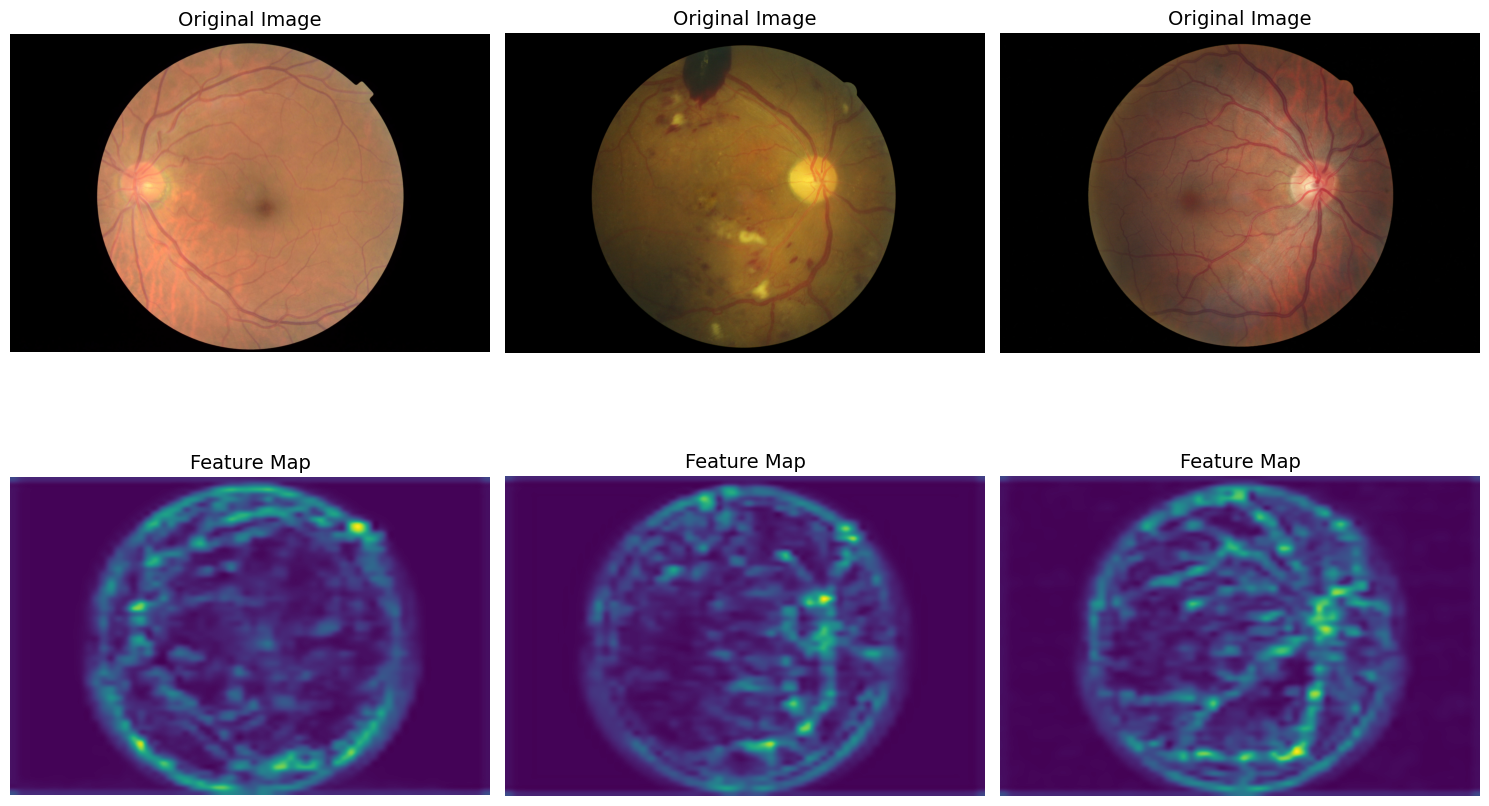

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from PIL import Image

# 加载预训练的VGG16模型
model = VGG16(weights='imagenet', include_top=False, input_shape=(2048, 2048, 3))

# 图像路径示例
image_paths = [
    'diabetic-retinopathy-detection/train/44178_left.jpeg',
    'diabetic-retinopathy-detection/train/43050_right.jpeg',
    'diabetic-retinopathy-detection/train/44113_right.jpeg'
]  # 替换为实际图像路径

# 优化后的特征提取和可视化函数
def extract_and_visualize_features(image_paths, model, batch_size=8):
    all_imgs = []
    original_sizes = []
    
    # 批量加载和处理图像
    for img_path in image_paths:
        img = load_img(img_path)
        original_sizes.append(img.size)  # 获取原始图像尺寸
        img_resized = img.resize((2048, 2048))  # 调整大小为模型输入尺寸
        img_array = img_to_array(img_resized)
        all_imgs.append(preprocess_input(img_array))
    all_imgs = np.stack(all_imgs)  # 将所有图像堆叠成批量数组

    # 批量预测
    feature_maps = model.predict(all_imgs, batch_size=batch_size)

    # 可视化
    num_images = len(image_paths)
    plt.figure(figsize=(15, 10))  # 设置总图像尺寸

    for i in range(num_images):
        # 获取原始图像和特征图
        original_img = load_img(image_paths[i])
        original_size = original_sizes[i]
        avg_feature_map = np.mean(feature_maps[i], axis=-1)
        
        # 将特征图调整回原始尺寸
        avg_feature_map_resized = np.array(
            Image.fromarray(avg_feature_map).resize(original_size, resample=Image.BICUBIC)
        )

        # 归一化特征图
        avg_feature_map_resized = (avg_feature_map_resized - avg_feature_map_resized.min()) / (
            avg_feature_map_resized.max() - avg_feature_map_resized.min()
        )

        # 显示原始图像（第一行）
        plt.subplot(2, num_images, i + 1)  # 第一行索引从 1 开始
        plt.imshow(original_img)
        plt.title("Original Image", fontsize=14)
        plt.axis("off")

        # 显示特征图（第二行）
        plt.subplot(2, num_images, num_images + i + 1)  # 第二行索引从 num_images + 1 开始
        plt.imshow(avg_feature_map_resized, cmap='viridis')
        plt.title("Feature Map", fontsize=14)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# 调用优化函数
extract_and_visualize_features(image_paths, model)